In [4]:
# !pip install opencv-python mediapipe sklearn matplotlib

  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)
  Using cached mediapipe-0.8.9.1-cp39-cp39-win_amd64.whl (48.5 MB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached matplotlib-3.5.1-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
  Using cached opencv_contrib_python-4.5.5.64-cp36-abi3-win_amd64.whl (42.2 MB)
  Using cached scikit_learn-1.0.2-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached Pillow-9.1.0-cp39-cp39-win_amd64.whl (3.3 MB)
  Using cached fonttools-4.32.0-py3-none-any.whl (900 kB)
  Using cached kiwisolver-1.4.2-cp39-cp39-win_amd64.whl (55 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached scipy-1.8.0-cp39-cp39-win_amd64.whl (36.9 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)


In [2]:
# !pip install tensorflow-gpu

  Using cached tensorflow_gpu-2.8.0-cp39-cp39-win_amd64.whl (438.0 MB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached h5py-3.6.0-cp39-cp39-win_amd64.whl (2.8 MB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached wrapt-1.14.0-cp39-cp39-win_amd64.whl (36 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-3.20.0-cp39-cp39-win_amd64.whl (904 kB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached numpy-1.22.3-cp39-cp39-win_amd64.whl (14.7 MB)
  Using cached grpcio-1.44.0-cp39-cp39-win_amd64.whl (3.4 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-2.0-py2.py3-non

# I. Import Library and define functions

In [1]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
import time
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [3]:
def get_scaled_landmarks(landmarks, dimenson):
    landmarks_2d = []
    landmarks_3d = []
    if dimenson == '2d':
        for landmark in landmarks:
            x, y = int(landmark.x*1280), int(landmark.y*720)
            landmarks_2d.append([x, y])
        return landmarks_2d
    if dimenson == 'both':
        for landmark in landmarks:
            x, y = int(landmark.x*1280), int(landmark.y*720)
            landmarks_2d.append([x, y])
            landmarks_3d.append([x, y, landmark.z])
        return landmarks_2d, landmarks_3d

In [4]:
def draw_landmarks(image, results):
    lmks = results.pose_landmarks.landmark
    pose_landmarks = [lmks[0], lmks[11], lmks[12], lmks[13], lmks[14], lmks[15], lmks[16], lmks[23], lmks[24], lmks[19], lmks[20]] 
    pose_landmarks = get_scaled_landmarks(pose_landmarks, '2d')
    
    cv2.line(image, tuple(pose_landmarks[1]), tuple(pose_landmarks[2]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[1]), tuple(pose_landmarks[3]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[3]), tuple(pose_landmarks[5]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[2]), tuple(pose_landmarks[4]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[4]), tuple(pose_landmarks[6]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[1]), tuple(pose_landmarks[7]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[2]), tuple(pose_landmarks[8]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[7]), tuple(pose_landmarks[8]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[5]), tuple(pose_landmarks[9]), (255, 255, 255), 2)
    cv2.line(image, tuple(pose_landmarks[6]), tuple(pose_landmarks[10]), (255, 255, 255), 2)
    for lm in pose_landmarks:
        cv2.circle(image, (int(lm[0]), int(lm[1])), 4, (0, 0, 255), -1)
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS) # Draw pose connections

In [5]:
def show_fps(image, prev_frame_time):
    new_frame_time = time.time()
    fps = int(1/(new_frame_time-prev_frame_time))
    cv2.putText(image, f"fps: {fps}", (1000, 700), cv2.FONT_HERSHEY_SIMPLEX, 2, (100, 255, 0), 2, cv2.LINE_AA)
    return new_frame_time


In [6]:
def get_joint_angle(a, b, c):
    angle = np.abs(np.arctan2(c.y-b.y, c.x-b.x) - np.arctan2(a.y-b.y, a.x-b.x))
    if angle > np.pi:
        angle = 2*np.pi-angle
    return angle

In [7]:
def get_all_angles(landmarks):
    nose = landmarks[mp_pose.PoseLandmark.NOSE.value]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    right_elbow = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value]
    right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value]
    right_ear = landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value]
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    left_elbow = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
    left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
    left_ear = landmarks[mp_pose.PoseLandmark.LEFT_EAR.value]
    right_elbow_angle = get_joint_angle(right_shoulder, right_elbow, right_wrist)
    righ_shoulders_angle = get_joint_angle(right_elbow, right_shoulder, left_shoulder)
    left_elbow_angle = get_joint_angle(left_shoulder, left_elbow, left_wrist)
    left_shoulders_angle = get_joint_angle(left_elbow, left_shoulder, right_shoulder)
    nose_angle = get_joint_angle(left_shoulder, nose, right_shoulder)
    left_ear_angle = get_joint_angle(left_shoulder, left_ear, right_shoulder)
    right_ear_angle = get_joint_angle(left_shoulder, right_ear, right_shoulder)
    angles = [right_elbow_angle, righ_shoulders_angle, left_elbow_angle, left_shoulders_angle, nose_angle, left_ear_angle, right_ear_angle]
    return angles

In [8]:
def get_frame_landmarks(results):
    size_landmarks = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark[:23]]).flatten() if results.pose_landmarks else np.zeros(4*23)
    world_landmarks =  np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_world_landmarks.landmark[:23]]).flatten() if results.pose_world_landmarks else np.zeros(4*23)
    angles = np.array(get_all_angles(results.pose_landmarks.landmark)) if results.pose_landmarks else np.zeros(4)
    landmarks = np.concatenate([size_landmarks, world_landmarks, angles])
    return landmarks

# II. Data processing

#### Create folders to save data

In [9]:
DATA_PATH = os.path.join('..\Data\Landmark Data')
VIDEO_PATH = os.path.join('..\Data\Video Data')
actions = np.array(['non_cheating', 'cheating'])

# for action in actions:
#     for sequence in range(1, 721):
#         try:
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

#### Extracts landmarks to created folders

In [10]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [ ]:
prev_frame_time = 0

for action in actions:
    action_path = os.path.join(VIDEO_PATH, action)
    for id_sequence, video_name in enumerate(os.listdir(action_path)):
        video_path = os.path.join(action_path, video_name)
        cap = cv2.VideoCapture(video_path)
        frame_num = 0
        with mp_pose.Pose() as pose:
            while cap.isOpened():
                # Read feed
                ret, frame = cap.read()
                if not ret:
                    print("Video end")
                    break

                frame_num += 1
                # Make detections
                image, results = mediapipe_detection(frame, pose)

                # Draw landmarks
                if results.pose_landmarks:
                    draw_landmarks(image, results) 

                frame_landmarks = get_frame_landmarks(results)
                print(frame_landmarks)
                frame_landmarks_path = os.path.join(DATA_PATH, action, str(id_sequence+1), str(frame_num))
                np.save(frame_landmarks_path, frame_landmarks)

                #Show fps
                prev_frame_time = show_fps(image, prev_frame_time)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)

                # Break gracefully
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        cap.release()
        cv2.destroyAllWindows()


[ 0.43185598  0.26790708 -0.32546839  0.9996953   0.44127733  0.22578549
 -0.35059106  0.99966323  0.44692725  0.22452092 -0.35051006  0.99957031
  0.45403585  0.2230102  -0.35058206  0.99967051  0.43128878  0.22478861
 -0.3127735   0.99972278  0.42981586  0.2228411  -0.31295931  0.99966633
  0.42863458  0.22071397 -0.31320438  0.99974281  0.5035603   0.23178899
 -0.37079361  0.99946994  0.46601114  0.22587401 -0.20166874  0.9997825
  0.45192307  0.31660688 -0.32572606  0.99988723  0.44016066  0.31230962
 -0.27650088  0.99983168  0.56933337  0.48810729 -0.38947818  0.99718481
  0.49117646  0.38699669 -0.05283207  0.99957305  0.53282607  0.85419101
 -0.3824836   0.94633597  0.45323771  0.57288581  0.14049397  0.4067702
  0.35085964  0.79170334 -0.31294307  0.92096835  0.33566663  0.59527797
  0.18000273  0.56503522  0.29872829  0.82428896 -0.3351987   0.86192769
  0.29682615  0.60912466  0.18022214  0.5858165   0.29004312  0.78425181
 -0.33744931  0.86685073  0.29071632  0.60040498  0.1

[ 0.42965895  0.26611441 -0.29096225  0.99947923  0.43985599  0.22389041
 -0.32415548  0.99952346  0.44605297  0.22260833 -0.32409245  0.9994328
  0.45346984  0.22097032 -0.32418787  0.99953777  0.42994627  0.22337382
 -0.27264008  0.99946719  0.42875585  0.22188886 -0.27273887  0.99937999
  0.42821774  0.22022398 -0.27299768  0.99948454  0.49590987  0.22806519
 -0.38511702  0.99942505  0.47263378  0.22513498 -0.1537973   0.99963975
  0.45183831  0.31543574 -0.30505753  0.99985117  0.44095406  0.31376913
 -0.23939666  0.99974471  0.58896387  0.49057692 -0.43012944  0.99731421
  0.50452697  0.37985665  0.00898273  0.99875033  0.54945028  0.87100375
 -0.46575934  0.96069735  0.46120819  0.57512474  0.14825809  0.32002163
  0.3596954   0.75454533 -0.45013052  0.95333117  0.33626994  0.59386188
  0.05067618  0.52427876  0.30271727  0.78079659 -0.49159512  0.9162395
  0.29263732  0.61957806  0.04239678  0.54588646  0.29456356  0.72831732
 -0.47586876  0.91963166  0.28904927  0.59563679 -0.0

[ 0.42942023  0.26690266 -0.26237938  0.99956435  0.43899292  0.22530234
 -0.29692915  0.99958622  0.44495749  0.22394417 -0.29691836  0.9995138
  0.45184907  0.22205567 -0.29703349  0.99959582  0.42994529  0.22532499
 -0.24072392  0.99949729  0.42899728  0.22426732 -0.24084342  0.99942827
  0.42860883  0.22309062 -0.24109241  0.99951285  0.49331951  0.2277673
 -0.36802399  0.99954784  0.47259822  0.2263539  -0.11512743  0.999663
  0.45170903  0.31747073 -0.28199476  0.9998824   0.44158071  0.31529605
 -0.20958361  0.99978304  0.58966792  0.48858351 -0.42599696  0.99813801
  0.50889462  0.38235965  0.04062767  0.99863839  0.55049908  0.87546855
 -0.44853395  0.97261834  0.46140957  0.58180314  0.10103321  0.29916856
  0.36170977  0.75354564 -0.41682655  0.96986365  0.33576378  0.59306961
 -0.10552813  0.52922934  0.30425793  0.77728546 -0.45682961  0.94435281
  0.28854597  0.61772472 -0.13066408  0.54259264  0.29608482  0.7215203
 -0.44021815  0.94644725  0.2840994   0.59178096 -0.1855

[ 0.42959094  0.26502839 -0.31844807  0.99953705  0.43905601  0.22382416
 -0.35055804  0.99953234  0.4449814   0.22263418 -0.35059124  0.99945211
  0.45163625  0.22096424 -0.35066798  0.99954522  0.43071809  0.2238508
 -0.2966159   0.99941701  0.43035841  0.22276634 -0.29679745  0.99936974
  0.43061772  0.22151256 -0.29707992  0.99946398  0.49306664  0.22626074
 -0.41711465  0.9995051   0.47513765  0.22508477 -0.17534266  0.99957687
  0.45138416  0.31601965 -0.33747059  0.99986935  0.44183069  0.31435606
 -0.26654631  0.99973685  0.59184968  0.50298816 -0.44807678  0.99852186
  0.5099588   0.38192859 -0.02738946  0.99844456  0.55171877  0.8648234
 -0.47270435  0.97889537  0.46302494  0.57958293  0.09380563  0.28331354
  0.36091116  0.75298089 -0.44886827  0.9778688   0.33539665  0.58993828
  0.01559447  0.51845348  0.30350876  0.77658844 -0.49455184  0.9570238
  0.28956491  0.61107111  0.00322477  0.52440304  0.29544216  0.72107053
 -0.47543257  0.9584291   0.2847822   0.58741134 -0.05

[ 4.29926723e-01  2.64716595e-01 -3.64381611e-01  9.99564350e-01
  4.39543873e-01  2.23521933e-01 -3.98614973e-01  9.99541759e-01
  4.45597112e-01  2.22249895e-01 -3.98598611e-01  9.99467850e-01
  4.52303231e-01  2.20603928e-01 -3.98672879e-01  9.99558985e-01
  4.31290776e-01  2.23752782e-01 -3.45134676e-01  9.99417305e-01
  4.31001186e-01  2.22681001e-01 -3.45335633e-01  9.99373615e-01
  4.31319326e-01  2.21469745e-01 -3.45621705e-01  9.99464989e-01
  4.93363678e-01  2.25518689e-01 -4.61500019e-01  9.99537289e-01
  4.75738227e-01  2.25070760e-01 -2.22932607e-01  9.99570787e-01
  4.51667935e-01  3.16185832e-01 -3.80276203e-01  9.99869287e-01
  4.42147076e-01  3.14588726e-01 -3.10867727e-01  9.99713659e-01
  5.92598438e-01  5.05806208e-01 -4.87930536e-01  9.98770118e-01
  5.10937214e-01  3.84873837e-01 -5.39439246e-02  9.98404682e-01
  5.52961588e-01  8.60056758e-01 -5.19238830e-01  9.83442008e-01
  4.63946402e-01  5.78700662e-01  8.99849236e-02  2.83013344e-01
  3.58108580e-01  7.54949

[ 0.4303163   0.26093692 -0.30358949  0.99960166  0.44062123  0.21742596
 -0.33428398  0.99958163  0.44705138  0.21532805 -0.33428338  0.99950784
  0.45416561  0.21263477 -0.33440173  0.99959981  0.43191338  0.21961093
 -0.28225183  0.99947143  0.43165082  0.21885204 -0.28234553  0.99942946
  0.43180108  0.21793401 -0.28255609  0.99950784  0.49382249  0.21758254
 -0.38961023  0.99957711  0.47407478  0.22038575 -0.15454109  0.99956125
  0.45203814  0.31073949 -0.31753072  0.99988663  0.44233757  0.3109605
 -0.24943945  0.99974716  0.59204113  0.50552422 -0.43162441  0.99904758
  0.51164079  0.38699049  0.00448543  0.99852234  0.55223691  0.85923511
 -0.45095062  0.98569864  0.45995507  0.58215761  0.09480225  0.26221317
  0.35581714  0.75337601 -0.39850155  0.98482329  0.33684355  0.58998907
 -0.05578312  0.49399871  0.29914016  0.78314865 -0.44060126  0.96773708
  0.2898494   0.60985643 -0.07839495  0.49276733  0.28957522  0.73147738
 -0.42244023  0.96837288  0.28359857  0.58914399 -0.

[ 0.40977803  0.34989741 -0.33171999  0.99975926  0.41447479  0.30842328
 -0.3599562   0.99992704  0.42112264  0.30528557 -0.35988569  0.99988461
  0.42898172  0.30182493 -0.35991907  0.99993157  0.40183663  0.31081319
 -0.32718566  0.99992788  0.39884388  0.30968142 -0.32726523  0.99988008
  0.39604014  0.3079074  -0.32731861  0.99990332  0.47257179  0.29561019
 -0.38714364  0.99987817  0.42776361  0.29759949 -0.24027249  0.99988544
  0.43408909  0.38325852 -0.33330327  0.99991727  0.4191629   0.38224453
 -0.29022178  0.99988353  0.55837059  0.48440775 -0.3818453   0.99794894
  0.45806861  0.41775209 -0.13056354  0.9995364   0.51284695  0.81666732
 -0.36580959  0.93750685  0.41596431  0.58994567 -0.04659794  0.27819875
  0.33795929  0.76280254 -0.30800357  0.9671793   0.32329804  0.63777703
 -0.13420966  0.45577589  0.28491837  0.77457893 -0.34323514  0.94910794
  0.29210633  0.68008941 -0.16453713  0.58850986  0.29180306  0.71202976
 -0.34734648  0.95196879  0.28733799  0.66460335 -0

[ 4.05902058e-01  3.49621624e-01 -3.30634713e-01  9.99653101e-01
  4.10922855e-01  3.08596075e-01 -3.57635796e-01  9.99832213e-01
  4.17071253e-01  3.05888236e-01 -3.57604265e-01  9.99757767e-01
  4.23543543e-01  3.02956790e-01 -3.57743084e-01  9.99844313e-01
  3.99799883e-01  3.10264856e-01 -3.19118798e-01  9.99846160e-01
  3.97591591e-01  3.08722585e-01 -3.19242626e-01  9.99772131e-01
  3.95527512e-01  3.06586981e-01 -3.19434792e-01  9.99818563e-01
  4.62436587e-01  2.95638382e-01 -3.83788496e-01  9.99746025e-01
  4.34228003e-01  2.96642005e-01 -2.09166959e-01  9.99801815e-01
  4.30159032e-01  3.82698745e-01 -3.31791610e-01  9.99875963e-01
  4.17708963e-01  3.82564932e-01 -2.80921876e-01  9.99842405e-01
  5.54520130e-01  4.92131114e-01 -3.93378049e-01  9.98048246e-01
  4.59484398e-01  4.08605576e-01 -7.35857859e-02  9.99538898e-01
  5.03497005e-01  8.18291247e-01 -4.13509429e-01  9.43892360e-01
  4.17029470e-01  5.89074910e-01  9.52837523e-04  2.98993617e-01
  3.24027181e-01  7.40701

[ 0.40728083  0.35233092 -0.3697657   0.99961847  0.41167355  0.31080183
 -0.39339799  0.99978936  0.41776925  0.30862504 -0.39334655  0.99970442
  0.42408299  0.30608004 -0.39347884  0.99980712  0.40096864  0.3119992
 -0.35943824  0.99980736  0.3991529   0.31061858 -0.35956836  0.99971795
  0.39760968  0.3087253  -0.35979798  0.99978226  0.46212283  0.29719022
 -0.40115365  0.99968469  0.43686399  0.29809245 -0.24874747  0.99977899
  0.43324471  0.3852948  -0.36390066  0.99986851  0.42056566  0.38563859
 -0.31957763  0.99983901  0.56046861  0.50318974 -0.40075201  0.99793422
  0.46284539  0.39719793 -0.11684276  0.99953735  0.51328909  0.83608186
 -0.42275366  0.94484532  0.41785342  0.58721405 -0.03106738  0.31927204
  0.32436696  0.73210973 -0.42884532  0.96407771  0.32377726  0.65524507
 -0.113327    0.52166438  0.28274235  0.77305919 -0.46776605  0.94024956
  0.28889939  0.69565988 -0.13638392  0.60576034  0.27276915  0.72666085
 -0.46470031  0.94276583  0.28610462  0.66822058 -0.

[ 4.09700483e-01  3.56995255e-01 -3.58856052e-01  9.99564409e-01
  4.13305461e-01  3.15605938e-01 -3.84641409e-01  9.99718964e-01
  4.19363678e-01  3.13387722e-01 -3.84590060e-01  9.99619365e-01
  4.26094860e-01  3.10340643e-01 -3.84739339e-01  9.99741614e-01
  4.02838379e-01  3.16550553e-01 -3.48808944e-01  9.99748588e-01
  4.01178777e-01  3.15218091e-01 -3.48940581e-01  9.99646187e-01
  3.99877489e-01  3.13503385e-01 -3.49152863e-01  9.99728024e-01
  4.62234557e-01  2.97834486e-01 -4.00866657e-01  9.99623179e-01
  4.39884812e-01  3.01644295e-01 -2.34501034e-01  9.99749660e-01
  4.34089601e-01  3.87159169e-01 -3.55741173e-01  9.99851286e-01
  4.21988577e-01  3.88018847e-01 -3.08900863e-01  9.99825835e-01
  5.63605070e-01  5.03246665e-01 -4.09306586e-01  9.97836590e-01
  4.67096001e-01  3.94979060e-01 -9.57532451e-02  9.99530911e-01
  5.14257014e-01  8.44588876e-01 -4.23136711e-01  9.46879268e-01
  4.17938173e-01  5.87550819e-01 -7.74656981e-03  3.26637268e-01
  3.22533876e-01  7.28013

[ 0.40935802  0.35670629 -0.32902148  0.99955368  0.41158238  0.31553158
 -0.35774645  0.99967313  0.4177025   0.31369621 -0.35770208  0.99956906
  0.42449236  0.3108139  -0.35786685  0.99969602  0.40167904  0.31522632
 -0.31684154  0.99971253  0.40029317  0.31350785 -0.31698671  0.99962074
  0.39921492  0.31125078 -0.31719837  0.99970299  0.46408528  0.2965796
 -0.39396092  0.99959522  0.44182554  0.29954201 -0.2075009   0.99973089
  0.43412679  0.38698891 -0.33477071  0.99984252  0.42228499  0.38768831
 -0.28050447  0.99981397  0.56047577  0.47282788 -0.40871924  0.99813902
  0.47124609  0.38683191 -0.07210986  0.99958307  0.5113585   0.83976912
 -0.42115384  0.95145321  0.42228374  0.58381307  0.01699111  0.31349725
  0.32085398  0.72661012 -0.3448934   0.94439179  0.3227773   0.65349281
 -0.05787943  0.50472742  0.27575031  0.77371973 -0.37519211  0.90327877
  0.28837067  0.68697619 -0.06991172  0.55100769  0.268381    0.73448622
 -0.3624751   0.90629983  0.28278324  0.66926777 -0.

[ 0.40921369  0.35465577 -0.34198466  0.99956131  0.41118973  0.31370696
 -0.37184411  0.99964505  0.41729847  0.31200734 -0.3717888   0.99953091
  0.42409134  0.30923998 -0.37195504  0.99965698  0.40133277  0.31338337
 -0.32933289  0.99969828  0.39984453  0.31181401 -0.32950467  0.99961591
  0.39851704  0.30973998 -0.32974017  0.99969828  0.46418351  0.2959643
 -0.40334377  0.99957579  0.43711114  0.2997205  -0.21324232  0.99973834
  0.43276262  0.38535741 -0.34617549  0.99983656  0.42106828  0.38584897
 -0.2901589   0.99981779  0.5642668   0.49160215 -0.41591159  0.99837321
  0.47150216  0.385461   -0.06995453  0.99965841  0.5154013   0.84605044
 -0.42519182  0.9564904   0.42366147  0.58186829  0.01977844  0.32143787
  0.32839096  0.72419304 -0.37353233  0.93937737  0.32401192  0.64138317
 -0.07728336  0.5252372   0.27942681  0.76610237 -0.4086864   0.89189106
  0.2899327   0.68265384 -0.09457861  0.55607367  0.27306452  0.72241431
 -0.39931688  0.89441663  0.28536662  0.6650542  -0.

[ 0.40925431  0.35275859 -0.34847593  0.99958766  0.41112882  0.31212226
 -0.37551597  0.99965769  0.41734082  0.31057703 -0.37546676  0.99954057
  0.42424709  0.30792373 -0.37563723  0.99966156  0.40114397  0.31155449
 -0.33607739  0.99971259  0.39954394  0.31002408 -0.33620566  0.99963313
  0.39803481  0.30796996 -0.33641601  0.99971604  0.46472955  0.29411006
 -0.40039206  0.99960315  0.43714246  0.29945448 -0.22217545  0.99976116
  0.43267044  0.38407719 -0.35012072  0.9998455   0.4208141   0.38425773
 -0.2982316   0.99983495  0.5660367   0.49799651 -0.41337937  0.99852818
  0.46203047  0.38257301 -0.07884346  0.99970168  0.51711822  0.84374797
 -0.40364474  0.95936048  0.42718679  0.58259356  0.01508338  0.32399166
  0.33761173  0.72408617 -0.32433254  0.93506527  0.32768479  0.64428514
 -0.07102697  0.53026277  0.28832006  0.7606321  -0.35298663  0.88209528
  0.29164156  0.68586814 -0.08899121  0.55471563  0.29426813  0.70690131
 -0.34413916  0.88497359  0.28753996  0.66615909 -0

[ 0.4056893   0.3531957  -0.34718531  0.99977356  0.40935317  0.31101021
 -0.37365201  0.99989867  0.41542688  0.30866551 -0.37360242  0.99986035
  0.42186323  0.30601695 -0.37372932  0.9999038   0.39889354  0.31254143
 -0.33956155  0.99990427  0.39707026  0.31124255 -0.33967909  0.99986243
  0.39541346  0.30947468 -0.33981785  0.99989218  0.46036166  0.29622295
 -0.39004555  0.99984533  0.43593317  0.29686427 -0.23749074  0.99989396
  0.43116403  0.38411781 -0.3453792   0.99992907  0.41910046  0.38537577
 -0.30034968  0.99991435  0.55833042  0.50265777 -0.39019445  0.99807864
  0.46202096  0.39832869 -0.11216877  0.99965084  0.5121091   0.83998829
 -0.40723172  0.94765586  0.41977343  0.58406383 -0.02231085  0.35848266
  0.3271997   0.73938394 -0.38658309  0.96103841  0.3251867   0.65781349
 -0.08563378  0.57092178  0.27813014  0.77887487 -0.42206579  0.93695587
  0.2900221   0.69195551 -0.10706031  0.65524089  0.26919052  0.7338407
 -0.41537637  0.94112408  0.28834787  0.67103118 -0.

[ 0.40897465  0.35487646 -0.39186493  0.99964195  0.4134869   0.31367034
 -0.41536385  0.99975878  0.42044622  0.3117108  -0.41530734  0.99967808
  0.42792845  0.30904853 -0.41544628  0.99978042  0.40155402  0.31416753
 -0.38262343  0.99978828  0.39947233  0.31279263 -0.38275903  0.99970418
  0.39774439  0.31105089 -0.38297477  0.99976939  0.46469507  0.29683256
 -0.41654864  0.99968815  0.43904772  0.29977053 -0.26728454  0.9997918
  0.43413991  0.38657749 -0.38277641  0.99988252  0.42143074  0.3874844
 -0.33954516  0.99986452  0.56712806  0.49845025 -0.41731825  0.9980315
  0.46449551  0.39256078 -0.11983367  0.99959594  0.51995063  0.84696984
 -0.43465167  0.9500702   0.42011523  0.59021139 -0.03819374  0.35507402
  0.3274416   0.72990131 -0.41011804  0.95461923  0.3230474   0.65838224
 -0.13652843  0.55789846  0.27924111  0.77479035 -0.44608927  0.92344749
  0.28395036  0.69947594 -0.16246593  0.62241387  0.27236468  0.72828716
 -0.43931621  0.92750818  0.28143302  0.67741853 -0.20

[ 0.41086531  0.35653648 -0.38667339  0.9996056   0.41484636  0.3152622
 -0.41240984  0.99969345  0.42187628  0.3132236  -0.41234833  0.99959737
  0.42976284  0.31020334 -0.4124566   0.99971712  0.40251821  0.31488419
 -0.38175696  0.99973327  0.4003644   0.31314048 -0.38196036  0.99963993
  0.39856252  0.31077567 -0.3822113   0.99971455  0.46952358  0.2964735
 -0.42112881  0.99961692  0.44133288  0.29961547 -0.25973248  0.99974084
  0.43558127  0.38682547 -0.37934539  0.99986035  0.42177811  0.3873615
 -0.33839437  0.9998399   0.57105792  0.49780867 -0.42190486  0.99807417
  0.46648902  0.38632095 -0.11774715  0.99960583  0.51852357  0.84311187
 -0.43212271  0.954009    0.42010254  0.58632827 -0.0320786   0.36021104
  0.32437092  0.72538155 -0.38543847  0.9476729   0.32272035  0.65308052
 -0.12097637  0.56731492  0.27661377  0.77310759 -0.4179036   0.90858901
  0.28496578  0.69350964 -0.1359715   0.61470795  0.27059966  0.72962356
 -0.40679798  0.91285002  0.28153306  0.67064941 -0.17

[ 4.10607994e-01  3.59913707e-01 -3.53076369e-01  9.99578655e-01
  4.12722975e-01  3.20090115e-01 -3.79763603e-01  9.99658406e-01
  4.19076145e-01  3.18103939e-01 -3.79722029e-01  9.99545038e-01
  4.25927401e-01  3.14941257e-01 -3.79850000e-01  9.99678731e-01
  4.01934206e-01  3.19588780e-01 -3.42343897e-01  9.99710858e-01
  4.00221348e-01  3.17858338e-01 -3.42495888e-01  9.99616861e-01
  3.98737133e-01  3.15712929e-01 -3.42732102e-01  9.99707043e-01
  4.67738003e-01  2.96991885e-01 -4.05691534e-01  9.99575496e-01
  4.41284746e-01  3.02000791e-01 -2.33766288e-01  9.99733329e-01
  4.35605705e-01  3.88429105e-01 -3.53694111e-01  9.99842823e-01
  4.22309726e-01  3.88506830e-01 -3.04480076e-01  9.99828696e-01
  5.67534089e-01  5.01768470e-01 -4.16829288e-01  9.98171747e-01
  4.63997900e-01  3.86307657e-01 -9.55029875e-02  9.99655604e-01
  5.15442252e-01  8.39861035e-01 -4.23202038e-01  9.54502881e-01
  4.25843954e-01  5.82535923e-01 -7.84543995e-03  3.49665463e-01
  3.24847698e-01  7.19715

[ 0.41034561  0.35867196 -0.36210889  0.99958235  0.41210064  0.3188273
 -0.39184254  0.99964595  0.41826519  0.31694767 -0.39180717  0.99952614
  0.42489585  0.3137826  -0.39197731  0.9996618   0.40141922  0.3182689
 -0.34988248  0.99969083  0.39962617  0.31655464 -0.3500585   0.99959379
  0.39792457  0.31435424 -0.35031834  0.99968946  0.46568888  0.29579106
 -0.42192405  0.99957156  0.43891668  0.30175284 -0.23011215  0.99972874
  0.43495712  0.38729504 -0.36349925  0.99983716  0.42196065  0.38770413
 -0.30795759  0.99982077  0.56720471  0.50113255 -0.4305349   0.99839354
  0.46962318  0.3849192  -0.08685715  0.99967057  0.51614612  0.85234797
 -0.44892105  0.95644498  0.43142995  0.58611423  0.01503635  0.33268654
  0.33014557  0.71671659 -0.42992839  0.94018233  0.33374259  0.63673145
 -0.07199258  0.56537157  0.28050578  0.75499123 -0.47039795  0.89531213
  0.29275537  0.66754198 -0.08737685  0.59489739  0.27892944  0.69490838
 -0.4626326   0.89923394  0.29061368  0.63231796 -0.1

[ 4.09375966e-01  3.57204556e-01 -3.61013234e-01  9.99619722e-01
  4.11319107e-01  3.17154467e-01 -3.92622799e-01  9.99677598e-01
  4.17598575e-01  3.15663606e-01 -3.92570734e-01  9.99562204e-01
  4.24413830e-01  3.12701672e-01 -3.92723233e-01  9.99686837e-01
  3.99797827e-01  3.15004081e-01 -3.51941884e-01  9.99717236e-01
  3.97654593e-01  3.12675148e-01 -3.52125019e-01  9.99629021e-01
  3.95530790e-01  3.09773266e-01 -3.52366984e-01  9.99712467e-01
  4.65986073e-01  2.92040497e-01 -4.31891531e-01  9.99617696e-01
  4.38024133e-01  3.00353348e-01 -2.47090071e-01  9.99752343e-01
  4.33912337e-01  3.86676252e-01 -3.65944773e-01  9.99852538e-01
  4.21307981e-01  3.86794955e-01 -3.12356293e-01  9.99836087e-01
  5.65148234e-01  4.98840749e-01 -4.42597449e-01  9.98673558e-01
  4.70921695e-01  3.77472520e-01 -9.48325917e-02  9.99719799e-01
  5.17645240e-01  8.51722717e-01 -4.53081518e-01  9.58085060e-01
  4.38357264e-01  5.84656179e-01  4.42414768e-02  2.93201268e-01
  3.36140096e-01  7.12163

[ 0.40652481  0.36323208 -0.34706718  0.9999491   0.41089725  0.31875324
 -0.37471783  0.99997663  0.41688901  0.31689012 -0.37465149  0.99996531
  0.42359585  0.31429803 -0.37465772  0.99997878  0.3987146   0.31866252
 -0.34405437  0.99997807  0.39622343  0.31687653 -0.3441788   0.99996603
  0.39390752  0.31464559 -0.34423015  0.99997091  0.46768981  0.30291164
 -0.39757556  0.99996257  0.41197959  0.31782818 -0.25989273  0.9999584
  0.4296976   0.39350265 -0.34716633  0.99997723  0.41714469  0.39643842
 -0.30656323  0.9999702   0.54374796  0.50025845 -0.38491607  0.99955004
  0.46492702  0.40299577 -0.14221331  0.99983573  0.50589514  0.83368468
 -0.3544749   0.95886999  0.43426889  0.59126246 -0.05795906  0.21842362
  0.32330441  0.74556679 -0.26020706  0.96717346  0.34374681  0.64600772
 -0.15141033  0.44608548  0.27698839  0.77970892 -0.28775695  0.94249988
  0.31231114  0.66563457 -0.18097661  0.5571385   0.28039205  0.70562369
 -0.29144794  0.94589424  0.30878952  0.64795387 -0.

[ 4.07354444e-01  3.63174260e-01 -3.30716699e-01  9.99864399e-01
  4.10981476e-01  3.20486873e-01 -3.58792096e-01  9.99916077e-01
  4.16924298e-01  3.18563372e-01 -3.58753979e-01  9.99887884e-01
  4.23351377e-01  3.15985650e-01 -3.58907133e-01  9.99924898e-01
  3.99669081e-01  3.20438266e-01 -3.19671333e-01  9.99922514e-01
  3.97771984e-01  3.18764031e-01 -3.19793999e-01  9.99894023e-01
  3.96225989e-01  3.16689789e-01 -3.20002019e-01  9.99911726e-01
  4.59738821e-01  3.03103745e-01 -3.91469568e-01  9.99892950e-01
  4.38672721e-01  3.06412280e-01 -2.14220792e-01  9.99914229e-01
  4.31941122e-01  3.93218696e-01 -3.34169388e-01  9.99946356e-01
  4.20227945e-01  3.95245612e-01 -2.82747239e-01  9.99937057e-01
  5.61488926e-01  5.05040705e-01 -3.99907410e-01  9.99297559e-01
  4.65977371e-01  3.88004035e-01 -8.58030468e-02  9.99769688e-01
  5.14325380e-01  8.53575051e-01 -4.18569654e-01  9.59495366e-01
  4.35320675e-01  5.90758145e-01  5.63043449e-03  2.31444463e-01
  3.32996577e-01  7.32815

[ 4.07561958e-01  3.62811923e-01 -3.50118995e-01  9.99800265e-01
  4.10981596e-01  3.21347415e-01 -3.77040595e-01  9.99865413e-01
  4.16926563e-01  3.19358855e-01 -3.76986593e-01  9.99820173e-01
  4.23438609e-01  3.16649973e-01 -3.77094001e-01  9.99878943e-01
  3.99892360e-01  3.21330100e-01 -3.40618104e-01  9.99878645e-01
  3.97995621e-01  3.19546431e-01 -3.40745538e-01  9.99836206e-01
  3.96390140e-01  3.17278385e-01 -3.40973258e-01  9.99866903e-01
  4.59691852e-01  3.03108037e-01 -4.01338726e-01  9.99828100e-01
  4.37670767e-01  3.06059062e-01 -2.31798530e-01  9.99876022e-01
  4.32060242e-01  3.93075019e-01 -3.49308550e-01  9.99920845e-01
  4.20328677e-01  3.94702613e-01 -3.01452547e-01  9.99911666e-01
  5.60910821e-01  5.06588340e-01 -4.04896259e-01  9.99128342e-01
  4.67990935e-01  3.84379148e-01 -1.04511604e-01  9.99752700e-01
  5.14612913e-01  8.51035714e-01 -4.23909187e-01  9.59016085e-01
  4.34636682e-01  5.90749502e-01 -1.17275137e-02  2.46592760e-01
  3.30756783e-01  7.29469

[ 4.07231569e-01  3.58263612e-01 -3.65610421e-01  9.99776721e-01
  4.10703331e-01  3.17115664e-01 -3.91424119e-01  9.99841690e-01
  4.16735888e-01  3.14255804e-01 -3.91365528e-01  9.99785304e-01
  4.23427969e-01  3.10628027e-01 -3.91481578e-01  9.99852479e-01
  3.99598718e-01  3.18872631e-01 -3.54565233e-01  9.99853790e-01
  3.97666454e-01  3.17536294e-01 -3.54683608e-01  9.99802828e-01
  3.95991355e-01  3.15713227e-01 -3.54882747e-01  9.99837458e-01
  4.60316002e-01  2.96490759e-01 -4.11458969e-01  9.99803543e-01
  4.36442673e-01  3.03754181e-01 -2.43590146e-01  9.99851704e-01
  4.31722403e-01  3.88555825e-01 -3.64576787e-01  9.99911368e-01
  4.19936091e-01  3.90224278e-01 -3.16071242e-01  9.99900460e-01
  5.65053761e-01  5.05560577e-01 -4.14197266e-01  9.99101996e-01
  4.66997713e-01  3.89760137e-01 -1.09408878e-01  9.99732316e-01
  5.16425848e-01  8.51175249e-01 -4.27996457e-01  9.61935401e-01
  4.30376142e-01  5.94327986e-01 -1.95390768e-02  2.60278225e-01
  3.34028572e-01  7.24772

[ 4.07182544e-01  3.57189596e-01 -3.47732127e-01  9.99748349e-01
  4.10784721e-01  3.16227198e-01 -3.73605520e-01  9.99824286e-01
  4.17087942e-01  3.13381374e-01 -3.73540550e-01  9.99759912e-01
  4.24345672e-01  3.09790730e-01 -3.73639137e-01  9.99836445e-01
  3.99475276e-01  3.17839950e-01 -3.37881386e-01  9.99839067e-01
  3.97424906e-01  3.16402525e-01 -3.37990940e-01  9.99779642e-01
  3.95568460e-01  3.14473987e-01 -3.38184834e-01  9.99821663e-01
  4.62054431e-01  2.95795858e-01 -3.95147949e-01  9.99780655e-01
  4.35961396e-01  3.02715868e-01 -2.33508229e-01  9.99838114e-01
  4.31795269e-01  3.87606680e-01 -3.47427875e-01  9.99904692e-01
  4.19811815e-01  3.89070839e-01 -3.00536811e-01  9.99892771e-01
  5.64442873e-01  5.05115509e-01 -4.00739431e-01  9.98930395e-01
  4.66459662e-01  3.90211999e-01 -1.03805743e-01  9.99692976e-01
  5.16659081e-01  8.54093850e-01 -4.07793373e-01  9.62919295e-01
  4.33238894e-01  5.93602359e-01 -5.92215918e-03  2.71171480e-01
  3.36799920e-01  7.24025

[ 0.40921229  0.35832402 -0.35806784  0.99969923  0.41246128  0.31775045
 -0.38448295  0.99979764  0.41845036  0.31532887 -0.38441443  0.99972129
  0.42533231  0.31208843 -0.38450921  0.99981016  0.40174454  0.31886292
 -0.34885311  0.99981803  0.39992121  0.31750801 -0.3489787   0.99975002
  0.39837772  0.3156853  -0.34915537  0.99979973  0.46408743  0.29741326
 -0.40125528  0.99975085  0.44103712  0.30367357 -0.24028149  0.99981332
  0.43358445  0.38934124 -0.35521147  0.99988985  0.42176574  0.39059037
 -0.30872697  0.99987829  0.55907565  0.50522548 -0.40829736  0.99875557
  0.47003555  0.38866943 -0.10380696  0.99967784  0.51485932  0.85020745
 -0.40089074  0.96060097  0.43423671  0.58989519  0.00556397  0.26486951
  0.33138609  0.72406465 -0.35066599  0.9550243   0.33512297  0.64863098
 -0.05110507  0.45766088  0.28417346  0.76041073 -0.38315144  0.91952318
  0.29893804  0.6642285  -0.06550834  0.51710773  0.28090566  0.71756577
 -0.37628371  0.92221487  0.29905683  0.64772612 -0

[ 0.43318671  0.2643128  -0.1989032   0.99959987  0.43877786  0.21400684
 -0.23266001  0.99988782  0.44440007  0.21270449 -0.23262438  0.9998641
  0.45102653  0.21053219 -0.23283665  0.99989355  0.43017507  0.21341212
 -0.18389677  0.99988329  0.42948699  0.21214777 -0.18391481  0.99984515
  0.42907494  0.21026437 -0.18405303  0.99987864  0.4974618   0.21078247
 -0.27623221  0.99987721  0.4716478   0.21089309 -0.05827891  0.99988174
  0.45417008  0.30254483 -0.2091668   0.99993134  0.44439548  0.30224305
 -0.14659221  0.99990916  0.5932169   0.43396097 -0.32165641  0.99698704
  0.4959178   0.36636925  0.07243919  0.9992525   0.57369125  0.81076145
 -0.27578506  0.91835546  0.46091995  0.56677127  0.12067063  0.14741121
  0.41640759  0.65942812 -0.09832595  0.89305866  0.38214469  0.60045385
 -0.06068315  0.20145777  0.37127882  0.68383843 -0.10153701  0.83201236
  0.34367281  0.64422673 -0.08624387  0.27090478  0.36904997  0.62343305
 -0.11067472  0.84383506  0.33823693  0.60390103 -0.

[ 0.43565553  0.27188233 -0.19986141  0.99953204  0.44274896  0.22935206
 -0.23069322  0.99982756  0.44861358  0.2261433  -0.23065236  0.99979872
  0.45541334  0.22234401 -0.23077571  0.99982977  0.43362719  0.23325258
 -0.1776987   0.9998154   0.43274745  0.23311268 -0.17773302  0.99977428
  0.4322207   0.23270893 -0.17789926  0.99981719  0.49594873  0.21899727
 -0.28517908  0.9998306   0.47257084  0.22599486 -0.05410035  0.99983948
  0.46040955  0.31439078 -0.21501777  0.9999007   0.45019022  0.31766763
 -0.14916681  0.99987     0.59829468  0.44497269 -0.34594324  0.99698108
  0.50245231  0.37924826  0.09175117  0.99903309  0.56682891  0.8231833
 -0.3279596   0.92840677  0.47131839  0.57327032  0.11065158  0.17343712
  0.41584578  0.66716945 -0.22059424  0.91501886  0.38516065  0.58929104
 -0.13800725  0.29695126  0.37060326  0.68394905 -0.23826385  0.86385
  0.34743223  0.62291151 -0.16664736  0.35806081  0.36514762  0.62688273
 -0.23100615  0.87292027  0.34015507  0.59334689 -0.204

[ 0.43594202  0.2720539  -0.17519948  0.99959457  0.44309893  0.22968403
 -0.20384786  0.99982703  0.4488216   0.22650659 -0.20378897  0.99980658
  0.45529872  0.2224897  -0.20390232  0.99982917  0.43423915  0.23336914
 -0.1518717   0.99979872  0.43360418  0.23316489 -0.15190378  0.99976581
  0.43337685  0.23264098 -0.1520648   0.99980497  0.49444264  0.21849997
 -0.25700563  0.99984246  0.47348604  0.22740243 -0.02767539  0.99984032
  0.46079904  0.31391662 -0.19184285  0.99990904  0.45067731  0.31736231
 -0.12597497  0.9998641   0.60269785  0.44726139 -0.32617185  0.99730498
  0.50216872  0.3768377   0.1102133   0.99850649  0.57148862  0.81582522
 -0.32780257  0.94901156  0.46574157  0.56893945  0.142545    0.20836997
  0.41526332  0.66907609 -0.21957509  0.94408989  0.37456077  0.58557075
 -0.07828585  0.3908565   0.3692624   0.67974955 -0.23944125  0.90721506
  0.33508459  0.62001961 -0.10308753  0.43496716  0.36551943  0.62556809
 -0.22941177  0.91342163  0.33206886  0.58898246 -0

[ 4.36489522e-01  2.72384375e-01 -2.45056078e-01  9.99681354e-01
  4.43166912e-01  2.30433300e-01 -2.77133405e-01  9.99837875e-01
  4.48849678e-01  2.27122411e-01 -2.77144819e-01  9.99830186e-01
  4.55127567e-01  2.23017037e-01 -2.77308404e-01  9.99840260e-01
  4.34593141e-01  2.35058740e-01 -2.23016351e-01  9.99804318e-01
  4.33982313e-01  2.35229626e-01 -2.23050088e-01  9.99786258e-01
  4.33772653e-01  2.35336304e-01 -2.23261043e-01  9.99809504e-01
  4.92954165e-01  2.17316642e-01 -3.28754485e-01  9.99871433e-01
  4.72548157e-01  2.29376301e-01 -8.73257220e-02  9.99865234e-01
  4.61339623e-01  3.13084364e-01 -2.57667243e-01  9.99915004e-01
  4.51545179e-01  3.17274183e-01 -1.88388914e-01  9.99863386e-01
  6.05781078e-01  4.53148186e-01 -3.77921760e-01  9.97901678e-01
  5.02991498e-01  3.88627410e-01  8.69627744e-02  9.98379350e-01
  5.74800074e-01  8.25292885e-01 -3.76098186e-01  9.64007735e-01
  4.67101634e-01  6.06322646e-01  8.82343426e-02  2.58066267e-01
  4.14379835e-01  6.72508

[ 0.43688482  0.27063212 -0.19516875  0.99974948  0.44353777  0.22733031
 -0.22203796  0.99984992  0.44918552  0.22406532 -0.22200291  0.99985105
  0.45541295  0.21978332 -0.22215438  0.99985379  0.435179    0.23151584
 -0.16913342  0.99981129  0.43461514  0.23129065 -0.16907895  0.99980158
  0.43445292  0.23067418 -0.16925561  0.99981564  0.49330506  0.21336612
 -0.27105823  0.99989271  0.47389784  0.22533387 -0.03689239  0.99988294
  0.46115232  0.30993685 -0.20855081  0.99992353  0.45148295  0.31494936
 -0.14122117  0.99986649  0.60876966  0.45261887 -0.33428413  0.99836349
  0.50116086  0.38473675  0.11399953  0.99835408  0.57763207  0.82904655
 -0.32694733  0.97342354  0.46465597  0.59832454  0.13260573  0.28355402
  0.4213616   0.66628307 -0.25395948  0.97455007  0.38144311  0.6060285
 -0.12549131  0.53153896  0.37525424  0.66876739 -0.28178173  0.95344132
  0.33611223  0.6445533  -0.15085557  0.53338581  0.371584    0.61835116
 -0.26487869  0.95656526  0.33431083  0.60690522 -0.

[ 4.36806619e-01  2.69340843e-01 -2.66132027e-01  9.99787748e-01
  4.43545163e-01  2.25611746e-01 -2.95352370e-01  9.99858439e-01
  4.49156284e-01  2.22353622e-01 -2.95345962e-01  9.99864697e-01
  4.55406278e-01  2.18455330e-01 -2.95539260e-01  9.99864995e-01
  4.35453951e-01  2.29439333e-01 -2.43109629e-01  9.99816656e-01
  4.34935421e-01  2.28994310e-01 -2.43148044e-01  9.99812365e-01
  4.34788555e-01  2.28234589e-01 -2.43364379e-01  9.99821126e-01
  4.93312925e-01  2.12066785e-01 -3.42646062e-01  9.99908924e-01
  4.74202782e-01  2.21098602e-01 -1.08529612e-01  9.99895453e-01
  4.59710181e-01  3.08755726e-01 -2.77765960e-01  9.99930561e-01
  4.50006008e-01  3.12595338e-01 -2.10403681e-01  9.99871433e-01
  6.15478456e-01  4.52876657e-01 -3.77189517e-01  9.98610556e-01
  5.00700116e-01  3.76099616e-01  4.02204283e-02  9.98247266e-01
  6.00105882e-01  8.32924902e-01 -3.71879905e-01  9.79122460e-01
  4.65716362e-01  5.96777856e-01  4.68233377e-02  3.20734531e-01
  4.32222456e-01  6.71139

[ 0.43669692  0.27167028 -0.30135769  0.99983793  0.44397274  0.22719328
 -0.33127922  0.99986875  0.4499259   0.22385843 -0.33123881  0.99987996
  0.45693427  0.22005291 -0.33134517  0.99987531  0.43559146  0.23080845
 -0.2781955   0.99983329  0.43495721  0.23019543 -0.27831537  0.99983925
  0.43459612  0.22937062 -0.27853623  0.99983799  0.49566072  0.21219267
 -0.36890221  0.99992657  0.47275615  0.22132069 -0.13002089  0.99990916
  0.45863795  0.31026036 -0.30743545  0.99994183  0.44916859  0.31401542
 -0.23880401  0.99988496  0.62072134  0.46078551 -0.3786408   0.99892032
  0.50240386  0.38270929  0.01825744  0.9985866   0.66354573  0.84521544
 -0.40709668  0.98598856  0.46238279  0.6012944   0.03757207  0.41358703
  0.4726108   0.73364234 -0.42460912  0.98568934  0.37533945  0.59444255
 -0.22699082  0.6832779   0.42858005  0.74810666 -0.4626762   0.96970135
  0.33480203  0.61410111 -0.25582182  0.65992552  0.42143792  0.70093244
 -0.43458939  0.97213411  0.33108416  0.58226299 -0

[ 0.43750602  0.29676312 -0.39784306  0.9995842   0.44527632  0.25078279
 -0.42650127  0.9998455   0.45159426  0.247352   -0.42645365  0.99981898
  0.45892438  0.2435625  -0.42669231  0.99984401  0.43268412  0.25481844
 -0.38610539  0.99987668  0.43026763  0.2539418  -0.38621861  0.99985248
  0.42858252  0.25254148 -0.38646311  0.99985081  0.50430012  0.2372925
 -0.43654981  0.99983543  0.45883241  0.24266884 -0.25815195  0.9998728
  0.460637    0.32899213 -0.39020693  0.99993092  0.44650874  0.33361581
 -0.33980268  0.99993348  0.61762178  0.44224426 -0.44007197  0.99602282
  0.46640348  0.39143425 -0.10813413  0.99968481  0.62457091  0.79604518
 -0.43616882  0.96071041  0.40499353  0.56576103 -0.07609768  0.6782487
  0.4580465   0.7147249  -0.4232927   0.9571166   0.32909849  0.64794195
 -0.28470984  0.80583549  0.41829023  0.7503792  -0.44960994  0.92732441
  0.30942529  0.68530869 -0.30995238  0.82582754  0.40937465  0.69444972
 -0.44802564  0.93345797  0.31285053  0.67046583 -0.34

[ 0.44207889  0.30553874 -0.42948246  0.99946326  0.45000917  0.25781384
 -0.45438686  0.99976254  0.456242    0.25431323 -0.45428306  0.99973094
  0.46387234  0.25032175 -0.45444447  0.99976486  0.43673235  0.26240909
 -0.41882831  0.99978709  0.43366131  0.26193565 -0.41897979  0.99974173
  0.43092579  0.26108366 -0.41916141  0.99974418  0.50743264  0.24490634
 -0.4496451   0.99974763  0.4606027   0.25027105 -0.28960177  0.99979275
  0.46568412  0.34134808 -0.41647354  0.99989355  0.44953734  0.34525248
 -0.37147048  0.99988079  0.607795    0.47924501 -0.44842687  0.99552059
  0.46395183  0.3971101  -0.14078885  0.99943954  0.54382676  0.8422097
 -0.45512396  0.9633106   0.39630696  0.58836979 -0.15902394  0.57318026
  0.36894315  0.69278944 -0.4343968   0.95814615  0.33730191  0.64774424
 -0.34712118  0.70462477  0.32163477  0.71796662 -0.47206908  0.92883772
  0.29504666  0.68321544 -0.39002556  0.74372858  0.3135294   0.65730911
 -0.47618183  0.93513656  0.29484937  0.65388227 -0.

[ 0.44174081  0.31701356 -0.4081111   0.99933612  0.44953847  0.27345037
 -0.4292807   0.99962366  0.45671454  0.27015483 -0.42921916  0.99955571
  0.4646441   0.2658242  -0.42939258  0.99966639  0.43588465  0.2782957
 -0.39915231  0.99966866  0.43322158  0.27867249 -0.39926973  0.99955249
  0.43054014  0.27866858 -0.39944121  0.99958915  0.50439578  0.25558835
 -0.41224331  0.99949467  0.45982116  0.26735467 -0.28108153  0.99958855
  0.46623021  0.34769517 -0.3911497   0.99980986  0.44925666  0.3510851
 -0.35213691  0.99975175  0.58998793  0.47670555 -0.41701698  0.99511176
  0.46660185  0.38079321 -0.13284923  0.99905103  0.50173223  0.8174535
 -0.43996963  0.9521873   0.40015039  0.57532054 -0.07992212  0.46845829
  0.31959656  0.69883525 -0.42106885  0.93791395  0.32077655  0.65378535
 -0.20606327  0.58619285  0.2724016   0.72639281 -0.45595655  0.90181619
  0.2655504   0.68064338 -0.23497796  0.63831812  0.2686117   0.67402422
 -0.45094714  0.91131389  0.26935539  0.67367816 -0.26

[ 0.42895737  0.33591923 -0.41602483  0.9992311   0.43409118  0.29496202
 -0.43846282  0.99950242  0.44107533  0.29283571 -0.4383862   0.99937993
  0.44840637  0.28975952 -0.43853229  0.99957079  0.42233038  0.29644772
 -0.40622726  0.99961257  0.42040849  0.29560226 -0.40635729  0.99946779
  0.41886491  0.2944335  -0.40655875  0.99954313  0.48827642  0.27586609
 -0.4359192   0.99929416  0.45779914  0.28145278 -0.28600273  0.99951428
  0.45541579  0.36812237 -0.40387931  0.99974597  0.43874645  0.36548623
 -0.36099812  0.99969453  0.57839626  0.48595801 -0.42694101  0.99568087
  0.47164482  0.37460861 -0.13939895  0.99921113  0.49664879  0.82047969
 -0.44417962  0.94457358  0.41071039  0.5797866  -0.05975334  0.42745656
  0.3288278   0.71489048 -0.40280682  0.91707307  0.32353938  0.66576892
 -0.15162925  0.55230474  0.28342706  0.74284363 -0.43225193  0.86958224
  0.28151459  0.70159876 -0.17347844  0.60085166  0.27930871  0.69765526
 -0.42794594  0.8797698   0.27546686  0.67824215 -0

[ 0.42111555  0.35972336 -0.44595784  0.99906141  0.4249278   0.31595543
 -0.46898928  0.99931782  0.43171984  0.31141096 -0.46888551  0.99911278
  0.43945655  0.30599859 -0.46903366  0.9993912   0.41228223  0.32097894
 -0.43248662  0.99947786  0.40973783  0.32071355 -0.4326283   0.99926239
  0.40768248  0.32014039 -0.43285146  0.99938327  0.4748598   0.28800601
 -0.46354118  0.99910986  0.43985409  0.30710706 -0.29820114  0.9993825
  0.4477368   0.38950136 -0.43360701  0.99964333  0.431007    0.39306399
 -0.3859942   0.99960446  0.57888532  0.48615596 -0.47134322  0.99603558
  0.45700449  0.38292089 -0.11972119  0.99925113  0.50507408  0.83573329
 -0.48348927  0.94289351  0.40904707  0.59051311  0.0028592   0.35099286
  0.32953382  0.72724652 -0.44320291  0.90070015  0.32904983  0.67696887
 -0.04387104  0.46838385  0.28285831  0.74962413 -0.47471666  0.84033424
  0.28567907  0.72210455 -0.04990964  0.51482284  0.28135401  0.70127141
 -0.47064894  0.8505764   0.28133976  0.69836158 -0.

[ 0.41800952  0.37349975 -0.42063516  0.99880427  0.41976976  0.33080596
 -0.44294852  0.99902064  0.42649022  0.32645321 -0.44285807  0.99868441
  0.43383223  0.32070744 -0.44297996  0.99909097  0.407832    0.33508542
 -0.40389004  0.99926907  0.40537801  0.33460474 -0.4039897   0.99896288
  0.4031055   0.33376175 -0.40421516  0.99914014  0.47151333  0.29586276
 -0.44204926  0.9988187   0.43466917  0.32116139 -0.26415968  0.99917978
  0.44513154  0.40178028 -0.41042346  0.99952251  0.43021742  0.40875316
 -0.35999709  0.99950409  0.57845956  0.48525637 -0.45968184  0.99660599
  0.46539211  0.38405737 -0.08211143  0.99928302  0.50983703  0.84749639
 -0.46875319  0.94588751  0.41382235  0.59071517  0.04328182  0.2898646
  0.33415049  0.73629105 -0.43224078  0.90057808  0.33562112  0.68009722
 -0.0233773   0.39902252  0.29447013  0.75367117 -0.4636558   0.83371717
  0.29660127  0.72277206 -0.03011261  0.44219029  0.29591087  0.70047885
 -0.45469826  0.84263259  0.29535377  0.69790304 -0.

[ 4.09677923e-01  3.73777390e-01 -3.94085199e-01  9.98966694e-01
  4.12791818e-01  3.26581478e-01 -4.22125250e-01  9.99637365e-01
  4.19063509e-01  3.23812485e-01 -4.22046274e-01  9.99524117e-01
  4.26159531e-01  3.20504844e-01 -4.22140300e-01  9.99654651e-01
  3.99713099e-01  3.29973459e-01 -3.91746014e-01  9.99668479e-01
  3.97023141e-01  3.29804540e-01 -3.91895980e-01  9.99543369e-01
  3.94503176e-01  3.28866184e-01 -3.92073542e-01  9.99616981e-01
  4.67528403e-01  3.05604398e-01 -4.31152165e-01  9.99387622e-01
  4.28498983e-01  3.13013673e-01 -2.95242041e-01  9.99543846e-01
  4.35103238e-01  4.05279368e-01 -3.87343049e-01  9.99741614e-01
  4.21150029e-01  4.07095850e-01 -3.47834021e-01  9.99647260e-01
  5.57985485e-01  4.82885838e-01 -4.17005152e-01  9.96709824e-01
  4.54830885e-01  3.93192589e-01 -1.67557135e-01  9.99022961e-01
  5.03159821e-01  8.68346572e-01 -3.97827089e-01  9.51379478e-01
  4.30027068e-01  5.80978394e-01 -4.74091396e-02  1.65803015e-01
  3.49080503e-01  7.45639

[ 4.09925640e-01  3.79960388e-01 -3.83280635e-01  9.99025702e-01
  4.12120759e-01  3.35889220e-01 -4.09738123e-01  9.99594986e-01
  4.18566167e-01  3.32662314e-01 -4.09645855e-01  9.99463916e-01
  4.25641686e-01  3.28432590e-01 -4.09753472e-01  9.99610662e-01
  3.99844289e-01  3.39223176e-01 -3.77967030e-01  9.99646842e-01
  3.97656471e-01  3.39046329e-01 -3.78095895e-01  9.99515593e-01
  3.95912707e-01  3.38503271e-01 -3.78287911e-01  9.99604166e-01
  4.63298976e-01  3.10406923e-01 -4.22202975e-01  9.99388158e-01
  4.31373268e-01  3.22320580e-01 -2.72833884e-01  9.99563038e-01
  4.37565088e-01  4.08693820e-01 -3.74208838e-01  9.99742150e-01
  4.22440350e-01  4.09874141e-01 -3.33877116e-01  9.99674439e-01
  5.68975985e-01  4.99050558e-01 -4.20697510e-01  9.97063756e-01
  4.61476237e-01  3.81831408e-01 -1.23642005e-01  9.99198675e-01
  5.14327109e-01  8.54040861e-01 -4.21620995e-01  9.51040447e-01
  4.40341651e-01  5.78767121e-01  3.72598693e-02  1.68378651e-01
  3.44330370e-01  7.26910

[ 0.41070414  0.3812868  -0.44092473  0.99887884  0.41211066  0.3377088
 -0.46402898  0.9994579   0.41855079  0.33427283 -0.46395135  0.99926037
  0.42548895  0.32989386 -0.46411222  0.99947625  0.40053797  0.34058648
 -0.42854634  0.99957001  0.39845201  0.33984938 -0.4286952   0.99940979
  0.39659992  0.33876711 -0.42891946  0.99953347  0.46202087  0.3107093
 -0.45721048  0.99926817  0.43147644  0.32399607 -0.2944155   0.99955046
  0.43781152  0.40973109 -0.42758512  0.99969035  0.42335376  0.41158488
 -0.38171762  0.99967039  0.5733034   0.50266504 -0.45012516  0.99730653
  0.45832914  0.37643972 -0.11707246  0.99936098  0.51594925  0.85134345
 -0.45188135  0.946711    0.43414026  0.58259499  0.07434297  0.15509783
  0.33946925  0.7256403  -0.41882008  0.90358114  0.35119176  0.6488921
  0.08527848  0.25940174  0.29804474  0.74946713 -0.44578081  0.8394025
  0.31431523  0.67951351  0.08894858  0.34930608  0.30125478  0.69384038
 -0.44331321  0.85127401  0.31192717  0.65247679  0.050

[ 0.41119623  0.37982395 -0.41117066  0.99907398  0.41245013  0.33558843
 -0.43575376  0.99948084  0.41899538  0.33219367 -0.43567961  0.99928403
  0.42615837  0.32799739 -0.43587932  0.99949414  0.40059337  0.33826169
 -0.39275065  0.99957538  0.39831576  0.33734524 -0.39286876  0.99940979
  0.39602289  0.3359071  -0.39306635  0.99952042  0.46289784  0.30928239
 -0.44668278  0.99935627  0.43008366  0.32455352 -0.2578747   0.99958009
  0.43856114  0.40822351 -0.40742874  0.99973547  0.42405015  0.4115167
 -0.35021502  0.99972498  0.57361996  0.50142807 -0.45619154  0.99807936
  0.4578374   0.38418853 -0.08288604  0.9994958   0.5160538   0.85275304
 -0.46035218  0.95518112  0.42980304  0.58571255  0.08301684  0.14522102
  0.33917221  0.73384219 -0.41474795  0.91666299  0.3493689   0.65695316
  0.07943004  0.25529456  0.29721719  0.75708854 -0.44650441  0.85434592
  0.3076137   0.70460457  0.07849971  0.32892174  0.2951116   0.70614028
 -0.44150406  0.86276269  0.30733863  0.66636324  0.

[ 4.12841022e-01  3.79937917e-01 -4.48024809e-01  9.99081910e-01
  4.13259178e-01  3.36239219e-01 -4.80849087e-01  9.99419153e-01
  4.19516414e-01  3.32964540e-01 -4.80726898e-01  9.99203146e-01
  4.26509470e-01  3.28893363e-01 -4.80897367e-01  9.99428570e-01
  4.01951790e-01  3.38516682e-01 -4.37373012e-01  9.99507070e-01
  3.99613082e-01  3.37462813e-01 -4.37510252e-01  9.99314845e-01
  3.97281379e-01  3.36071938e-01 -4.37758923e-01  9.99452651e-01
  4.63340521e-01  3.09577107e-01 -5.10947108e-01  9.99336541e-01
  4.30608898e-01  3.24855387e-01 -3.15338194e-01  9.99567926e-01
  4.39341545e-01  4.08535272e-01 -4.47353065e-01  9.99727607e-01
  4.25612301e-01  4.11791772e-01 -3.91236216e-01  9.99722958e-01
  5.76435089e-01  4.97846633e-01 -5.17116666e-01  9.98393595e-01
  4.59192604e-01  3.79533738e-01 -1.28488928e-01  9.99561369e-01
  5.17641127e-01  8.54452789e-01 -4.98870611e-01  9.59737122e-01
  4.30745184e-01  5.78803182e-01  2.61077099e-02  1.52664036e-01
  3.41768950e-01  7.36137

[ 0.41279444  0.37970582 -0.40897807  0.99912375  0.41363984  0.33624646
 -0.43769678  0.99939984  0.41973624  0.3331331  -0.43760785  0.99917406
  0.42666149  0.32927209 -0.43776074  0.99940789  0.40248996  0.33791158
 -0.39587808  0.99949157  0.4001143   0.33654597 -0.39600343  0.99929518
  0.39775029  0.33486831 -0.3962425   0.99944723  0.46423441  0.31090534
 -0.46468264  0.99934018  0.43123141  0.32516274 -0.27541128  0.99958408
  0.43910193  0.40902528 -0.40870506  0.99973482  0.42557693  0.41170833
 -0.35434288  0.99973285  0.57590806  0.49738088 -0.48403683  0.99853808
  0.46030134  0.37664002 -0.10763319  0.99961078  0.51952839  0.85574889
 -0.47791559  0.96298993  0.43016061  0.57988739  0.023887    0.16158444
  0.3431415   0.73253876 -0.43345937  0.92746073  0.34148619  0.66785979
 -0.03099058  0.27407619  0.3014966   0.76006794 -0.46768683  0.86456341
  0.29927248  0.71654266 -0.04187444  0.33543065  0.30032992  0.70706105
 -0.46603903  0.87234247  0.2969411   0.68788636 -0

[ 0.41162625  0.36859134 -0.40024671  0.99989212  0.41511106  0.32280219
 -0.42594281  0.99995601  0.4221507   0.31929249 -0.42588705  0.99993944
  0.43025714  0.31510681 -0.42595893  0.99995971  0.40044728  0.32729518
 -0.39573571  0.99995828  0.39711756  0.32738119 -0.39583069  0.99993551
  0.39390075  0.3270427  -0.39590374  0.99994099  0.47175711  0.29873013
 -0.42637891  0.999933    0.42482224  0.31594968 -0.29064444  0.99992371
  0.43632722  0.39744043 -0.39033926  0.99996793  0.42137223  0.40151057
 -0.35050857  0.99994874  0.56436294  0.47198102 -0.41060668  0.999062
  0.45422897  0.41632062 -0.15931801  0.99966502  0.50628322  0.852144
 -0.39484155  0.9659887   0.41831511  0.60346085 -0.09086976  0.26869527
  0.33883372  0.73984623 -0.33156225  0.95913082  0.33236584  0.67789304
 -0.20970421  0.42878342  0.29383448  0.77592832 -0.35797119  0.93064427
  0.2973724   0.70260739 -0.23436654  0.53752851  0.28307217  0.69149768
 -0.35719937  0.93785685  0.29267365  0.68469512 -0.269

[ 4.09801245e-01  3.78554106e-01 -3.49578202e-01  9.99763250e-01
  4.11511272e-01  3.36942881e-01 -3.79051268e-01  9.99883294e-01
  4.17536914e-01  3.34180295e-01 -3.78959030e-01  9.99846935e-01
  4.24020141e-01  3.30781609e-01 -3.79043669e-01  9.99892414e-01
  4.00405079e-01  3.39143723e-01 -3.46208990e-01  9.99888599e-01
  3.98707330e-01  3.38333011e-01 -3.46326411e-01  9.99846816e-01
  3.97237003e-01  3.36962432e-01 -3.46521944e-01  9.99877453e-01
  4.64162499e-01  3.11220199e-01 -4.05766398e-01  9.99817312e-01
  4.37201917e-01  3.16294104e-01 -2.56988734e-01  9.99864995e-01
  4.36875880e-01  4.05886292e-01 -3.48824769e-01  9.99927461e-01
  4.22041714e-01  4.05734509e-01 -3.05926383e-01  9.99900877e-01
  5.61678827e-01  5.06084979e-01 -3.92714560e-01  9.98607457e-01
  4.61075544e-01  3.84423524e-01 -1.39009550e-01  9.99607205e-01
  5.09339035e-01  8.57941866e-01 -3.80353659e-01  9.62326467e-01
  4.40773249e-01  5.73092163e-01  7.43233552e-03  2.64479697e-01
  3.35928053e-01  7.29595

[ 0.40953746  0.37934688 -0.36246401  0.9996531   0.41155544  0.33916691
 -0.39355671  0.99981803  0.41755605  0.33699292 -0.39346126  0.99975932
  0.4240126   0.33396444 -0.39357609  0.99983102  0.40104055  0.3400088
 -0.35664257  0.99983376  0.39943451  0.33884728 -0.35676065  0.99977463
  0.39796206  0.33717275 -0.35697374  0.99982888  0.46434718  0.31761223
 -0.42334223  0.99973762  0.43936643  0.32035628 -0.25701743  0.9998337
  0.43646735  0.40801111 -0.36264762  0.99989206  0.42208329  0.40681267
 -0.31457531  0.99987167  0.56571078  0.50347477 -0.41897297  0.99835581
  0.46221495  0.38662851 -0.12530497  0.99961841  0.51398641  0.8600921
 -0.4200632   0.95875591  0.43741894  0.57694662  0.00268595  0.25463182
  0.33760068  0.72411048 -0.39908698  0.95113391  0.34571442  0.65297717
 -0.02961848  0.43637028  0.29133824  0.75802833 -0.43468794  0.91746891
  0.3112036   0.67909306 -0.03998756  0.52659869  0.28804117  0.71149325
 -0.43235201  0.92471474  0.30832914  0.65968829 -0.06

[ 0.41018683  0.377994   -0.35532039  0.99935013  0.41142169  0.33790526
 -0.38579175  0.99961174  0.41734236  0.33576849 -0.38572386  0.99946058
  0.42395505  0.33264297 -0.38585734  0.9996295   0.40119013  0.33787519
 -0.3451198   0.99968457  0.3995418   0.3362267  -0.34528065  0.99957502
  0.3978743   0.33391353 -0.34553561  0.99968708  0.46481889  0.31462598
 -0.4104251   0.9994843   0.43900284  0.31951708 -0.24404022  0.99971336
  0.43702525  0.40656117 -0.35738909  0.9997924   0.42298427  0.40595433
 -0.30700499  0.99979126  0.57115722  0.50757313 -0.41000825  0.9983353
  0.46510029  0.38418829 -0.11140062  0.99966776  0.51419413  0.85287076
 -0.40489373  0.95338601  0.43703857  0.57988572  0.00708918  0.23364669
  0.33679703  0.71839118 -0.3570556   0.93638629  0.34806705  0.65102804
 -0.04888007  0.41622493  0.28995445  0.75492674 -0.3851952   0.89382976
  0.30403024  0.68595099 -0.06343979  0.50004286  0.2878795   0.70943075
 -0.38068819  0.90028322  0.30251327  0.66469163 -0.

[ 0.41106504  0.37667572 -0.36086321  0.99938715  0.4116725   0.33572403
 -0.38858354  0.999587    0.41753635  0.33367416 -0.38852924  0.99942803
  0.42419472  0.33051094 -0.38867876  0.99960327  0.40149093  0.33554077
 -0.34967244  0.99966729  0.39978081  0.33387107 -0.34982339  0.99955451
  0.39802486  0.33157155 -0.35002297  0.99966627  0.46433097  0.31188646
 -0.40964895  0.99947739  0.43868214  0.31868613 -0.23827429  0.99969178
  0.43731675  0.40563545 -0.36129957  0.99978703  0.42393303  0.40564284
 -0.30976659  0.99978322  0.57214844  0.50476331 -0.41471782  0.99850094
  0.4670786   0.38654545 -0.09490632  0.99970073  0.51279807  0.85093468
 -0.42257294  0.95132619  0.43601418  0.59015769  0.03338752  0.22086042
  0.33921391  0.71520007 -0.3703177   0.92456102  0.34918758  0.65029836
  0.01154519  0.40693241  0.29120076  0.74992669 -0.40081185  0.87266433
  0.31167793  0.68391073  0.00506948  0.47747171  0.28880855  0.70265406
 -0.3920286   0.87811971  0.30624789  0.66271138 -0

[ 4.11226362e-01  3.76273304e-01 -3.91206712e-01  9.99452710e-01
  4.11895275e-01  3.35125118e-01 -4.17431355e-01  9.99627173e-01
  4.17711794e-01  3.33262295e-01 -4.17352289e-01  9.99480307e-01
  4.24337804e-01  3.30327362e-01 -4.17518765e-01  9.99632895e-01
  4.01700556e-01  3.35272580e-01 -3.79931867e-01  9.99701500e-01
  3.99969399e-01  3.33769619e-01 -3.80073249e-01  9.99602973e-01
  3.98176312e-01  3.31644535e-01 -3.80289167e-01  9.99702156e-01
  4.63544369e-01  3.12038749e-01 -4.31076705e-01  9.99541223e-01
  4.36753333e-01  3.20374817e-01 -2.62293011e-01  9.99741971e-01
  4.36820418e-01  4.05846536e-01 -3.86324763e-01  9.99812901e-01
  4.23761070e-01  4.05904263e-01 -3.37898463e-01  9.99818444e-01
  5.70770800e-01  5.07372320e-01 -4.33609426e-01  9.98624802e-01
  4.62966502e-01  3.84012401e-01 -1.06608570e-01  9.99746442e-01
  5.14068186e-01  8.55102181e-01 -4.36007738e-01  9.52834547e-01
  4.33896124e-01  5.83920360e-01  4.40028533e-02  2.08517894e-01
  3.43837410e-01  7.24896

[ 0.41123146  0.37626737 -0.32652599  0.99940509  0.41168618  0.33462316
 -0.35611886  0.99957615  0.41747108  0.33294496 -0.35607257  0.99940848
  0.42392904  0.33018461 -0.35623533  0.99958181  0.40158767  0.33458853
 -0.31357816  0.99965006  0.39977023  0.33321351 -0.3137024   0.99953067
  0.39783245  0.33119789 -0.31391501  0.99964082  0.46398443  0.31196278
 -0.39666495  0.99950004  0.43603808  0.32232067 -0.20604797  0.99971455
  0.4368012   0.40655807 -0.33376911  0.99979573  0.42393225  0.40644324
 -0.27831313  0.99980587  0.56969577  0.50025702 -0.4218331   0.9988215
  0.46697712  0.38235161 -0.05997405  0.99972039  0.51883024  0.85637069
 -0.4352209   0.95662141  0.43771154  0.58830309  0.0780962   0.18177125
  0.34375411  0.73089343 -0.3931506   0.92923009  0.35097462  0.65375805
  0.05743859  0.33735001  0.29822856  0.75746316 -0.42726079  0.87370378
  0.31488541  0.66926378  0.05285615  0.3983615   0.29700059  0.70040584
 -0.41932979  0.87759447  0.30641118  0.65891099  0.

[ 4.09049600e-01  3.80902827e-01 -3.38336974e-01  9.99721289e-01
  4.10148561e-01  3.39568198e-01 -3.68964732e-01  9.99869108e-01
  4.16269392e-01  3.36778373e-01 -3.68861824e-01  9.99824762e-01
  4.22953755e-01  3.33018184e-01 -3.68924558e-01  9.99877095e-01
  3.99534255e-01  3.41534436e-01 -3.34943920e-01  9.99877572e-01
  3.97945195e-01  3.40715200e-01 -3.35067332e-01  9.99830425e-01
  3.96567881e-01  3.39203745e-01 -3.35250616e-01  9.99861419e-01
  4.63832766e-01  3.12167317e-01 -3.97535264e-01  9.99792576e-01
  4.39306408e-01  3.17910552e-01 -2.45677590e-01  9.99843895e-01
  4.37143713e-01  4.07172322e-01 -3.39189976e-01  9.99910653e-01
  4.22859490e-01  4.08391923e-01 -2.94790477e-01  9.99886096e-01
  5.62576592e-01  5.10099351e-01 -3.90878111e-01  9.98591423e-01
  4.63952869e-01  3.86974871e-01 -1.25523955e-01  9.99609947e-01
  5.09112120e-01  8.54877532e-01 -3.93751383e-01  9.56966519e-01
  4.40470219e-01  5.73110938e-01 -3.11219832e-03  2.30536789e-01
  3.39296997e-01  7.27721

[ 4.08730507e-01  3.80202323e-01 -3.37619931e-01  9.99597549e-01
  4.09164518e-01  3.39701414e-01 -3.73113036e-01  9.99806225e-01
  4.14755583e-01  3.36945593e-01 -3.73020709e-01  9.99744654e-01
  4.20823872e-01  3.33357543e-01 -3.73146564e-01  9.99823391e-01
  3.99862587e-01  3.40767086e-01 -3.35760415e-01  9.99824286e-01
  3.98531139e-01  3.39210153e-01 -3.35904509e-01  9.99764800e-01
  3.97305787e-01  3.36917669e-01 -3.36073726e-01  9.99817371e-01
  4.61491823e-01  3.13020974e-01 -4.21608388e-01  9.99714017e-01
  4.38497633e-01  3.17478597e-01 -2.47984529e-01  9.99805808e-01
  4.35469776e-01  4.07081276e-01 -3.48736823e-01  9.99872804e-01
  4.22207832e-01  4.07128304e-01 -2.95701027e-01  9.99843061e-01
  5.65957487e-01  5.14579892e-01 -4.16604578e-01  9.98372734e-01
  4.66181904e-01  3.80047143e-01 -1.27172872e-01  9.99619484e-01
  5.12354732e-01  8.54822516e-01 -4.17427629e-01  9.50749457e-01
  4.43409622e-01  5.69974899e-01  1.57432747e-03  2.11459339e-01
  3.38136733e-01  7.25702

[ 4.08393443e-01  3.77625018e-01 -3.45971793e-01  9.99519289e-01
  4.08796132e-01  3.37551355e-01 -3.72932851e-01  9.99766350e-01
  4.14378494e-01  3.34733546e-01 -3.72858703e-01  9.99692559e-01
  4.20580477e-01  3.30930352e-01 -3.73033583e-01  9.99781072e-01
  3.99477661e-01  3.37874502e-01 -3.36569458e-01  9.99794960e-01
  3.98086518e-01  3.35986435e-01 -3.36665213e-01  9.99731243e-01
  3.96572709e-01  3.33328396e-01 -3.36926401e-01  9.99791861e-01
  4.61414635e-01  3.08340013e-01 -4.00791317e-01  9.99675393e-01
  4.34711307e-01  3.17518383e-01 -2.40055844e-01  9.99795675e-01
  4.34266955e-01  4.04402167e-01 -3.44855011e-01  9.99855518e-01
  4.21110928e-01  4.04806256e-01 -2.97473013e-01  9.99832749e-01
  5.67426085e-01  5.11754930e-01 -4.03813690e-01  9.98242021e-01
  4.63233888e-01  3.77789348e-01 -1.17211387e-01  9.99631524e-01
  5.12314916e-01  8.54892492e-01 -4.06357944e-01  9.50033069e-01
  4.42096472e-01  5.76200604e-01  1.74936466e-02  2.00889930e-01
  3.34869206e-01  7.24664

[ 4.07554686e-01  3.77808303e-01 -3.98674190e-01  9.99450862e-01
  4.08319145e-01  3.37300897e-01 -4.30155694e-01  9.99721229e-01
  4.14015442e-01  3.34784269e-01 -4.30075079e-01  9.99631166e-01
  4.20386165e-01  3.31255734e-01 -4.30211604e-01  9.99736190e-01
  3.98611665e-01  3.36886644e-01 -3.92792135e-01  9.99763191e-01
  3.97051871e-01  3.34746718e-01 -3.92943680e-01  9.99695837e-01
  3.95290077e-01  3.31826061e-01 -3.93148243e-01  9.99766767e-01
  4.63030994e-01  3.08616370e-01 -4.61088806e-01  9.99638140e-01
  4.34484184e-01  3.17651182e-01 -2.91995525e-01  9.99784529e-01
  4.34036732e-01  4.06554669e-01 -3.98766577e-01  9.99835491e-01
  4.20671761e-01  4.06815350e-01 -3.49980563e-01  9.99824226e-01
  5.68393171e-01  5.11200547e-01 -4.50250775e-01  9.98304605e-01
  4.61834043e-01  3.78960341e-01 -1.49751380e-01  9.99683738e-01
  5.12110054e-01  8.54419172e-01 -4.45389748e-01  9.51098919e-01
  4.38367754e-01  5.77901900e-01  1.25258621e-02  2.03642458e-01
  3.34656537e-01  7.22614

[ 4.07431543e-01  3.77845049e-01 -3.61840427e-01  9.99438226e-01
  4.07968223e-01  3.36996228e-01 -3.93284023e-01  9.99701142e-01
  4.13482577e-01  3.34458977e-01 -3.93226027e-01  9.99603093e-01
  4.19743121e-01  3.30930382e-01 -3.93385023e-01  9.99713778e-01
  3.98580730e-01  3.36683810e-01 -3.55238110e-01  9.99751031e-01
  3.97088617e-01  3.34640950e-01 -3.55388224e-01  9.99684274e-01
  3.95453274e-01  3.31944972e-01 -3.55581671e-01  9.99760270e-01
  4.62599754e-01  3.08811337e-01 -4.26704168e-01  9.99634147e-01
  4.36003864e-01  3.18457931e-01 -2.54536331e-01  9.99793947e-01
  4.34012830e-01  4.07246143e-01 -3.63997996e-01  9.99833107e-01
  4.20783758e-01  4.07408446e-01 -3.14073533e-01  9.99832928e-01
  5.67178786e-01  5.10327280e-01 -4.23812062e-01  9.98535514e-01
  4.65534359e-01  3.78673851e-01 -1.13715231e-01  9.99746621e-01
  5.11965394e-01  8.51488829e-01 -4.12810951e-01  9.54373062e-01
  4.43551540e-01  5.76424479e-01  4.83065471e-02  2.05953285e-01
  3.32519233e-01  7.23123

[ 0.40795511  0.37794632 -0.34022552  0.99944663  0.40800253  0.33681756
 -0.37245452  0.99967289  0.41349587  0.33428833 -0.37239388  0.99956113
  0.4197742   0.33072495 -0.37254044  0.99968338  0.39872164  0.33667341
 -0.33354795  0.9997282   0.39725643  0.33476278 -0.33370191  0.99965602
  0.39567548  0.33226684 -0.33392382  0.99974102  0.46130475  0.30965054
 -0.41395992  0.99960935  0.43548751  0.31964457 -0.23789477  0.99978572
  0.43422061  0.40776104 -0.34575176  0.99983591  0.42102662  0.4079355
 -0.29484582  0.9998405   0.56592274  0.5094614  -0.41937843  0.99878341
  0.46850556  0.37865943 -0.10331257  0.99978292  0.51104575  0.85077351
 -0.41595301  0.95512706  0.44289932  0.57658499  0.05461609  0.19879024
  0.33125871  0.722022   -0.35958922  0.93140453  0.34809694  0.63902098
  0.05591015  0.39466172  0.28355342  0.75725758 -0.39183426  0.88487577
  0.31644624  0.66362327  0.05069438  0.47528422  0.28228486  0.71042234
 -0.38788718  0.89022815  0.31183693  0.64782119  0.

[ 0.39869455  0.33858585 -0.30719557  0.99982613  0.40253535  0.29506451
 -0.34073377  0.99993682  0.40799648  0.29310316 -0.34065935  0.99992716
  0.41427183  0.29140586 -0.34072316  0.99993503  0.39275688  0.29627883
 -0.30463573  0.99995017  0.3907558   0.2949397  -0.3047891   0.99994338
  0.38914049  0.29326034 -0.30492768  0.99993825  0.46498537  0.29035473
 -0.37865281  0.99991059  0.43158823  0.29030699 -0.21752372  0.99994266
  0.42366377  0.37523133 -0.31201276  0.99994433  0.41124994  0.37644631
 -0.26487127  0.99993157  0.5597207   0.51132083 -0.37222663  0.99908161
  0.45838553  0.41274771 -0.10717006  0.99973923  0.51720607  0.86968488
 -0.36828074  0.95391428  0.42173451  0.58288968 -0.03024874  0.27186787
  0.34411958  0.75389284 -0.31748825  0.98028255  0.33311316  0.60455275
 -0.11896373  0.58375394  0.29952741  0.77210462 -0.3460637   0.96780396
  0.28656784  0.62730771 -0.13955291  0.70995998  0.29287618  0.70081568
 -0.35021949  0.96978819  0.28813255  0.60745394 -0

[ 0.40698203  0.35767916 -0.38521454  0.99941981  0.41024175  0.31351292
 -0.41291866  0.99976647  0.41668233  0.31205571 -0.41282973  0.9997009
  0.42420873  0.31001595 -0.4129526   0.99978691  0.39992815  0.31328434
 -0.37831813  0.99979383  0.39865494  0.31175312 -0.3784489   0.99971735
  0.39786315  0.3098515  -0.37865794  0.99976736  0.46779338  0.29967147
 -0.42748189  0.99967968  0.44241032  0.30078235 -0.26951328  0.99976224
  0.43408075  0.39122057 -0.37902671  0.99980783  0.42115045  0.39032012
 -0.33406737  0.99976635  0.56240827  0.51737297 -0.41630673  0.99715751
  0.46748561  0.39432889 -0.1413767   0.99938565  0.51236546  0.86626118
 -0.43118301  0.94624674  0.41880289  0.56894064 -0.02984039  0.26308045
  0.3348352   0.72186303 -0.4218716   0.96273303  0.31631902  0.62239832
 -0.08562787  0.54477477  0.29328015  0.74164647 -0.45320931  0.93926895
  0.28247529  0.65510511 -0.1025519   0.65479743  0.28365433  0.68869638
 -0.44740066  0.9434709   0.27743405  0.62747473 -0.

[ 0.40744004  0.36102527 -0.3517302   0.99936861  0.40983376  0.31677559
 -0.37966925  0.99973226  0.41613445  0.31585285 -0.37963411  0.99964482
  0.42341787  0.31411052 -0.37981015  0.99975127  0.39986518  0.31519124
 -0.34309307  0.99976391  0.39868408  0.31344384 -0.34323812  0.99967021
  0.39795256  0.31127882 -0.34345931  0.99974054  0.467305    0.30231503
 -0.40581614  0.99963635  0.44254047  0.30458072 -0.24055493  0.99974775
  0.43385768  0.39466697 -0.35249698  0.99979627  0.42270365  0.39325923
 -0.3047598   0.99976707  0.56218314  0.51703858 -0.40791941  0.99687648
  0.46498266  0.38416031 -0.10899749  0.99940425  0.51358545  0.86287475
 -0.39644006  0.94487238  0.42125997  0.5670082   0.00863377  0.25339857
  0.33494124  0.71281868 -0.32735813  0.94975686  0.32194155  0.6292643
 -0.04704174  0.51124841  0.29329184  0.73971182 -0.35439005  0.91540021
  0.28370771  0.65726399 -0.06124626  0.6089009   0.28562996  0.68547553
 -0.34819514  0.92094654  0.27854669  0.63603151 -0.

[ 0.40516931  0.36046663 -0.35164112  0.99935538  0.4067719   0.31794882
 -0.38647789  0.99971074  0.41198164  0.31823549 -0.38642904  0.99961102
  0.41725096  0.31776035 -0.38658494  0.99972463  0.39841434  0.31451824
 -0.34148192  0.99974447  0.39738056  0.31268448 -0.34164259  0.9996568
  0.39692062  0.31038573 -0.34188527  0.99973708  0.45748845  0.30716258
 -0.43649489  0.99962443  0.44226536  0.30557257 -0.24273959  0.99977171
  0.4278284   0.39450803 -0.36496514  0.9998017   0.42130455  0.39330643
 -0.30580637  0.99979162  0.55868876  0.52074015 -0.43366298  0.9973473
  0.48117009  0.37535667 -0.11492069  0.99951398  0.51325762  0.86165315
 -0.44012433  0.94488943  0.42850685  0.56657141 -0.00784478  0.23559432
  0.33339304  0.7187348  -0.40368873  0.94533128  0.32685941  0.63169235
 -0.07791201  0.45898089  0.29192039  0.74235499 -0.43954593  0.90543371
  0.29167438  0.65435135 -0.09170811  0.5422911   0.284253    0.69230139
 -0.43280497  0.91076064  0.28212351  0.63634759 -0.1

[ 0.40513849  0.36076242 -0.33217818  0.99934578  0.4068405   0.31911129
 -0.36586168  0.99969029  0.41205183  0.31935734 -0.36582169  0.99957854
  0.41728401  0.31878108 -0.36598012  0.99970436  0.39853698  0.31540126
 -0.32078722  0.99972463  0.39759657  0.31348884 -0.32092878  0.9996351
  0.39719313  0.31115314 -0.3211579   0.99972796  0.45686054  0.30985439
 -0.42144114  0.9996087   0.44237223  0.30572504 -0.21814796  0.99977893
  0.42740783  0.39439082 -0.3443318   0.9998005   0.42069197  0.39307475
 -0.28569764  0.99980283  0.55821776  0.52107143 -0.43059176  0.99778992
  0.47385111  0.37404525 -0.09293778  0.999596    0.51176953  0.86047083
 -0.44435224  0.94333249  0.42606497  0.56916332 -0.00630481  0.22673333
  0.3323729   0.71977139 -0.41319543  0.94181216  0.32452989  0.63441879
 -0.08847     0.42437282  0.29041559  0.74316084 -0.45274624  0.89835954
  0.28114158  0.6576255  -0.10570407  0.49493948  0.2825653   0.69277233
 -0.44404286  0.90375555  0.27623069  0.64466733 -0.

[ 0.40677851  0.36174715 -0.34893352  0.99942738  0.40820774  0.32099053
 -0.37986413  0.99971533  0.41342425  0.32114664 -0.37981269  0.99961102
  0.41877276  0.32027459 -0.37996238  0.99972671  0.39985174  0.31726357
 -0.33862895  0.99974805  0.39896947  0.31545991 -0.33877701  0.99966598
  0.398554    0.31327292 -0.33899885  0.99975479  0.45834953  0.30979997
 -0.41986403  0.99964201  0.44333181  0.30624047 -0.23500355  0.99980682
  0.42917567  0.39416155 -0.35527578  0.99982065  0.42186093  0.39292735
 -0.30176336  0.99982619  0.55900002  0.51418114 -0.42252398  0.99792522
  0.4708634   0.37497351 -0.10716637  0.99963599  0.51175249  0.85972011
 -0.43490356  0.94524813  0.42393225  0.56930196 -0.01133364  0.23838095
  0.33129457  0.72035241 -0.40252343  0.94054413  0.32346267  0.63702869
 -0.08807705  0.43073937  0.29009292  0.74221075 -0.43873572  0.89431149
  0.2793892   0.67829478 -0.1049573   0.49065268  0.28225726  0.69175184
 -0.43078294  0.9000023   0.27394688  0.64600849 -0

[ 4.06870425e-01  3.62023920e-01 -3.44345123e-01  9.99463618e-01
  4.08404499e-01  3.21283817e-01 -3.75216067e-01  9.99733150e-01
  4.13709879e-01  3.21461856e-01 -3.75163764e-01  9.99634206e-01
  4.19168651e-01  3.20554793e-01 -3.75321031e-01  9.99742389e-01
  3.99926066e-01  3.17316294e-01 -3.34976643e-01  9.99765575e-01
  3.98972213e-01  3.15402836e-01 -3.35095286e-01  9.99688745e-01
  3.98437917e-01  3.13152164e-01 -3.35315347e-01  9.99774992e-01
  4.59188402e-01  3.08525771e-01 -4.11989272e-01  9.99661744e-01
  4.42874849e-01  3.06513906e-01 -2.32702181e-01  9.99824762e-01
  4.29310799e-01  3.93506199e-01 -3.49723279e-01  9.99831319e-01
  4.21884447e-01  3.92568976e-01 -2.97653258e-01  9.99839604e-01
  5.58037817e-01  4.90616113e-01 -4.12690073e-01  9.97889400e-01
  4.68982369e-01  3.73718441e-01 -1.08373106e-01  9.99642313e-01
  5.12884259e-01  8.58523250e-01 -4.17363077e-01  9.44323778e-01
  4.23372746e-01  5.69441617e-01 -1.51821347e-02  2.42459372e-01
  3.30833673e-01  7.20211

[ 0.40324822  0.34893304 -0.37735581  0.99978322  0.40978271  0.30201697
 -0.4083057   0.99994671  0.41788062  0.29856157 -0.40824732  0.99992168
  0.42837     0.29487771 -0.40831003  0.99995208  0.39473605  0.30658287
 -0.37309408  0.99994612  0.39168373  0.30645931 -0.37319669  0.99991322
  0.38914424  0.30592692 -0.37324652  0.9999243   0.4758195   0.28952068
 -0.43453985  0.99992001  0.42326266  0.2979117  -0.27754468  0.99991226
  0.43276936  0.38512391 -0.37749988  0.99993825  0.41496402  0.38455278
 -0.3312588   0.999915    0.56005162  0.48922729 -0.42214471  0.99892825
  0.45799023  0.4205316  -0.15596694  0.99971658  0.50263953  0.84192604
 -0.39946118  0.95543557  0.41826004  0.5888716  -0.09430166  0.28248388
  0.33446637  0.72397333 -0.3526867   0.9799431   0.32054016  0.63731813
 -0.23369403  0.54524523  0.29317355  0.74425453 -0.3886207   0.96742177
  0.27388534  0.66655332 -0.26461297  0.65223747  0.28839874  0.68829513
 -0.39346543  0.96976727  0.27818164  0.64451337 -0

[ 4.02361959e-01  3.50571305e-01 -3.35101217e-01  9.99541461e-01
  4.07065392e-01  3.08627158e-01 -3.62949342e-01  9.99838173e-01
  4.12801027e-01  3.06534588e-01 -3.62901419e-01  9.99780476e-01
  4.19338405e-01  3.04291070e-01 -3.63011628e-01  9.99856889e-01
  3.96056086e-01  3.09240669e-01 -3.28215033e-01  9.99840856e-01
  3.94546658e-01  3.07648957e-01 -3.28320175e-01  9.99770463e-01
  3.93530071e-01  3.06105286e-01 -3.28493536e-01  9.99819160e-01
  4.61168677e-01  3.01042289e-01 -3.91916335e-01  9.99772549e-01
  4.38840330e-01  2.98902631e-01 -2.35344484e-01  9.99819160e-01
  4.28992897e-01  3.87040079e-01 -3.37143719e-01  9.99860406e-01
  4.15746510e-01  3.85655969e-01 -2.91412860e-01  9.99823153e-01
  5.57655156e-01  5.07185638e-01 -3.82953852e-01  9.97829795e-01
  4.66821045e-01  4.04134870e-01 -1.21528506e-01  9.99428153e-01
  5.03062367e-01  8.32125366e-01 -3.88884693e-01  9.48870003e-01
  4.21886861e-01  5.82776129e-01 -2.44836994e-02  2.98452586e-01
  3.35788727e-01  7.18526

[ 0.4017995   0.35036957 -0.36753052  0.99933863  0.40639263  0.30903113
 -0.39574543  0.99974936  0.41231066  0.30715448 -0.39567879  0.99966365
  0.41935802  0.3052516  -0.39577895  0.99977934  0.39598337  0.30915293
 -0.35855365  0.99976033  0.39443153  0.30725005 -0.3586686   0.99966091
  0.39327744  0.30521503 -0.3588469   0.99973947  0.46287751  0.30279127
 -0.42248282  0.99963599  0.43910003  0.30007052 -0.25744274  0.99973172
  0.42870361  0.3871448  -0.3676798   0.99977833  0.41571158  0.38525394
 -0.31886441  0.99972785  0.55527681  0.51311141 -0.40873304  0.9963122
  0.4670299   0.40087882 -0.13715234  0.99922282  0.50210029  0.83300495
 -0.4187111   0.94546276  0.42120728  0.58099711 -0.04902668  0.32205561
  0.33419806  0.7187885  -0.41285285  0.96852475  0.32103533  0.63220632
 -0.13139951  0.57937783  0.29209745  0.74368513 -0.45121312  0.94626439
  0.28296071  0.65729946 -0.14976069  0.64874721  0.28238255  0.69688779
 -0.44391337  0.94978875  0.27931044  0.63544095 -0.

[ 4.00333941e-01  3.47627789e-01 -3.58621657e-01  9.99194503e-01
  4.04412687e-01  3.05207044e-01 -3.90654773e-01  9.99708772e-01
  4.10240024e-01  3.03348273e-01 -3.90609831e-01  9.99614060e-01
  4.17239964e-01  3.01561534e-01 -3.90738785e-01  9.99743462e-01
  3.95314038e-01  3.05204302e-01 -3.52472156e-01  9.99718904e-01
  3.94029289e-01  3.03165615e-01 -3.52598906e-01  9.99612689e-01
  3.93013865e-01  3.00926089e-01 -3.52788985e-01  9.99701262e-01
  4.62357283e-01  2.99409986e-01 -4.29058492e-01  9.99589145e-01
  4.38761085e-01  2.98199743e-01 -2.59102106e-01  9.99708295e-01
  4.27098453e-01  3.84876251e-01 -3.63944530e-01  9.99754190e-01
  4.15093988e-01  3.82432550e-01 -3.14228237e-01  9.99705672e-01
  5.51131308e-01  4.94724661e-01 -4.14624631e-01  9.96313035e-01
  4.68161017e-01  3.99157107e-01 -1.44202888e-01  9.99248266e-01
  5.02006590e-01  8.43003392e-01 -4.17948395e-01  9.44540799e-01
  4.21032429e-01  5.77818453e-01 -4.54497077e-02  3.34664583e-01
  3.33355546e-01  7.19217

[ 4.00833547e-01  3.48193586e-01 -3.74336362e-01  9.99235272e-01
  4.04722989e-01  3.05476695e-01 -4.03697670e-01  9.99711514e-01
  4.11306381e-01  3.03400725e-01 -4.03665632e-01  9.99622822e-01
  4.19448048e-01  3.01273823e-01 -4.03801292e-01  9.99743462e-01
  3.94927382e-01  3.05911183e-01 -3.67952913e-01  9.99717176e-01
  3.93310279e-01  3.04018497e-01 -3.68059665e-01  9.99614596e-01
  3.91914010e-01  3.01811814e-01 -3.68213832e-01  9.99697983e-01
  4.67773348e-01  2.97596574e-01 -4.30018812e-01  9.99607205e-01
  4.38519865e-01  2.99057841e-01 -2.69352376e-01  9.99718130e-01
  4.29586589e-01  3.85502696e-01 -3.74018252e-01  9.99769032e-01
  4.16565180e-01  3.83621722e-01 -3.26944917e-01  9.99726474e-01
  5.55976987e-01  5.11012018e-01 -4.07504410e-01  9.96590674e-01
  4.68912989e-01  4.02923971e-01 -1.47639304e-01  9.99296427e-01
  5.05346954e-01  8.49914610e-01 -4.10789430e-01  9.48089659e-01
  4.20519888e-01  5.77134013e-01 -4.99209687e-02  3.79917562e-01
  3.31752449e-01  7.19325

[ 0.40080577  0.34738433 -0.34366378  0.99918401  0.40421662  0.30487072
 -0.37250933  0.99969006  0.41059461  0.30267671 -0.37246585  0.99959499
  0.4184311   0.3003464  -0.37256923  0.99972475  0.39474273  0.30547443
 -0.33677581  0.99969739  0.39319614  0.30368635 -0.33688068  0.99958718
  0.39181027  0.30155826 -0.33705643  0.99967629  0.46627823  0.29533449
 -0.40428191  0.99957871  0.43826404  0.29817146 -0.24334331  0.99969506
  0.43014401  0.3852596  -0.34616357  0.99975961  0.41716775  0.38330889
 -0.29921091  0.99971491  0.55557305  0.50651604 -0.39674637  0.99658036
  0.47015101  0.39906359 -0.12509674  0.99925482  0.50216866  0.84091544
 -0.39894408  0.94698852  0.42378339  0.57507288 -0.03228943  0.37782398
  0.3318696   0.71532494 -0.38820615  0.96979487  0.32210466  0.62413692
 -0.10563302  0.63589334  0.28914973  0.74071282 -0.42521659  0.94833082
  0.2857182   0.64150989 -0.12286244  0.68245941  0.27968997  0.69288439
 -0.41715074  0.95182031  0.27985221  0.62777549 -0

[ 0.40101975  0.34531865 -0.36066881  0.99919933  0.40455884  0.30324718
 -0.38778275  0.99969411  0.41097221  0.30128938 -0.38773614  0.99959832
  0.41882724  0.29915756 -0.38781422  0.99972951  0.39484698  0.30344188
 -0.35214958  0.9997068   0.39322376  0.30166769 -0.35225987  0.99959874
  0.39176565  0.29953998 -0.35242146  0.99968243  0.46627107  0.29463714
 -0.41280064  0.99957734  0.4383114   0.29752085 -0.25229913  0.9996866
  0.43030295  0.38463479 -0.36068034  0.99976504  0.41737586  0.38229832
 -0.31376737  0.99971843  0.55643654  0.50933683 -0.40158805  0.99636346
  0.47053117  0.39975107 -0.1313244   0.99919343  0.50451368  0.84709913
 -0.40490189  0.94593495  0.42392454  0.5751633  -0.04523402  0.37171191
  0.33260953  0.71741623 -0.40349016  0.96873003  0.32191294  0.62353259
 -0.12835345  0.62766641  0.29066342  0.74065012 -0.44245356  0.94615
  0.28619084  0.64876151 -0.14606875  0.67228436  0.28443921  0.69448435
 -0.43487826  0.94992387  0.27991492  0.62825447 -0.187

[ 0.39901614  0.34849787 -0.35116783  0.9994244   0.40428495  0.30593652
 -0.37895381  0.99980396  0.41021833  0.3040252  -0.37889445  0.99974322
  0.41742939  0.3020632  -0.37896985  0.99981904  0.39391488  0.30757961
 -0.34427482  0.99982226  0.39234382  0.30633801 -0.3444095   0.9997645
  0.39126265  0.30471563 -0.34457594  0.99980497  0.46231228  0.29785192
 -0.4078421   0.99970627  0.43451834  0.29881969 -0.25128156  0.99980205
  0.42808276  0.38644508 -0.35227484  0.99983615  0.41572031  0.38520744
 -0.30668047  0.99980128  0.55129182  0.51048559 -0.39412886  0.99774063
  0.47332364  0.39742076 -0.13394883  0.99950355  0.50334823  0.85561597
 -0.39194509  0.93011242  0.43298402  0.57460427 -0.01079307  0.24189995
  0.33614162  0.72100544 -0.38020691  0.96127945  0.33296606  0.62413555
 -0.05275375  0.51298863  0.2939581   0.74617183 -0.41632295  0.94042051
  0.29772505  0.6399101  -0.06644531  0.61827445  0.28479955  0.69035643
 -0.40944439  0.94432461  0.29180303  0.62925696 -0.

[ 0.39961571  0.34827468 -0.37268019  0.99932724  0.40486056  0.30645081
 -0.40150642  0.99975717  0.41153035  0.3050544  -0.40143937  0.99967176
  0.4194153   0.3035461  -0.40152985  0.99977463  0.39408144  0.30635068
 -0.36613488  0.99977767  0.39239612  0.30455062 -0.36627913  0.99970132
  0.39118323  0.30234665 -0.36644897  0.99976349  0.4659462   0.30140176
 -0.43041459  0.99962074  0.43607861  0.30091524 -0.27148324  0.99976122
  0.4285056   0.3872194  -0.37363839  0.99979454  0.415665    0.3847068
 -0.32724881  0.9997592   0.55274874  0.51401317 -0.41437396  0.99700254
  0.47266549  0.39809328 -0.15157649  0.99946362  0.50679922  0.85975403
 -0.41025695  0.93312544  0.4314881   0.57447398 -0.03288949  0.27994621
  0.33733293  0.71733153 -0.38802254  0.95807147  0.3324042   0.62536561
 -0.07668807  0.54347289  0.29405615  0.74450439 -0.42440978  0.9327684
  0.29701814  0.64943099 -0.09151848  0.62717617  0.28509852  0.69018662
 -0.4177506   0.9372381   0.29009652  0.62953341 -0.1

[ 0.40061384  0.34943429 -0.3642464   0.99928266  0.40469885  0.30791071
 -0.39229006  0.99973792  0.41137758  0.30665317 -0.39222613  0.99963975
  0.41920209  0.30499947 -0.39234549  0.99975336  0.39417678  0.3074514
 -0.3564325   0.99976462  0.39252049  0.30573702 -0.35654661  0.99968106
  0.39125532  0.3036297  -0.35673621  0.99975353  0.465983    0.30165142
 -0.41638774  0.99959296  0.43652424  0.30258206 -0.25577781  0.99975455
  0.42941085  0.38856456 -0.36344489  0.99978179  0.41728812  0.386677
 -0.31659055  0.99975467  0.55431831  0.51423317 -0.40696964  0.99611467
  0.47253457  0.4002609  -0.13223197  0.9993977   0.50874555  0.85923541
 -0.40809512  0.9348914   0.43077326  0.57616132 -0.02695019  0.30338445
  0.33786488  0.71514344 -0.39713988  0.95447636  0.33119842  0.62560952
 -0.10126455  0.56475222  0.29377604  0.74352705 -0.43461293  0.92543238
  0.29475775  0.65388292 -0.12065907  0.63427848  0.28460473  0.69131225
 -0.42988831  0.93055135  0.28824779  0.63088453 -0.16

[ 0.39996782  0.34504858 -0.36494261  0.99920613  0.40400076  0.30295795
 -0.39310017  0.99970955  0.41052994  0.30161902 -0.39304122  0.99959868
  0.41817957  0.30001935 -0.39316887  0.99972725  0.39388257  0.30241355
 -0.35669824  0.99974024  0.39226356  0.30055472 -0.35682353  0.99964529
  0.39095494  0.29834569 -0.35702747  0.99972916  0.46583253  0.29944557
 -0.41836327  0.99954915  0.43646866  0.30089945 -0.25500071  0.99973321
  0.42806396  0.3860853  -0.36480099  0.99975908  0.4163045   0.38380092
 -0.31723404  0.99973553  0.5552761   0.51310372 -0.40862209  0.99555355
  0.47267324  0.39846441 -0.13290922  0.99929577  0.50853294  0.85892588
 -0.4165493   0.93207133  0.43078485  0.57682747 -0.01711883  0.28766209
  0.33688471  0.71626425 -0.41481748  0.95298231  0.33140203  0.62525499
 -0.06239595  0.55349565  0.29312763  0.7439099  -0.45252576  0.92285407
  0.29375961  0.6506865  -0.07664539  0.62166065  0.28357124  0.69231796
 -0.44756252  0.92793143  0.28764123  0.62676215 -0

[ 0.40016532  0.34548315 -0.35444072  0.99924886  0.40382099  0.30279049
 -0.38110751  0.99972147  0.41030806  0.30153584 -0.38105357  0.99961305
  0.41793856  0.30005953 -0.38117462  0.9997381   0.39378873  0.30216992
 -0.34705904  0.99974889  0.39217597  0.30029154 -0.34716612  0.99965286
  0.39083108  0.29808688 -0.34733573  0.99973577  0.46594214  0.29871422
 -0.40767583  0.99958128  0.43750316  0.30104995 -0.2485598   0.99974906
  0.42841762  0.38588279 -0.35316476  0.99977601  0.41656631  0.38382873
 -0.30839628  0.99975729  0.55729687  0.49304432 -0.39663449  0.99560976
  0.47388601  0.3985875  -0.12620994  0.99924248  0.50630826  0.85854936
 -0.39692473  0.93156123  0.43065619  0.57699692 -0.01334701  0.27928206
  0.33654645  0.71395189 -0.38304341  0.95195335  0.33182904  0.62522846
 -0.06609716  0.54427409  0.29096624  0.74239987 -0.41764385  0.92048919
  0.29342261  0.65214789 -0.08118785  0.60866332  0.2829257   0.69106168
 -0.41103464  0.92565966  0.28790382  0.62729681 -0

[ 0.40238723  0.34700626 -0.35789186  0.99925685  0.40501601  0.30470484
 -0.38396195  0.99971831  0.41154575  0.30389503 -0.38389957  0.99960923
  0.41923147  0.30271667 -0.38402     0.99973541  0.39508301  0.30339745
 -0.34970856  0.99974817  0.39349234  0.30145752 -0.34983414  0.9996509
  0.39213631  0.29918772 -0.35003951  0.99973708  0.4668259   0.29912555
 -0.40462667  0.9995783   0.43845338  0.30137405 -0.24860601  0.99975169
  0.4300856   0.38624465 -0.35586524  0.9997735   0.4180178   0.38452309
 -0.31116229  0.99975616  0.55827963  0.48585641 -0.39781356  0.99502903
  0.47425717  0.39617369 -0.12685381  0.9991526   0.50645649  0.85776621
 -0.40959731  0.93018997  0.43043178  0.57697159 -0.02752243  0.28425226
  0.33713841  0.7141605  -0.40548477  0.94553292  0.33200592  0.62602723
 -0.09194186  0.54009038  0.29200536  0.74427515 -0.44122571  0.91008306
  0.29274279  0.65644699 -0.10956585  0.60214287  0.28420317  0.69329178
 -0.43497258  0.91615975  0.28772938  0.63405484 -0.

[ 0.43496412  0.26886731 -0.32791966  0.99903107  0.44515055  0.22804615
 -0.36646488  0.99961865  0.45138544  0.22832528 -0.36638796  0.99947011
  0.45836449  0.22841367 -0.36648506  0.99965084  0.43499899  0.22408421
 -0.31752169  0.99965477  0.4336288   0.2216801  -0.31763092  0.99954599
  0.43263102  0.21889055 -0.3178111   0.99966931  0.50116003  0.23748538
 -0.42645222  0.99927586  0.47986826  0.23024619 -0.21474206  0.99970078
  0.45735487  0.31759325 -0.34339538  0.99975711  0.44622222  0.31332198
 -0.27983496  0.99974716  0.57675683  0.49907994 -0.44704694  0.99856871
  0.52010524  0.36294043 -0.05844586  0.99971426  0.50913084  0.86323541
 -0.47802657  0.93463635  0.4858245   0.54699278  0.13066901  0.20374374
  0.33000433  0.74698418 -0.48966813  0.96497768  0.38118279  0.55294204
  0.15450835  0.39860848  0.28203991  0.74881989 -0.54087305  0.94360584
  0.34616429  0.55810142  0.16141787  0.48474199  0.2790443   0.70114303
 -0.53409284  0.94560939  0.33754629  0.55439144  0

[ 0.44054919  0.26162529 -0.38692558  0.99867046  0.45146745  0.2171136
 -0.42309794  0.99944681  0.45825139  0.21783195 -0.42300168  0.9992556
  0.46567026  0.21836561 -0.42309889  0.99949342  0.44096708  0.21242699
 -0.37699002  0.9994536   0.43965349  0.20972092 -0.37710077  0.99927902
  0.43872041  0.20659651 -0.3772887   0.99947536  0.51002789  0.23147592
 -0.47460991  0.99903554  0.48568898  0.22262719 -0.26733232  0.9995231
  0.46171412  0.30895942 -0.39618164  0.99965113  0.45012656  0.30651146
 -0.33591551  0.99960428  0.5835706   0.50312811 -0.47709388  0.99820709
  0.51728106  0.35141465 -0.10535438  0.99959451  0.50713748  0.85252643
 -0.50334817  0.94044173  0.48257035  0.53223574  0.12817505  0.18094282
  0.31722921  0.74321592 -0.52342731  0.96979201  0.37128881  0.48746341
  0.20987098  0.41425866  0.26459825  0.74607408 -0.57061327  0.94971979
  0.33595806  0.48740023  0.22336884  0.49869564  0.25660521  0.70600688
 -0.57017815  0.95111156  0.32983863  0.47881076  0.18

[ 0.4436605   0.25801778 -0.41114289  0.99887598  0.45544925  0.21838447
 -0.44395357  0.99946696  0.46211052  0.2192011  -0.44384924  0.99932134
  0.46962881  0.21981527 -0.44398528  0.99950957  0.44528374  0.21420142
 -0.4011887   0.99943334  0.4438239   0.211834   -0.40134487  0.99927706
  0.44260255  0.20865944 -0.40155402  0.99944848  0.51380742  0.23140417
 -0.48366231  0.99917567  0.48803458  0.22196347 -0.29047352  0.99953878
  0.46357578  0.30522755 -0.41501752  0.99969059  0.45203209  0.3026157
 -0.35930482  0.99959129  0.58856994  0.50280195 -0.48809418  0.99831629
  0.50884777  0.33408886 -0.12389298  0.99939668  0.50660551  0.85054296
 -0.5136233   0.95468152  0.46400109  0.52895856  0.10240058  0.20659161
  0.30592677  0.74002278 -0.52646697  0.97715682  0.37015349  0.46330303
  0.19072449  0.49444401  0.2517924   0.74591088 -0.5727759   0.959611
  0.33639064  0.45909759  0.20045729  0.55855095  0.24563058  0.70719075
 -0.57096213  0.96045184  0.33601451  0.44565976  0.16

[ 0.44464603  0.26627538 -0.42500171  0.99907601  0.45555979  0.22595482
 -0.46026587  0.9995237   0.46212021  0.22475162 -0.46018392  0.99938393
  0.46969408  0.22354953 -0.46033096  0.99955767  0.44533125  0.22676143
 -0.41512385  0.99948728  0.4440248   0.22586572 -0.41522163  0.99933177
  0.44278327  0.22466329 -0.41538987  0.99949735  0.51302755  0.22991861
 -0.50068319  0.99927402  0.48522639  0.2255373  -0.2969678   0.99958885
  0.46500343  0.31273216 -0.4281857   0.9997372   0.45329705  0.31167707
 -0.36860916  0.99964327  0.58738613  0.50222462 -0.5067392   0.99863768
  0.51727617  0.3573747  -0.09446947  0.99945319  0.50663871  0.85283095
 -0.52058297  0.96494001  0.47129154  0.55285853  0.15493433  0.24712759
  0.30442071  0.74190503 -0.52830034  0.98185623  0.39681575  0.51210469
  0.25307518  0.56280404  0.25223982  0.75314313 -0.5766356   0.96625328
  0.36210585  0.482292    0.27078864  0.60558605  0.24492529  0.71159446
 -0.56906497  0.96660745  0.35931689  0.46590683  0

[ 0.44512424  0.2704314  -0.43443766  0.99930286  0.4557628   0.2289243
 -0.4628858   0.99960458  0.4623974   0.22712907 -0.46283165  0.99951071
  0.47022709  0.22524773 -0.46305466  0.9996385   0.44527322  0.23049439
 -0.4244996   0.99956882  0.44380149  0.2297187  -0.42465383  0.99945039
  0.44236296  0.22866629 -0.42484474  0.99956292  0.51235491  0.22770104
 -0.48439771  0.99944133  0.48356208  0.22672257 -0.30436939  0.99965286
  0.46631542  0.31746492 -0.43032259  0.99979901  0.45452482  0.31711355
 -0.37925094  0.99971288  0.58876234  0.48676521 -0.49755341  0.99898714
  0.51277792  0.37070718 -0.13271508  0.99935347  0.49711752  0.85303169
 -0.51755083  0.97308612  0.47451463  0.60666287  0.03159774  0.24889877
  0.30346853  0.74068528 -0.51415944  0.98439157  0.41523689  0.56784052
  0.0599707   0.53599751  0.24834383  0.75293022 -0.5565232   0.96937662
  0.38432714  0.56116253  0.05908453  0.57412535  0.24353781  0.71141791
 -0.54746497  0.96956688  0.38280547  0.52737927  0.

[ 0.44654042  0.27520326 -0.47085476  0.99946749  0.45705909  0.23235998
 -0.49965411  0.99967194  0.4640457   0.23050538 -0.49960166  0.99960989
  0.47248679  0.2283109  -0.49981374  0.99970722  0.44580635  0.23324008
 -0.45825744  0.99962741  0.44426697  0.23248602 -0.45844239  0.99953544
  0.4429121   0.23132612 -0.45865393  0.99961972  0.51349831  0.22883339
 -0.51942241  0.99957341  0.48490342  0.22873518 -0.33175358  0.99970579
  0.46806106  0.32104114 -0.46797857  0.99984777  0.4560639   0.32150021
 -0.41318527  0.99976397  0.59151113  0.49172676 -0.52139276  0.99917483
  0.51184028  0.37545344 -0.14761034  0.99920154  0.50018752  0.85415787
 -0.54923111  0.97857112  0.46359405  0.60295737  0.05446856  0.24115588
  0.29785106  0.73880285 -0.55792773  0.98482561  0.40651393  0.58704484
  0.12442847  0.4832294   0.2456288   0.75281531 -0.6060217   0.96911758
  0.37623513  0.59234703  0.13296749  0.51875716  0.24084607  0.71175462
 -0.59313273  0.9694497   0.37765267  0.57007581  0

[ 0.44674072  0.28285161 -0.40120158  0.9995631   0.45627227  0.23955651
 -0.43192333  0.99970204  0.46296501  0.23868456 -0.43185216  0.99965078
  0.47068876  0.2371795  -0.43204546  0.99973583  0.44578061  0.23951286
 -0.38857692  0.9996587   0.44432133  0.23885034 -0.38871866  0.99958563
  0.44302326  0.23781906 -0.38893574  0.99965829  0.51141834  0.24040301
 -0.46803984  0.99963558  0.48311359  0.23817541 -0.2713533   0.99973696
  0.46822158  0.32749265 -0.40586486  0.99987763  0.45664391  0.32765183
 -0.34844923  0.99980199  0.5979135   0.51143968 -0.48364615  0.9993149
  0.51360202  0.37351888 -0.10309486  0.99926794  0.50198829  0.86241478
 -0.50970304  0.98174649  0.46511188  0.59236121  0.0931447   0.24965757
  0.29791194  0.74355978 -0.50836807  0.98398411  0.36383122  0.60034418
  0.13869967  0.46588212  0.24527586  0.75575    -0.55741769  0.96677101
  0.33130884  0.60916156  0.14453909  0.49504876  0.24042709  0.71138722
 -0.54971784  0.96721768  0.32359883  0.59492403  0.

[ 0.42625603  0.34928143 -0.41462737  0.99982482  0.43388695  0.30672503
 -0.43609995  0.99991351  0.44081274  0.30402994 -0.43605858  0.99987918
  0.44788274  0.30096623 -0.43618575  0.99992663  0.41998953  0.30916426
 -0.40374294  0.99992943  0.41698685  0.30825442 -0.40386385  0.99989319
  0.41419697  0.30683875 -0.40401077  0.99990946  0.48859343  0.29021642
 -0.42998815  0.99988407  0.44966969  0.29728046 -0.28238788  0.99988413
  0.44831452  0.38063148 -0.40409479  0.99993271  0.43369585  0.38310555
 -0.36159036  0.99992001  0.57224333  0.501926   -0.41898346  0.99859262
  0.46814713  0.40332675 -0.15536055  0.99970132  0.50981456  0.80828762
 -0.42377418  0.95793092  0.42696539  0.5880847  -0.08856973  0.28119189
  0.33190539  0.73140156 -0.38626242  0.94903022  0.3333253   0.66641963
 -0.17877337  0.37549555  0.28415722  0.77310556 -0.42076212  0.90549928
  0.28669417  0.69079709 -0.20158061  0.45359182  0.28019589  0.72397792
 -0.4163754   0.91153342  0.28838208  0.68045962 -0

[ 0.42765561  0.35079211 -0.44766182  0.99979246  0.43503624  0.30824167
 -0.47162741  0.9998852   0.44257316  0.30563146 -0.47154674  0.99984008
  0.45018744  0.30255112 -0.47165465  0.99990183  0.41984829  0.31040058
 -0.43999967  0.99990749  0.41613522  0.30930582 -0.44013041  0.9998616
  0.41245347  0.30746737 -0.4402574   0.99988621  0.49175763  0.29035443
 -0.46638328  0.99983758  0.44938913  0.2980358  -0.32450563  0.99985641
  0.45038596  0.38083506 -0.43473095  0.99991477  0.43439636  0.38367331
 -0.39338842  0.99990135  0.5728597   0.49283341 -0.44325328  0.99812883
  0.4634524   0.3997016  -0.18022358  0.99968547  0.51118654  0.82522911
 -0.43442026  0.95700061  0.42891318  0.58589959 -0.08565741  0.34046328
  0.32758212  0.72762614 -0.42397434  0.94954205  0.33482099  0.66306937
 -0.16602966  0.45449159  0.28194711  0.76675975 -0.46282268  0.90668362
  0.29568669  0.6881389  -0.19203219  0.50959188  0.27847624  0.72187746
 -0.4613212   0.91293615  0.29355794  0.67610222 -0.

[ 0.42789626  0.35113403 -0.44999522  0.99974704  0.43466321  0.30871236
 -0.47268382  0.99985898  0.44233543  0.30609134 -0.47259063  0.99980199
  0.44998297  0.30290726 -0.47270149  0.99987954  0.41933498  0.31056508
 -0.44388834  0.99988586  0.41559082  0.30941188 -0.44402996  0.99982792
  0.4120155   0.30755427 -0.44420162  0.99986517  0.49074429  0.2885766
 -0.47043043  0.99978185  0.45031714  0.29698682 -0.33316737  0.99982858
  0.45095086  0.38012403 -0.43891487  0.9998945   0.43487626  0.38270044
 -0.40111002  0.9998787   0.57309598  0.49097139 -0.44453907  0.99767351
  0.46902815  0.38964504 -0.20308705  0.99965835  0.51152527  0.83152485
 -0.43426943  0.95885003  0.43204603  0.58113861 -0.1041106   0.37750441
  0.3276237   0.7238065  -0.40790787  0.94821733  0.33985475  0.65531194
 -0.18033719  0.5051493   0.28154409  0.7642808  -0.4448964   0.90233785
  0.29337198  0.67267752 -0.20776565  0.54743183  0.27707696  0.71937418
 -0.44239894  0.90979695  0.29488182  0.67069709 -0.

[ 0.42808858  0.35221502 -0.41020536  0.99963534  0.43444753  0.31159186
 -0.43330178  0.99972636  0.44170666  0.30920169 -0.43325201  0.99964106
  0.44909549  0.30605397 -0.43339595  0.99976325  0.42083248  0.31287253
 -0.39845568  0.99978614  0.41838399  0.31164163 -0.39860988  0.99971086
  0.41626754  0.30970564 -0.39879411  0.99977863  0.48795074  0.29026708
 -0.43400627  0.99963444  0.45651323  0.29738691 -0.27651879  0.99975574
  0.45110312  0.38054961 -0.40127817  0.99984211  0.43576941  0.38221818
 -0.35577577  0.99982786  0.57212985  0.49507079 -0.43656158  0.99753529
  0.47355843  0.39227834 -0.1226578   0.99965519  0.51133293  0.83555877
 -0.43508878  0.95452756  0.4314588   0.58441687 -0.03412638  0.39043397
  0.33212471  0.72525942 -0.39616475  0.93981808  0.34052342  0.65877932
 -0.12136519  0.53124928  0.28060928  0.76490951 -0.4318057   0.89039069
  0.29759294  0.68791598 -0.14331985  0.56106782  0.27903631  0.71674144
 -0.4259375   0.89752829  0.29709265  0.6692248  -0

[ 0.42865005  0.35263085 -0.39203575  0.99942482  0.43456373  0.31281835
 -0.41984144  0.99947369  0.44143754  0.31052223 -0.41978711  0.99932289
  0.44896311  0.30751601 -0.41992512  0.99953693  0.42179441  0.31371513
 -0.38050124  0.99958742  0.41952744  0.31241515 -0.38069925  0.99945951
  0.41756868  0.31062463 -0.38094306  0.99959123  0.48650798  0.29286319
 -0.43892685  0.99933463  0.45377907  0.30010095 -0.2614207   0.99956441
  0.45242643  0.38218549 -0.38984224  0.99972916  0.43678674  0.38256323
 -0.33814964  0.99969572  0.57394761  0.50170273 -0.44906887  0.99751502
  0.47049776  0.38713294 -0.10905533  0.9996264   0.5077585   0.82906419
 -0.45221782  0.94841957  0.43264562  0.58301425 -0.02098487  0.36905339
  0.33655956  0.72508335 -0.39765278  0.92429113  0.33853382  0.66490406
 -0.10250219  0.5205642   0.28525087  0.76379877 -0.43251404  0.86889088
  0.29901838  0.69886184 -0.12116458  0.54703915  0.28028557  0.71720177
 -0.42220825  0.87550122  0.29656428  0.67771977 -0

[ 0.42744595  0.35273594 -0.38086155  0.9993912   0.43137422  0.31273571
 -0.40922672  0.99941486  0.43775812  0.31049991 -0.40918189  0.99925536
  0.44471502  0.3074905  -0.40931821  0.99947804  0.42041937  0.31296298
 -0.36919492  0.99952292  0.41860646  0.31120774 -0.36935076  0.99938822
  0.41698146  0.30886084 -0.36955383  0.99954599  0.48322397  0.29300731
 -0.44588548  0.99929088  0.4549602   0.29898232 -0.25581691  0.9995507
  0.45089707  0.38251176 -0.38133806  0.99971253  0.43689266  0.38251278
 -0.32913727  0.99967653  0.57489085  0.50154388 -0.46147856  0.99771714
  0.47397012  0.38083839 -0.10236458  0.99962652  0.50860816  0.83949745
 -0.46847028  0.94994169  0.43284258  0.58273429 -0.00776159  0.35697988
  0.33461648  0.72838575 -0.42712569  0.92368728  0.33829343  0.67060792
 -0.08643632  0.51394129  0.27892014  0.76628017 -0.47048894  0.86854631
  0.29635462  0.70987356 -0.10437298  0.53443283  0.27372643  0.72249418
 -0.46109971  0.87476099  0.29540759  0.6846723  -0.

[ 0.42665529  0.34948143 -0.38996109  0.99945372  0.43084589  0.30893523
 -0.41922432  0.99946815  0.43734065  0.30722591 -0.41916865  0.99931967
  0.4443953   0.3045049  -0.41935071  0.99951601  0.41971692  0.30786577
 -0.37741151  0.99956238  0.4177762   0.30578655 -0.37759203  0.99944609
  0.41588649  0.30300599 -0.37780052  0.99959123  0.48355645  0.29028514
 -0.45209798  0.99935395  0.4560453   0.29523998 -0.25854731  0.99961209
  0.44973701  0.38053471 -0.39134395  0.99974191  0.43614784  0.38025638
 -0.33624861  0.99971616  0.57426834  0.50518757 -0.45614368  0.99800563
  0.47451434  0.38050815 -0.10241799  0.99967861  0.50855064  0.84260398
 -0.45549965  0.95336419  0.43121585  0.58548707  0.00716208  0.35834578
  0.33244506  0.72835153 -0.40334043  0.92369789  0.33873805  0.67032397
 -0.06373736  0.5195123   0.27660894  0.76703507 -0.4423129   0.86677635
  0.30044287  0.70555413 -0.07887327  0.53343296  0.2719965   0.72400498
 -0.43436781  0.87263358  0.29984429  0.68065268 -0

[ 4.17099327e-01  3.52468133e-01 -3.95195663e-01  9.99762237e-01
  4.22328174e-01  3.08402151e-01 -4.23047125e-01  9.99905407e-01
  4.28892672e-01  3.07007164e-01 -4.22992408e-01  9.99868393e-01
  4.35817569e-01  3.05489212e-01 -4.23104376e-01  9.99919653e-01
  4.10926402e-01  3.08315039e-01 -3.88846606e-01  9.99911964e-01
  4.08970445e-01  3.06818545e-01 -3.88970673e-01  9.99867797e-01
  4.07341331e-01  3.04855764e-01 -3.89112949e-01  9.99894023e-01
  4.77304518e-01  3.01253140e-01 -4.42813396e-01  9.99866426e-01
  4.45952594e-01  3.00245672e-01 -2.88784802e-01  9.99870181e-01
  4.41843748e-01  3.85689378e-01 -3.92508686e-01  9.99919951e-01
  4.28681999e-01  3.86983454e-01 -3.47468704e-01  9.99903023e-01
  5.54990053e-01  5.15832365e-01 -4.26148713e-01  9.98872161e-01
  4.75985050e-01  3.96813154e-01 -1.64102376e-01  9.99719918e-01
  5.03349662e-01  8.48076522e-01 -4.30917114e-01  9.51112211e-01
  4.38243330e-01  5.85223198e-01 -8.14604461e-02  2.83285588e-01
  3.28813046e-01  7.32729

[ 4.14517939e-01  3.50215018e-01 -3.79531562e-01  9.99782264e-01
  4.20263916e-01  3.07321012e-01 -4.06025887e-01  9.99904037e-01
  4.26556110e-01  3.05735707e-01 -4.05994505e-01  9.99868333e-01
  4.33513254e-01  3.04006785e-01 -4.06094253e-01  9.99917865e-01
  4.08526331e-01  3.07761163e-01 -3.71451765e-01  9.99910533e-01
  4.06118542e-01  3.06292474e-01 -3.71572793e-01  9.99868393e-01
  4.03983116e-01  3.04368198e-01 -3.71719688e-01  9.99893904e-01
  4.76412386e-01  2.97542989e-01 -4.27677244e-01  9.99867558e-01
  4.46335375e-01  3.00083041e-01 -2.74284810e-01  9.99877989e-01
  4.40181732e-01  3.85491490e-01 -3.79034936e-01  9.99923110e-01
  4.27980959e-01  3.86496603e-01 -3.33613932e-01  9.99909282e-01
  5.51271439e-01  5.19812882e-01 -4.10912901e-01  9.98818457e-01
  4.78300184e-01  3.93248498e-01 -1.47513643e-01  9.99700189e-01
  5.05021691e-01  8.49281132e-01 -3.96903813e-01  9.52332556e-01
  4.39613640e-01  5.84810674e-01 -4.34060171e-02  3.07638019e-01
  3.30971837e-01  7.34354

[ 4.14366633e-01  3.52199435e-01 -3.74868512e-01  9.99752402e-01
  4.19670016e-01  3.10184449e-01 -4.01000917e-01  9.99889314e-01
  4.25799757e-01  3.08941871e-01 -4.00959879e-01  9.99849081e-01
  4.32639897e-01  3.07491720e-01 -4.01066124e-01  9.99905109e-01
  4.08289582e-01  3.09952676e-01 -3.66232932e-01  9.99897838e-01
  4.06017840e-01  3.08342308e-01 -3.66348714e-01  9.99851286e-01
  4.04020399e-01  3.06285381e-01 -3.66491199e-01  9.99881506e-01
  4.75473553e-01  2.99847513e-01 -4.22268331e-01  9.99843776e-01
  4.47762102e-01  3.01447690e-01 -2.65878618e-01  9.99866843e-01
  4.39792097e-01  3.87461931e-01 -3.73853415e-01  9.99913692e-01
  4.28021580e-01  3.87642920e-01 -3.28059614e-01  9.99899149e-01
  5.57019770e-01  5.19815266e-01 -4.05622959e-01  9.98586833e-01
  4.78278548e-01  3.93222600e-01 -1.46588162e-01  9.99665618e-01
  5.07631421e-01  8.51455688e-01 -3.95836890e-01  9.53090072e-01
  4.39632952e-01  5.82204938e-01 -5.84102944e-02  3.41292232e-01
  3.31049800e-01  7.30674

[ 4.15311962e-01  3.52450997e-01 -3.85312021e-01  9.99705493e-01
  4.20536458e-01  3.10629368e-01 -4.10660744e-01  9.99860585e-01
  4.27091688e-01  3.09321642e-01 -4.10617262e-01  9.99810994e-01
  4.34397459e-01  3.07738602e-01 -4.10712779e-01  9.99884009e-01
  4.08862919e-01  3.10378522e-01 -3.77430022e-01  9.99877095e-01
  4.06568617e-01  3.08716297e-01 -3.77545893e-01  9.99820530e-01
  4.04535532e-01  3.06591660e-01 -3.77692282e-01  9.99859750e-01
  4.76849020e-01  2.99687356e-01 -4.29613173e-01  9.99799430e-01
  4.48388755e-01  3.00949782e-01 -2.78727233e-01  9.99836266e-01
  4.40620005e-01  3.87537003e-01 -3.82633895e-01  9.99887407e-01
  4.28346068e-01  3.87319565e-01 -3.38763326e-01  9.99869347e-01
  5.55686951e-01  5.19356132e-01 -4.09156084e-01  9.98292565e-01
  4.72430795e-01  3.91196668e-01 -1.58242762e-01  9.99628663e-01
  5.07581830e-01  8.51032853e-01 -4.06350523e-01  9.48610067e-01
  4.38572109e-01  5.82037091e-01 -7.86814317e-02  3.49869639e-01
  3.28069866e-01  7.31380

[ 4.16914940e-01  3.54383469e-01 -3.65171373e-01  9.99624550e-01
  4.21654791e-01  3.12912464e-01 -3.93274665e-01  9.99830425e-01
  4.28233922e-01  3.11703801e-01 -3.93254161e-01  9.99773622e-01
  4.35509294e-01  3.10134232e-01 -3.93362284e-01  9.99862969e-01
  4.10137326e-01  3.12015593e-01 -3.57528120e-01  9.99862373e-01
  4.08018500e-01  3.10188621e-01 -3.57645959e-01  9.99804020e-01
  4.06183094e-01  3.07824016e-01 -3.57833892e-01  9.99847949e-01
  4.77438062e-01  3.00398111e-01 -4.22397077e-01  9.99761522e-01
  4.49447870e-01  3.00897062e-01 -2.63308227e-01  9.99821484e-01
  4.41254139e-01  3.88066262e-01 -3.66002530e-01  9.99857724e-01
  4.29015100e-01  3.88044238e-01 -3.19694459e-01  9.99845386e-01
  5.56660652e-01  5.19048631e-01 -3.96656930e-01  9.98166978e-01
  4.75870192e-01  3.82231236e-01 -1.44936353e-01  9.99658346e-01
  5.08923769e-01  8.47337604e-01 -3.96078527e-01  9.37382698e-01
  4.39629883e-01  5.75277269e-01 -6.50471151e-02  3.32456291e-01
  3.29443812e-01  7.31919

[ 4.18302059e-01  3.56679648e-01 -3.70426565e-01  9.99598622e-01
  4.22610104e-01  3.15278053e-01 -3.95500898e-01  9.99806881e-01
  4.29059118e-01  3.13691407e-01 -3.95487338e-01  9.99744773e-01
  4.36158478e-01  3.11674148e-01 -3.95595849e-01  9.99846339e-01
  4.11508709e-01  3.15012246e-01 -3.61966342e-01  9.99847412e-01
  4.09585476e-01  3.13432246e-01 -3.62075478e-01  9.99782860e-01
  4.08010542e-01  3.11408967e-01 -3.62232745e-01  9.99831498e-01
  4.77816999e-01  2.99758077e-01 -4.13986534e-01  9.99736667e-01
  4.51289117e-01  3.01952392e-01 -2.63262510e-01  9.99804974e-01
  4.42632735e-01  3.88732404e-01 -3.68632168e-01  9.99845088e-01
  4.30592775e-01  3.89144301e-01 -3.24189186e-01  9.99831200e-01
  5.56685865e-01  5.18425941e-01 -3.94561470e-01  9.98025894e-01
  4.78339255e-01  3.89497370e-01 -1.41861126e-01  9.99635458e-01
  5.07919014e-01  8.45442772e-01 -3.92481148e-01  9.35198784e-01
  4.38182116e-01  5.77681839e-01 -6.73884377e-02  3.31438601e-01
  3.29730362e-01  7.30080

[ 4.12842095e-01  3.50840986e-01 -3.24166805e-01  9.99910593e-01
  4.16626841e-01  3.05053174e-01 -3.55633855e-01  9.99968410e-01
  4.22489733e-01  3.02669525e-01 -3.55591983e-01  9.99953032e-01
  4.29411173e-01  2.99829066e-01 -3.55655491e-01  9.99969482e-01
  4.05929744e-01  3.05895805e-01 -3.20103794e-01  9.99972105e-01
  4.03810263e-01  3.04272473e-01 -3.20205688e-01  9.99960184e-01
  4.01896149e-01  3.02059591e-01 -3.20270687e-01  9.99965191e-01
  4.74868864e-01  2.89161026e-01 -3.93545836e-01  9.99956250e-01
  4.37515795e-01  2.92856097e-01 -2.34833360e-01  9.99963284e-01
  4.37096059e-01  3.81541282e-01 -3.29232693e-01  9.99978185e-01
  4.23959672e-01  3.81296158e-01 -2.82451808e-01  9.99974489e-01
  5.55360079e-01  4.85317528e-01 -3.81007046e-01  9.99619484e-01
  4.74657923e-01  3.94035816e-01 -1.24806210e-01  9.99899268e-01
  5.08787334e-01  8.21511388e-01 -3.64648491e-01  9.63471591e-01
  4.44094479e-01  5.77515602e-01 -4.57405448e-02  2.20024258e-01
  3.39089960e-01  7.31332

[ 4.12223727e-01  3.50709081e-01 -3.38674217e-01  9.99895394e-01
  4.16907966e-01  3.10129762e-01 -3.66850913e-01  9.99960482e-01
  4.22745407e-01  3.08323652e-01 -3.66859496e-01  9.99945045e-01
  4.29375708e-01  3.06338042e-01 -3.66959631e-01  9.99965131e-01
  4.06835794e-01  3.10673892e-01 -3.31898749e-01  9.99963880e-01
  4.05084431e-01  3.08996677e-01 -3.31975043e-01  9.99947846e-01
  4.03617710e-01  3.07056040e-01 -3.32094759e-01  9.99954343e-01
  4.71671999e-01  3.01641971e-01 -4.00680482e-01  9.99948502e-01
  4.44483995e-01  2.99989492e-01 -2.44443089e-01  9.99951124e-01
  4.36755031e-01  3.84340078e-01 -3.42621714e-01  9.99970615e-01
  4.24477041e-01  3.82692009e-01 -2.96050966e-01  9.99964356e-01
  5.53093493e-01  5.16907454e-01 -3.77327859e-01  9.99522209e-01
  4.77959394e-01  4.02451873e-01 -1.29677951e-01  9.99838889e-01
  4.98522192e-01  8.50848198e-01 -3.75808358e-01  9.57507193e-01
  4.43003565e-01  5.83328485e-01 -4.63788882e-02  2.60675460e-01
  3.33069265e-01  7.38721

[ 0.41177249  0.35050297 -0.31545779  0.99985659  0.41668734  0.31108969
 -0.34441906  0.99993694  0.42245835  0.30939838 -0.34442094  0.99991685
  0.4289071   0.30752546 -0.34452587  0.99994802  0.40676159  0.31123996
 -0.30802125  0.99994308  0.4050439   0.30940098 -0.30811763  0.99992102
  0.40359721  0.30729967 -0.30826065  0.9999339   0.46854633  0.30206022
 -0.38225928  0.99992108  0.44452327  0.30011734 -0.21817453  0.99993217
  0.43588725  0.38451844 -0.32075483  0.99995345  0.42418417  0.38282004
 -0.27249447  0.99994493  0.55277622  0.51151294 -0.36764935  0.99941403
  0.47839499  0.39965743 -0.10642687  0.99981052  0.49784318  0.84592003
 -0.37574834  0.94991678  0.44305021  0.58425868 -0.03384821  0.28312477
  0.33029658  0.74220377 -0.36513716  0.97467786  0.34246695  0.64246845
 -0.11487955  0.46383953  0.28668851  0.7715795  -0.40738112  0.95547062
  0.30536634  0.66405481 -0.13602564  0.54106206  0.28099844  0.72338223
 -0.39888167  0.95746768  0.30303371  0.64851332 -0

[ 0.41154891  0.34917021 -0.32394302  0.9998281   0.41655502  0.31118602
 -0.35238165  0.99992186  0.42231911  0.30951151 -0.35239005  0.99989915
  0.42878443  0.30762485 -0.35250044  0.9999373   0.40675253  0.3114152
 -0.31653434  0.9999311   0.40507618  0.30967548 -0.31663531  0.99990582
  0.40365878  0.30764341 -0.3167994   0.99992216  0.46935052  0.30144337
 -0.38884762  0.99990618  0.44493729  0.30071527 -0.22601426  0.99992156
  0.43580905  0.38432515 -0.32795742  0.99994379  0.42420539  0.38275406
 -0.28048605  0.99993467  0.55143583  0.50965679 -0.37315494  0.99936467
  0.4782663   0.39472499 -0.11655233  0.99980909  0.49769482  0.83736104
 -0.37377816  0.9447906   0.44178057  0.58085018 -0.04499477  0.30126089
  0.32946646  0.7370072  -0.34560579  0.97231853  0.34035969  0.64093983
 -0.12880126  0.49044165  0.28255501  0.77253985 -0.37918377  0.95195496
  0.30594039  0.66425157 -0.14793846  0.55591643  0.27763134  0.72026426
 -0.37287772  0.95421505  0.30044776  0.64888757 -0.

[ 0.41143972  0.34699756 -0.29522616  0.9997381   0.4162609   0.31029746
 -0.32566565  0.9998858   0.42167363  0.30857584 -0.32569128  0.99985611
  0.42771545  0.30668131 -0.32580206  0.99991202  0.40696105  0.310588
 -0.28819942  0.99990046  0.40551552  0.30888498 -0.28829071  0.99986607
  0.40444455  0.30690014 -0.288454    0.99988997  0.46675047  0.30099967
 -0.37431502  0.99987018  0.44559565  0.29908836 -0.20454581  0.99988908
  0.43522102  0.38214254 -0.30477354  0.99991685  0.42420727  0.38078731
 -0.25486246  0.99990159  0.55050838  0.50484377 -0.36502051  0.9992848
  0.47992653  0.39100769 -0.10078583  0.99976856  0.49166769  0.83158219
 -0.36123955  0.93164635  0.44240493  0.57583755 -0.03290305  0.28839809
  0.32727519  0.73851758 -0.33246374  0.96952868  0.34179035  0.62748754
 -0.11657228  0.48560727  0.27989313  0.77232033 -0.37055579  0.94908828
  0.30497006  0.65812171 -0.13266625  0.54840308  0.2763494   0.7209264
 -0.36358789  0.95161551  0.29816675  0.64093202 -0.176

[ 0.41175526  0.34998369 -0.31099308  0.99970698  0.41665834  0.31198263
 -0.33911762  0.99987155  0.4221994   0.31038597 -0.33911923  0.99983764
  0.42842397  0.30844781 -0.33919078  0.99990088  0.40677404  0.31175804
 -0.3061313   0.99989009  0.40491647  0.30982092 -0.30621165  0.99985075
  0.40322804  0.30752012 -0.30634421  0.99987698  0.46782857  0.30098024
 -0.37745458  0.99985224  0.44440255  0.30005312 -0.22347693  0.99987411
  0.43535319  0.38439599 -0.31393343  0.99990863  0.42413425  0.38286921
 -0.27018648  0.99989247  0.55023444  0.50555313 -0.36301783  0.99922627
  0.48054653  0.39153573 -0.11673788  0.99975377  0.49266633  0.7837466
 -0.36109164  0.93148601  0.44112888  0.57499754 -0.04212371  0.30015966
  0.32848817  0.73781586 -0.33175272  0.96857291  0.34079942  0.62919915
 -0.12065993  0.50198901  0.28151754  0.7677108  -0.36646077  0.94700217
  0.29458311  0.65362775 -0.13828905  0.56090343  0.27840766  0.71888608
 -0.35795152  0.94980401  0.29721725  0.63882512 -0.

[ 0.41199628  0.35021293 -0.31712419  0.99973887  0.41678542  0.3122097
 -0.34711534  0.99988574  0.42242235  0.31077334 -0.34710521  0.99985534
  0.42883348  0.30898082 -0.3471902   0.99991083  0.40671483  0.31170115
 -0.31270233  0.99990296  0.40472069  0.30967188 -0.31279621  0.99986887
  0.40289336  0.30721515 -0.31293857  0.99989229  0.46925482  0.30136308
 -0.38460511  0.99986917  0.44450656  0.30004478 -0.2296156   0.99989331
  0.43570423  0.38453513 -0.32117245  0.99992031  0.42454976  0.38305214
 -0.27580124  0.9999091   0.5490073   0.50615811 -0.36619905  0.99928594
  0.48083377  0.38742736 -0.11880323  0.99978763  0.49508977  0.83965236
 -0.36278266  0.9357515   0.44440597  0.57306427 -0.03104577  0.31628844
  0.3303566   0.73733217 -0.34766906  0.96935135  0.34127441  0.63309467
 -0.10420366  0.51913899  0.28586531  0.76810473 -0.38586724  0.94778162
  0.30644298  0.65606767 -0.12350185  0.57371432  0.28384918  0.71598601
 -0.38214859  0.95051646  0.30057696  0.63884097 -0.

[ 0.41166988  0.35222492 -0.34255466  0.99988836  0.41611362  0.31124049
 -0.37318388  0.99996305  0.42238837  0.30927882 -0.37314323  0.99995041
  0.42934912  0.30696711 -0.3731859   0.99997067  0.40516996  0.31180501
 -0.33907905  0.99996406  0.40303579  0.31009275 -0.33918604  0.9999454
  0.4011969   0.30796564 -0.33919984  0.99995357  0.47197968  0.29908833
 -0.40175509  0.99994832  0.44261685  0.30348855 -0.25394857  0.99994475
  0.43655843  0.38582784 -0.34524667  0.99996781  0.42532745  0.38597691
 -0.30120784  0.99995816  0.55856788  0.5006755  -0.37585226  0.99944508
  0.47715735  0.40337977 -0.13921914  0.99979115  0.49678931  0.84442466
 -0.39073822  0.95153964  0.44610634  0.58287269 -0.06662373  0.2381185
  0.32802221  0.73777407 -0.39742166  0.97622287  0.34024116  0.64250028
 -0.1520205   0.41311476  0.28628513  0.77285492 -0.43831968  0.9577862
  0.29577222  0.66215205 -0.17729332  0.51155692  0.27964348  0.72225285
 -0.43286261  0.96076763  0.29796773  0.65045065 -0.21

[ 4.11457360e-01  3.53043884e-01 -3.64493191e-01  9.99862194e-01
  4.15816456e-01  3.11690241e-01 -3.91472876e-01  9.99951124e-01
  4.21941996e-01  3.09589505e-01 -3.91452134e-01  9.99933898e-01
  4.28805888e-01  3.07128936e-01 -3.91530246e-01  9.99961793e-01
  4.05013025e-01  3.12467963e-01 -3.57899845e-01  9.99952197e-01
  4.02866513e-01  3.10698181e-01 -3.57982814e-01  9.99926090e-01
  4.01029438e-01  3.08457851e-01 -3.58070463e-01  9.99939203e-01
  4.72228587e-01  2.98516154e-01 -4.15943772e-01  9.99929130e-01
  4.42090333e-01  3.02906573e-01 -2.65546858e-01  9.99925613e-01
  4.36265171e-01  3.86952817e-01 -3.63707185e-01  9.99957323e-01
  4.25067246e-01  3.86815935e-01 -3.19049388e-01  9.99944329e-01
  5.56854486e-01  4.99833524e-01 -3.92351210e-01  9.99278486e-01
  4.77344275e-01  4.02590930e-01 -1.49194002e-01  9.99746859e-01
  4.96023327e-01  8.42463195e-01 -3.92492592e-01  9.46973681e-01
  4.45892006e-01  5.84739625e-01 -6.13471270e-02  2.70031303e-01
  3.27060759e-01  7.37000

[ 0.41116104  0.3524785  -0.33184651  0.99987197  0.41562659  0.31202936
 -0.36057407  0.99994969  0.42168984  0.30999094 -0.3605684   0.99993241
  0.42866343  0.30755067 -0.36064416  0.9999606   0.40485826  0.31266323
 -0.32601774  0.99995279  0.40268359  0.310821   -0.32609624  0.99992871
  0.40077657  0.30847868 -0.32619351  0.99994159  0.47074515  0.29886681
 -0.391729    0.99992931  0.44278282  0.30186185 -0.23870485  0.99993145
  0.43598604  0.38670391 -0.33530858  0.9999581   0.42471355  0.386437
 -0.28938842  0.99994737  0.55157018  0.50277084 -0.366099    0.999327
  0.48024887  0.4023028  -0.12850526  0.99978012  0.49921814  0.85033816
 -0.36668035  0.9442395   0.4461526   0.58470821 -0.04814344  0.28848469
  0.32800117  0.73794192 -0.34898329  0.97530758  0.34431684  0.64010793
 -0.12410612  0.48276123  0.28320253  0.77519071 -0.38648787  0.95597953
  0.30830708  0.66023535 -0.14319301  0.54813349  0.27749544  0.73010421
 -0.38231194  0.95897335  0.30187199  0.64925033 -0.185

[ 0.41120225  0.35174704 -0.3571645   0.99988329  0.41605115  0.31173161
 -0.38366279  0.99995083  0.42241263  0.30963147 -0.38366276  0.99993354
  0.42975107  0.30713558 -0.38373417  0.99996114  0.40485588  0.31235811
 -0.35073882  0.99995583  0.40256009  0.31044161 -0.35082236  0.99993366
  0.40046367  0.30800977 -0.35091087  0.99994534  0.47139779  0.29884645
 -0.40475917  0.99992973  0.44245967  0.30097741 -0.25862998  0.99993551
  0.43607432  0.38586223 -0.35544828  0.99995863  0.42453164  0.38563004
 -0.31157428  0.99995083  0.54879904  0.50414586 -0.37122223  0.99934256
  0.47998065  0.4018577  -0.14277461  0.99980718  0.50186419  0.85554963
 -0.37173754  0.94424379  0.44662109  0.58461398 -0.06424458  0.3116999
  0.32825345  0.73792732 -0.36434987  0.97551125  0.34641206  0.63972336
 -0.15058398  0.51448137  0.28365254  0.77516639 -0.40449715  0.95521581
  0.31110847  0.65852654 -0.17236099  0.5675602   0.27787426  0.73054022
 -0.39765877  0.95809108  0.30552059  0.64690232 -0.

[ 0.41067451  0.35130012 -0.33024809  0.99988472  0.4152213   0.3115617
 -0.35977033  0.99994957  0.4214983   0.30948049 -0.35975721  0.99993187
  0.42875442  0.30698588 -0.35983023  0.99996006  0.40421137  0.31196466
 -0.32305738  0.99995512  0.40197363  0.3099232  -0.32314971  0.9999333
  0.3999103   0.30734956 -0.32327339  0.9999451   0.46992716  0.29863825
 -0.39606327  0.99992794  0.44236699  0.30001608 -0.2325633   0.99993622
  0.43562144  0.38532507 -0.33455253  0.99995857  0.42420912  0.38498354
 -0.28598064  0.9999519   0.54824388  0.50434375 -0.37229142  0.99939066
  0.47983822  0.40091556 -0.11787394  0.99983025  0.50328916  0.85146374
 -0.37833554  0.94435257  0.44736513  0.57890868 -0.03430779  0.31095091
  0.32854363  0.73844492 -0.37847564  0.97551394  0.3468551   0.63874072
 -0.12138999  0.52109474  0.28371835  0.77511561 -0.42004099  0.95488125
  0.31513619  0.6545378  -0.14358109  0.57242036  0.27807507  0.72935742
 -0.41564709  0.95749164  0.30601329  0.64365506 -0.1

Video end
[ 4.05569941e-01  3.41185957e-01 -3.06086510e-01  9.99830842e-01
  4.08077627e-01  2.98869431e-01 -3.39204937e-01  9.99951601e-01
  4.13314730e-01  2.97293425e-01 -3.39147031e-01  9.99925733e-01
  4.19284493e-01  2.95461118e-01 -3.39165837e-01  9.99953747e-01
  3.98071170e-01  2.98337638e-01 -3.07181835e-01  9.99958396e-01
  3.96109194e-01  2.96616971e-01 -3.07287872e-01  9.99939203e-01
  3.94479245e-01  2.94334769e-01 -3.07353973e-01  9.99950290e-01
  4.66260850e-01  2.90086389e-01 -3.80736947e-01  9.99912858e-01
  4.18684065e-01  3.04343402e-01 -2.37956330e-01  9.99943733e-01
  4.29193795e-01  3.75788927e-01 -3.11567217e-01  9.99953628e-01
  4.17722940e-01  3.75953346e-01 -2.69224137e-01  9.99949217e-01
  5.40802658e-01  4.95174587e-01 -3.59894782e-01  9.99308228e-01
  4.78114367e-01  3.89000535e-01 -1.24069907e-01  9.99829888e-01
  5.02232790e-01  8.34273934e-01 -3.20465714e-01  9.32651937e-01
  4.61045831e-01  5.65147400e-01  1.71433557e-02  1.90805689e-01
  3.38558346e-0

[ 4.07508790e-01  3.53249669e-01 -3.29936117e-01  9.99844611e-01
  4.09826934e-01  3.12065601e-01 -3.60803306e-01  9.99950886e-01
  4.15421665e-01  3.10516536e-01 -3.60772967e-01  9.99928594e-01
  4.21876192e-01  3.08779508e-01 -3.60866785e-01  9.99954641e-01
  4.00587887e-01  3.11536819e-01 -3.25978100e-01  9.99956965e-01
  3.99123818e-01  3.09300005e-01 -3.26086551e-01  9.99939442e-01
  3.97883117e-01  3.06586355e-01 -3.26196104e-01  9.99949694e-01
  4.66664016e-01  2.98906207e-01 -3.96997392e-01  9.99916553e-01
  4.43339527e-01  3.01338404e-01 -2.42107794e-01  9.99945164e-01
  4.32705820e-01  3.86013329e-01 -3.32945943e-01  9.99954820e-01
  4.22214806e-01  3.86069268e-01 -2.86975652e-01  9.99951184e-01
  5.56784689e-01  5.12021184e-01 -3.71685565e-01  9.99392390e-01
  4.80763108e-01  3.86864543e-01 -1.28709748e-01  9.99837875e-01
  5.03037333e-01  8.57403219e-01 -3.65617812e-01  9.39005435e-01
  4.59363133e-01  5.67741156e-01 -2.80824676e-03  2.10509002e-01
  3.32999438e-01  7.47920

[ 4.07486349e-01  3.52985829e-01 -3.17942291e-01  9.99835610e-01
  4.10320848e-01  3.12104493e-01 -3.48618954e-01  9.99944329e-01
  4.16238934e-01  3.10617983e-01 -3.48607093e-01  9.99921799e-01
  4.23086226e-01  3.08940113e-01 -3.48723054e-01  9.99951065e-01
  4.00663137e-01  3.11405540e-01 -3.11119437e-01  9.99949574e-01
  3.98936182e-01  3.09128314e-01 -3.11229408e-01  9.99929428e-01
  3.97257745e-01  3.06420952e-01 -3.11381876e-01  9.99942839e-01
  4.65902567e-01  2.99834520e-01 -3.93482387e-01  9.99910295e-01
  4.41241115e-01  2.98982084e-01 -2.26035744e-01  9.99939501e-01
  4.33169186e-01  3.86657804e-01 -3.25329363e-01  9.99949574e-01
  4.22122300e-01  3.86110783e-01 -2.76049197e-01  9.99945998e-01
  5.55707455e-01  5.19977629e-01 -3.75026107e-01  9.99351144e-01
  4.82140630e-01  3.86930734e-01 -1.12651266e-01  9.99829710e-01
  5.06330609e-01  8.61397743e-01 -3.81816089e-01  9.39662635e-01
  4.55218315e-01  5.72694123e-01  2.47157342e-03  2.30101809e-01
  3.29703987e-01  7.47941

[ 0.40713495  0.35161209 -0.3150835   0.99983126  0.40981698  0.31091779
 -0.3464801   0.99993747  0.41560444  0.30946839 -0.34644422  0.99991596
  0.4223589   0.30792984 -0.34654424  0.99994665  0.40050903  0.31002426
 -0.31109932  0.99994153  0.3989014   0.30761006 -0.31123087  0.9999212
  0.39731836  0.30481786 -0.31138766  0.99993724  0.46492592  0.29938942
 -0.39492208  0.99990463  0.44332331  0.29726771 -0.23305175  0.99993783
  0.43306041  0.38623288 -0.32305631  0.99994832  0.42219025  0.38554731
 -0.27573738  0.99994439  0.54810011  0.51147968 -0.37450081  0.99937111
  0.48407611  0.38514337 -0.12037678  0.99982631  0.49966139  0.85196042
 -0.37794617  0.94087166  0.45600265  0.57074243 -0.01172611  0.2396636
  0.32651547  0.74827737 -0.37888247  0.97379929  0.35428676  0.63195264
 -0.04696181  0.45737115  0.27992886  0.77922726 -0.42268267  0.95599705
  0.32503867  0.63649338 -0.0631863   0.53966367  0.27314425  0.73816407
 -0.41941828  0.95831865  0.31534776  0.63043928 -0.1

[ 0.40730628  0.35208476 -0.33356783  0.99981213  0.4098126   0.31132558
 -0.36268574  0.99992567  0.41559109  0.309636   -0.36266011  0.99990237
  0.42236787  0.30780303 -0.36278033  0.99993688  0.40056166  0.31122515
 -0.3281377   0.99992985  0.39898497  0.30919364 -0.32827708  0.99990708
  0.397497    0.30681664 -0.32844776  0.9999271   0.46543938  0.29896837
 -0.39830786  0.99989063  0.44289121  0.29764938 -0.24139309  0.99993008
  0.43424597  0.38663486 -0.33644986  0.99994236  0.42349896  0.38633817
 -0.29083657  0.99993783  0.54779893  0.5085243  -0.38028032  0.99930197
  0.48431149  0.38691571 -0.12847954  0.99981213  0.49788851  0.84488845
 -0.38459912  0.94096029  0.45554709  0.57224238 -0.01764284  0.25385907
  0.32690734  0.74654192 -0.38899624  0.97224343  0.35262504  0.63238966
 -0.05864384  0.4815872   0.28059372  0.77736825 -0.43134469  0.95351154
  0.32407165  0.63591558 -0.07482851  0.5572257   0.27398586  0.73632848
 -0.42748651  0.95576066  0.31482157  0.62822396 -0

[ 0.40722647  0.35240135 -0.31657052  0.99975801  0.40951148  0.31243497
 -0.34638402  0.99990445  0.41518456  0.31052622 -0.34637719  0.99987537
  0.42175022  0.30845505 -0.3464928   0.99992132  0.40047351  0.31297055
 -0.31026563  0.99990815  0.39894804  0.3112675  -0.31037974  0.99987602
  0.39748818  0.30921608 -0.31053859  0.99990445  0.46434456  0.2997351
 -0.385515    0.9998644   0.44274241  0.29928288 -0.22427416  0.99990457
  0.43417415  0.38707936 -0.32282823  0.99992716  0.42351359  0.38687834
 -0.27514046  0.99991632  0.55016363  0.50855446 -0.37257439  0.99912667
  0.4830707   0.39068872 -0.11609709  0.99974513  0.49696383  0.84540331
 -0.38004285  0.93683761  0.45415744  0.57711655 -0.02649699  0.25091711
  0.32651189  0.74492306 -0.37225181  0.96981066  0.34950098  0.63429803
 -0.08686887  0.47279292  0.2796357   0.77659202 -0.41167802  0.95007527
  0.31520444  0.64962608 -0.10268787  0.54559523  0.27276859  0.73361808
 -0.4049457   0.95272148  0.31139535  0.63156587 -0.

[ 0.40733829  0.35248935 -0.3392114   0.99978125  0.4096911   0.31251568
 -0.36714983  0.99990839  0.41552797  0.31050563 -0.36714283  0.99987894
  0.422371    0.30835801 -0.36724943  0.99992341  0.40039563  0.31343168
 -0.33316836  0.99991411  0.39878437  0.31185013 -0.33328015  0.99988294
  0.39723581  0.30988464 -0.33341652  0.99990821  0.46558565  0.29929543
 -0.392138    0.99986726  0.44093794  0.30037662 -0.24337661  0.99990487
  0.43442431  0.38720676 -0.34027839  0.99992847  0.42331457  0.38728464
 -0.29553813  0.99991876  0.55221593  0.51001155 -0.36659437  0.99907726
  0.48326007  0.39376402 -0.12286438  0.99973887  0.49846816  0.846852
 -0.35443139  0.9360044   0.4549318   0.57913369 -0.00263104  0.26215851
  0.32912654  0.74464142 -0.32168427  0.97016257  0.35432854  0.62925369
 -0.02539137  0.49299583  0.27961245  0.77671266 -0.35557401  0.95005172
  0.32284835  0.64466745 -0.03776866  0.55897111  0.27406654  0.73175538
 -0.35032326  0.95275354  0.31766814  0.62811911 -0.0

[ 4.07401711e-01  3.52754772e-01 -3.51830453e-01  9.99818802e-01
  4.09714043e-01  3.12741011e-01 -3.76828611e-01  9.99921679e-01
  4.15648133e-01  3.10730219e-01 -3.76779526e-01  9.99895811e-01
  4.22648758e-01  3.08548838e-01 -3.76832426e-01  9.99933481e-01
  4.00163800e-01  3.13527942e-01 -3.44706953e-01  9.99926984e-01
  3.98390889e-01  3.11791122e-01 -3.44809979e-01  9.99900043e-01
  3.96642298e-01  3.09576809e-01 -3.44893873e-01  9.99920845e-01
  4.67583567e-01  2.99081981e-01 -3.94176066e-01  9.99884725e-01
  4.39784586e-01  3.00553024e-01 -2.48457462e-01  9.99918282e-01
  4.35095459e-01  3.87720942e-01 -3.48077357e-01  9.99938130e-01
  4.23355669e-01  3.87794226e-01 -3.05533111e-01  9.99930263e-01
  5.50834417e-01  5.10281384e-01 -3.67410600e-01  9.99160647e-01
  4.83678013e-01  3.93814474e-01 -1.19506016e-01  9.99761999e-01
  5.01584232e-01  8.56834590e-01 -3.53175104e-01  9.40315545e-01
  4.59182441e-01  5.76926231e-01  3.84068117e-02  2.71539748e-01
  3.26740533e-01  7.46415

[ 4.07293499e-01  3.53788406e-01 -3.27072084e-01  9.99922097e-01
  4.09333289e-01  3.12711179e-01 -3.54925513e-01  9.99974966e-01
  4.14734125e-01  3.10056984e-01 -3.54894340e-01  9.99961555e-01
  4.20965433e-01  3.07087511e-01 -3.54930729e-01  9.99975860e-01
  3.98639381e-01  3.13636959e-01 -3.20035130e-01  9.99980152e-01
  3.96629304e-01  3.11767399e-01 -3.20130169e-01  9.99969780e-01
  3.95028055e-01  3.09523076e-01 -3.20221424e-01  9.99973416e-01
  4.62674379e-01  2.94965744e-01 -3.86011302e-01  9.99955297e-01
  4.35830295e-01  2.98695594e-01 -2.30174854e-01  9.99969423e-01
  4.33683068e-01  3.85863781e-01 -3.29041064e-01  9.99970078e-01
  4.21023428e-01  3.85425389e-01 -2.82919794e-01  9.99968648e-01
  5.52182674e-01  5.06377161e-01 -3.57338130e-01  9.99443769e-01
  4.82236922e-01  3.94276857e-01 -1.07052073e-01  9.99891043e-01
  5.07945597e-01  8.54750812e-01 -3.51352632e-01  9.42549646e-01
  4.61583704e-01  5.71838796e-01  3.70495617e-02  2.24834815e-01
  3.28981698e-01  7.48885

[ 0.40609178  0.35075784 -0.33730614  0.9999153   0.40781546  0.31050006
 -0.36373585  0.99996543  0.41345984  0.30790395 -0.36372954  0.99994928
  0.42007679  0.30497548 -0.36383027  0.99996793  0.39799601  0.3113077
 -0.32557619  0.99997216  0.39609924  0.3093369  -0.32566327  0.99995953
  0.39452884  0.30696955 -0.32579923  0.99996489  0.46520749  0.29226595
 -0.39072677  0.99994498  0.43672663  0.2981829  -0.23434874  0.99996197
  0.43300772  0.38455272 -0.33756483  0.99996251  0.42089754  0.38377038
 -0.28731924  0.99996221  0.55268729  0.50682586 -0.36910245  0.99950141
  0.4828586   0.38910019 -0.10435329  0.99988598  0.50584286  0.85534686
 -0.37340933  0.94245124  0.46162343  0.5701974   0.04245454  0.21866484
  0.32829869  0.74909699 -0.35319263  0.97438413  0.36487818  0.61724949
  0.03230917  0.43517792  0.28206488  0.77997708 -0.39120853  0.95576167
  0.33693564  0.62851888  0.0250909   0.52111936  0.27599999  0.73558807
 -0.38402957  0.95849961  0.32713616  0.62129539 -0.

[ 4.05791461e-01  3.50743115e-01 -3.19131553e-01  9.99907196e-01
  4.06932592e-01  3.10965627e-01 -3.48692507e-01  9.99959767e-01
  4.12417173e-01  3.08681399e-01 -3.48673344e-01  9.99942780e-01
  4.19038832e-01  3.06144089e-01 -3.48755360e-01  9.99963880e-01
  3.97708982e-01  3.11166674e-01 -3.13128889e-01  9.99967515e-01
  3.95893574e-01  3.08959782e-01 -3.13231468e-01  9.99954164e-01
  3.94315898e-01  3.06304455e-01 -3.13356549e-01  9.99959946e-01
  4.66233015e-01  2.95015752e-01 -3.86839569e-01  9.99939203e-01
  4.37413454e-01  2.98747420e-01 -2.28778452e-01  9.99957919e-01
  4.33447540e-01  3.85160863e-01 -3.23587000e-01  9.99958098e-01
  4.21379387e-01  3.84128839e-01 -2.76663154e-01  9.99958813e-01
  5.51113725e-01  5.08356452e-01 -3.60904455e-01  9.99559999e-01
  4.83317077e-01  3.85338634e-01 -1.03175759e-01  9.99887109e-01
  5.06549358e-01  8.62514079e-01 -3.57061982e-01  9.43173587e-01
  4.64566559e-01  5.66534638e-01  5.12504093e-02  2.06094116e-01
  3.29094827e-01  7.49116

[ 0.40478569  0.34731701 -0.36847264  0.99990934  0.40645903  0.30683646
 -0.39790359  0.99996132  0.4120388   0.30469766 -0.39787313  0.99994493
  0.41864857  0.30225098 -0.39794561  0.99996549  0.39687705  0.30655017
 -0.36147314  0.99996841  0.39486766  0.30419683 -0.36157605  0.9999547
  0.39309192  0.30141917 -0.36167401  0.99996048  0.46498829  0.29190993
 -0.42786288  0.99994028  0.43616992  0.29756063 -0.26536185  0.99995816
  0.43218693  0.38354957 -0.36877126  0.99995828  0.4204123   0.38194919
 -0.32069728  0.99995852  0.55138236  0.50787646 -0.39392084  0.99955326
  0.48397145  0.39032191 -0.1289684   0.99987364  0.50862318  0.86676109
 -0.39455038  0.94424278  0.4656058   0.57235616  0.03445784  0.2098297
  0.32631367  0.75179678 -0.39251304  0.97901225  0.3734408   0.60400444
  0.04918437  0.45167953  0.28145409  0.77991468 -0.43248811  0.96282536
  0.34477863  0.61861223  0.04536822  0.52641195  0.2710762   0.73731238
 -0.42826504  0.96492904  0.3342531   0.61005813  0.0

[ 4.06393290e-01  3.44733566e-01 -3.23372304e-01  9.99907494e-01
  4.10123676e-01  3.05436760e-01 -3.52970481e-01  9.99960780e-01
  4.16319042e-01  3.03548962e-01 -3.52958381e-01  9.99944687e-01
  4.23345268e-01  3.01360786e-01 -3.53028834e-01  9.99965608e-01
  3.99314612e-01  3.05064350e-01 -3.17441106e-01  9.99967277e-01
  3.97245020e-01  3.02901894e-01 -3.17536443e-01  9.99953270e-01
  3.95438820e-01  3.00287783e-01 -3.17651451e-01  9.99959826e-01
  4.66080278e-01  2.91772395e-01 -3.91550601e-01  9.99938965e-01
  4.38520044e-01  2.94854820e-01 -2.33059853e-01  9.99957383e-01
  4.32708353e-01  3.80742490e-01 -3.28483850e-01  9.99960124e-01
  4.20464605e-01  3.78672063e-01 -2.81488627e-01  9.99960124e-01
  5.51583827e-01  5.07876873e-01 -3.65729898e-01  9.99535501e-01
  4.84276474e-01  3.92568976e-01 -1.15355924e-01  9.99868393e-01
  5.02512157e-01  8.52159858e-01 -3.56922239e-01  9.41931248e-01
  4.51816022e-01  5.69651008e-01 -1.21135777e-02  2.30624542e-01
  3.20359409e-01  7.50526

[ 4.08108562e-01  3.38459194e-01 -3.52828503e-01  9.99849141e-01
  4.13436949e-01  2.98729032e-01 -3.81680399e-01  9.99937594e-01
  4.19929028e-01  2.96723455e-01 -3.81605595e-01  9.99912679e-01
  4.27331746e-01  2.94583380e-01 -3.81672978e-01  9.99946594e-01
  4.01755869e-01  2.98817366e-01 -3.45317245e-01  9.99944091e-01
  3.99591863e-01  2.96770394e-01 -3.45414370e-01  9.99919057e-01
  3.97714496e-01  2.94119388e-01 -3.45530510e-01  9.99934316e-01
  4.69425052e-01  2.88173884e-01 -4.10772383e-01  9.99899685e-01
  4.39923435e-01  2.88428843e-01 -2.48719975e-01  9.99930143e-01
  4.33909833e-01  3.75821888e-01 -3.54425400e-01  9.99942005e-01
  4.21177447e-01  3.74019146e-01 -3.06940526e-01  9.99937117e-01
  5.56793094e-01  5.05888045e-01 -3.93797189e-01  9.99345064e-01
  4.77847725e-01  3.91937733e-01 -1.31686181e-01  9.99814987e-01
  5.04133999e-01  8.42108905e-01 -4.02826846e-01  9.46370602e-01
  4.44196165e-01  5.71829379e-01 -1.00099752e-02  2.40315571e-01
  3.20312411e-01  7.49696

[ 0.44037765  0.25848269 -0.30682218  0.99988306  0.45146018  0.20573622
 -0.33559865  0.99990559  0.45774311  0.20522273 -0.33553883  0.99986792
  0.4650093   0.20458311 -0.33562323  0.99991012  0.4397893   0.20642287
 -0.29225659  0.99992526  0.43784863  0.20629275 -0.29242739  0.99990153
  0.43617114  0.20565687 -0.29260126  0.99992561  0.51329899  0.21510999
 -0.37609401  0.9998877   0.47552595  0.21063399 -0.18282968  0.99994516
  0.46237844  0.30089176 -0.31465849  0.99996054  0.44894639  0.29848647
 -0.25832769  0.99994814  0.57251304  0.47253308 -0.40484008  0.99920207
  0.50516808  0.37001973 -0.02925922  0.99985921  0.54033935  0.82978666
 -0.39681131  0.96088231  0.47357297  0.55917907  0.16670495  0.26147327
  0.376876    0.79827595 -0.29786426  0.95643473  0.37434882  0.62123573
  0.21705599  0.41412693  0.32542652  0.81112504 -0.32126287  0.91864544
  0.33442289  0.65338069  0.22229663  0.43585989  0.3292653   0.74419159
 -0.32273728  0.9166289   0.33357829  0.64578545  0

[ 4.39095914e-01  2.53029287e-01 -3.05677742e-01  9.99487460e-01
  4.49912369e-01  2.07908973e-01 -3.44838917e-01  9.99667764e-01
  4.56860840e-01  2.07002848e-01 -3.44754696e-01  9.99572515e-01
  4.64973301e-01  2.05584466e-01 -3.44886094e-01  9.99682665e-01
  4.38458979e-01  2.07000196e-01 -2.88998872e-01  9.99643624e-01
  4.36707318e-01  2.05868989e-01 -2.89072901e-01  9.99560416e-01
  4.35123831e-01  2.04224318e-01 -2.89368927e-01  9.99687850e-01
  5.06691158e-01  2.15932831e-01 -4.14267004e-01  9.99640048e-01
  4.80478108e-01  2.15378493e-01 -1.68102652e-01  9.99806643e-01
  4.61266369e-01  2.99660236e-01 -3.24174911e-01  9.99889076e-01
  4.48694527e-01  2.97884434e-01 -2.51910895e-01  9.99833703e-01
  5.85898459e-01  4.67326313e-01 -4.48143423e-01  9.98738766e-01
  5.08688569e-01  3.75416338e-01 -1.18516153e-03  9.99460757e-01
  5.56916595e-01  8.58242393e-01 -4.82546955e-01  9.65042174e-01
  4.74245787e-01  5.73033929e-01  1.62026763e-01  2.53765345e-01
  3.73470932e-01  7.95913

[ 0.43875796  0.25948861 -0.27843305  0.9994399   0.4489736   0.215858
 -0.31364891  0.99953336  0.45563158  0.21406664 -0.31364653  0.99944484
  0.46378335  0.21171586 -0.31381184  0.99957073  0.43822914  0.21649882
 -0.25636601  0.99944246  0.43661124  0.21536998 -0.25642836  0.99934125
  0.43537441  0.21397999 -0.25668299  0.99948686  0.50451458  0.21829987
 -0.38377926  0.99957734  0.48013338  0.22143875 -0.12303777  0.99969548
  0.46096611  0.3086659  -0.29825026  0.99987823  0.44903675  0.30721578
 -0.22383809  0.9997825   0.59587842  0.48100615 -0.43154898  0.99891573
  0.50939322  0.38169006  0.02989878  0.99905676  0.55688077  0.86876482
 -0.46297517  0.97546357  0.46327433  0.58084059  0.14830604  0.30009708
  0.36282256  0.78985274 -0.46756345  0.97790635  0.32967225  0.57689124
  0.0453729   0.52900952  0.31289154  0.81662333 -0.5159567   0.95731628
  0.28648561  0.59198421  0.0351773   0.53442395  0.30342907  0.77527034
 -0.50043142  0.95666975  0.28075597  0.56974089 -0.0

[ 4.38833952e-01  2.59895504e-01 -2.77535081e-01  9.99410748e-01
  4.48992312e-01  2.19081074e-01 -3.12050700e-01  9.99428689e-01
  4.55437809e-01  2.17336163e-01 -3.12031567e-01  9.99329150e-01
  4.63191599e-01  2.14733720e-01 -3.12181890e-01  9.99474168e-01
  4.39192951e-01  2.19781637e-01 -2.58500397e-01  9.99305785e-01
  4.38314736e-01  2.18837380e-01 -2.58628786e-01  9.99218345e-01
  4.37869877e-01  2.17682451e-01 -2.58874714e-01  9.99370039e-01
  5.04477561e-01  2.19045430e-01 -3.87326896e-01  9.99493241e-01
  4.82548892e-01  2.22586989e-01 -1.39293045e-01  9.99575675e-01
  4.60715681e-01  3.11232954e-01 -2.97235250e-01  9.99878049e-01
  4.49570656e-01  3.09237361e-01 -2.26160616e-01  9.99765933e-01
  5.99951565e-01  4.92393672e-01 -4.37870324e-01  9.99117672e-01
  5.12181401e-01  3.81681263e-01  2.35376246e-02  9.98887360e-01
  5.58407485e-01  8.78273785e-01 -4.60586727e-01  9.81191456e-01
  4.62783873e-01  5.84539950e-01  1.15506291e-01  2.99534917e-01
  3.60578418e-01  7.81545

[ 4.39002454e-01  2.60024726e-01 -3.16346586e-01  9.99514580e-01
  4.49086845e-01  2.20019743e-01 -3.48645180e-01  9.99515831e-01
  4.55489397e-01  2.18277797e-01 -3.48630965e-01  9.99438882e-01
  4.62936074e-01  2.15604469e-01 -3.48730743e-01  9.99554038e-01
  4.40083504e-01  2.20801920e-01 -2.95737714e-01  9.99397755e-01
  4.39620256e-01  2.19776422e-01 -2.95908958e-01  9.99335825e-01
  4.39627349e-01  2.18490034e-01 -2.96155035e-01  9.99458492e-01
  5.03647149e-01  2.18894571e-01 -4.09683704e-01  9.99569058e-01
  4.82834399e-01  2.22388566e-01 -1.76890597e-01  9.99622941e-01
  4.60488558e-01  3.10251713e-01 -3.32299739e-01  9.99891579e-01
  4.49910313e-01  3.08863461e-01 -2.65227646e-01  9.99779165e-01
  6.00104451e-01  4.97614115e-01 -4.47527260e-01  9.99132812e-01
  5.15631437e-01  3.86047184e-01 -2.86226980e-02  9.98637378e-01
  5.61607063e-01  8.73270988e-01 -4.58127320e-01  9.84866321e-01
  4.61723238e-01  5.90895057e-01  9.38274711e-02  3.12081844e-01
  3.64825934e-01  7.79538

[ 4.37735230e-01  2.56493509e-01 -3.39219153e-01  9.99628723e-01
  4.47924197e-01  2.16305122e-01 -3.72569859e-01  9.99612510e-01
  4.54201639e-01  2.15019077e-01 -3.72520477e-01  9.99558687e-01
  4.61296618e-01  2.12967515e-01 -3.72613728e-01  9.99647200e-01
  4.39609200e-01  2.16291577e-01 -3.19082052e-01  9.99512613e-01
  4.39112008e-01  2.15196818e-01 -3.19216937e-01  9.99467909e-01
  4.39001232e-01  2.13822305e-01 -3.19440395e-01  9.99557674e-01
  5.02280116e-01  2.18729705e-01 -4.33668315e-01  9.99658883e-01
  4.81583118e-01  2.19967738e-01 -1.94835693e-01  9.99691248e-01
  4.57818985e-01  3.08706254e-01 -3.54574680e-01  9.99905467e-01
  4.48132187e-01  3.06993932e-01 -2.85486281e-01  9.99793887e-01
  5.96928239e-01  4.99060303e-01 -4.68182713e-01  9.99117076e-01
  5.13372123e-01  3.81370246e-01 -2.77029369e-02  9.98523653e-01
  5.64342797e-01  8.68143201e-01 -4.79250908e-01  9.88161504e-01
  4.65356916e-01  5.93623698e-01  1.07156135e-01  3.11095417e-01
  3.70899260e-01  7.81435

[ 4.36773002e-01  2.56211132e-01 -3.18296492e-01  9.99533951e-01
  4.47148085e-01  2.15689048e-01 -3.51195991e-01  9.99444306e-01
  4.53410089e-01  2.14629874e-01 -3.51162881e-01  9.99389291e-01
  4.60462511e-01  2.12816373e-01 -3.51233840e-01  9.99509633e-01
  4.38774198e-01  2.15299457e-01 -2.95749635e-01  9.99311268e-01
  4.38212335e-01  2.14119822e-01 -2.95879811e-01  9.99268591e-01
  4.37978446e-01  2.12664768e-01 -2.96130598e-01  9.99373376e-01
  5.01432180e-01  2.18841448e-01 -4.13582146e-01  9.99502301e-01
  4.80441421e-01  2.18984216e-01 -1.67973921e-01  9.99530137e-01
  4.57086235e-01  3.08970183e-01 -3.35588485e-01  9.99848604e-01
  4.47393000e-01  3.07285190e-01 -2.63819486e-01  9.99654353e-01
  5.95785737e-01  5.00924766e-01 -4.58377928e-01  9.98960078e-01
  5.15237927e-01  3.81497264e-01  1.32571743e-03  9.98180628e-01
  5.61031342e-01  8.70062768e-01 -4.92660612e-01  9.89133000e-01
  4.67046201e-01  5.92937708e-01  1.44137770e-01  2.71002203e-01
  3.62241447e-01  7.80040

[ 0.43394732  0.26544005 -0.31194872  0.99918574  0.44476587  0.22089498
 -0.34299064  0.99950087  0.45028168  0.21926367 -0.34295461  0.99934894
  0.45666641  0.21756703 -0.34307423  0.9995079   0.43488273  0.22055008
 -0.29976225  0.99953401  0.4334878   0.21867049 -0.29990837  0.9994005
  0.43241638  0.216565   -0.30015951  0.99959797  0.50379014  0.22501485
 -0.38473865  0.99927098  0.47490054  0.2218526  -0.19227077  0.99975926
  0.45449883  0.30807596 -0.31954396  0.99977821  0.44303554  0.30896163
 -0.26361385  0.99974138  0.57170898  0.47808063 -0.40187702  0.99519867
  0.49460012  0.39624703 -0.04043569  0.99897385  0.53221899  0.84354073
 -0.4087964   0.94633973  0.46388683  0.58166754  0.10631393  0.3425796
  0.36050287  0.79806191 -0.39068347  0.97361189  0.34057528  0.60650539
  0.07953135  0.57995361  0.30660743  0.80951327 -0.42648262  0.95425016
  0.29978871  0.62350392  0.07364333  0.60181201  0.31503165  0.71810746
 -0.4233129   0.95590037  0.29400146  0.60330504  0.0

[ 0.43351531  0.26246351 -0.30638298  0.99916434  0.44380698  0.21613593
 -0.33984596  0.99940985  0.45012337  0.21509603 -0.33978695  0.99927509
  0.45727843  0.21373524 -0.3399044   0.99944127  0.43346033  0.21573448
 -0.28431955  0.99936473  0.43236232  0.21476366 -0.28442448  0.99923313
  0.43165302  0.21353003 -0.28467312  0.99944216  0.50103867  0.22331189
 -0.39831898  0.99927628  0.47849447  0.22157437 -0.15738013  0.99965042
  0.45467162  0.30652642 -0.32175547  0.99976635  0.44353572  0.30575871
 -0.25124949  0.99966455  0.5828011   0.48229086 -0.44114152  0.99615592
  0.50703663  0.3858307   0.01175396  0.99844062  0.54983234  0.86440331
 -0.4700523   0.95773077  0.46577615  0.58277243  0.14322504  0.32433581
  0.36721304  0.78570133 -0.47405201  0.97891682  0.34065938  0.60087109
  0.0874579   0.58210343  0.31673187  0.81035078 -0.51849997  0.96251738
  0.29678187  0.62159121  0.08795803  0.59504735  0.30745173  0.76890749
 -0.50016487  0.96386796  0.29271823  0.59737301  0

[ 0.43327242  0.25911772 -0.30819634  0.99929303  0.44344482  0.21369763
 -0.34199393  0.99943089  0.45004219  0.21228741 -0.3419404   0.99934757
  0.45814729  0.21021962 -0.34204465  0.99948168  0.4337768   0.21396416
 -0.28617662  0.99931455  0.43314886  0.21321386 -0.28628677  0.99921244
  0.43296218  0.21221572 -0.28653026  0.99937981  0.50041664  0.21844557
 -0.40602818  0.99941599  0.48074526  0.22083111 -0.15894657  0.99962318
  0.45536965  0.30710414 -0.32553524  0.9997918   0.44532293  0.30617541
 -0.25438461  0.99962676  0.5908078   0.48837644 -0.44843441  0.99719614
  0.50884098  0.38555107  0.0092943   0.997953    0.55620849  0.87743342
 -0.47383374  0.97114617  0.46528786  0.58765626  0.15216264  0.32094288
  0.36210984  0.77917099 -0.46604609  0.98558062  0.33626947  0.59971797
  0.0790685   0.58994359  0.30753702  0.81048018 -0.51185405  0.97320366
  0.29260132  0.62157696  0.07649551  0.58917582  0.29443088  0.76891351
 -0.49261761  0.97421563  0.28892496  0.59805536  0

[ 4.33429480e-01  2.62091458e-01 -2.88621843e-01  9.99363184e-01
  4.43373919e-01  2.21577778e-01 -3.21992248e-01  9.99417007e-01
  4.49535996e-01  2.19931901e-01 -3.22005540e-01  9.99342918e-01
  4.56727743e-01  2.17500031e-01 -3.22134465e-01  9.99466658e-01
  4.34447676e-01  2.22870722e-01 -2.65182436e-01  9.99269605e-01
  4.34054315e-01  2.22373560e-01 -2.65354693e-01  9.99198973e-01
  4.34117019e-01  2.21651778e-01 -2.65622467e-01  9.99346673e-01
  4.98032749e-01  2.21145183e-01 -3.97177577e-01  9.99434531e-01
  4.80215937e-01  2.24063829e-01 -1.37811884e-01  9.99563456e-01
  4.55376476e-01  3.12693864e-01 -3.08790118e-01  9.99821305e-01
  4.46011156e-01  3.11516076e-01 -2.35420913e-01  9.99652922e-01
  5.98447442e-01  4.98620868e-01 -4.40438181e-01  9.97956634e-01
  5.12238324e-01  3.86447698e-01  1.33726578e-02  9.97976959e-01
  5.62628329e-01  8.78254175e-01 -4.55562502e-01  9.78359163e-01
  4.64674413e-01  5.88929892e-01  1.22284569e-01  3.15835118e-01
  3.68474513e-01  7.79006

[ 0.43456817  0.26583856 -0.30024922  0.99943948  0.44411117  0.22450964
 -0.33302683  0.99945456  0.45006704  0.22275969 -0.33301687  0.9993782
  0.45689112  0.22045377 -0.33310145  0.99949133  0.43623719  0.22585644
 -0.27862346  0.99932307  0.43620887  0.22512361 -0.27877688  0.99927235
  0.43669385  0.22420111 -0.27905047  0.99940616  0.49739704  0.22255911
 -0.40030116  0.99947172  0.48051533  0.22497708 -0.1560913   0.99958575
  0.45580155  0.31393865 -0.31951839  0.99984509  0.44683093  0.31329593
 -0.24859469  0.9996962   0.59967673  0.49932015 -0.43703517  0.99833649
  0.51403308  0.38479164 -0.0032454   0.99812895  0.56441903  0.87637204
 -0.44677997  0.9828217   0.46665955  0.58505005  0.09490896  0.32708427
  0.37667328  0.77802479 -0.4003107   0.98713475  0.34179822  0.59308714
 -0.03864854  0.55666685  0.31416643  0.79627222 -0.44301194  0.97208542
  0.29373604  0.61278862 -0.05839721  0.54451978  0.30656567  0.73946375
 -0.42301756  0.9729802   0.29292399  0.58862072 -0.

[ 4.35036570e-01  2.64244765e-01 -2.85231680e-01  9.99538004e-01
  4.44508463e-01  2.21556097e-01 -3.18680823e-01  9.99534726e-01
  4.50505435e-01  2.20014468e-01 -3.18644822e-01  9.99465406e-01
  4.57229674e-01  2.18026951e-01 -3.18730772e-01  9.99561191e-01
  4.36762333e-01  2.21929044e-01 -2.63817489e-01  9.99424040e-01
  4.36601877e-01  2.20638767e-01 -2.63916343e-01  9.99385476e-01
  4.36920464e-01  2.19014525e-01 -2.64152974e-01  9.99495625e-01
  4.97750372e-01  2.20784903e-01 -3.86208117e-01  9.99544799e-01
  4.81083632e-01  2.20819280e-01 -1.41915649e-01  9.99638200e-01
  4.55958277e-01  3.13028574e-01 -3.04487765e-01  9.99870300e-01
  4.47190851e-01  3.11793566e-01 -2.33643025e-01  9.99743283e-01
  5.99940181e-01  5.01800597e-01 -4.32130337e-01  9.98614848e-01
  5.15060306e-01  3.78883064e-01  1.25325965e-02  9.98327494e-01
  5.63223958e-01  8.78102601e-01 -4.34536636e-01  9.84844923e-01
  4.72745121e-01  5.84425032e-01  1.02312826e-01  2.96370924e-01
  3.77876520e-01  7.74710

[ 4.36389148e-01  2.67497331e-01 -2.90437400e-01  9.99602497e-01
  4.45962042e-01  2.24320248e-01 -3.23707938e-01  9.99595225e-01
  4.51907486e-01  2.23186806e-01 -3.23648036e-01  9.99530017e-01
  4.58436787e-01  2.21772283e-01 -3.23708117e-01  9.99613047e-01
  4.38337237e-01  2.24282429e-01 -2.69838631e-01  9.99501288e-01
  4.38237429e-01  2.23205358e-01 -2.69956768e-01  9.99470055e-01
  4.38615382e-01  2.21885487e-01 -2.70195931e-01  9.99563515e-01
  4.98623461e-01  2.26825178e-01 -3.89461458e-01  9.99600589e-01
  4.82944161e-01  2.24813476e-01 -1.50717542e-01  9.99677956e-01
  4.57621098e-01  3.18189114e-01 -3.08936954e-01  9.99890029e-01
  4.48920488e-01  3.16694677e-01 -2.39903852e-01  9.99784946e-01
  6.00136638e-01  5.04892528e-01 -4.30825472e-01  9.98834610e-01
  5.15796304e-01  3.77150714e-01  3.24161083e-04  9.98541057e-01
  5.64001203e-01  8.78672540e-01 -4.29924101e-01  9.85873342e-01
  4.72317368e-01  5.87518036e-01  7.89294392e-02  2.72107512e-01
  3.80917847e-01  7.74781

[ 4.33444649e-01  2.73427069e-01 -2.46992230e-01  9.99656856e-01
  4.42243725e-01  2.27097899e-01 -2.80703038e-01  9.99618769e-01
  4.48963344e-01  2.25744009e-01 -2.80666649e-01  9.99529958e-01
  4.56372410e-01  2.23578468e-01 -2.80757725e-01  9.99629259e-01
  4.32017088e-01  2.26854637e-01 -2.26006359e-01  9.99617815e-01
  4.30572808e-01  2.25789070e-01 -2.26114869e-01  9.99555111e-01
  4.29679722e-01  2.24354252e-01 -2.26369932e-01  9.99652982e-01
  4.96002346e-01  2.28968412e-01 -3.44885200e-01  9.99635935e-01
  4.75128174e-01  2.32400402e-01 -1.04222037e-01  9.99771774e-01
  4.53902781e-01  3.11646134e-01 -2.66294539e-01  9.99916971e-01
  4.42921877e-01  3.12633961e-01 -1.95593089e-01  9.99877393e-01
  5.79978108e-01  4.72818851e-01 -4.05235291e-01  9.98844802e-01
  4.95751530e-01  3.95705760e-01  4.97236177e-02  9.99503613e-01
  5.50424218e-01  8.57615471e-01 -4.47416246e-01  9.76604283e-01
  4.34514374e-01  5.82370579e-01  1.38884977e-01  4.45243269e-01
  3.81199658e-01  7.87076

[ 0.43300039  0.27172029 -0.29620406  0.99966156  0.44202438  0.22585933
 -0.32816356  0.9996171   0.44859076  0.22402456 -0.32807252  0.99953246
  0.45635763  0.22158082 -0.32814008  0.99962413  0.43223271  0.22602192
 -0.27636507  0.99959767  0.43123087  0.22489248 -0.27645832  0.99953735
  0.43086371  0.22355463 -0.27666152  0.99963647  0.49638495  0.22828911
 -0.38836849  0.99963892  0.4773632   0.23175053 -0.14806834  0.99976248
  0.45424375  0.3155165  -0.31274554  0.99991637  0.44415411  0.31553441
 -0.24252209  0.9998666   0.59209698  0.48169059 -0.43032184  0.99893922
  0.49826995  0.39285019  0.01486567  0.99936724  0.56445414  0.87159431
 -0.45475855  0.98087311  0.43496427  0.58403516  0.10601497  0.43437228
  0.38615698  0.7848559  -0.44796476  0.9750151   0.31576824  0.63038743
 -0.03202575  0.6122123   0.32569835  0.80802864 -0.49554649  0.95253491
  0.27346042  0.67858809 -0.05298976  0.60614079  0.31511837  0.75200492
 -0.48197895  0.95207894  0.26973802  0.65638769 -0

[ 4.33127254e-01  2.70134509e-01 -2.41876200e-01  9.99684751e-01
  4.42581415e-01  2.26889566e-01 -2.74790466e-01  9.99613345e-01
  4.48740900e-01  2.24799424e-01 -2.74740636e-01  9.99536335e-01
  4.56433445e-01  2.22020909e-01 -2.74821401e-01  9.99616444e-01
  4.33837473e-01  2.27457955e-01 -2.19898745e-01  9.99587476e-01
  4.33492571e-01  2.26269409e-01 -2.19994947e-01  9.99546707e-01
  4.33696568e-01  2.24816874e-01 -2.20216393e-01  9.99633312e-01
  4.96939093e-01  2.25371122e-01 -3.42276067e-01  9.99631941e-01
  4.78710741e-01  2.29017615e-01 -9.73927304e-02  9.99754548e-01
  4.54994261e-01  3.17556351e-01 -2.62065321e-01  9.99922395e-01
  4.45690811e-01  3.16710204e-01 -1.90879121e-01  9.99869227e-01
  5.99779665e-01  4.90595490e-01 -3.99893790e-01  9.99150336e-01
  5.03721416e-01  3.87777001e-01  4.99705859e-02  9.99310374e-01
  5.66516578e-01  8.70991528e-01 -4.29515988e-01  9.85210955e-01
  4.35851008e-01  5.84383249e-01  1.44338518e-01  4.10588652e-01
  3.87684584e-01  7.77915

[ 4.34825659e-01  2.67865539e-01 -3.03429037e-01  9.99742687e-01
  4.45087731e-01  2.25987181e-01 -3.36953580e-01  9.99689758e-01
  4.51308876e-01  2.23746642e-01 -3.36924314e-01  9.99629021e-01
  4.58845437e-01  2.20575541e-01 -3.37055743e-01  9.99691784e-01
  4.35769558e-01  2.27091745e-01 -2.80069292e-01  9.99659121e-01
  4.35261726e-01  2.26029932e-01 -2.80208439e-01  9.99626756e-01
  4.35164839e-01  2.24776357e-01 -2.80408293e-01  9.99694288e-01
  4.98755455e-01  2.21999183e-01 -3.98397952e-01  9.99708354e-01
  4.78587538e-01  2.27009386e-01 -1.39031738e-01  9.99796748e-01
  4.56793129e-01  3.17129999e-01 -3.19654286e-01  9.99938071e-01
  4.47522968e-01  3.17105979e-01 -2.44568750e-01  9.99890864e-01
  6.03080869e-01  4.89399582e-01 -4.52746779e-01  9.99300838e-01
  5.07692397e-01  3.87083054e-01  2.27169432e-02  9.99295831e-01
  5.75310886e-01  8.69141817e-01 -4.62774187e-01  9.88473475e-01
  4.39990580e-01  5.84018171e-01  1.43618703e-01  4.11540061e-01
  3.89811784e-01  7.78571

[ 0.43792409  0.26930439 -0.2812362   0.99977529  0.44816813  0.22706789
 -0.31098321  0.99972445  0.45446759  0.22474551 -0.31088883  0.999677
  0.46131435  0.22180532 -0.31089687  0.99973142  0.43954277  0.2284019
 -0.2564415   0.99968255  0.43908873  0.22731346 -0.25653148  0.99965358
  0.4390471   0.22607137 -0.25670999  0.99970531  0.50031865  0.22210748
 -0.36631671  0.9997375   0.4819304   0.22634868 -0.12276699  0.99978304
  0.45824075  0.31751606 -0.29566664  0.99994093  0.449193    0.31832609
 -0.22578165  0.99987942  0.60233361  0.49078217 -0.41716662  0.99939471
  0.51300961  0.38512993  0.03391016  0.99917042  0.57444561  0.86804587
 -0.44286245  0.99101311  0.45287943  0.58351809  0.14804117  0.3706457
  0.37884504  0.77859014 -0.40663785  0.98923767  0.3442834   0.61723441
  0.00821617  0.59130901  0.31483489  0.79981029 -0.44920272  0.97600549
  0.30192208  0.65411109 -0.00917439  0.57431293  0.30508187  0.73882133
 -0.43283695  0.97621387  0.29872435  0.63370377 -0.062

[ 0.43832016  0.26654023 -0.33458877  0.99972892  0.44888526  0.22486296
 -0.36874303  0.99965727  0.45537049  0.22315602 -0.3686704   0.99961448
  0.46240634  0.2210253  -0.36869034  0.99968398  0.44017267  0.22577731
 -0.31404489  0.99959612  0.43961591  0.22471508 -0.31422043  0.99957103
  0.43947244  0.2235181  -0.31447425  0.9996168   0.50104475  0.22326058
 -0.43099275  0.99967051  0.48160768  0.2251742  -0.18775484  0.99967557
  0.45868817  0.31606939 -0.35013258  0.99991828  0.44924134  0.315891
 -0.27969053  0.99980783  0.59789038  0.49528182 -0.45324311  0.99942076
  0.51591915  0.37825093 -0.01798723  0.99898648  0.57370043  0.86764729
 -0.48875985  0.99187422  0.4743866   0.57830954  0.16888782  0.30141336
  0.37737662  0.77398938 -0.46736866  0.99043626  0.35802481  0.61129373
  0.13566293  0.52593482  0.31252173  0.79475802 -0.50855976  0.97743952
  0.31311086  0.64989847  0.13587515  0.51983553  0.3043049   0.73331654
 -0.48263961  0.97762114  0.31239498  0.63045347  0.0

[ 4.32816416e-01  2.72141546e-01 -2.93755203e-01  9.99861360e-01
  4.43482965e-01  2.29206026e-01 -3.24870795e-01  9.99809086e-01
  4.49978173e-01  2.26755351e-01 -3.24779242e-01  9.99752641e-01
  4.56926823e-01  2.23722354e-01 -3.24892700e-01  9.99789417e-01
  4.33478922e-01  2.31210098e-01 -2.72305191e-01  9.99826849e-01
  4.32302386e-01  2.30420768e-01 -2.72391677e-01  9.99791026e-01
  4.31567043e-01  2.29131252e-01 -2.72583246e-01  9.99831676e-01
  4.95520175e-01  2.29305521e-01 -3.81245017e-01  9.99768078e-01
  4.73232031e-01  2.28252664e-01 -1.41712308e-01  9.99888301e-01
  4.54231322e-01  3.13734263e-01 -3.06047082e-01  9.99959826e-01
  4.43051010e-01  3.16682845e-01 -2.38355204e-01  9.99947727e-01
  5.95552087e-01  4.71891671e-01 -4.28627729e-01  9.99427080e-01
  4.81879860e-01  3.89367670e-01  1.27757955e-02  9.99752104e-01
  5.56923151e-01  8.58667254e-01 -4.36862320e-01  9.88500059e-01
  3.96030605e-01  5.75829923e-01  8.54647234e-02  6.58902705e-01
  3.58239830e-01  7.65265

[ 4.29950893e-01  2.74297625e-01 -2.72854894e-01  9.99853909e-01
  4.39822525e-01  2.30913028e-01 -3.02204669e-01  9.99802589e-01
  4.45999205e-01  2.28440121e-01 -3.02060902e-01  9.99751151e-01
  4.53550875e-01  2.25616500e-01 -3.02145153e-01  9.99782979e-01
  4.31042284e-01  2.33505607e-01 -2.45267481e-01  9.99813080e-01
  4.30290401e-01  2.32875660e-01 -2.45312810e-01  9.99783874e-01
  4.29942548e-01  2.32125998e-01 -2.45422930e-01  9.99821723e-01
  4.92808104e-01  2.29596987e-01 -3.53646427e-01  9.99768555e-01
  4.73254591e-01  2.31837407e-01 -1.01850413e-01  9.99880970e-01
  4.53268617e-01  3.20841581e-01 -2.87721366e-01  9.99957085e-01
  4.42576468e-01  3.23562205e-01 -2.15884253e-01  9.99941289e-01
  5.99863887e-01  4.80067939e-01 -4.20355946e-01  9.99453306e-01
  4.82678801e-01  3.89302582e-01  6.67671338e-02  9.99677718e-01
  5.52974761e-01  8.49134386e-01 -4.06925052e-01  9.88498390e-01
  3.94747883e-01  5.84155202e-01  1.24185383e-01  6.10169351e-01
  3.47921163e-01  7.53769

[ 0.42700297  0.27372444 -0.29128358  0.99984592  0.43697986  0.23062013
 -0.32147634  0.99979281  0.44322452  0.22799627 -0.32140145  0.99974823
  0.45077783  0.22492304 -0.3215434   0.9997803   0.42757139  0.23324575
 -0.26897138  0.99979436  0.42682672  0.23260053 -0.26905057  0.99977362
  0.42651254  0.23192906 -0.26922029  0.99980742  0.49077559  0.22779514
 -0.37365875  0.99975926  0.46994644  0.23182105 -0.13536471  0.99986428
  0.45128831  0.32078803 -0.30478981  0.99995387  0.44084963  0.32367855
 -0.23542535  0.99993038  0.60008478  0.4813391  -0.43075269  0.99949741
  0.4818607   0.3898029   0.0209118   0.99952352  0.54672688  0.83833313
 -0.43986359  0.98981696  0.39676192  0.58660007  0.09983594  0.55022389
  0.34024552  0.74762601 -0.39568835  0.98215699  0.2945978   0.66994607
 -0.0576431   0.62854517  0.28700224  0.7721557  -0.44261208  0.9588365
  0.24683252  0.72365385 -0.08470786  0.58858478  0.27992845  0.7202456
 -0.43630832  0.96003848  0.2533676   0.68839109 -0.1

[ 0.42420238  0.27532247 -0.31493679  0.99986815  0.4342882   0.23194183
 -0.34548187  0.99982995  0.44042546  0.22904985 -0.34541458  0.99979621
  0.44793701  0.22568634 -0.34555969  0.99982208  0.42446557  0.23539348
 -0.290373    0.99982715  0.4236528   0.23488979 -0.29045761  0.99981266
  0.42328137  0.23443477 -0.29064253  0.99983877  0.48704639  0.22619726
 -0.39743304  0.99981064  0.46434885  0.23272192 -0.15137503  0.99988902
  0.44792914  0.32216686 -0.32861686  0.99996173  0.43742266  0.32553127
 -0.25745142  0.99993992  0.59888971  0.48734906 -0.45218992  0.99949187
  0.48173642  0.39199319  0.007961    0.99942982  0.55673921  0.86522573
 -0.44024748  0.99141228  0.39169231  0.591223    0.10857904  0.53589201
  0.3561289   0.76403463 -0.37895155  0.98488015  0.28474495  0.67434365
 -0.0360243   0.62549001  0.29834032  0.78068477 -0.42203951  0.96402496
  0.2404509   0.72591519 -0.05842644  0.58130479  0.29162493  0.7330963
 -0.41655907  0.96553129  0.24218097  0.7009396  -0.

[ 4.24108982e-01  2.78287500e-01 -2.95266092e-01  9.99887466e-01
  4.34101045e-01  2.34442070e-01 -3.28375071e-01  9.99856830e-01
  4.40174818e-01  2.31618792e-01 -3.28307956e-01  9.99830306e-01
  4.47607428e-01  2.28454843e-01 -3.28427464e-01  9.99852479e-01
  4.24715221e-01  2.37744495e-01 -2.70864397e-01  9.99851942e-01
  4.24160957e-01  2.37219825e-01 -2.70963937e-01  9.99841511e-01
  4.24123943e-01  2.36721501e-01 -2.71145582e-01  9.99862373e-01
  4.87418234e-01  2.28222162e-01 -3.89413983e-01  9.99848545e-01
  4.66987938e-01  2.34980419e-01 -1.31965429e-01  9.99907553e-01
  4.47929561e-01  3.27460319e-01 -3.12099814e-01  9.99967992e-01
  4.37670946e-01  3.29718739e-01 -2.37213373e-01  9.99947071e-01
  6.00261390e-01  4.93150830e-01 -4.58910406e-01  9.99547720e-01
  4.82252896e-01  3.95068616e-01  3.53145972e-02  9.99420345e-01
  5.59979796e-01  8.70685220e-01 -4.50778335e-01  9.92637336e-01
  3.92490000e-01  5.93632281e-01  1.33652821e-01  5.33419847e-01
  3.60666305e-01  7.71567

[ 0.42423478  0.27834535 -0.30599537  0.99990898  0.43470678  0.23448578
 -0.33941144  0.99988949  0.44077557  0.2316851  -0.3393802   0.99987108
  0.44829828  0.22850831 -0.33957171  0.99988753  0.42570329  0.2376844
 -0.28283414  0.99988198  0.42539033  0.23710418 -0.28291464  0.99987447
  0.42552453  0.23659346 -0.28309578  0.99989039  0.48894638  0.22869892
 -0.39330667  0.99988937  0.46876082  0.23565374 -0.14164844  0.99992985
  0.4479394   0.32728243 -0.32045698  0.99997449  0.43784675  0.33035523
 -0.24739583  0.99995619  0.601744    0.49280685 -0.45200309  0.99957424
  0.48248845  0.39931801  0.02114615  0.99941462  0.56211591  0.88393468
 -0.42341131  0.99336678  0.39054605  0.60041165  0.11379274  0.56482053
  0.3684085   0.76727039 -0.34466556  0.9891203   0.28860468  0.67113256
 -0.05935279  0.66376841  0.30682337  0.78329575 -0.38646442  0.97310191
  0.24413618  0.72280484 -0.0888311   0.61512357  0.30004698  0.7326265
 -0.3832882   0.97483027  0.24610564  0.69908381 -0.1

[ 0.42724442  0.28289011 -0.24888799  0.99968386  0.43812189  0.23917118
 -0.27914825  0.99964941  0.4445084   0.23697677 -0.27909762  0.99956948
  0.45193309  0.23425008 -0.27922782  0.99966747  0.42791551  0.24022005
 -0.22854094  0.99968338  0.42718068  0.23900951 -0.22857735  0.99960762
  0.42719778  0.23746048 -0.22876374  0.9997043   0.49220729  0.24104886
 -0.33420333  0.99954438  0.46957558  0.23909244 -0.10388194  0.99976879
  0.4486793   0.32624054 -0.26248923  0.99989593  0.43744174  0.3273913
 -0.1969883   0.99985409  0.58681798  0.48522013 -0.38344866  0.99725187
  0.47851562  0.39562407  0.04846315  0.99941373  0.54779875  0.86236978
 -0.38441581  0.96024036  0.40055746  0.59215808  0.12037846  0.51157343
  0.35554868  0.75658739 -0.32196993  0.90656424  0.29564226  0.66424888
 -0.03024063  0.61395329  0.30123395  0.77882385 -0.35780916  0.84990579
  0.25381386  0.72644401 -0.05449728  0.61899292  0.28968728  0.73120391
 -0.3527151   0.85835999  0.25354677  0.69845158 -0.

[ 0.42613879  0.28246006 -0.2597152   0.99973309  0.43647584  0.23910789
 -0.28720373  0.99968779  0.44308719  0.23704161 -0.28715158  0.99961603
  0.45058966  0.23470642 -0.2872875   0.99969131  0.42784157  0.24073386
 -0.23797424  0.99970299  0.42747307  0.23999375 -0.23802121  0.99964917
  0.42780337  0.2391257  -0.23819271  0.99972934  0.4904975   0.24166659
 -0.33763167  0.99960846  0.47059488  0.24116921 -0.10955026  0.99979025
  0.44929934  0.3312588  -0.26976559  0.99991423  0.43855029  0.33233732
 -0.20682403  0.99987733  0.59150308  0.48677686 -0.39504993  0.99820751
  0.48183864  0.39433181  0.03999491  0.99947691  0.55258471  0.87042904
 -0.39758739  0.97068757  0.39891008  0.59589142  0.11730997  0.48188376
  0.35668042  0.75501972 -0.35658216  0.93577522  0.29138821  0.6632849
 -0.03813212  0.59080011  0.29941529  0.7720325  -0.39768913  0.89172494
  0.25161719  0.72143954 -0.06456834  0.58142722  0.28821769  0.72531551
 -0.39229119  0.89715594  0.25280407  0.68878406 -0.

[ 0.42759356  0.28532869 -0.28456485  0.99972028  0.43689108  0.24198784
 -0.3167693   0.99965364  0.44371241  0.23965052 -0.31672615  0.99957448
  0.45168066  0.2371885  -0.31685427  0.99964523  0.42799753  0.24513812
 -0.26125708  0.99965304  0.42742959  0.2450669  -0.26133829  0.99961424
  0.42750573  0.24471855 -0.26152498  0.99969035  0.49165207  0.2396666
 -0.37261584  0.99958426  0.47060904  0.24288549 -0.12236979  0.99975753
  0.45261082  0.33662969 -0.29924303  0.99990982  0.44135237  0.33801031
 -0.22691199  0.99986261  0.59653747  0.4911156  -0.42375198  0.99863172
  0.4877677   0.3913815   0.0374984   0.99934345  0.5518232   0.86886472
 -0.43557805  0.97759795  0.40714794  0.5901702   0.1122307   0.45218801
  0.35962576  0.75660318 -0.40924764  0.95546085  0.30678347  0.62628227
 -0.07929288  0.5948239   0.30185562  0.7737906  -0.45257917  0.92102152
  0.26257354  0.67653692 -0.10554226  0.5772351   0.29143777  0.72233367
 -0.43352771  0.92462122  0.26554427  0.64797872 -0.

[ 0.42980018  0.2887302  -0.28109059  0.99975502  0.43868557  0.2439038
 -0.3156231   0.99969757  0.4452644   0.24111974 -0.31555969  0.99962568
  0.45346469  0.23820652 -0.31567702  0.9996869   0.42918652  0.24749826
 -0.25991479  0.99969488  0.42838803  0.24757369 -0.26002806  0.99966443
  0.4282155   0.2473643  -0.26022792  0.99972409  0.4935444   0.23834474
 -0.37576649  0.99964595  0.47166032  0.24351525 -0.12835024  0.99977762
  0.45476985  0.33848816 -0.29704633  0.99992484  0.44400471  0.34106368
 -0.22487541  0.99988264  0.5989663   0.49591172 -0.42323273  0.9989664
  0.4953064   0.38938335  0.0275743   0.99938631  0.55318362  0.87381387
 -0.43322405  0.98285419  0.43634972  0.58302087  0.0678495   0.42268008
  0.35989028  0.7577278  -0.37948272  0.96704561  0.33286148  0.61746764
 -0.14624275  0.58589089  0.30191976  0.77961069 -0.41923222  0.938712
  0.28819782  0.67044562 -0.17751434  0.56862986  0.29334003  0.7206198
 -0.40932593  0.94125837  0.29047805  0.64367419 -0.2261

[ 4.35804516e-01  2.94583678e-01 -3.46227407e-01  9.99805927e-01
  4.44078296e-01  2.49131858e-01 -3.80368412e-01  9.99766767e-01
  4.50384438e-01  2.47132286e-01 -3.80332172e-01  9.99717057e-01
  4.58223581e-01  2.44766831e-01 -3.80493701e-01  9.99762475e-01
  4.34191227e-01  2.50013739e-01 -3.26592922e-01  9.99754012e-01
  4.33079004e-01  2.49552116e-01 -3.26737016e-01  9.99733746e-01
  4.32392925e-01  2.48771653e-01 -3.26958388e-01  9.99774694e-01
  4.97753531e-01  2.44602859e-01 -4.37442601e-01  9.99741256e-01
  4.74937767e-01  2.46387780e-01 -1.97768167e-01  9.99816298e-01
  4.59510714e-01  3.44378591e-01 -3.59497547e-01  9.99940693e-01
  4.49046075e-01  3.44567180e-01 -2.89998919e-01  9.99899507e-01
  5.98056138e-01  4.99893010e-01 -4.60070997e-01  9.99222755e-01
  5.05305350e-01  3.81951511e-01 -4.05143276e-02  9.99299824e-01
  5.54126024e-01  8.76638651e-01 -4.57821697e-01  9.87559140e-01
  4.63008970e-01  5.84451437e-01  1.03842374e-02  3.75106364e-01
  3.61694396e-01  7.56923

[ 0.4381465   0.29115105 -0.42861181  0.99980831  0.44715649  0.24599192
 -0.46964917  0.99976444  0.45358047  0.24451962 -0.46958837  0.99974716
  0.46144995  0.24259235 -0.46970582  0.9997738   0.43698516  0.24567744
 -0.41105452  0.99972939  0.43589941  0.2449678  -0.41123945  0.9997341
  0.43523103  0.24389227 -0.41155013  0.99975199  0.50112116  0.24264792
 -0.53671873  0.9997884   0.47865215  0.24174018 -0.27767846  0.99981618
  0.46147752  0.34163338 -0.44345745  0.99990982  0.45070416  0.34111542
 -0.36880609  0.99982029  0.59717768  0.50406349 -0.55145061  0.99894905
  0.51191902  0.37464371 -0.088062    0.99909306  0.55613875  0.87448949
 -0.5534389   0.98927343  0.4704051   0.58337045  0.01218063  0.37409133
  0.36030811  0.75953066 -0.48794898  0.98295951  0.37109831  0.62589276
 -0.07041754  0.58090883  0.30105254  0.77892119 -0.52617908  0.96463817
  0.32639065  0.65105635 -0.07564436  0.56510019  0.30146843  0.72131526
 -0.50226557  0.96686023  0.31895143  0.65141571 -0.

[ 0.43389216  0.27129865 -0.22050691  0.99957842  0.44414505  0.22480577
 -0.25320098  0.99970102  0.45089728  0.2234875  -0.25317067  0.99961996
  0.45859772  0.22161946 -0.25326723  0.99970341  0.43365461  0.22462803
 -0.20186105  0.99974221  0.43245459  0.22346191 -0.20196109  0.99969059
  0.43183225  0.22205271 -0.2021735   0.99975407  0.49958244  0.23087281
 -0.29210034  0.9996531   0.4792226   0.22998944 -0.08730704  0.99980587
  0.45599365  0.31583807 -0.23793104  0.99990106  0.44498715  0.31550252
 -0.17258972  0.9998703   0.59039056  0.47743365 -0.374437    0.99770242
  0.5030275   0.38716948  0.0630085   0.99942321  0.56341368  0.85800135
 -0.37114552  0.9368819   0.46068788  0.57327813  0.1377575   0.28443119
  0.39617282  0.74058306 -0.27056783  0.93193525  0.35719806  0.59271848
 -0.04404814  0.43598291  0.34549367  0.75816667 -0.29411072  0.88897878
  0.31553987  0.63098478 -0.06427723  0.48579219  0.33829367  0.69708061
 -0.28610492  0.8926158   0.31618732  0.60417849 -0

[ 0.43412215  0.27007225 -0.20424286  0.9995507   0.44472775  0.22680013
 -0.23245387  0.99968386  0.4512879   0.22560726 -0.23248331  0.99960929
  0.4588874   0.22382535 -0.23259649  0.99968475  0.43651485  0.22626229
 -0.185534    0.9997021   0.43659297  0.22480714 -0.18562274  0.99965155
  0.43725848  0.22306818 -0.18582362  0.99971765  0.49895915  0.23241664
 -0.30098692  0.99965519  0.48370045  0.23081318 -0.06519197  0.99978071
  0.45681959  0.31747389 -0.21814935  0.9999032   0.44767493  0.31684738
 -0.15728061  0.99985778  0.59919047  0.47437698 -0.37855256  0.99795568
  0.50661957  0.37952787  0.08970001  0.99920458  0.57998663  0.8608222
 -0.39651951  0.95219064  0.46055871  0.57261282  0.14393315  0.26305193
  0.40401906  0.7347225  -0.35139719  0.95355594  0.36308596  0.59731781
 -0.09837142  0.43927184  0.35454601  0.75204521 -0.38503474  0.92142487
  0.32118222  0.64959776 -0.12456785  0.4837243   0.3483932   0.69366348
 -0.37200624  0.92378879  0.32085365  0.61831719 -0.

[ 0.43432656  0.2664974  -0.20487995  0.99958831  0.44507712  0.22468406
 -0.23547439  0.99971837  0.45161182  0.2224485  -0.23539023  0.99966204
  0.4594191   0.21942225 -0.23545101  0.99971545  0.43666404  0.22516556
 -0.17972118  0.99971032  0.43658835  0.22379425 -0.17977278  0.99967319
  0.43708605  0.22202031 -0.17996916  0.99972922  0.49912682  0.22415021
 -0.29310122  0.99971336  0.48265558  0.22641356 -0.04616343  0.99980164
  0.45701972  0.31425589 -0.22163995  0.99991173  0.44792208  0.31491897
 -0.15114947  0.99986053  0.59952939  0.46809089 -0.36502904  0.99826235
  0.50364417  0.37846327  0.10665952  0.99899805  0.58271658  0.85792577
 -0.38484699  0.96450192  0.45803156  0.58410102  0.15153864  0.24579257
  0.41412407  0.72230363 -0.34711325  0.96853459  0.3655917   0.61591727
 -0.06043942  0.44782925  0.36221033  0.74065322 -0.38111669  0.94471318
  0.31976494  0.66847962 -0.07991748  0.48233348  0.35258371  0.67816561
 -0.36332595  0.94641376  0.31773436  0.6364342  -0

[ 0.43431002  0.26557133 -0.22006948  0.99970347  0.44478241  0.22423303
 -0.25246274  0.99979287  0.45111299  0.22169933 -0.25238597  0.99975455
  0.45869026  0.21843854 -0.25246829  0.99978966  0.43600518  0.2251858
 -0.19360265  0.99977839  0.43566281  0.22385679 -0.19366911  0.99975318
  0.43581495  0.22210102 -0.19383761  0.99979258  0.49841174  0.22198437
 -0.31934583  0.99980146  0.47986603  0.22521409 -0.05681666  0.99985456
  0.45710024  0.31217527 -0.24035279  0.99993724  0.44788402  0.31389329
 -0.16461261  0.99989593  0.60516125  0.47545621 -0.38783553  0.99875629
  0.50195152  0.37954071  0.10297787  0.99907631  0.60007775  0.87259489
 -0.40830478  0.97589803  0.45333403  0.58279097  0.11797787  0.28055286
  0.4241972   0.72261846 -0.36822557  0.97943276  0.36059433  0.61549503
 -0.12570705  0.51117432  0.36823577  0.74009681 -0.39860293  0.96213478
  0.31774223  0.66564834 -0.15493284  0.52598941  0.35731459  0.67805886
 -0.38375261  0.96321535  0.31587261  0.63809741 -0.

[ 0.43561777  0.26671216 -0.2264206   0.99978805  0.44560432  0.22553831
 -0.26178378  0.99983299  0.45180672  0.22283354 -0.26172698  0.99980801
  0.4592801   0.21934523 -0.26174682  0.99983269  0.43645912  0.22750959
 -0.20056538  0.99981284  0.4359087   0.22678486 -0.2006506   0.99979866
  0.43586808  0.22593905 -0.20087001  0.99982738  0.4979983   0.22075094
 -0.32719699  0.99985266  0.47686601  0.22546333 -0.05273883  0.99988371
  0.4584682   0.31219614 -0.24509969  0.99995065  0.44897643  0.31472
 -0.16845343  0.99991149  0.60842854  0.47271276 -0.37676173  0.9990806
  0.50167072  0.37958837  0.10511304  0.99920076  0.6146192   0.859945
 -0.38637501  0.98365128  0.44910574  0.57817394  0.16672727  0.3444078
  0.4370032   0.73275852 -0.33103237  0.98564947  0.35409251  0.6207875
 -0.03269033  0.57100183  0.39123923  0.74333477 -0.37220329  0.9715969
  0.31592494  0.67343563 -0.05542273  0.56661439  0.37934926  0.6969589
 -0.3433302   0.97245979  0.31482333  0.65711397 -0.10414152 

[ 0.43780932  0.27120104 -0.28065711  0.99985576  0.44846326  0.22992587
 -0.31174505  0.99987423  0.45485288  0.22705825 -0.31163484  0.99986053
  0.46252441  0.22353031 -0.31172839  0.99987501  0.43834496  0.23272541
 -0.25588     0.99985802  0.43742889  0.23215501 -0.2559725   0.9998523
  0.4370583   0.23172304 -0.25613865  0.99986941  0.50204855  0.22188604
 -0.36099556  0.99989653  0.477743    0.22909695 -0.11239387  0.99991733
  0.46107107  0.31367886 -0.29267508  0.99996305  0.45042163  0.31793362
 -0.22114632  0.99993134  0.62088704  0.47040319 -0.39549738  0.99932343
  0.49591669  0.39025134  0.04734293  0.99938816  0.6239773   0.86237198
 -0.3936615   0.98901153  0.43075663  0.57617253  0.16342977  0.49645013
  0.44368014  0.73358619 -0.36128515  0.98985237  0.33864954  0.62871516
 -0.02038341  0.6800015   0.40030369  0.74124449 -0.40805173  0.9783479
  0.30232531  0.67658067 -0.04396177  0.65696096  0.39261609  0.69394892
 -0.39399999  0.97923958  0.30831259  0.66197097 -0.0

[ 0.43305534  0.27449965 -0.31417862  0.99979872  0.44324741  0.23206595
 -0.34542176  0.99978489  0.44955215  0.23009567 -0.34530601  0.99972272
  0.45719045  0.2274431  -0.34542358  0.99975973  0.43363881  0.23230411
 -0.29542005  0.99980217  0.4327015   0.23069647 -0.29551306  0.99975139
  0.43225312  0.22875966 -0.295715    0.99979907  0.49807119  0.23228796
 -0.37832028  0.99974835  0.47367454  0.2294191  -0.16416398  0.99988109
  0.45402423  0.31604987 -0.3216849   0.99994427  0.44270259  0.31742576
 -0.25777081  0.99992973  0.60133541  0.49148479 -0.41951075  0.99837548
  0.47894651  0.39050764 -0.01029832  0.99963307  0.56146872  0.87491345
 -0.41311136  0.98482239  0.38382524  0.56351066  0.06776927  0.67194343
  0.36028615  0.77514189 -0.36825487  0.97629726  0.28052339  0.64250541
 -0.08587852  0.77465779  0.30222321  0.79106414 -0.41624537  0.9491989
  0.24361524  0.70214576 -0.11294869  0.76262832  0.29129693  0.73747015
 -0.40269804  0.95097768  0.24961829  0.68039542 -0.

[ 0.42871237  0.27386245 -0.29895112  0.99983841  0.43918413  0.23126736
 -0.32893747  0.99981904  0.44550857  0.22928482 -0.32883054  0.99977046
  0.45330319  0.22674504 -0.32893243  0.99980056  0.43009719  0.23237325
 -0.27396202  0.99982691  0.42928392  0.23126106 -0.27406338  0.99979109
  0.42890683  0.2300794  -0.27425256  0.99982899  0.49257842  0.23109992
 -0.37781146  0.99979454  0.47131395  0.23110531 -0.13079135  0.9998979
  0.45171198  0.31949869 -0.31097013  0.999955    0.44128013  0.32224843
 -0.23995288  0.99993944  0.60025871  0.49341625 -0.43208474  0.99879825
  0.4823494   0.38967365  0.02584518  0.99959785  0.56001961  0.88024414
 -0.44038883  0.9878056   0.38031307  0.5692988   0.10044478  0.65162861
  0.36577725  0.7733556  -0.40438461  0.98134816  0.27228794  0.64077055
 -0.07008324  0.74277008  0.30212229  0.78782213 -0.45442262  0.95811993
  0.22813272  0.69642818 -0.09863962  0.71356422  0.29210347  0.73831117
 -0.4425458   0.95967042  0.23576911  0.6775263  -0.

[ 0.42017394  0.27676886 -0.27588159  0.99986571  0.42977747  0.23403423
 -0.3064425   0.99984318  0.4355875   0.23183979 -0.30636698  0.99980503
  0.44236025  0.22902124 -0.30648628  0.99983108  0.42128485  0.23559219
 -0.25297028  0.99984467  0.42107376  0.23453075 -0.25303784  0.99982059
  0.42131823  0.23353401 -0.25322443  0.99984956  0.48266059  0.23022276
 -0.35146263  0.99982119  0.4636901   0.23344794 -0.11922455  0.99990618
  0.44285673  0.32230884 -0.28880283  0.99996269  0.43411335  0.32501313
 -0.22002545  0.99994487  0.59567112  0.49401677 -0.41452724  0.99910378
  0.48207098  0.3915154   0.03244059  0.99954706  0.56166965  0.87330127
 -0.43779811  0.99035794  0.38955203  0.57395875  0.1252383   0.61015648
  0.36340445  0.77529037 -0.41072398  0.98532921  0.27737013  0.63516676
 -0.01910555  0.72577548  0.30170554  0.79453462 -0.46061906  0.96562839
  0.22412899  0.6959703  -0.04461285  0.6900683   0.28984594  0.74426085
 -0.45030156  0.96698159  0.2290812   0.67652798 -0

[ 0.41707364  0.28946579 -0.27268484  0.99987364  0.42558065  0.24500452
 -0.30489495  0.99985206  0.43164343  0.2415531  -0.30484217  0.99982077
  0.43813658  0.23793265 -0.30495501  0.99984509  0.41745988  0.24873602
 -0.24874926  0.99984336  0.41733092  0.24841978 -0.24883743  0.99982578
  0.41773215  0.24799266 -0.24903063  0.9998517   0.47851253  0.23355514
 -0.36254752  0.9998408   0.46065649  0.24096699 -0.11544907  0.99990916
  0.4400925   0.33415937 -0.28956801  0.99996585  0.43137535  0.33786014
 -0.21732327  0.99994403  0.59171784  0.4976649  -0.42127699  0.99925715
  0.48357695  0.39847887  0.03995771  0.99942327  0.5613367   0.87310266
 -0.43118325  0.99196047  0.3964504   0.58341253  0.14996657  0.57421672
  0.36179277  0.7780664  -0.39003468  0.98779941  0.28624514  0.6254791
 -0.00609878  0.71297807  0.30228764  0.79730064 -0.43591809  0.97045296
  0.23125112  0.68032551 -0.02970376  0.67643756  0.29003531  0.7477172
 -0.42655236  0.97175223  0.23407178  0.65789568 -0.0

[ 0.41645938  0.28851447 -0.27997774  0.99989027  0.42539635  0.24356982
 -0.31524995  0.99987108  0.4315412   0.24019694 -0.31521794  0.99984735
  0.43815547  0.23611698 -0.31534871  0.99986756  0.41695195  0.247416
 -0.25494617  0.99985611  0.41675702  0.24693748 -0.25509086  0.99984294
  0.41707668  0.24633963 -0.25528929  0.99986416  0.47857332  0.23166466
 -0.38541096  0.99986732  0.4596085   0.23999505 -0.11437776  0.99991757
  0.43938547  0.33196786 -0.29961306  0.99997008  0.43048397  0.33705616
 -0.2217927   0.99994564  0.59055942  0.49684668 -0.44964194  0.99936801
  0.48397979  0.40807074  0.0571747   0.999349    0.56423348  0.87656182
 -0.46578112  0.99300462  0.397836    0.59122032  0.16600657  0.57068741
  0.36365169  0.77971065 -0.42959157  0.9898476   0.28800476  0.62773752
  0.01476162  0.71606922  0.30241957  0.80201936 -0.48491716  0.97508633
  0.23151743  0.68105865 -0.00695636  0.6785121   0.29087156  0.75356227
 -0.47110257  0.97630221  0.23281626  0.65962481 -0.0

[ 4.16499197e-01  2.86843717e-01 -3.16653728e-01  9.99905050e-01
  4.25858408e-01  2.41634607e-01 -3.51370633e-01  9.99888539e-01
  4.32136387e-01  2.38520369e-01 -3.51311415e-01  9.99869764e-01
  4.39052969e-01  2.34338522e-01 -3.51465166e-01  9.99886394e-01
  4.16953504e-01  2.44662777e-01 -2.93147504e-01  9.99871075e-01
  4.16657388e-01  2.43783250e-01 -2.93250054e-01  9.99861479e-01
  4.16924953e-01  2.42697015e-01 -2.93425798e-01  9.99878049e-01
  4.79330003e-01  2.30964959e-01 -4.09564495e-01  9.99889076e-01
  4.59851563e-01  2.39033163e-01 -1.49482533e-01  9.99924958e-01
  4.39731508e-01  3.31027210e-01 -3.30861956e-01  9.99974430e-01
  4.30431366e-01  3.36035460e-01 -2.55823821e-01  9.99951363e-01
  5.94106734e-01  4.98456419e-01 -4.64910030e-01  9.99474943e-01
  4.81487751e-01  4.11585838e-01  2.08462328e-02  9.99371052e-01
  5.63374817e-01  8.82292628e-01 -4.74251986e-01  9.93661940e-01
  3.90978575e-01  5.97543061e-01  1.21178582e-01  5.62939167e-01
  3.61987621e-01  7.73913

[ 4.19122696e-01  2.85669506e-01 -3.21506143e-01  9.99777019e-01
  4.27746862e-01  2.43936077e-01 -3.47626269e-01  9.99811351e-01
  4.34498787e-01  2.41821587e-01 -3.47563148e-01  9.99751985e-01
  4.42751557e-01  2.39709914e-01 -3.47756654e-01  9.99825776e-01
  4.17984962e-01  2.44930923e-01 -3.08260739e-01  9.99850154e-01
  4.16607857e-01  2.43482292e-01 -3.08369726e-01  9.99793351e-01
  4.15425241e-01  2.41954967e-01 -3.08600962e-01  9.99847293e-01
  4.87705708e-01  2.50769317e-01 -3.57325226e-01  9.99727309e-01
  4.48715299e-01  2.46769369e-01 -1.79434568e-01  9.99877810e-01
  4.40961123e-01  3.32276881e-01 -3.17351431e-01  9.99939084e-01
  4.29760158e-01  3.30690563e-01 -2.65616715e-01  9.99919295e-01
  5.88335037e-01  4.86474514e-01 -3.79209459e-01  9.97387588e-01
  4.61722314e-01  4.12659526e-01 -4.17764112e-02  9.99611914e-01
  5.50169885e-01  8.64100575e-01 -4.01096016e-01  9.66258168e-01
  3.85225177e-01  5.84437847e-01  4.55366157e-04  6.42116666e-01
  3.61106575e-01  7.65336

[ 0.41966763  0.28551251 -0.26196069  0.99964118  0.42989403  0.24174079
 -0.29101181  0.99961638  0.43627134  0.2394266  -0.29096851  0.99952847
  0.44388494  0.23672579 -0.29110515  0.99962598  0.4206118   0.24333622
 -0.24121341  0.99963546  0.42022246  0.24219976 -0.24129352  0.99957561
  0.4205026   0.24090707 -0.24149719  0.99967366  0.48424736  0.23884636
 -0.33749193  0.99948305  0.46381101  0.24042916 -0.11298759  0.99975049
  0.44264752  0.33156356 -0.27339157  0.99988586  0.43264627  0.33193535
 -0.2084821   0.99984175  0.5876314   0.48514485 -0.39357871  0.99775308
  0.47582093  0.39721832  0.03715158  0.99935526  0.55268723  0.8626582
 -0.4180209   0.97097492  0.388143    0.58415186  0.12078692  0.58386981
  0.35816479  0.76939952 -0.39626759  0.95014399  0.27426058  0.62735975
 -0.02418143  0.71541083  0.3027117   0.78638786 -0.44160801  0.90676188
  0.22894625  0.68397146 -0.05161731  0.71263784  0.29048184  0.73583907
 -0.43417221  0.91252059  0.22926302  0.66003472 -0.

[ 0.41991073  0.28655273 -0.25314233  0.99962604  0.43000212  0.24219203
 -0.28280482  0.99955249  0.4365674   0.23991159 -0.28273448  0.99946237
  0.44410187  0.23735203 -0.28283137  0.99955159  0.42087618  0.24418598
 -0.23031215  0.99956548  0.42050719  0.24333663 -0.23040178  0.99952358
  0.42072257  0.24233441 -0.2305996   0.99962789  0.4837257   0.23892841
 -0.33333939  0.99941224  0.46455425  0.24205343 -0.09829766  0.99972314
  0.44358557  0.33342221 -0.26679167  0.99987566  0.43346557  0.33480179
 -0.19875161  0.99982494  0.58760476  0.4819538  -0.39000833  0.9981578
  0.47852907  0.39533111  0.05608599  0.99932694  0.55429852  0.86296624
 -0.41072041  0.97566491  0.38811308  0.58462459  0.14789493  0.56300545
  0.3605929   0.76994824 -0.38701087  0.95968187  0.27440861  0.62915838
 -0.00464309  0.7112695   0.30233547  0.78711635 -0.43413821  0.92260629
  0.22922418  0.68439537 -0.03184542  0.69979399  0.28857234  0.73613876
 -0.42520976  0.92672688  0.2300286   0.66075414 -0.

[ 0.41961828  0.28409833 -0.24388354  0.99967909  0.42950496  0.23996982
 -0.27239686  0.99960244  0.43595156  0.23755802 -0.27233198  0.99952793
  0.44345051  0.23498696 -0.27243209  0.99959886  0.42100248  0.24227273
 -0.21885061  0.99960089  0.42066932  0.2414732  -0.21890052  0.99957055
  0.42083424  0.24059317 -0.21908846  0.99965513  0.48253989  0.23736186
 -0.33019325  0.99949479  0.46412379  0.24129355 -0.08840857  0.99974775
  0.44340149  0.33140114 -0.26108479  0.99989313  0.43330163  0.33299068
 -0.19119354  0.99983835  0.58976281  0.48824593 -0.39961028  0.99845159
  0.47993359  0.39352918  0.05574094  0.9992007   0.55321354  0.86406624
 -0.41900653  0.98098963  0.39220485  0.5820725   0.14079699  0.53191584
  0.35845825  0.77199131 -0.37408137  0.9695574   0.27994582  0.63136894
 -0.00955622  0.69187093  0.3000893   0.78968906 -0.41914725  0.93905342
  0.23223452  0.6886577  -0.03464336  0.67011547  0.28721786  0.73861873
 -0.40760249  0.94199783  0.23302896  0.66751355 -0

[ 0.42292017  0.28162196 -0.26083753  0.99969047  0.43354568  0.23692849
 -0.29401261  0.99958491  0.44013619  0.23452815 -0.29391918  0.99952048
  0.44727126  0.23181866 -0.29396784  0.99958688  0.42575645  0.2388512
 -0.23784383  0.99957389  0.42581755  0.23784305 -0.23794684  0.9995544
  0.42649049  0.2366187  -0.23818412  0.99962497  0.48687416  0.23497134
 -0.35488895  0.9994961   0.46991381  0.23716439 -0.10757842  0.99972296
  0.4455246   0.32820365 -0.27777058  0.99989271  0.43608537  0.33016342
 -0.2052879   0.99982297  0.59434068  0.48943308 -0.41081357  0.99862885
  0.47983998  0.39271936  0.04685708  0.99907172  0.55412358  0.8623119
 -0.44036618  0.9841224   0.39165649  0.57527006  0.14825545  0.51162332
  0.35789549  0.77240568 -0.42817616  0.97601515  0.28007516  0.63085532
  0.01328251  0.678958    0.29796806  0.79123771 -0.47670874  0.95038944
  0.2336863   0.68439299 -0.00749697  0.6510666   0.28592819  0.73989069
 -0.46166396  0.9527207   0.23645644  0.65812498 -0.06

[ 0.42669401  0.28098047 -0.32571173  0.99975848  0.43772107  0.23514061
 -0.35712856  0.99968106  0.44433022  0.23303704 -0.35702664  0.99963188
  0.4515534   0.23068719 -0.35716394  0.99968261  0.4297896   0.23622356
 -0.3049776   0.99967068  0.42982465  0.23487201 -0.30507654  0.99965501
  0.43049264  0.23329817 -0.30529791  0.99970865  0.49273863  0.23513488
 -0.40292734  0.99961561  0.47308677  0.23503533 -0.17021336  0.99979073
  0.44860131  0.32827586 -0.33545282  0.99991608  0.43877906  0.3298237
 -0.26792628  0.99986058  0.60365236  0.50024641 -0.44007906  0.99879926
  0.47761601  0.38615125 -0.01826607  0.99916756  0.55906743  0.88140512
 -0.43254194  0.98704284  0.38017544  0.56869793  0.08272314  0.56913877
  0.35929841  0.77628684 -0.38775474  0.98089451  0.27651104  0.63966405
 -0.05843546  0.70211637  0.30035028  0.79252464 -0.432733    0.95875746
  0.2332252   0.69383955 -0.08636597  0.66293633  0.29122496  0.74209738
 -0.42938548  0.96099484  0.24316046  0.67955595 -0.

[ 0.42839009  0.27857587 -0.35287654  0.99980992  0.43922001  0.23337986
 -0.38537747  0.99975526  0.44586158  0.23174752 -0.38527036  0.99971801
  0.45337534  0.22992785 -0.38540095  0.99975777  0.43097681  0.23372541
 -0.33215785  0.99974537  0.43075657  0.23227558 -0.33229476  0.9997316
  0.43112698  0.23067194 -0.332517    0.99977291  0.49420041  0.23536485
 -0.43194228  0.99971151  0.47360429  0.2338075  -0.19537221  0.99984008
  0.45055574  0.32799643 -0.36241215  0.99993533  0.4402388   0.32844713
 -0.29390088  0.9998917   0.60795444  0.50844008 -0.46298909  0.99897903
  0.47821259  0.3804732  -0.03872674  0.9992497   0.56171519  0.88791418
 -0.45236045  0.98925936  0.38111445  0.56291473  0.05440105  0.60276186
  0.36065036  0.778696   -0.38067192  0.98430163  0.28284639  0.64566356
 -0.10517576  0.71346873  0.30178115  0.79103345 -0.42133188  0.96497673
  0.23704457  0.69729781 -0.1313159   0.66856438  0.29468936  0.7402032
 -0.41384229  0.96713442  0.24754024  0.68325651 -0.1

[ 0.43101293  0.27900568 -0.30189887  0.99922782  0.44265789  0.23317984
 -0.33290192  0.99946457  0.44909939  0.23158178 -0.33282027  0.99931318
  0.45633048  0.22995366 -0.33292252  0.99947238  0.43290812  0.2335863
 -0.28201169  0.99957013  0.43214378  0.23230819 -0.282094    0.9994483
  0.43195552  0.23081419 -0.28231448  0.99956256  0.50068092  0.23950864
 -0.38388592  0.99922627  0.47256365  0.23314312 -0.15140662  0.99955839
  0.45389026  0.32486838 -0.31255025  0.99976408  0.44193834  0.32456917
 -0.2469106   0.99972343  0.58988458  0.49417856 -0.41155785  0.99389291
  0.47940597  0.38516304  0.00525332  0.9991889   0.54561412  0.87163961
 -0.41558462  0.94962788  0.39718696  0.56427532  0.08359202  0.46466121
  0.35917199  0.76668149 -0.34667057  0.91737348  0.29421428  0.63307291
 -0.0753265   0.62261587  0.30600923  0.78225887 -0.37968162  0.8633827
  0.25532842  0.69623709 -0.10076173  0.65501708  0.29234588  0.73004776
 -0.37403825  0.87184435  0.258441    0.67302626 -0.14

[ 0.43090039  0.27905717 -0.33047885  0.99944663  0.4423492   0.23332354
 -0.36569828  0.99959099  0.44875771  0.23175377 -0.36555994  0.99948335
  0.45583639  0.23016116 -0.36564019  0.9995954   0.43283218  0.23372765
 -0.30712259  0.99965388  0.43258047  0.23246354 -0.30726966  0.99956763
  0.4331646   0.23094234 -0.30747166  0.99965078  0.49766231  0.23935741
 -0.42093045  0.99943262  0.47595182  0.23342091 -0.16578589  0.99967116
  0.45376855  0.32705081 -0.34529001  0.99982947  0.44234753  0.32757235
 -0.27058965  0.99979186  0.59980023  0.49454942 -0.45303589  0.99568576
  0.4840304   0.38395119 -0.00347958  0.99925894  0.55499995  0.883614
 -0.45063329  0.96392244  0.39199889  0.56259233  0.09912249  0.51829046
  0.36428118  0.76902115 -0.40193933  0.94237632  0.29177436  0.63537765
 -0.03503562  0.66230744  0.30489612  0.78291565 -0.44113678  0.90214294
  0.25398412  0.69459897 -0.05715091  0.66748703  0.29369253  0.73300636
 -0.43488985  0.9081828   0.25897169  0.67359859 -0.1

[ 0.42934585  0.27965248 -0.36163217  0.99960512  0.44075876  0.23546962
 -0.39381739  0.999695    0.44690561  0.23387338 -0.39370236  0.99961859
  0.45418972  0.23204949 -0.39384127  0.99969834  0.43135944  0.2363461
 -0.33992532  0.99973232  0.4308328   0.2354044  -0.34005973  0.99967176
  0.43084866  0.2341287  -0.34024653  0.99973124  0.49514779  0.238553
 -0.43734688  0.99958843  0.47317514  0.23556542 -0.19845396  0.99975812
  0.45231333  0.33135247 -0.36992139  0.99987793  0.44137707  0.33097857
 -0.30072173  0.99984574  0.60378438  0.49316087 -0.46509829  0.99694198
  0.4834047   0.3809993  -0.04084519  0.99932265  0.56202149  0.88439858
 -0.46161562  0.97423208  0.38496906  0.56277812  0.04725983  0.56102324
  0.36242998  0.77152801 -0.41524822  0.95959097  0.28934637  0.63746345
 -0.13224418  0.68210095  0.30255279  0.78433967 -0.46071586  0.92917752
  0.24231529  0.69613141 -0.16346355  0.66705996  0.29328603  0.73297065
 -0.4528369   0.93372893  0.25361162  0.67449701 -0.21

[ 0.42258137  0.27840635 -0.31760794  0.99979138  0.43319267  0.23441838
 -0.35045856  0.99983269  0.43935767  0.23210756 -0.35038668  0.99979317
  0.44627792  0.22968926 -0.35054189  0.9998346   0.42366785  0.23591733
 -0.29231963  0.99984699  0.42301092  0.23489757 -0.29242095  0.99981636
  0.42290276  0.23371369 -0.29257232  0.99984676  0.48647413  0.23386493
 -0.40450683  0.99978429  0.46381623  0.23489371 -0.14530626  0.99986964
  0.44519606  0.32998183 -0.33104163  0.9999367   0.43562493  0.33116239
 -0.25613776  0.99991626  0.60410947  0.50322813 -0.45525402  0.99839437
  0.48266491  0.38954142  0.01488757  0.99945939  0.56892687  0.89151621
 -0.44623151  0.98568213  0.38742322  0.57504308  0.0569006   0.60259414
  0.36769313  0.77278018 -0.39138117  0.97749043  0.29556245  0.64454019
 -0.17414661  0.71272236  0.30608961  0.78612733 -0.44009534  0.95746773
  0.24573895  0.7007798  -0.21235147  0.68383259  0.29831851  0.73269671
 -0.43233085  0.96032971  0.25306982  0.67769432 -0

[ 0.41994271  0.28056061 -0.32173955  0.99984962  0.43003574  0.23620409
 -0.35545915  0.99987513  0.43636361  0.23407459 -0.3553746   0.99984664
  0.44325441  0.23158589 -0.35551056  0.99987638  0.42083639  0.23718326
 -0.29887107  0.99988174  0.42043766  0.23618715 -0.29898673  0.99986017
  0.42055506  0.23491348 -0.29915881  0.99988168  0.48495835  0.23451433
 -0.40987286  0.99984539  0.46262613  0.23540437 -0.15631802  0.99990344
  0.44279808  0.33151689 -0.33448538  0.99995524  0.43347818  0.33368534
 -0.26168174  0.99993837  0.60252225  0.5039292  -0.45447212  0.99884653
  0.48333302  0.3929545   0.00324731  0.99949729  0.56854105  0.8928746
 -0.44840246  0.98901188  0.39405978  0.57747525  0.05797473  0.59706748
  0.36765203  0.77292919 -0.39107555  0.98290581  0.30334368  0.64647889
 -0.17268869  0.718979    0.3058129   0.78916806 -0.43570954  0.96599317
  0.25410274  0.70279878 -0.21144719  0.69039637  0.2977255   0.73431355
 -0.42815956  0.96834409  0.25910777  0.68194115 -0.

[ 4.16689485e-01  2.80272156e-01 -3.61612946e-01  9.99893546e-01
  4.27043974e-01  2.36021176e-01 -4.01389927e-01  9.99901295e-01
  4.33822930e-01  2.33771235e-01 -4.01351392e-01  9.99884129e-01
  4.41054434e-01  2.31045455e-01 -4.01437044e-01  9.99903262e-01
  4.17848915e-01  2.36487076e-01 -3.40611637e-01  9.99903858e-01
  4.17467833e-01  2.35153884e-01 -3.40776742e-01  9.99892294e-01
  4.17588323e-01  2.33553588e-01 -3.41046631e-01  9.99904633e-01
  4.83247519e-01  2.32570797e-01 -4.59394038e-01  9.99888420e-01
  4.60276753e-01  2.34599560e-01 -1.92686424e-01  9.99926507e-01
  4.38618839e-01  3.29627872e-01 -3.73664200e-01  9.99964297e-01
  4.29689467e-01  3.32313746e-01 -2.96773374e-01  9.99945223e-01
  5.97199440e-01  5.00568449e-01 -4.87294048e-01  9.99104738e-01
  4.80148703e-01  3.96632552e-01 -2.16586888e-03  9.99547303e-01
  5.64185262e-01  8.89882684e-01 -4.78960127e-01  9.90758181e-01
  3.93651009e-01  5.83956420e-01  8.17274004e-02  6.09147131e-01
  3.67156774e-01  7.67311

[ 0.41410795  0.28802237 -0.2645866   0.9997167   0.42423922  0.24254704
 -0.29202822  0.99981922  0.43053851  0.24005543 -0.29200152  0.99975747
  0.43773818  0.23695488 -0.29213315  0.99981588  0.41416198  0.2436941
 -0.24502245  0.99982971  0.41319919  0.24250719 -0.24508257  0.99977112
  0.41277304  0.24110362 -0.24529266  0.99982929  0.47970492  0.24214035
 -0.3286576   0.99971908  0.45248213  0.24169672 -0.11886434  0.99987251
  0.43627706  0.32691902 -0.27244991  0.99992299  0.42532998  0.32829428
 -0.21218976  0.9999128   0.57250327  0.48340535 -0.37617591  0.99671626
  0.46774393  0.4028517   0.02879454  0.99949086  0.54396594  0.86539882
 -0.3997137   0.96574903  0.38580924  0.58585525  0.09970805  0.57923776
  0.36316103  0.76824284 -0.36194551  0.95285141  0.28059459  0.64390212
 -0.05534082  0.70834786  0.3096298   0.78291547 -0.39980525  0.91749656
  0.24501033  0.7092253  -0.08491625  0.72463197  0.29602978  0.7299391
 -0.3938182   0.92442966  0.24387774  0.68265986 -0.1

[ 0.41466659  0.28504503 -0.29288763  0.99968535  0.42470998  0.24079297
 -0.32577419  0.99975139  0.43104929  0.23868281 -0.32566729  0.9996745
  0.43820864  0.23605894 -0.32576385  0.99973905  0.41666579  0.2416207
 -0.26874045  0.99975914  0.41685152  0.2403281  -0.26888397  0.99969798
  0.41768718  0.2386649  -0.26910955  0.9997685   0.47929168  0.24220277
 -0.38057679  0.99967307  0.46204987  0.24028774 -0.12918195  0.9998405
  0.43735415  0.32899725 -0.30784932  0.99991459  0.4284018   0.32970998
 -0.23569374  0.99990004  0.58502185  0.48337528 -0.42525917  0.99754286
  0.47570285  0.39236522  0.03985989  0.99944371  0.55575919  0.86924529
 -0.43594289  0.97230417  0.38950557  0.57856125  0.09707469  0.52572411
  0.36622417  0.76822078 -0.39250496  0.96239382  0.28982788  0.64592326
 -0.09167732  0.65714723  0.30823117  0.78133208 -0.43579569  0.92930567
  0.24767117  0.70803672 -0.12072939  0.65905935  0.2963903   0.73010355
 -0.42755491  0.93365788  0.25294313  0.68271118 -0.17

[ 0.4145073   0.28121489 -0.28289717  0.99973822  0.42454514  0.23887545
 -0.31518644  0.9997701   0.43080273  0.23665658 -0.31509578  0.99970442
  0.43816146  0.23386925 -0.31519061  0.99975669  0.41660532  0.23985194
 -0.25952098  0.99977124  0.41670913  0.23865551 -0.25962871  0.99972469
  0.41737199  0.23702349 -0.25983468  0.9997794   0.47912198  0.23849547
 -0.37524244  0.99971777  0.46098199  0.23874427 -0.12303456  0.99984837
  0.43754354  0.32783201 -0.29797047  0.99992937  0.42862663  0.32904422
 -0.22565636  0.99990976  0.5869993   0.48469597 -0.41633159  0.99818438
  0.47741205  0.39298612  0.03398782  0.99943954  0.55791384  0.87498349
 -0.44123444  0.9787761   0.39445326  0.576078    0.11661043  0.4992635
  0.36703581  0.76844078 -0.40283331  0.97176337  0.29662326  0.64521027
 -0.04276988  0.63857454  0.30733904  0.78257734 -0.44731578  0.94451988
  0.25393796  0.70896798 -0.06633233  0.62774938  0.29538646  0.7316888
 -0.43326777  0.94740438  0.25849989  0.6840446  -0.1

[ 0.41466555  0.28262854 -0.28377098  0.99972832  0.42452544  0.24006332
 -0.31618157  0.99972975  0.43056718  0.23764285 -0.3160952   0.99967194
  0.43776575  0.23469861 -0.31616598  0.99972022  0.41678414  0.24135023
 -0.25990388  0.99970865  0.41693792  0.24017885 -0.26000521  0.9996689
  0.41759247  0.23874274 -0.26022539  0.99972022  0.47828096  0.23803529
 -0.37635177  0.99970144  0.46078521  0.23911884 -0.12554251  0.99981046
  0.43765593  0.32880273 -0.29982334  0.99992067  0.42902446  0.33029774
 -0.22765391  0.99987608  0.58743656  0.4869473  -0.42910618  0.99827009
  0.47884783  0.39202872  0.02906515  0.99920863  0.55612451  0.87157655
 -0.45482698  0.98243403  0.39650863  0.57518941  0.1396195   0.48647887
  0.3650704   0.77067441 -0.41001606  0.9775157   0.29696715  0.64170057
  0.00998145  0.63629198  0.30479792  0.78484225 -0.44920024  0.95402074
  0.25100538  0.69685453 -0.00687561  0.61521381  0.29172319  0.7318818
 -0.42799544  0.95639092  0.25558567  0.67787486 -0.0

[ 0.41455215  0.28226322 -0.31692255  0.99977678  0.42453289  0.23984042
 -0.3502228   0.99976975  0.4304944   0.23729511 -0.35011011  0.99972296
  0.4377028   0.23417287 -0.35021853  0.99976236  0.41669035  0.24129437
 -0.29614487  0.99974787  0.41679257  0.24022129 -0.2962409   0.99971598
  0.41735387  0.23889621 -0.29643464  0.99975866  0.47851697  0.23675348
 -0.40580565  0.99975252  0.46014023  0.23923336 -0.16536318  0.99984127
  0.43750635  0.32790956 -0.33061749  0.99993527  0.4288145   0.3295632
 -0.26097795  0.99989468  0.59032089  0.49102151 -0.44253206  0.99861455
  0.47904629  0.3923344  -0.00841302  0.99925977  0.55681849  0.87153667
 -0.43792295  0.98561412  0.39799446  0.57589072  0.10134593  0.50284559
  0.36265025  0.77063805 -0.38316426  0.98149389  0.29795557  0.64109939
 -0.03918677  0.64801389  0.3028571   0.78724509 -0.42210478  0.96050495
  0.25266191  0.6979714  -0.0606043   0.61902189  0.2905423   0.73246521
 -0.41002193  0.96256304  0.25815862  0.67810476 -0.

[ 4.14147437e-01  2.84189820e-01 -3.15320700e-01  9.99814868e-01
  4.23950523e-01  2.42197528e-01 -3.48569691e-01  9.99799252e-01
  4.29422796e-01  2.39667386e-01 -3.48464906e-01  9.99764621e-01
  4.35869455e-01  2.36745432e-01 -3.48550200e-01  9.99795020e-01
  4.16356653e-01  2.43945867e-01 -2.89343059e-01  9.99772608e-01
  4.16551501e-01  2.42695600e-01 -2.89449871e-01  9.99750495e-01
  4.17199671e-01  2.41452754e-01 -2.89640546e-01  9.99783993e-01
  4.77362245e-01  2.38092467e-01 -4.06601131e-01  9.99797702e-01
  4.59762901e-01  2.41729781e-01 -1.45657867e-01  9.99860466e-01
  4.36701685e-01  3.29072833e-01 -3.30815017e-01  9.99943078e-01
  4.28389937e-01  3.30208451e-01 -2.55453825e-01  9.99899864e-01
  5.90112567e-01  4.90278721e-01 -4.52508599e-01  9.98813033e-01
  4.78902966e-01  3.93042326e-01  2.12083347e-02  9.99216914e-01
  5.59556663e-01  8.76116097e-01 -4.52439785e-01  9.88716245e-01
  3.96001607e-01  5.77895463e-01  1.36123389e-01  5.16582787e-01
  3.64568740e-01  7.72523

[ 0.42397222  0.29152185 -0.34940755  0.99973863  0.43295139  0.24967641
 -0.37511685  0.99978024  0.43875694  0.24769674 -0.37505084  0.99974734
  0.44639358  0.24535738 -0.37524214  0.99979311  0.4229303   0.25003165
 -0.33906463  0.99978298  0.42138535  0.24802375 -0.3391405   0.99972445
  0.42007023  0.24584264 -0.33937129  0.99978393  0.49205285  0.25274414
 -0.38004443  0.99968207  0.45239934  0.24703717 -0.21745893  0.99984932
  0.44392189  0.33266491 -0.34307474  0.99992347  0.43224797  0.33087242
 -0.29583001  0.99989319  0.5915224   0.45993537 -0.39316818  0.99622452
  0.46031374  0.4109675  -0.08571255  0.99921453  0.54806876  0.85946983
 -0.41845861  0.97745574  0.38398322  0.58334959 -0.02466011  0.7463764
  0.36365831  0.78345865 -0.39287129  0.95905238  0.27006862  0.63439304
 -0.16755059  0.84021175  0.3086023   0.80581808 -0.4297989   0.91845465
  0.23044804  0.68107021 -0.20404677  0.83802837  0.29728073  0.75593251
 -0.42727894  0.92675233  0.23121957  0.66370368 -0.

[ 4.22515810e-01  2.85234332e-01 -2.77812541e-01  9.99457419e-01
  4.32642400e-01  2.42302731e-01 -3.06635797e-01  9.99523401e-01
  4.38544899e-01  2.40119472e-01 -3.06595415e-01  9.99429643e-01
  4.45736706e-01  2.37245858e-01 -3.06725234e-01  9.99529660e-01
  4.23324257e-01  2.43080899e-01 -2.57609516e-01  9.99521494e-01
  4.22668129e-01  2.41714090e-01 -2.57704943e-01  9.99425113e-01
  4.22693819e-01  2.39908725e-01 -2.57940114e-01  9.99557912e-01
  4.87537384e-01  2.43079349e-01 -3.46217543e-01  9.99390423e-01
  4.63407844e-01  2.39967763e-01 -1.28804654e-01  9.99693036e-01
  4.43835795e-01  3.25338095e-01 -2.87503898e-01  9.99843121e-01
  4.33394134e-01  3.26307178e-01 -2.24347204e-01  9.99794126e-01
  5.85362971e-01  4.90715623e-01 -3.99222046e-01  9.96190250e-01
  4.73856270e-01  4.01247501e-01  1.96351875e-02  9.98884857e-01
  5.55954278e-01  8.69521081e-01 -4.28298235e-01  9.76470411e-01
  3.87783915e-01  5.83846211e-01  9.45382789e-02  6.55486226e-01
  3.66373956e-01  7.72199

[ 0.42137584  0.28224024 -0.31089845  0.99950778  0.43187189  0.24011746
 -0.34400907  0.9995293   0.43833748  0.23815015 -0.34389427  0.99943382
  0.44599357  0.23555245 -0.34396449  0.99952692  0.42332524  0.24098729
 -0.2819871   0.99951786  0.42288572  0.23990159 -0.28216594  0.99943495
  0.42297077  0.23835061 -0.28236932  0.99955821  0.48696989  0.24211438
 -0.39883092  0.9994244   0.46683449  0.23993799 -0.14537822  0.99969828
  0.44389433  0.32739285 -0.32676601  0.99985331  0.4338952   0.32841367
 -0.25102392  0.99979758  0.58634132  0.49188271 -0.44286442  0.99680519
  0.4785251   0.39531037  0.00689681  0.9988808   0.56013954  0.87645745
 -0.46941218  0.97909331  0.39412194  0.57647872  0.10517363  0.59224254
  0.36751059  0.76912874 -0.44245476  0.96902609  0.28403476  0.63639247
 -0.03408808  0.73247313  0.30880296  0.7863338  -0.48705077  0.93581587
  0.23619691  0.68991125 -0.05673295  0.71796292  0.29622579  0.73629564
 -0.4735066   0.94027716  0.23679647  0.66648251 -0

[ 0.41931349  0.28142932 -0.29388374  0.9996075   0.42957035  0.23969093
 -0.32750556  0.99960113  0.43552065  0.2375527  -0.32739186  0.99951416
  0.44310945  0.23486307 -0.3274568   0.99959159  0.42162094  0.24070144
 -0.26963753  0.99958771  0.42142516  0.2396809  -0.26973549  0.9995234
  0.42168641  0.23821574 -0.26994404  0.99962431  0.48461193  0.24023061
 -0.39167702  0.99952322  0.46609169  0.24017277 -0.13359824  0.99974674
  0.44196719  0.32806513 -0.31201321  0.99988484  0.43293077  0.32875139
 -0.23600225  0.9998371   0.5908553   0.49702632 -0.43381006  0.99761039
  0.48036176  0.39416111  0.02299789  0.99906957  0.56100774  0.87932128
 -0.45642868  0.98255211  0.39457861  0.57552868  0.124117    0.55475754
  0.36850852  0.76967114 -0.42661506  0.97485441  0.28774333  0.63628793
 -0.01609156  0.6988619   0.30904594  0.78845894 -0.47313696  0.9459691
  0.23762755  0.69390422 -0.03683168  0.67620391  0.30300736  0.73674327
 -0.45658684  0.9490937   0.24145237  0.67205328 -0.0

[ 4.18587446e-01  2.81554192e-01 -2.70655423e-01  9.99678075e-01
  4.28790003e-01  2.40026474e-01 -3.02527279e-01  9.99652743e-01
  4.34454918e-01  2.37804517e-01 -3.02433670e-01  9.99580264e-01
  4.41769928e-01  2.35001177e-01 -3.02515447e-01  9.99644339e-01
  4.21068102e-01  2.41109207e-01 -2.48491451e-01  9.99637723e-01
  4.20996964e-01  2.40147442e-01 -2.48585582e-01  9.99589562e-01
  4.21359062e-01  2.38787636e-01 -2.48804063e-01  9.99671280e-01
  4.83034372e-01  2.39766777e-01 -3.57092530e-01  9.99592900e-01
  4.65428531e-01  2.40298927e-01 -1.15428664e-01  9.99780238e-01
  4.40757900e-01  3.27803135e-01 -2.84837425e-01  9.99905586e-01
  4.32345241e-01  3.28665972e-01 -2.15469524e-01  9.99857724e-01
  5.90806305e-01  4.96369481e-01 -4.14568990e-01  9.98120666e-01
  4.80533510e-01  3.94274443e-01  3.88055369e-02  9.99151230e-01
  5.59584439e-01  8.71280432e-01 -4.32277501e-01  9.85254288e-01
  3.97948831e-01  5.77396333e-01  1.36587381e-01  5.28059304e-01
  3.68106037e-01  7.73717

[ 0.41779241  0.28224832 -0.27140379  0.9997468   0.42805544  0.2406951
 -0.30266935  0.99971753  0.43361235  0.23840308 -0.30258006  0.99966145
  0.44088006  0.23548275 -0.3026717   0.99971181  0.42026061  0.24201681
 -0.24924819  0.99970013  0.42020059  0.24112186 -0.2493244   0.99966431
  0.42054829  0.23995575 -0.24952745  0.99972659  0.48215666  0.23934017
 -0.3606784   0.999677    0.46389198  0.24075195 -0.11712658  0.99981952
  0.43972373  0.32794893 -0.28580853  0.99992603  0.43135849  0.3293246
 -0.21632984  0.99988246  0.59049141  0.49585813 -0.41430745  0.99853337
  0.48024541  0.39400128  0.03493048  0.99922746  0.56023574  0.87138784
 -0.43287867  0.98770404  0.39423212  0.57882732  0.1399326   0.52792603
  0.366413    0.77642035 -0.39594367  0.98281413  0.28768039  0.63371247
  0.00254207  0.68541467  0.30814219  0.80009145 -0.43795544  0.96095139
  0.23397636  0.69212091 -0.01736016  0.65247267  0.29496193  0.75058585
 -0.42490095  0.96296924  0.23739818  0.67105275 -0.0

[ 0.41758165  0.28394818 -0.28502914  0.99974281  0.42771873  0.24221095
 -0.31605825  0.99970615  0.4332107   0.23997132 -0.31596065  0.99965328
  0.440391    0.2371638  -0.31604674  0.99970442  0.42004794  0.24354097
 -0.25993064  0.99968213  0.42002645  0.24263176 -0.26000339  0.99964929
  0.42041549  0.24156822 -0.26019818  0.9997068   0.48177418  0.2398425
 -0.36913273  0.99967986  0.46380439  0.24141699 -0.12024369  0.99980402
  0.43950534  0.32954499 -0.29937893  0.99992305  0.43122014  0.33109
 -0.22749166  0.99986911  0.59013522  0.49554333 -0.42149276  0.9984774
  0.47977939  0.39502388  0.0412771   0.9990508   0.56027359  0.87621623
 -0.44623119  0.98885036  0.39296481  0.58118051  0.14482042  0.51703727
  0.36729398  0.77793902 -0.40907231  0.98489362  0.28088847  0.63458884
  0.0059133   0.68290156  0.31054652  0.80317551 -0.4493227   0.96477038
  0.22398384  0.68895304 -0.01109674  0.64640421  0.29963332  0.75394559
 -0.43406096  0.96669483  0.23030999  0.67134631 -0.0647

[ 4.17179525e-01  2.84084350e-01 -3.00354540e-01  9.99729753e-01
  4.27336603e-01  2.42326230e-01 -3.32814634e-01  9.99691784e-01
  4.32805687e-01  2.40097985e-01 -3.32713753e-01  9.99642313e-01
  4.39845800e-01  2.37286210e-01 -3.32799852e-01  9.99691546e-01
  4.19686079e-01  2.43620679e-01 -2.75297195e-01  9.99655247e-01
  4.19675440e-01  2.42702246e-01 -2.75397956e-01  9.99626160e-01
  4.20056731e-01  2.41644159e-01 -2.75586933e-01  9.99680996e-01
  4.81314480e-01  2.40001023e-01 -3.89227003e-01  9.99678552e-01
  4.63200331e-01  2.41803631e-01 -1.34500563e-01  9.99786079e-01
  4.39145386e-01  3.29762220e-01 -3.15435588e-01  9.99915957e-01
  4.30915654e-01  3.31240803e-01 -2.42038772e-01  9.99849021e-01
  5.90174198e-01  4.99174505e-01 -4.37886000e-01  9.98420477e-01
  4.79543626e-01  3.96234721e-01  3.38545665e-02  9.98876929e-01
  5.60348272e-01  8.79109383e-01 -4.43108231e-01  9.89619374e-01
  3.94356787e-01  5.82472920e-01  1.48677662e-01  5.07436514e-01
  3.68095934e-01  7.77334

[ 0.45555562  0.24522109 -0.31969371  0.99960369  0.46909204  0.19986916
 -0.35244828  0.99965966  0.47550869  0.19943227 -0.35237128  0.99962127
  0.48305839  0.19887225 -0.3524842   0.99967808  0.45888454  0.19829871
 -0.30420402  0.99963075  0.4576456   0.19667301 -0.30432224  0.99958223
  0.45680889  0.19469813 -0.30458584  0.99965948  0.52868038  0.21641602
 -0.40522727  0.99958491  0.50185686  0.20770632 -0.18966515  0.99977434
  0.47325769  0.29589859 -0.33252618  0.99988383  0.46232802  0.29322386
 -0.26964635  0.99981731  0.60164797  0.48918787 -0.43042517  0.99732912
  0.51290679  0.37361383 -0.04331108  0.99902409  0.54343188  0.86859727
 -0.44553107  0.97010767  0.46134877  0.58014542  0.07003783  0.35691568
  0.35513529  0.77717328 -0.43171722  0.98410016  0.33223298  0.59866798
 -0.01839951  0.66926974  0.30309421  0.80113858 -0.47160468  0.96951109
  0.28277308  0.61531705 -0.03231973  0.69951898  0.29478791  0.75242126
 -0.46397313  0.97124743  0.27908176  0.58857232 -0

[ 4.52737421e-01  2.32943878e-01 -3.41910183e-01  9.99572277e-01
  4.66449201e-01  1.91082418e-01 -3.75302851e-01  9.99613464e-01
  4.72883850e-01  1.90947890e-01 -3.75242233e-01  9.99550939e-01
  4.81034517e-01  1.90581053e-01 -3.75394911e-01  9.99637425e-01
  4.57818419e-01  1.88997880e-01 -3.17284614e-01  9.99563158e-01
  4.57444966e-01  1.87460631e-01 -3.17398965e-01  9.99499559e-01
  4.57560301e-01  1.85620457e-01 -3.17614794e-01  9.99599218e-01
  5.24609566e-01  2.08254576e-01 -4.35802847e-01  9.99553561e-01
  5.05667031e-01  2.03306004e-01 -1.83753163e-01  9.99718904e-01
  4.71166432e-01  2.87664562e-01 -3.58303726e-01  9.99884009e-01
  4.61616457e-01  2.85125971e-01 -2.87775815e-01  9.99799550e-01
  6.05355203e-01  4.95662808e-01 -4.71881956e-01  9.97896314e-01
  5.17740488e-01  3.74515921e-01 -3.50177139e-02  9.98756886e-01
  5.50708771e-01  8.84949505e-01 -4.84659821e-01  9.76363301e-01
  4.64589894e-01  5.87038279e-01  1.16502166e-01  3.26017290e-01
  3.56605530e-01  7.70972

[ 4.51702505e-01  2.32062846e-01 -3.62664908e-01  9.99598980e-01
  4.65844929e-01  1.90819591e-01 -3.95706177e-01  9.99629200e-01
  4.72437233e-01  1.90300331e-01 -3.95631164e-01  9.99567568e-01
  4.80747938e-01  1.89550236e-01 -3.95740628e-01  9.99653220e-01
  4.56517935e-01  1.89254224e-01 -3.42713445e-01  9.99569654e-01
  4.56016928e-01  1.87741876e-01 -3.42844635e-01  9.99501467e-01
  4.55950737e-01  1.85872167e-01 -3.43073398e-01  9.99596179e-01
  5.23448586e-01  2.04181463e-01 -4.49134171e-01  9.99586940e-01
  5.03246784e-01  2.01699451e-01 -2.12856293e-01  9.99714971e-01
  4.70822096e-01  2.85267591e-01 -3.74882251e-01  9.99889970e-01
  4.60889250e-01  2.83325493e-01 -3.07139695e-01  9.99798536e-01
  6.05121434e-01  4.94341224e-01 -4.82459545e-01  9.98115063e-01
  5.17189384e-01  3.72897327e-01 -3.63203883e-02  9.98680234e-01
  5.52432060e-01  8.82811129e-01 -4.97019589e-01  9.79986489e-01
  4.61471647e-01  5.87843597e-01  1.23104855e-01  3.31560224e-01
  3.57151538e-01  7.69375

[ 4.51058149e-01  2.32234001e-01 -3.73212248e-01  9.99633849e-01
  4.65360582e-01  1.91143736e-01 -4.05445576e-01  9.99631763e-01
  4.71827120e-01  1.90569460e-01 -4.05362666e-01  9.99582648e-01
  4.79676068e-01  1.89759552e-01 -4.05460179e-01  9.99662280e-01
  4.56275284e-01  1.90118626e-01 -3.51808250e-01  9.99570072e-01
  4.55934674e-01  1.88860700e-01 -3.52023512e-01  9.99512315e-01
  4.56025839e-01  1.87263682e-01 -3.52283806e-01  9.99590158e-01
  5.21221519e-01  2.04184979e-01 -4.67510462e-01  9.99620795e-01
  5.03014088e-01  2.02021539e-01 -2.17915371e-01  9.99714315e-01
  4.69736278e-01  2.85143077e-01 -3.83412272e-01  9.99885738e-01
  4.60266590e-01  2.83066958e-01 -3.14439237e-01  9.99773622e-01
  6.05423570e-01  4.97703850e-01 -5.07117689e-01  9.98324573e-01
  5.21097481e-01  3.73285681e-01 -2.46104337e-02  9.98632729e-01
  5.56304038e-01  8.81015003e-01 -5.26741385e-01  9.83469605e-01
  4.63492960e-01  5.86235046e-01  1.51633382e-01  3.36438596e-01
  3.58334124e-01  7.65507

[ 4.51882422e-01  2.31394619e-01 -3.77720684e-01  9.99659598e-01
  4.66159523e-01  1.91146344e-01 -4.11639631e-01  9.99624133e-01
  4.72727448e-01  1.90190613e-01 -4.11579996e-01  9.99599218e-01
  4.80790764e-01  1.89083636e-01 -4.11662042e-01  9.99662817e-01
  4.57334131e-01  1.90652311e-01 -3.58810067e-01  9.99556899e-01
  4.57200348e-01  1.89554468e-01 -3.58976543e-01  9.99527633e-01
  4.57578272e-01  1.88219413e-01 -3.59236360e-01  9.99583721e-01
  5.21400690e-01  2.03311771e-01 -4.70415741e-01  9.99636233e-01
  5.03901184e-01  2.02113941e-01 -2.35822871e-01  9.99704361e-01
  4.71910805e-01  2.85320520e-01 -3.90241325e-01  9.99861717e-01
  4.62432921e-01  2.83228278e-01 -3.22539508e-01  9.99699593e-01
  6.04218185e-01  4.96369123e-01 -4.99155819e-01  9.98196542e-01
  5.22074580e-01  3.68744612e-01 -5.80596738e-02  9.98410642e-01
  5.50125718e-01  8.66130054e-01 -5.07826149e-01  9.85511601e-01
  4.63655531e-01  5.82876980e-01  1.01076446e-01  3.50067019e-01
  3.55637878e-01  7.62927

[ 4.51814085e-01  2.26548210e-01 -3.80382091e-01  9.99633133e-01
  4.66854393e-01  1.86592653e-01 -4.18934107e-01  9.99539375e-01
  4.73690331e-01  1.86557174e-01 -4.18890476e-01  9.99557495e-01
  4.82048899e-01  1.86248586e-01 -4.18951601e-01  9.99590933e-01
  4.58085716e-01  1.84239849e-01 -3.65166277e-01  9.99473870e-01
  4.58124578e-01  1.82782128e-01 -3.65381062e-01  9.99507546e-01
  4.58768308e-01  1.81109324e-01 -3.65749091e-01  9.99528587e-01
  5.23639679e-01  2.03139037e-01 -4.80102867e-01  9.99606848e-01
  5.06541669e-01  2.00721383e-01 -2.43617654e-01  9.99656677e-01
  4.71541256e-01  2.82796144e-01 -3.93443555e-01  9.99804258e-01
  4.62183416e-01  2.79973060e-01 -3.25025052e-01  9.99572515e-01
  6.02807283e-01  4.94988590e-01 -4.93547201e-01  9.97619689e-01
  5.21870315e-01  3.68002325e-01 -5.72330281e-02  9.98236060e-01
  5.51909745e-01  8.65930259e-01 -4.96878922e-01  9.86730099e-01
  4.65005338e-01  5.82177162e-01  9.54541489e-02  3.80063146e-01
  3.57584536e-01  7.64178

[ 4.52498734e-01  2.27412477e-01 -3.78841341e-01  9.99622107e-01
  4.67825651e-01  1.87724680e-01 -4.17531073e-01  9.99484301e-01
  4.74657714e-01  1.87804684e-01 -4.17478323e-01  9.99524057e-01
  4.82866526e-01  1.87705949e-01 -4.17524725e-01  9.99543607e-01
  4.59155262e-01  1.85291201e-01 -3.62511843e-01  9.99419987e-01
  4.59237158e-01  1.83806404e-01 -3.62716764e-01  9.99488533e-01
  4.59934801e-01  1.82185888e-01 -3.63068551e-01  9.99489605e-01
  5.24428070e-01  2.05248266e-01 -4.84826863e-01  9.99584079e-01
  5.07684350e-01  2.01995909e-01 -2.34706849e-01  9.99621511e-01
  4.72302854e-01  2.84720600e-01 -3.93655300e-01  9.99765396e-01
  4.63044882e-01  2.81648844e-01 -3.23079675e-01  9.99489486e-01
  6.04311287e-01  4.95953918e-01 -5.13810754e-01  9.97330427e-01
  5.21812022e-01  3.67280960e-01 -3.78921777e-02  9.98200834e-01
  5.56814373e-01  8.64921808e-01 -5.24835408e-01  9.87726629e-01
  4.66229677e-01  5.79546332e-01  1.23290934e-01  4.02986079e-01
  3.57286841e-01  7.64077

[ 0.44957972  0.25275257 -0.30897275  0.99929619  0.46184617  0.20786595
 -0.34094852  0.99948245  0.46882778  0.20812088 -0.34089464  0.99932063
  0.47651035  0.20817736 -0.34100473  0.9995302   0.45077103  0.20601012
 -0.29554436  0.99953324  0.44920182  0.20495968 -0.29565746  0.99939352
  0.44763231  0.20345542 -0.29591542  0.99958605  0.51853287  0.22455397
 -0.39232874  0.99917692  0.49192613  0.21655209 -0.18896398  0.99973011
  0.46922103  0.29889017 -0.32024965  0.99978226  0.45732251  0.29600093
 -0.26123413  0.99975032  0.58560944  0.4847914  -0.40838233  0.99640918
  0.50685394  0.3774583  -0.04993002  0.99934244  0.53440142  0.85371315
 -0.42718834  0.96433336  0.4605878   0.56879324  0.06613787  0.42538187
  0.35508826  0.77820444 -0.4477942   0.97813743  0.32888457  0.59274584
 -0.01938145  0.69911456  0.30605665  0.80006355 -0.49386317  0.96008694
  0.2808274   0.60919446 -0.0317143   0.71361625  0.31411368  0.75455457
 -0.48681444  0.96178824  0.27575213  0.58689797 -0

[ 0.44917375  0.24576549 -0.31564537  0.99926722  0.46216244  0.20326464
 -0.34842762  0.99938047  0.46934906  0.20380543 -0.34839517  0.99920613
  0.47740045  0.2040588  -0.34853429  0.9994359   0.45313272  0.20034483
 -0.29874909  0.99937755  0.45286942  0.19878472 -0.29891244  0.99923962
  0.45324779  0.19698966 -0.29919821  0.99946177  0.51896513  0.22350882
 -0.40378562  0.99918616  0.50359452  0.21633638 -0.18129145  0.99961758
  0.46848041  0.29953372 -0.3293542   0.99981403  0.45878348  0.29573289
 -0.26460847  0.99974889  0.59820306  0.49165443 -0.43405262  0.99761903
  0.51399714  0.37141386 -0.03180273  0.99915868  0.54492605  0.86907792
 -0.45335636  0.97343546  0.46468592  0.58744735  0.07946981  0.36697116
  0.35677856  0.77381027 -0.44772798  0.98129022  0.33106548  0.59803402
 -0.0240562   0.61788046  0.30446786  0.79787952 -0.49649438  0.96336716
  0.2850568   0.61431116 -0.037667    0.63358074  0.30244312  0.74959326
 -0.4852449   0.96433175  0.28022969  0.58527702 -0

[ 0.44971776  0.24539703 -0.36538035  0.99934548  0.46287709  0.20686184
 -0.39619356  0.99943012  0.47007841  0.20704341 -0.39610025  0.99928242
  0.47879642  0.20719844 -0.39623216  0.99948514  0.45352513  0.20390601
 -0.34665304  0.99938911  0.45307335  0.20208804 -0.34677133  0.9992553
  0.45308167  0.20000698 -0.34701478  0.99945468  0.52086627  0.22319645
 -0.44495487  0.99929637  0.50207508  0.21665469 -0.23198684  0.99960512
  0.46954975  0.30056766 -0.37604401  0.99983317  0.45940226  0.29587594
 -0.31192666  0.99974602  0.60582078  0.49196112 -0.47745666  0.9979955
  0.51305223  0.373088   -0.06045581  0.99886525  0.54789388  0.87360275
 -0.49895272  0.9784407   0.46261185  0.59214789  0.08214258  0.33652842
  0.35872626  0.77332807 -0.49595577  0.98367965  0.32553518  0.59891206
  0.0152383   0.58397311  0.30431944  0.80009598 -0.53841555  0.96611005
  0.27848339  0.61202496  0.00850698  0.596416    0.29446635  0.74764997
 -0.52619296  0.96709037  0.27253905  0.58649391 -0.0

[ 0.4498764   0.24505995 -0.37214628  0.99942386  0.46285391  0.20753305
 -0.40212351  0.99951345  0.469731    0.20770484 -0.40203896  0.99939734
  0.47815508  0.20783761 -0.40217954  0.99956572  0.45371303  0.20437935
 -0.3513003   0.99944735  0.45324469  0.20247133 -0.35140571  0.99932438
  0.45318422  0.20024386 -0.35163972  0.99949574  0.52187371  0.22275102
 -0.45111394  0.99943197  0.50175983  0.21620737 -0.22767396  0.99964124
  0.46964264  0.30119467 -0.38337982  0.99985367  0.45969272  0.29600552
 -0.31823957  0.99975294  0.60612315  0.49235222 -0.48259741  0.99816465
  0.51386899  0.37098414 -0.06726706  0.99857336  0.55325335  0.87811315
 -0.49783134  0.98203832  0.46064419  0.59038132  0.09890351  0.32323369
  0.36165127  0.77380472 -0.4906221   0.9863863   0.32558903  0.59383869
  0.04133306  0.57811415  0.30399293  0.80207944 -0.53379864  0.97093147
  0.27542892  0.60805064  0.0370725   0.58428311  0.29364601  0.74873447
 -0.51829171  0.97207779  0.27079174  0.58500206 -0

[ 4.50017691e-01  2.44684115e-01 -3.43719870e-01  9.99495506e-01
  4.63054895e-01  2.06518039e-01 -3.77927750e-01  9.99566674e-01
  4.69852149e-01  2.06556857e-01 -3.77830714e-01  9.99466002e-01
  4.78047311e-01  2.06493467e-01 -3.77954066e-01  9.99609709e-01
  4.53907311e-01  2.03616798e-01 -3.26337636e-01  9.99491692e-01
  4.53477561e-01  2.01814055e-01 -3.26438010e-01  9.99382496e-01
  4.53473806e-01  1.99710041e-01 -3.26680034e-01  9.99531507e-01
  5.21535397e-01  2.20425263e-01 -4.40390825e-01  9.99518752e-01
  5.01882851e-01  2.14788929e-01 -2.06815869e-01  9.99674976e-01
  4.69842136e-01  3.01028132e-01 -3.59255612e-01  9.99873698e-01
  4.60083485e-01  2.96148360e-01 -2.92462379e-01  9.99773562e-01
  6.08438075e-01  4.93965030e-01 -4.78992641e-01  9.98404920e-01
  5.18343747e-01  3.67832482e-01 -4.51756865e-02  9.98584449e-01
  5.55820048e-01  8.80465925e-01 -4.92296547e-01  9.84876394e-01
  4.61078972e-01  5.88625371e-01  8.83275419e-02  3.20613146e-01
  3.62604260e-01  7.72334

[ 0.4505395   0.2446149  -0.36602846  0.99953067  0.46349603  0.20615305
 -0.40160051  0.99958313  0.47020516  0.20599942 -0.40149182  0.99949485
  0.47829089  0.20563152 -0.40161294  0.99962395  0.45414442  0.20358694
 -0.34628361  0.99950355  0.45360512  0.20190556 -0.34639478  0.99940437
  0.45344281  0.19999222 -0.34660819  0.99953437  0.52040929  0.2170489
 -0.46062523  0.99956322  0.49878818  0.21356702 -0.21281154  0.99968714
  0.47038803  0.30029628 -0.37987375  0.99988425  0.46064776  0.29607615
 -0.30815029  0.99978381  0.6111179   0.49729797 -0.49642438  0.99852765
  0.51823944  0.37040552 -0.03179972  0.99857098  0.55548906  0.88436425
 -0.51694864  0.98652261  0.46089283  0.592686    0.11232264  0.32435721
  0.35883713  0.76789314 -0.49676695  0.98917389  0.32771975  0.59260917
  0.04253368  0.57925189  0.30013937  0.79359961 -0.53800595  0.97553897
  0.2769807   0.60629618  0.03680196  0.57628739  0.29214665  0.73967528
 -0.52293885  0.97656947  0.27589527  0.58389437 -0.

[ 4.49942440e-01  2.40203202e-01 -3.85493934e-01  9.99604940e-01
  4.63099003e-01  2.02171072e-01 -4.18689638e-01  9.99632299e-01
  4.69722092e-01  2.01974824e-01 -4.18602645e-01  9.99571562e-01
  4.77576643e-01  2.01490745e-01 -4.18723196e-01  9.99671996e-01
  4.53682244e-01  1.99880332e-01 -3.65098178e-01  9.99551415e-01
  4.53036845e-01  1.98262423e-01 -3.65227193e-01  9.99477506e-01
  4.52687562e-01  1.96406960e-01 -3.65466386e-01  9.99572456e-01
  5.19364357e-01  2.13989824e-01 -4.71814871e-01  9.99641597e-01
  4.96742636e-01  2.09924236e-01 -2.40360886e-01  9.99718130e-01
  4.69149500e-01  2.96740800e-01 -3.96901488e-01  9.99889791e-01
  4.59452301e-01  2.91833103e-01 -3.28205526e-01  9.99782085e-01
  6.09349012e-01  4.96156096e-01 -5.02144873e-01  9.98462439e-01
  5.17928183e-01  3.68877947e-01 -5.43777235e-02  9.98439431e-01
  5.54991066e-01  8.86178136e-01 -5.16010165e-01  9.88141477e-01
  4.58076417e-01  5.91595531e-01  8.89338776e-02  3.46193165e-01
  3.58600855e-01  7.61551

[ 0.44960481  0.24803413 -0.33061877  0.99897474  0.46287566  0.20096101
 -0.36198631  0.99940068  0.46985096  0.20153718 -0.36193368  0.99927127
  0.47762007  0.20213057 -0.36207938  0.99948961  0.45197845  0.19857182
 -0.31579092  0.99935138  0.45043072  0.19751599 -0.3158949   0.99916023
  0.44880971  0.19586734 -0.31614819  0.99937433  0.52033269  0.22233121
 -0.40901288  0.99927652  0.49602205  0.21258308 -0.20551355  0.99956077
  0.46798462  0.29492867 -0.34165543  0.99970716  0.45548183  0.29237098
 -0.28184751  0.99956566  0.58845901  0.48362473 -0.43261504  0.99569166
  0.50766802  0.38005298 -0.0570858   0.99814332  0.53116828  0.85160613
 -0.46010226  0.96063381  0.46089792  0.58054531  0.08171892  0.2307045
  0.35204971  0.78033328 -0.4793106   0.97952479  0.33646107  0.59991103
  0.04058116  0.51950318  0.30419964  0.80106318 -0.52636039  0.96217149
  0.2898778   0.61385131  0.0372777   0.57051122  0.29433173  0.76413792
 -0.5138222   0.964145    0.28484815  0.592556   -0.

[ 0.44904581  0.24374388 -0.31694382  0.99899495  0.46204624  0.19667585
 -0.34944493  0.99932611  0.46912104  0.19746375 -0.34940827  0.99915397
  0.47706079  0.19817838 -0.3495537   0.99941242  0.45211855  0.19378044
 -0.30267179  0.99927527  0.45129579  0.19243747 -0.30280188  0.99907249
  0.45074472  0.19062208 -0.30308086  0.99933219  0.51999509  0.21896757
 -0.39978653  0.99920225  0.5014075   0.21268936 -0.1965372   0.99953538
  0.46779045  0.29430136 -0.3306365   0.99974418  0.45685428  0.29162335
 -0.27000123  0.99961889  0.59160882  0.48236096 -0.43048009  0.99661767
  0.51388514  0.37520757 -0.04727085  0.99838018  0.54090691  0.86208022
 -0.44756666  0.96616322  0.46572089  0.58148277  0.06210455  0.2532334
  0.35629877  0.77579093 -0.44321841  0.98063308  0.33410305  0.60132968
 -0.01125415  0.52487403  0.30370936  0.80197489 -0.48930764  0.96320027
  0.28605154  0.61193144 -0.02227359  0.56643564  0.2942552   0.7567699
 -0.48088455  0.96468174  0.28031442  0.58971077 -0.0

[ 0.44893584  0.23828411 -0.35641631  0.99910343  0.46204919  0.19530472
 -0.38667995  0.99932027  0.46904296  0.19607684 -0.38659957  0.99916208
  0.47709569  0.19660558 -0.38672411  0.99940693  0.45247349  0.19205147
 -0.33644089  0.99925059  0.45206147  0.19062318 -0.3365702   0.9990806
  0.45216936  0.1888639  -0.33682561  0.9993183   0.52001739  0.21669434
 -0.43712622  0.99921626  0.50236619  0.21070299 -0.21311224  0.99950135
  0.46770835  0.29384169 -0.36805588  0.99977249  0.45753303  0.29070407
 -0.30353186  0.99963576  0.60088795  0.4918322  -0.46380836  0.9972524
  0.51385564  0.372309   -0.05278629  0.99838775  0.54700148  0.87573618
 -0.4819932   0.97221839  0.46574631  0.58451802  0.11117224  0.25200525
  0.35775131  0.7723121  -0.46822619  0.98237431  0.33458263  0.60118753
  0.05847708  0.51105356  0.30401906  0.79714799 -0.51372534  0.96471906
  0.28706282  0.61192977  0.05665443  0.54107583  0.29465067  0.74448758
 -0.50018799  0.96591842  0.28226805  0.58664328  0.0

[ 4.49425548e-01  2.38263547e-01 -3.62844467e-01  9.99252081e-01
  4.62868303e-01  1.98031440e-01 -3.93663049e-01  9.99427438e-01
  4.69731033e-01  1.98035091e-01 -3.93586516e-01  9.99298751e-01
  4.77991402e-01  1.97969973e-01 -3.93710911e-01  9.99498248e-01
  4.53373760e-01  1.95884660e-01 -3.45001668e-01  9.99343693e-01
  4.52871174e-01  1.94517195e-01 -3.45146567e-01  9.99196827e-01
  4.52823222e-01  1.92842737e-01 -3.45412105e-01  9.99396920e-01
  5.20947039e-01  2.15140238e-01 -4.44710106e-01  9.99358475e-01
  5.02121389e-01  2.10301638e-01 -2.23135516e-01  9.99564350e-01
  4.68526423e-01  2.93387890e-01 -3.74571800e-01  9.99811530e-01
  4.58491802e-01  2.90671468e-01 -3.11565757e-01  9.99677896e-01
  6.08168781e-01  4.92745370e-01 -4.72193539e-01  9.97662663e-01
  5.13763785e-01  3.71196449e-01 -5.57328872e-02  9.98228610e-01
  5.54485619e-01  8.79326284e-01 -4.89328146e-01  9.77690279e-01
  4.62083042e-01  5.87506831e-01  8.66370648e-02  2.59724468e-01
  3.62244666e-01  7.70169

[ 4.49408621e-01  2.41657794e-01 -3.63837332e-01  9.99378324e-01
  4.62221801e-01  2.02742487e-01 -3.94084513e-01  9.99509037e-01
  4.68644202e-01  2.02776358e-01 -3.94011527e-01  9.99401152e-01
  4.76248354e-01  2.02770293e-01 -3.94148916e-01  9.99564886e-01
  4.53471094e-01  2.00476393e-01 -3.46711159e-01  9.99420166e-01
  4.53176260e-01  1.99052200e-01 -3.46879154e-01  9.99294162e-01
  4.53291416e-01  1.97416753e-01 -3.47169816e-01  9.99458551e-01
  5.19982636e-01  2.17814431e-01 -4.46935415e-01  9.99466240e-01
  5.01236916e-01  2.13088393e-01 -2.18768716e-01  9.99613762e-01
  4.68344122e-01  2.97846913e-01 -3.74317497e-01  9.99844551e-01
  4.58919466e-01  2.94244677e-01 -3.12407464e-01  9.99721885e-01
  6.09189570e-01  4.98659611e-01 -4.83654022e-01  9.98043597e-01
  5.16593456e-01  3.69459867e-01 -4.70521823e-02  9.98279989e-01
  5.54249465e-01  8.87338698e-01 -5.04043460e-01  9.81775343e-01
  4.61827189e-01  5.90749443e-01  1.05083130e-01  2.68104941e-01
  3.60517383e-01  7.65760

[ 0.44922942  0.23810844 -0.37796345  0.9994927   0.462329    0.20110548
 -0.41143256  0.99958098  0.46871662  0.20116074 -0.41135135  0.99949843
  0.47625008  0.20108274 -0.4114719   0.9996295   0.45348683  0.19878674
 -0.35723227  0.99949121  0.45318207  0.19737403 -0.35737401  0.99938941
  0.45328745  0.19577669 -0.35761994  0.99951893  0.5195986   0.21534811
 -0.46650767  0.99956751  0.49992102  0.2106095  -0.22592971  0.99966425
  0.46802974  0.29516104 -0.39073446  0.99986845  0.45872861  0.29087493
 -0.32120198  0.99974865  0.60818768  0.49781296 -0.49925804  0.99826616
  0.51722515  0.3702423  -0.04693115  0.9982754   0.55315387  0.88861299
 -0.5172509   0.98491079  0.45872015  0.59163469  0.10650443  0.29580811
  0.35889119  0.76241404 -0.49444905  0.98957318  0.32388318  0.58809507
  0.03913614  0.56163752  0.30065602  0.79271519 -0.53487867  0.97668469
  0.27121606  0.60210472  0.03351606  0.56171852  0.29230016  0.73921245
 -0.51975298  0.97782892  0.26728621  0.58120418 -0

[ 4.49678481e-01  2.38922477e-01 -3.79920721e-01  9.99543607e-01
  4.62974787e-01  2.01443970e-01 -4.21023190e-01  9.99553144e-01
  4.69341338e-01  2.01218292e-01 -4.20976967e-01  9.99507368e-01
  4.76913512e-01  2.00917512e-01 -4.21022505e-01  9.99609470e-01
  4.54086840e-01  1.99840680e-01 -3.60496163e-01  9.99470294e-01
  4.53915030e-01  1.98719472e-01 -3.60710919e-01  9.99415874e-01
  4.54268754e-01  1.97574705e-01 -3.61044258e-01  9.99505758e-01
  5.19193828e-01  2.14004472e-01 -4.92521584e-01  9.99592364e-01
  4.99920666e-01  2.11237967e-01 -2.27122501e-01  9.99656677e-01
  4.69373286e-01  2.95867652e-01 -3.97851288e-01  9.99841034e-01
  4.60280806e-01  2.92207539e-01 -3.20581257e-01  9.99678075e-01
  6.08606756e-01  5.00330448e-01 -5.28097928e-01  9.98218179e-01
  5.19313455e-01  3.74398470e-01 -2.52349526e-02  9.98315394e-01
  5.55853009e-01  8.74217033e-01 -5.50908685e-01  9.87413049e-01
  4.62330014e-01  5.85785508e-01  1.40015304e-01  3.44673187e-01
  3.58796149e-01  7.60856

[ 0.44972792  0.25061464 -0.39814416  0.99894291  0.46262264  0.19903374
 -0.42686075  0.99941504  0.46860656  0.19951379 -0.42677823  0.99937338
  0.47647095  0.20003647 -0.42687979  0.99947613  0.45276603  0.19543242
 -0.38234869  0.99936396  0.45144862  0.19332968 -0.38246879  0.99926084
  0.45028195  0.19085585 -0.38268816  0.99940348  0.52765578  0.22107776
 -0.4503352   0.99927348  0.48804435  0.20818615 -0.25333863  0.99963021
  0.46624565  0.29800588 -0.39815626  0.9996798   0.45471007  0.29302567
 -0.34102368  0.99951577  0.59119505  0.48426417 -0.46589565  0.99292189
  0.49726161  0.37829471 -0.0808458   0.99820054  0.52634126  0.84569746
 -0.48912773  0.94666415  0.45699865  0.56476575  0.10954521  0.26825535
  0.34772575  0.77711481 -0.50903726  0.97714365  0.33494061  0.59472883
  0.11237267  0.58733231  0.29845873  0.79941523 -0.55114257  0.96188909
  0.29547226  0.60765702  0.11880634  0.63008797  0.28851259  0.76163417
 -0.5506475   0.96501321  0.29013756  0.59562749  0

[ 0.44941384  0.24957949 -0.32773855  0.99903607  0.46214819  0.20010757
 -0.36013576  0.99942005  0.46836814  0.20039231 -0.36005893  0.99934661
  0.47577754  0.20052248 -0.36017397  0.99948227  0.45253786  0.19710451
 -0.31403628  0.99937248  0.45147061  0.19545627 -0.31414351  0.99925679
  0.45070571  0.19334126 -0.31441501  0.99942648  0.52262008  0.22091211
 -0.40898317  0.9992829   0.49656716  0.20869753 -0.20296638  0.99962747
  0.46792689  0.29829812 -0.33789128  0.99972522  0.45685285  0.29458746
 -0.27818471  0.99958724  0.58983743  0.48637775 -0.42615396  0.99453253
  0.50727421  0.37122422 -0.05426096  0.99852973  0.53977787  0.86377859
 -0.44663462  0.95520246  0.4598524   0.56990886  0.05797916  0.27834937
  0.35249373  0.77931738 -0.45627275  0.97954881  0.33263502  0.59707469
 -0.01447328  0.58739465  0.30360037  0.80467099 -0.50089043  0.96415532
  0.28473395  0.6203407  -0.02248981  0.62743986  0.29504615  0.76036596
 -0.49283975  0.96653974  0.27869493  0.59561145 -0

[ 0.44969478  0.24346933 -0.32923099  0.99915808  0.46324319  0.20166512
 -0.36132401  0.99942446  0.47033042  0.20196663 -0.36127949  0.99932247
  0.4786517   0.20198034 -0.36142099  0.99948531  0.45336619  0.19878718
 -0.31273144  0.99936146  0.45255631  0.19699825 -0.31287754  0.99923444
  0.45214128  0.19478832 -0.31314772  0.99942297  0.52253515  0.22155753
 -0.41353422  0.99930656  0.5009864   0.21267769 -0.19797973  0.99959487
  0.46926069  0.2985388  -0.34210497  0.99977779  0.45888382  0.29415905
 -0.27875963  0.99965262  0.60537708  0.4895207  -0.4342359   0.99622172
  0.51242036  0.37178802 -0.05489577  0.99861008  0.54633975  0.86815804
 -0.45756787  0.96621871  0.46283922  0.59271073  0.05622508  0.27915555
  0.35703957  0.77700931 -0.45300913  0.98119062  0.33183205  0.60110134
 -0.03181492  0.55501658  0.30468321  0.8021704  -0.49589735  0.96400636
  0.28519535  0.61418748 -0.04689088  0.58589029  0.29523733  0.7542451
 -0.48553172  0.96571171  0.27963519  0.5877074  -0.

[ 0.45052701  0.24421366 -0.33413881  0.99928999  0.46387163  0.20435588
 -0.36673668  0.99945533  0.47069043  0.20421007 -0.36666194  0.99935299
  0.47898489  0.20392668 -0.3668043   0.99951279  0.45433956  0.20168456
 -0.31518903  0.99937552  0.4537282   0.19983923 -0.31529361  0.99925053
  0.45356831  0.19761865 -0.3155205   0.99941766  0.52226281  0.21872149
 -0.42533198  0.99937093  0.50109446  0.21252367 -0.19677407  0.99957848
  0.47012419  0.29882988 -0.34916472  0.99982458  0.46030393  0.29476675
 -0.2825796   0.99970818  0.60798079  0.49138403 -0.46574521  0.99741352
  0.51329911  0.37204057 -0.03948839  0.99868321  0.54908258  0.87666696
 -0.48556224  0.97518152  0.46315846  0.59891045  0.1216561   0.27160838
  0.35676658  0.77126753 -0.46734151  0.98415148  0.3306914   0.60245109
  0.07773376  0.52157003  0.30201164  0.79917932 -0.50908101  0.96740407
  0.28423455  0.61036438  0.07531877  0.54636163  0.29194728  0.74394965
 -0.50074911  0.96876723  0.27841011  0.58904737  0

[ 4.50546592e-01  2.40754217e-01 -3.64809811e-01  9.99378860e-01
  4.63915497e-01  2.01269209e-01 -3.96521986e-01  9.99512851e-01
  4.70674127e-01  2.01240778e-01 -3.96422923e-01  9.99425352e-01
  4.78878677e-01  2.00982049e-01 -3.96562606e-01  9.99563992e-01
  4.54535335e-01  1.98200271e-01 -3.45431983e-01  9.99420226e-01
  4.54024017e-01  1.96203396e-01 -3.45539331e-01  9.99309301e-01
  4.54000086e-01  1.93816528e-01 -3.45778883e-01  9.99455631e-01
  5.21946490e-01  2.15764850e-01 -4.51427460e-01  9.99467611e-01
  5.01607239e-01  2.09992945e-01 -2.17352554e-01  9.99621272e-01
  4.70002592e-01  2.96365261e-01 -3.76789600e-01  9.99850333e-01
  4.60267067e-01  2.91691065e-01 -3.09724361e-01  9.99736845e-01
  6.09143972e-01  4.95081544e-01 -4.86716449e-01  9.97827113e-01
  5.16114056e-01  3.70389849e-01 -4.17721048e-02  9.98558104e-01
  5.51400781e-01  8.85035038e-01 -5.09989917e-01  9.79483724e-01
  4.62389290e-01  5.96379280e-01  1.09166764e-01  2.74483025e-01
  3.58754694e-01  7.69970

[ 4.50991094e-01  2.40423590e-01 -3.61927629e-01  9.99511480e-01
  4.64340687e-01  2.00887293e-01 -3.95098835e-01  9.99594450e-01
  4.71012175e-01  2.00523868e-01 -3.95020962e-01  9.99524832e-01
  4.79098469e-01  1.99618354e-01 -3.95119667e-01  9.99635696e-01
  4.55018997e-01  1.98649764e-01 -3.40409130e-01  9.99505639e-01
  4.54611212e-01  1.97047547e-01 -3.40555102e-01  9.99414802e-01
  4.54710901e-01  1.95226029e-01 -3.40782136e-01  9.99526262e-01
  5.21595001e-01  2.11300030e-01 -4.49449778e-01  9.99583304e-01
  5.01660466e-01  2.09174722e-01 -2.04178140e-01  9.99671817e-01
  4.70610142e-01  2.94279069e-01 -3.74717861e-01  9.99876082e-01
  4.61230099e-01  2.91149169e-01 -3.05368245e-01  9.99764204e-01
  6.08359873e-01  4.97641116e-01 -4.89085823e-01  9.98081744e-01
  5.16828716e-01  3.70445848e-01 -2.82824393e-02  9.98431027e-01
  5.53419828e-01  8.85672569e-01 -5.06471455e-01  9.83443379e-01
  4.60162252e-01  5.91390550e-01  1.23624064e-01  2.85763681e-01
  3.59043896e-01  7.63709

[ 4.51094151e-01  2.41047174e-01 -3.80979776e-01  9.99575496e-01
  4.64476585e-01  2.01840505e-01 -4.25227255e-01  9.99586582e-01
  4.70976681e-01  2.01315746e-01 -4.25197780e-01  9.99545395e-01
  4.78799105e-01  2.00315684e-01 -4.25288528e-01  9.99633789e-01
  4.55402613e-01  2.00293541e-01 -3.64098221e-01  9.99504328e-01
  4.55101490e-01  1.99044138e-01 -3.64322215e-01  9.99452114e-01
  4.55335200e-01  1.97755322e-01 -3.64681274e-01  9.99531329e-01
  5.20418286e-01  2.11936206e-01 -5.04417360e-01  9.99618471e-01
  5.00690699e-01  2.10624427e-01 -2.32753366e-01  9.99668539e-01
  4.70938116e-01  2.95536816e-01 -3.99991691e-01  9.99864280e-01
  4.61631119e-01  2.92860627e-01 -3.22055876e-01  9.99721885e-01
  6.08335614e-01  5.04297495e-01 -5.39626479e-01  9.98108506e-01
  5.18376112e-01  3.75669897e-01 -1.89753361e-02  9.98318613e-01
  5.55984020e-01  8.78108323e-01 -5.65214038e-01  9.86262798e-01
  4.58875567e-01  5.91429293e-01  1.51822552e-01  3.30398470e-01
  3.59080642e-01  7.62659

[ 0.45075923  0.23904385 -0.35883003  0.99963838  0.46444196  0.19985531
 -0.40046519  0.99960142  0.47095704  0.19835778 -0.40045071  0.99959266
  0.47866911  0.19638342 -0.40050969  0.99964458  0.45523557  0.19945621
 -0.34235805  0.99953145  0.45496017  0.19832437 -0.34255216  0.99952364
  0.45522255  0.1971084  -0.34292987  0.99955976  0.51900876  0.20676926
 -0.46663523  0.99967545  0.49867544  0.20827654 -0.21111767  0.99968606
  0.47103319  0.29278561 -0.37377787  0.99986327  0.46147221  0.28987169
 -0.29983324  0.99971741  0.6054858   0.49658683 -0.4875229   0.99819058
  0.51831388  0.37601292 -0.01073107  0.99850541  0.5596844   0.86903059
 -0.50258797  0.98872632  0.46041521  0.58641398  0.13731268  0.39960253
  0.36189064  0.76334316 -0.44607839  0.98936796  0.33067617  0.58891422
  0.04980273  0.59748399  0.30205625  0.7915439  -0.48874879  0.97455353
  0.28164986  0.60107875  0.04489034  0.56835902  0.29361221  0.74032634
 -0.4568285   0.97656077  0.27907893  0.58100682 -0

[ 0.44860464  0.24823774 -0.3067562   0.99937713  0.46125311  0.20347074
 -0.34185782  0.99951583  0.46747145  0.20344329 -0.34177238  0.99940777
  0.47472763  0.20320329 -0.34188819  0.99957877  0.45095453  0.20151848
 -0.29389369  0.99955612  0.44965667  0.2002437  -0.29400218  0.99945158
  0.44925672  0.19854738 -0.29429102  0.9995966   0.51963794  0.2210203
 -0.401501    0.99926764  0.49444252  0.21126357 -0.18461759  0.99969703
  0.46645355  0.29642683 -0.3197251   0.99981374  0.45572743  0.29383156
 -0.25759226  0.99974179  0.58971697  0.48580936 -0.41495299  0.99654216
  0.50581986  0.37617984 -0.0449025   0.99919778  0.5396353   0.86085135
 -0.4344832   0.94602191  0.45962486  0.57721716  0.06590059  0.35626113
  0.35390797  0.78015935 -0.44163424  0.97397524  0.33087358  0.59735715
 -0.02084994  0.6378296   0.30411008  0.79990947 -0.48272842  0.9572565
  0.2818262   0.61636531 -0.03259026  0.67506236  0.29573119  0.75677347
 -0.47507042  0.95910233  0.27573845  0.59212452 -0.0

[ 0.44893485  0.24139012 -0.32373765  0.99929327  0.46217126  0.19991307
 -0.35718372  0.99942529  0.46907973  0.20025253 -0.35712522  0.99929285
  0.47704116  0.20039637 -0.35725877  0.99948883  0.45232973  0.19730122
 -0.30645043  0.99942535  0.45174032  0.19587255 -0.30660293  0.99930763
  0.45189786  0.19410941 -0.30690151  0.99948698  0.52045703  0.22086604
 -0.41340637  0.99920726  0.50183833  0.21227074 -0.19295451  0.99960041
  0.46780771  0.29734892 -0.33843026  0.9998129   0.45777059  0.29352713
 -0.27314943  0.999722    0.60101241  0.4945474  -0.43719539  0.9970572
  0.51324946  0.37323791 -0.04724727  0.9988575   0.54496777  0.8723613
 -0.45803514  0.958112    0.46287003  0.58752024  0.06281114  0.32980466
  0.35556462  0.77365279 -0.45704952  0.97782773  0.33072487  0.59753484
 -0.03100329  0.59634876  0.30363852  0.79738069 -0.50289416  0.9608084
  0.2824443   0.6152153  -0.04694062  0.62886858  0.2956658   0.74568534
 -0.49088401  0.96225011  0.27757749  0.58867502 -0.10

[ 4.48942095e-01  2.38397434e-01 -3.27030838e-01  9.99361753e-01
  4.62286085e-01  1.96804896e-01 -3.58130723e-01  9.99450982e-01
  4.69245285e-01  1.96540743e-01 -3.58074069e-01  9.99335587e-01
  4.77589220e-01  1.95792899e-01 -3.58206630e-01  9.99509633e-01
  4.52488959e-01  1.95056930e-01 -3.04669529e-01  9.99411106e-01
  4.51949358e-01  1.93715364e-01 -3.04772675e-01  9.99303401e-01
  4.52040851e-01  1.92111522e-01 -3.05003345e-01  9.99464571e-01
  5.20281136e-01  2.09933445e-01 -4.14594978e-01  9.99301612e-01
  5.00834942e-01  2.08263814e-01 -1.76042676e-01  9.99588072e-01
  4.68215168e-01  2.93141514e-01 -3.41817170e-01  9.99833167e-01
  4.58326340e-01  2.90021420e-01 -2.73635149e-01  9.99726236e-01
  6.01193070e-01  4.91296172e-01 -4.56104368e-01  9.97668684e-01
  5.13708889e-01  3.75060201e-01 -1.95501763e-02  9.98653769e-01
  5.48199415e-01  8.72462213e-01 -4.69641924e-01  9.67948318e-01
  4.64124829e-01  5.92720747e-01  1.28080934e-01  3.08587462e-01
  3.57471317e-01  7.69678

[ 0.44900003  0.23858573 -0.35619539  0.99933374  0.46220842  0.197763
 -0.3903715   0.99941272  0.46893066  0.19727305 -0.39029294  0.99928218
  0.47705039  0.19636159 -0.39045876  0.9994663   0.45265564  0.1961039
 -0.33628064  0.99935156  0.45213571  0.19453198 -0.33638883  0.99923432
  0.45218197  0.19267729 -0.33663005  0.99939674  0.52022272  0.21014187
 -0.44900832  0.99931407  0.50062406  0.20786476 -0.20779562  0.99954808
  0.46834606  0.29323825 -0.37067136  0.99984276  0.45849943  0.29001176
 -0.30089891  0.9997288   0.6079874   0.49838385 -0.48864907  0.9980728
  0.5146687   0.37398589 -0.03234174  0.9985804   0.55190802  0.8898356
 -0.5039407   0.97414005  0.46327752  0.59420437  0.1126603   0.28763211
  0.3593027   0.76843083 -0.49046439  0.98376054  0.33387887  0.59994072
  0.04704965  0.53239113  0.30018356  0.79511982 -0.53300941  0.96771002
  0.28312105  0.61578596  0.04459071  0.55395854  0.29214779  0.740641
 -0.52220619  0.96876484  0.28156844  0.59573007 -0.008541

[ 4.49143708e-01  2.40084440e-01 -3.64638358e-01  9.99465585e-01
  4.62104023e-01  1.99824080e-01 -3.98028016e-01  9.99519646e-01
  4.68732595e-01  1.98998064e-01 -3.97936076e-01  9.99413073e-01
  4.76668298e-01  1.97743326e-01 -3.98064524e-01  9.99559939e-01
  4.52595383e-01  1.98931634e-01 -3.44761997e-01  9.99454379e-01
  4.52026039e-01  1.97712481e-01 -3.44876468e-01  9.99353051e-01
  4.51918513e-01  1.96283489e-01 -3.45103413e-01  9.99481320e-01
  5.19510210e-01  2.09631354e-01 -4.53553587e-01  9.99468744e-01
  4.98746544e-01  2.08228350e-01 -2.17518285e-01  9.99617159e-01
  4.68962520e-01  2.93807715e-01 -3.77781808e-01  9.99873042e-01
  4.59050834e-01  2.90621549e-01 -3.09554994e-01  9.99769032e-01
  6.08184814e-01  5.03318250e-01 -4.90146577e-01  9.98425782e-01
  5.14654517e-01  3.70614886e-01 -4.65264618e-02  9.98629928e-01
  5.51971793e-01  8.88898373e-01 -5.02467752e-01  9.80201602e-01
  4.58636820e-01  5.93100250e-01  7.52118826e-02  2.91753292e-01
  3.59416902e-01  7.65982

[ 4.49724674e-01  2.41711229e-01 -3.59144866e-01  9.99575555e-01
  4.62853253e-01  2.02417135e-01 -3.93390626e-01  9.99599934e-01
  4.69428837e-01  2.01676711e-01 -3.93300712e-01  9.99511302e-01
  4.77322578e-01  2.00591326e-01 -3.93410653e-01  9.99630690e-01
  4.53275293e-01  2.01700404e-01 -3.39591712e-01  9.99538958e-01
  4.52766508e-01  2.00795919e-01 -3.39715779e-01  9.99454200e-01
  4.52736855e-01  1.99769258e-01 -3.39926004e-01  9.99560297e-01
  5.19131720e-01  2.12291762e-01 -4.49234068e-01  9.99559045e-01
  4.98632610e-01  2.11096525e-01 -2.09150627e-01  9.99668598e-01
  4.70348358e-01  2.96990663e-01 -3.72318447e-01  9.99896765e-01
  4.60389465e-01  2.93615818e-01 -3.02843511e-01  9.99806106e-01
  6.06809556e-01  5.07069170e-01 -4.78948206e-01  9.98676956e-01
  5.18579364e-01  3.72377306e-01 -4.27555367e-02  9.98751581e-01
  5.50513446e-01  8.86534631e-01 -4.89611775e-01  9.83710289e-01
  4.58147824e-01  5.92228711e-01  8.83891433e-02  3.05301815e-01
  3.58084500e-01  7.63915

[ 4.50277954e-01  2.42330611e-01 -3.49421024e-01  9.99633610e-01
  4.63492066e-01  2.03212440e-01 -3.82299781e-01  9.99635756e-01
  4.69895422e-01  2.02592492e-01 -3.82240444e-01  9.99564350e-01
  4.77598339e-01  2.01697350e-01 -3.82320225e-01  9.99666750e-01
  4.54119772e-01  2.02397004e-01 -3.30432475e-01  9.99564290e-01
  4.53705788e-01  2.01542169e-01 -3.30586642e-01  9.99490798e-01
  4.53790843e-01  2.00618848e-01 -3.30836743e-01  9.99581039e-01
  5.18921494e-01  2.13972792e-01 -4.40886319e-01  9.99614298e-01
  4.98888165e-01  2.12644532e-01 -2.10419625e-01  9.99691963e-01
  4.71173376e-01  2.98760653e-01 -3.64098847e-01  9.99903679e-01
  4.61364836e-01  2.94973850e-01 -2.97041357e-01  9.99802291e-01
  6.05490088e-01  5.07677138e-01 -4.72506374e-01  9.98698413e-01
  5.22169709e-01  3.72223020e-01 -4.66203205e-02  9.98502493e-01
  5.50372243e-01  8.84012580e-01 -4.87202406e-01  9.86498237e-01
  4.59631383e-01  5.87208331e-01  9.22386199e-02  3.06409746e-01
  3.56099784e-01  7.61054

[ 0.44803071  0.25115082 -0.3255519   0.99928337  0.4609898   0.20581159
 -0.35888797  0.99950922  0.46770629  0.20550942 -0.35880497  0.99941713
  0.47518983  0.20488518 -0.35891706  0.9995383   0.44993216  0.20358501
 -0.31108409  0.99952263  0.44848552  0.20196247 -0.311196    0.99942201
  0.44759408  0.2000156  -0.31146193  0.99954218  0.52020669  0.22186862
 -0.4109444   0.99927986  0.49303484  0.2118168  -0.19420947  0.99968076
  0.46734294  0.29811612 -0.33535412  0.99980271  0.45568174  0.29669851
 -0.27300501  0.99973959  0.5909189   0.4878071  -0.42871627  0.99634039
  0.50635135  0.37495396 -0.04272173  0.99911004  0.53960454  0.87113655
 -0.45139536  0.95014042  0.4595305   0.5729475   0.08407499  0.33032805
  0.3513529   0.77408004 -0.45189577  0.97829133  0.32898957  0.59532613
  0.0142469   0.6506592   0.30086151  0.79831833 -0.49296349  0.96471649
  0.28385761  0.61697423  0.00710704  0.69454694  0.2912451   0.75777078
 -0.48100004  0.96629971  0.276954    0.59290868 -0

[ 0.44825563  0.24720444 -0.29234883  0.99934649  0.46176401  0.20471929
 -0.32472521  0.99948233  0.46860427  0.2048236  -0.3247056   0.99936658
  0.47620302  0.20458433 -0.32484147  0.99950564  0.45224887  0.20209713
 -0.27569371  0.99947745  0.45193869  0.20053227 -0.27585021  0.99938232
  0.45233139  0.19868039 -0.27613759  0.99951714  0.51950276  0.22198181
 -0.38218918  0.99927354  0.49922529  0.21339908 -0.16240853  0.99963957
  0.46750301  0.29914236 -0.30673018  0.99982953  0.45715886  0.29672447
 -0.24246661  0.99976087  0.59734833  0.49610317 -0.40684715  0.99724483
  0.51422894  0.37390324 -0.02371826  0.99910069  0.54463559  0.87566102
 -0.42909604  0.96154875  0.46461207  0.58348906  0.08003     0.31689942
  0.35547537  0.76915824 -0.42507321  0.98068845  0.33132428  0.60025531
 -0.01939664  0.61148226  0.30309859  0.79499817 -0.47101182  0.96533436
  0.28405887  0.61958134 -0.03871217  0.64402413  0.29531634  0.74406052
 -0.46173295  0.96634853  0.27972692  0.59184378 -0

[ 0.44808787  0.24077956 -0.32291222  0.99941742  0.46133024  0.20015106
 -0.35727781  0.99951535  0.46796852  0.19990852 -0.35721871  0.99940342
  0.47585639  0.19942406 -0.35735145  0.99953574  0.45201355  0.19818912
 -0.30292106  0.99948692  0.45166621  0.19676249 -0.30304396  0.99939281
  0.45191425  0.19513065 -0.30329362  0.99952126  0.51930493  0.21494049
 -0.42222303  0.99936938  0.49910969  0.21090065 -0.18113962  0.99964511
  0.46775579  0.29486021 -0.3408646   0.99985343  0.45774025  0.29202038
 -0.26912796  0.99977875  0.6021198   0.49818394 -0.46216005  0.99779361
  0.515679    0.37581617 -0.01384382  0.99896002  0.5512706   0.88449138
 -0.47595015  0.96983379  0.46386757  0.58680004  0.15492941  0.30589062
  0.35797223  0.76747608 -0.45615286  0.98388219  0.33277372  0.59724563
  0.12224258  0.59324133  0.3032023   0.7949912  -0.49609202  0.96930051
  0.28450951  0.61285365  0.12357479  0.61713219  0.2958113   0.74406105
 -0.48422533  0.97010356  0.28279072  0.58946574  0

[ 4.48629558e-01  2.39823937e-01 -3.49444568e-01  9.99513507e-01
  4.62162018e-01  1.99983940e-01 -3.80861402e-01  9.99540389e-01
  4.68706369e-01  1.99344993e-01 -3.80768955e-01  9.99433637e-01
  4.76971626e-01  1.98365510e-01 -3.80832821e-01  9.99559700e-01
  4.53541577e-01  1.98623419e-01 -3.28731835e-01  9.99476612e-01
  4.53466833e-01  1.97335929e-01 -3.28856647e-01  9.99383450e-01
  4.53903109e-01  1.95837885e-01 -3.29065323e-01  9.99508977e-01
  5.19118667e-01  2.13329107e-01 -4.34555531e-01  9.99439120e-01
  5.01043499e-01  2.10873544e-01 -2.03502297e-01  9.99613822e-01
  4.68650520e-01  2.93992966e-01 -3.62858057e-01  9.99872863e-01
  4.59266365e-01  2.90613979e-01 -2.96221495e-01  9.99772608e-01
  6.00937068e-01  4.98672187e-01 -4.72007453e-01  9.98270810e-01
  5.21293581e-01  3.70369762e-01 -3.90982665e-02  9.98692274e-01
  5.53455591e-01  8.75686407e-01 -4.76429760e-01  9.78983104e-01
  4.60771710e-01  5.82476616e-01  1.06964983e-01  3.00536662e-01
  3.59473586e-01  7.61678

[ 4.48992342e-01  2.40537539e-01 -3.34363908e-01  9.99545872e-01
  4.62680250e-01  2.00956911e-01 -3.67074221e-01  9.99540806e-01
  4.69443798e-01  2.00043261e-01 -3.67006034e-01  9.99436498e-01
  4.77892071e-01  1.98907107e-01 -3.67062509e-01  9.99559641e-01
  4.53552544e-01  2.00530186e-01 -3.13611835e-01  9.99468505e-01
  4.53294128e-01  1.99708492e-01 -3.13746244e-01  9.99378204e-01
  4.53370273e-01  1.98795021e-01 -3.13973397e-01  9.99500453e-01
  5.19199610e-01  2.12890536e-01 -4.24145937e-01  9.99450803e-01
  4.98537689e-01  2.11394951e-01 -1.84991553e-01  9.99595165e-01
  4.70056683e-01  2.94958949e-01 -3.48814756e-01  9.99876916e-01
  4.59755659e-01  2.92555481e-01 -2.79717058e-01  9.99768317e-01
  6.01406813e-01  4.99246806e-01 -4.64405596e-01  9.98448968e-01
  5.21485984e-01  3.72099459e-01 -1.78697743e-02  9.98623312e-01
  5.53314090e-01  8.73264074e-01 -4.75308031e-01  9.81797099e-01
  4.58900630e-01  5.81442773e-01  1.04446933e-01  3.01418602e-01
  3.58257204e-01  7.58999

[ 4.49397504e-01  2.40974158e-01 -3.40752482e-01  9.99584615e-01
  4.63214546e-01  2.02087849e-01 -3.74532163e-01  9.99563456e-01
  4.70136553e-01  2.01019332e-01 -3.74468982e-01  9.99468267e-01
  4.78650510e-01  1.99747398e-01 -3.74555558e-01  9.99580085e-01
  4.53598082e-01  2.02139765e-01 -3.21276128e-01  9.99493301e-01
  4.53174114e-01  2.01576248e-01 -3.21431875e-01  9.99413610e-01
  4.53067362e-01  2.00993627e-01 -3.21660161e-01  9.99525070e-01
  5.19329190e-01  2.12940201e-01 -4.31713760e-01  9.99489844e-01
  4.97587115e-01  2.12095872e-01 -1.94312900e-01  9.99619484e-01
  4.71332490e-01  2.95521408e-01 -3.54418695e-01  9.99881089e-01
  4.60553229e-01  2.93476105e-01 -2.85617858e-01  9.99770522e-01
  6.03642523e-01  5.05366981e-01 -4.68072176e-01  9.98463869e-01
  5.21518469e-01  3.74303281e-01 -2.59327255e-02  9.98593926e-01
  5.49690485e-01  8.69818985e-01 -4.74929273e-01  9.83269215e-01
  4.58726555e-01  5.83364308e-01  1.02265909e-01  3.04463476e-01
  3.57360274e-01  7.56129

[ 4.49488878e-01  2.41580948e-01 -3.84746373e-01  9.99626935e-01
  4.63264138e-01  2.03104272e-01 -4.24524963e-01  9.99581575e-01
  4.70065534e-01  2.02044129e-01 -4.24493700e-01  9.99523044e-01
  4.78368372e-01  2.00771019e-01 -4.24563020e-01  9.99606073e-01
  4.53705728e-01  2.03317478e-01 -3.66087705e-01  9.99511838e-01
  4.53323275e-01  2.02814445e-01 -3.66286397e-01  9.99468923e-01
  4.53306377e-01  2.02337280e-01 -3.66613209e-01  9.99543607e-01
  5.19039989e-01  2.13128090e-01 -4.93429750e-01  9.99561608e-01
  4.97511804e-01  2.12912261e-01 -2.35731766e-01  9.99647021e-01
  4.71324682e-01  2.96437949e-01 -4.01220739e-01  9.99864340e-01
  4.60805267e-01  2.94493705e-01 -3.26745540e-01  9.99721766e-01
  6.03180826e-01  5.00367045e-01 -5.21748424e-01  9.98395622e-01
  5.19929051e-01  3.74736369e-01 -4.38981242e-02  9.98607457e-01
  5.55703640e-01  8.69186401e-01 -5.37417889e-01  9.85650361e-01
  4.60673392e-01  5.80811143e-01  1.22049883e-01  3.41994911e-01
  3.58732611e-01  7.59329

[ 4.48857069e-01  2.65721619e-01 -2.92924136e-01  9.99866188e-01
  4.59047139e-01  2.24251553e-01 -3.23493898e-01  9.99842525e-01
  4.65382874e-01  2.22564399e-01 -3.23421389e-01  9.99787927e-01
  4.72976625e-01  2.20241129e-01 -3.23580742e-01  9.99834955e-01
  4.48433459e-01  2.23941803e-01 -2.73223788e-01  9.99873400e-01
  4.46991622e-01  2.22448483e-01 -2.73281276e-01  9.99832451e-01
  4.45984215e-01  2.20402882e-01 -2.73514688e-01  9.99868810e-01
  5.14806390e-01  2.24481180e-01 -3.74033839e-01  9.99819338e-01
  4.86540139e-01  2.21357048e-01 -1.48512214e-01  9.99919832e-01
  4.68073785e-01  3.07016194e-01 -3.05731356e-01  9.99962211e-01
  4.55637038e-01  3.06957215e-01 -2.40019590e-01  9.99949574e-01
  6.12064004e-01  4.92327660e-01 -4.22259420e-01  9.99262631e-01
  4.88539279e-01  3.80894631e-01 -2.70155072e-03  9.99801874e-01
  5.51267564e-01  8.77477169e-01 -4.19425160e-01  9.88614678e-01
  4.00127649e-01  5.54398358e-01  6.32048324e-02  6.52205408e-01
  3.63830388e-01  7.59036

[ 4.48219925e-01  2.66300052e-01 -3.08858812e-01  9.99866247e-01
  4.58798885e-01  2.24917069e-01 -3.36304009e-01  9.99835312e-01
  4.65313524e-01  2.23495796e-01 -3.36234391e-01  9.99783635e-01
  4.73035753e-01  2.21733749e-01 -3.36357504e-01  9.99829054e-01
  4.48437035e-01  2.25357860e-01 -2.90832520e-01  9.99860346e-01
  4.47265536e-01  2.24413872e-01 -2.90895492e-01  9.99823213e-01
  4.46700662e-01  2.23330840e-01 -2.91101903e-01  9.99857545e-01
  5.14348209e-01  2.26412162e-01 -3.79595786e-01  9.99819934e-01
  4.88301218e-01  2.27099836e-01 -1.63345173e-01  9.99909103e-01
  4.69025463e-01  3.15420896e-01 -3.10791075e-01  9.99963939e-01
  4.56556559e-01  3.16722333e-01 -2.54208088e-01  9.99951065e-01
  6.21328652e-01  5.02882659e-01 -4.34254467e-01  9.99397099e-01
  4.90431935e-01  3.80081058e-01 -1.84535608e-02  9.99786139e-01
  5.56795299e-01  8.93456519e-01 -4.18454468e-01  9.89547372e-01
  4.00497139e-01  5.56695402e-01  4.09561507e-02  6.42220855e-01
  3.66080642e-01  7.60594

[ 4.48341072e-01  2.67034113e-01 -3.34218204e-01  9.99879360e-01
  4.59215313e-01  2.25672588e-01 -3.63020927e-01  9.99855459e-01
  4.65779603e-01  2.24041641e-01 -3.62933338e-01  9.99810994e-01
  4.73738015e-01  2.22164720e-01 -3.63064140e-01  9.99850154e-01
  4.49163616e-01  2.27089986e-01 -3.11484635e-01  9.99872983e-01
  4.48290646e-01  2.26558283e-01 -3.11570376e-01  9.99839723e-01
  4.48066145e-01  2.25858241e-01 -3.11743617e-01  9.99870121e-01
  5.14756501e-01  2.26608574e-01 -4.15151834e-01  9.99844611e-01
  4.90665376e-01  2.27944061e-01 -1.77795872e-01  9.99919295e-01
  4.70304191e-01  3.17344397e-01 -3.45552653e-01  9.99968529e-01
  4.58283514e-01  3.19006443e-01 -2.78035343e-01  9.99956369e-01
  6.23132467e-01  5.11001170e-01 -4.61103290e-01  9.99467015e-01
  4.93346870e-01  3.78316045e-01 -2.64376607e-02  9.99767423e-01
  5.61759114e-01  8.95023346e-01 -4.54993546e-01  9.90283608e-01
  3.99860620e-01  5.60691059e-01  4.33196500e-02  6.39145017e-01
  3.72103184e-01  7.63207

[ 0.44917649  0.26509219 -0.31722802  0.99989098  0.4608686   0.22265278
 -0.34597507  0.99987578  0.46755138  0.22022775 -0.34583527  0.99984044
  0.47559008  0.21778278 -0.34590429  0.99987233  0.45124072  0.22569771
 -0.29171503  0.99988484  0.45071334  0.22550856 -0.29179925  0.99985653
  0.45084795  0.22512409 -0.29195291  0.9998824   0.51555353  0.22340593
 -0.39228413  0.99986726  0.49425167  0.22618935 -0.15256336  0.99992764
  0.47246748  0.31477556 -0.32869568  0.99997109  0.46036154  0.31831101
 -0.2595728   0.99995726  0.62281859  0.50778902 -0.45271477  0.99948001
  0.49596485  0.37860081  0.00295392  0.99970603  0.56021005  0.88897759
 -0.44593102  0.9906038   0.39967987  0.56172919  0.09802059  0.62769717
  0.37224191  0.76578605 -0.38782066  0.9838469   0.30192351  0.65989178
 -0.05051879  0.67782283  0.30978984  0.77921021 -0.42583165  0.96091962
  0.25320962  0.71815246 -0.0730322   0.63262069  0.30332309  0.72855014
 -0.4231967   0.96268409  0.26504928  0.70246029 -0

[ 0.44620627  0.25806215 -0.31500003  0.99991053  0.45790988  0.21548973
 -0.3448301   0.9998951   0.46405348  0.21307643 -0.34474829  0.99987745
  0.47077936  0.21052538 -0.34483451  0.99989676  0.44922978  0.21764529
 -0.28752285  0.99988872  0.44916368  0.21694088 -0.28763705  0.9998728
  0.44970551  0.21630187 -0.2878187   0.99988765  0.51008981  0.2160289
 -0.39558697  0.99989778  0.49366021  0.21973835 -0.14256641  0.99993032
  0.46713871  0.30316225 -0.32859427  0.99997079  0.45801821  0.30785397
 -0.25523236  0.99994475  0.62120986  0.50147414 -0.45618686  0.99945712
  0.49576193  0.38137519  0.02353045  0.99945664  0.56459773  0.88274962
 -0.45475483  0.99259776  0.4018665   0.56285     0.13144183  0.64088726
  0.37214023  0.76609927 -0.39458182  0.98914075  0.30736619  0.66239738
 -0.00587749  0.70220619  0.31089458  0.77392334 -0.43990222  0.97332954
  0.25966626  0.7146858  -0.02536162  0.64871389  0.30407676  0.72074765
 -0.43000802  0.97499865  0.26647037  0.69220567 -0.0

[ 4.45829719e-01  2.58284807e-01 -3.05874348e-01  9.99920189e-01
  4.57655281e-01  2.15689316e-01 -3.34826648e-01  9.99905229e-01
  4.63904709e-01  2.13259682e-01 -3.34718049e-01  9.99892116e-01
  4.70817804e-01  2.10652739e-01 -3.34792793e-01  9.99907494e-01
  4.48597968e-01  2.18179464e-01 -2.79741317e-01  9.99895573e-01
  4.48328108e-01  2.17561260e-01 -2.79838026e-01  9.99883056e-01
  4.48585689e-01  2.17098624e-01 -2.79992312e-01  9.99894857e-01
  5.09929061e-01  2.15839252e-01 -3.86486202e-01  9.99908686e-01
  4.91406739e-01  2.20330328e-01 -1.39134377e-01  9.99934375e-01
  4.67162937e-01  3.02751660e-01 -3.18697184e-01  9.99972761e-01
  4.57642406e-01  3.07764143e-01 -2.47836471e-01  9.99945819e-01
  6.19178593e-01  4.95889544e-01 -4.46342647e-01  9.99496520e-01
  4.94957983e-01  3.83162051e-01  2.29111388e-02  9.99418378e-01
  5.65420270e-01  8.70183468e-01 -4.43982601e-01  9.93346334e-01
  3.98148239e-01  5.67639768e-01  1.27598509e-01  6.41654193e-01
  3.65343839e-01  7.66081

[ 4.45180595e-01  2.57078350e-01 -2.94326961e-01  9.99921501e-01
  4.57210243e-01  2.14318112e-01 -3.23983103e-01  9.99904692e-01
  4.63645220e-01  2.11779892e-01 -3.23877692e-01  9.99893427e-01
  4.70726430e-01  2.08758995e-01 -3.23991925e-01  9.99907315e-01
  4.47927624e-01  2.16885075e-01 -2.67564595e-01  9.99893427e-01
  4.47691262e-01  2.16289610e-01 -2.67632395e-01  9.99882638e-01
  4.47990596e-01  2.15775132e-01 -2.67768830e-01  9.99893606e-01
  5.09835482e-01  2.13248953e-01 -3.75544220e-01  9.99909341e-01
  4.90511984e-01  2.18925431e-01 -1.27290145e-01  9.99934852e-01
  4.66985852e-01  3.00224841e-01 -3.08009654e-01  9.99972999e-01
  4.57225949e-01  3.05931926e-01 -2.35047892e-01  9.99945819e-01
  6.14272833e-01  4.81153220e-01 -4.43292290e-01  9.99547124e-01
  4.92469132e-01  3.85400891e-01  3.20193991e-02  9.99431551e-01
  5.63591897e-01  8.62669230e-01 -4.45974171e-01  9.93456960e-01
  3.92651558e-01  5.70727110e-01  1.27520770e-01  6.29349709e-01
  3.61632407e-01  7.66075

Video end
[ 0.4458847   0.26266372 -0.349747    0.99992061  0.45547611  0.21101093
 -0.37492874  0.99987757  0.46182251  0.21002279 -0.37480938  0.99986672
  0.46920952  0.20877069 -0.37486634  0.99989307  0.44459382  0.21211654
 -0.33206642  0.99989152  0.44282371  0.21210515 -0.33214387  0.99986625
  0.44128647  0.21158576 -0.33233932  0.99988186  0.51644915  0.22006498
 -0.39661753  0.99989152  0.47361654  0.2180714  -0.2043453   0.99991941
  0.46451816  0.30320156 -0.34989971  0.99996412  0.45195776  0.30059642
 -0.294072    0.9999274   0.59959584  0.49134767 -0.41332054  0.99913305
  0.48079157  0.38274577 -0.06383106  0.99952018  0.54357517  0.85320771
 -0.44280034  0.99174267  0.3989234   0.55226904  0.02882344  0.59530681
  0.35789245  0.76289511 -0.42863759  0.9917748   0.29413268  0.67341763
 -0.05342377  0.66528678  0.30508256  0.78305018 -0.46579283  0.97712874
  0.25819588  0.72536886 -0.07246444  0.62353694  0.29238954  0.73785073
 -0.45879835  0.97705358  0.26010633  0.7

[ 0.44560975  0.26112583 -0.31569698  0.99984658  0.45596465  0.21927272
 -0.34481579  0.99981183  0.46239886  0.21786556 -0.34470788  0.99977052
  0.46978688  0.21595587 -0.34485871  0.99981976  0.44621748  0.21952178
 -0.29457858  0.99982369  0.4453229   0.21858229 -0.2946344   0.99978107
  0.44496298  0.2173662  -0.29483059  0.99982452  0.51047325  0.22116783
 -0.39494824  0.999816    0.48674455  0.22167583 -0.16841464  0.9998911
  0.46546817  0.30677125 -0.3277868   0.99995315  0.45468798  0.30908892
 -0.26250529  0.99992663  0.61768091  0.4970744  -0.4474341   0.99920428
  0.49011213  0.3804749  -0.02317545  0.99953789  0.55066407  0.88058048
 -0.44152403  0.98938435  0.39927745  0.56037164  0.02781152  0.57765955
  0.35873693  0.76112562 -0.38953003  0.98426163  0.30264378  0.66730827
 -0.13347362  0.6143409   0.30465674  0.78243053 -0.43233591  0.96208942
  0.25633448  0.72431892 -0.16363069  0.57473463  0.29828569  0.73189968
 -0.42959371  0.96325809  0.26204214  0.70626807 -0.

[ 4.45760816e-01  2.60943383e-01 -3.00657094e-01  9.99861181e-01
  4.56701189e-01  2.21081421e-01 -3.32083017e-01  9.99827921e-01
  4.63174194e-01  2.19638884e-01 -3.31971198e-01  9.99783754e-01
  4.71009433e-01  2.17991114e-01 -3.32089633e-01  9.99828041e-01
  4.46953684e-01  2.21731126e-01 -2.79525995e-01  9.99836624e-01
  4.46124554e-01  2.20777214e-01 -2.79586375e-01  9.99797463e-01
  4.45781380e-01  2.19870925e-01 -2.79775113e-01  9.99838233e-01
  5.11216819e-01  2.22794339e-01 -3.87806445e-01  9.99827385e-01
  4.87808228e-01  2.23586991e-01 -1.51743844e-01  9.99900401e-01
  4.66789484e-01  3.10219496e-01 -3.14380854e-01  9.99962151e-01
  4.55863893e-01  3.11228007e-01 -2.46301726e-01  9.99941945e-01
  6.19552076e-01  5.05848229e-01 -4.40803230e-01  9.99396324e-01
  4.97178882e-01  3.80277097e-01 -2.15617847e-03  9.99641299e-01
  5.57840705e-01  8.89944196e-01 -4.33341354e-01  9.90113020e-01
  4.04533297e-01  5.60181320e-01  8.61289129e-02  5.83208442e-01
  3.70102465e-01  7.62953

[ 4.45848525e-01  2.61525720e-01 -2.99450994e-01  9.99879122e-01
  4.56964076e-01  2.21937731e-01 -3.31770003e-01  9.99850333e-01
  4.63387072e-01  2.20124841e-01 -3.31673503e-01  9.99814570e-01
  4.71067756e-01  2.18209729e-01 -3.31802785e-01  9.99849200e-01
  4.47377861e-01  2.23571926e-01 -2.76867211e-01  9.99851465e-01
  4.46801245e-01  2.22917974e-01 -2.76947647e-01  9.99820709e-01
  4.46821302e-01  2.22317338e-01 -2.77132809e-01  9.99853492e-01
  5.11156917e-01  2.22778857e-01 -3.89727592e-01  9.99851525e-01
  4.90166813e-01  2.24532261e-01 -1.40222311e-01  9.99912024e-01
  4.67185080e-01  3.10274780e-01 -3.14648241e-01  9.99966800e-01
  4.56701845e-01  3.11946601e-01 -2.44408652e-01  9.99946356e-01
  6.18851900e-01  5.08447111e-01 -4.52927768e-01  9.99449611e-01
  5.01097858e-01  3.80133092e-01  1.95420403e-02  9.99625623e-01
  5.58759332e-01  8.87564778e-01 -4.56764400e-01  9.91257191e-01
  4.09537852e-01  5.59864402e-01  1.20486759e-01  5.85294545e-01
  3.73232394e-01  7.63528

[ 4.46187407e-01  2.61460304e-01 -2.77639329e-01  9.99874234e-01
  4.57608879e-01  2.21959755e-01 -3.09219629e-01  9.99841511e-01
  4.63954538e-01  2.20096380e-01 -3.09095085e-01  9.99811292e-01
  4.71505553e-01  2.18100458e-01 -3.09145957e-01  9.99840856e-01
  4.48414505e-01  2.23613933e-01 -2.52441972e-01  9.99835789e-01
  4.48030859e-01  2.22931966e-01 -2.52550274e-01  9.99810934e-01
  4.48219955e-01  2.22353637e-01 -2.52745360e-01  9.99838352e-01
  5.10868073e-01  2.22228557e-01 -3.64094585e-01  9.99841154e-01
  4.91667032e-01  2.24614501e-01 -1.12812206e-01  9.99899387e-01
  4.67708975e-01  3.10479701e-01 -2.92364389e-01  9.99961436e-01
  4.57423300e-01  3.12432170e-01 -2.19634444e-01  9.99931812e-01
  6.18936479e-01  5.06297588e-01 -4.29521024e-01  9.99368489e-01
  5.01949310e-01  3.81626844e-01  4.83323708e-02  9.99497890e-01
  5.64040303e-01  8.80737066e-01 -4.50319856e-01  9.91950631e-01
  4.09380019e-01  5.60100079e-01  1.59861460e-01  5.85128903e-01
  3.73535603e-01  7.64533

[ 4.46872950e-01  2.61996388e-01 -2.85923570e-01  9.99882519e-01
  4.58648354e-01  2.22277686e-01 -3.17365855e-01  9.99848187e-01
  4.64938343e-01  2.20489293e-01 -3.17243069e-01  9.99825478e-01
  4.72542584e-01  2.18586102e-01 -3.17314267e-01  9.99848783e-01
  4.49785799e-01  2.23795399e-01 -2.60395646e-01  9.99837637e-01
  4.49484915e-01  2.23049104e-01 -2.60518193e-01  9.99819577e-01
  4.49705273e-01  2.22420156e-01 -2.60715902e-01  9.99840736e-01
  5.11470497e-01  2.22534627e-01 -3.70079190e-01  9.99850035e-01
  4.92774069e-01  2.24677399e-01 -1.23983681e-01  9.99897361e-01
  4.68654692e-01  3.11606139e-01 -2.99987376e-01  9.99960601e-01
  4.58196968e-01  3.13051969e-01 -2.27131456e-01  9.99925256e-01
  6.15273654e-01  5.00649333e-01 -4.30342287e-01  9.99341130e-01
  5.02467155e-01  3.81433904e-01  3.69870365e-02  9.99438763e-01
  5.64698458e-01  8.70947778e-01 -4.42240089e-01  9.92792368e-01
  4.05509561e-01  5.61760306e-01  1.57558069e-01  5.97674966e-01
  3.72317702e-01  7.66962

[ 4.46837246e-01  2.61642575e-01 -2.76546776e-01  9.99901891e-01
  4.58710611e-01  2.21798584e-01 -3.06801170e-01  9.99872029e-01
  4.64991182e-01  2.19975784e-01 -3.06690693e-01  9.99855042e-01
  4.72693622e-01  2.17925072e-01 -3.06724221e-01  9.99873102e-01
  4.49751765e-01  2.23288998e-01 -2.48284295e-01  9.99859810e-01
  4.49394882e-01  2.22551882e-01 -2.48393178e-01  9.99846280e-01
  4.49534357e-01  2.21930444e-01 -2.48556882e-01  9.99863267e-01
  5.11480689e-01  2.21339986e-01 -3.62640947e-01  9.99871850e-01
  4.91398036e-01  2.24037662e-01 -1.03107199e-01  9.99910772e-01
  4.68538105e-01  3.10596585e-01 -2.92353809e-01  9.99965131e-01
  4.57983643e-01  3.12377900e-01 -2.17308283e-01  9.99930918e-01
  6.10929430e-01  4.94147629e-01 -4.29175526e-01  9.99406636e-01
  5.00175714e-01  3.83213818e-01  6.09572455e-02  9.99440551e-01
  5.62292516e-01  8.63528430e-01 -4.45340633e-01  9.93461490e-01
  3.97679180e-01  5.66503406e-01  1.71004206e-01  6.03873730e-01
  3.66763771e-01  7.69241

[ 4.46943760e-01  2.61408478e-01 -2.73737699e-01  9.99906003e-01
  4.58748043e-01  2.21333519e-01 -3.05972874e-01  9.99873281e-01
  4.65032876e-01  2.19395235e-01 -3.05863887e-01  9.99860704e-01
  4.72744226e-01  2.17079863e-01 -3.05911183e-01  9.99875486e-01
  4.49842542e-01  2.22913608e-01 -2.46588826e-01  9.99859452e-01
  4.49470460e-01  2.22297162e-01 -2.46685177e-01  9.99850154e-01
  4.49575186e-01  2.21788049e-01 -2.46854350e-01  9.99863267e-01
  5.11278749e-01  2.20096588e-01 -3.66793126e-01  9.99872863e-01
  4.90512609e-01  2.23902047e-01 -1.03106275e-01  9.99909222e-01
  4.68532503e-01  3.09306115e-01 -2.90952027e-01  9.99964952e-01
  4.57955122e-01  3.12060922e-01 -2.14685604e-01  9.99926746e-01
  6.10255003e-01  4.91504639e-01 -4.34837282e-01  9.99460638e-01
  4.98645365e-01  3.84125054e-01  6.45352155e-02  9.99416947e-01
  5.61852217e-01  8.60221624e-01 -4.53580707e-01  9.93850768e-01
  3.94876391e-01  5.67857683e-01  1.73451379e-01  5.89187384e-01
  3.63191456e-01  7.69598

[ 0.4436956   0.26143649 -0.28104311  0.99965847  0.45555431  0.21787381
 -0.31191406  0.99972075  0.46192709  0.21640721 -0.3118214   0.99969226
  0.46924576  0.21422975 -0.31193671  0.99973243  0.44607091  0.21681671
 -0.26041916  0.99975187  0.44561511  0.21510866 -0.26047271  0.99970311
  0.44582886  0.21301645 -0.26064301  0.99973315  0.51156855  0.22220738
 -0.36315662  0.99968654  0.48837128  0.21699239 -0.1307065   0.99981576
  0.46376768  0.30574211 -0.2934207   0.9998976   0.45294461  0.30492356
 -0.22609755  0.99984974  0.60662544  0.49427834 -0.41250616  0.99642015
  0.49306732  0.38664716  0.02152115  0.99918008  0.55506092  0.87772894
 -0.41944972  0.97474778  0.40252441  0.56905568  0.09928303  0.51043689
  0.36265224  0.76029462 -0.3748959   0.96143091  0.29919997  0.65757614
 -0.0448712   0.62481213  0.30653915  0.7797339  -0.41423202  0.92578751
  0.25714606  0.71242768 -0.06964323  0.64253557  0.29671723  0.73572916
 -0.40999851  0.93177325  0.26131564  0.68971014 -0

[ 0.44346505  0.26368839 -0.30632079  0.99973613  0.4552319   0.22204219
 -0.33832753  0.99977446  0.46162891  0.22048323 -0.3382355   0.99974471
  0.46899     0.21859817 -0.33839178  0.99978036  0.44596443  0.22295962
 -0.28085527  0.99979115  0.44559842  0.22214352 -0.28095508  0.99975014
  0.44595045  0.22133796 -0.28112909  0.99977964  0.51041663  0.22568959
 -0.39642173  0.99975145  0.49019441  0.22311988 -0.13920061  0.99985194
  0.46516865  0.31371883 -0.32147965  0.99992383  0.45452881  0.31525514
 -0.24708378  0.99988711  0.61386615  0.50484329 -0.455594    0.99744642
  0.49685359  0.38643765  0.01217187  0.99929351  0.56345147  0.88677603
 -0.45649534  0.98044401  0.40916824  0.56804317  0.09585364  0.51547843
  0.37254125  0.76285756 -0.39778358  0.97088879  0.30626264  0.64850652
 -0.0592487   0.63059902  0.31097606  0.77657002 -0.43898201  0.94205797
  0.26023757  0.70081705 -0.09286986  0.63294524  0.30401617  0.72724807
 -0.4362579   0.94657743  0.26668328  0.67548424 -0

[ 4.43670660e-01  2.61643618e-01 -2.85586596e-01  9.99820769e-01
  4.55468982e-01  2.20267951e-01 -3.16139102e-01  9.99829769e-01
  4.61863101e-01  2.17964172e-01 -3.16010207e-01  9.99805748e-01
  4.69462574e-01  2.15121284e-01 -3.16046774e-01  9.99830246e-01
  4.46028322e-01  2.22484782e-01 -2.61345714e-01  9.99830723e-01
  4.45547432e-01  2.22014114e-01 -2.61420220e-01  9.99804676e-01
  4.45700735e-01  2.21560329e-01 -2.61585176e-01  9.99825954e-01
  5.09632230e-01  2.18092069e-01 -3.67386878e-01  9.99816179e-01
  4.88598019e-01  2.22824454e-01 -1.18127167e-01  9.99886394e-01
  4.66029793e-01  3.10184121e-01 -2.99014837e-01  9.99947608e-01
  4.55102146e-01  3.13534439e-01 -2.26898149e-01  9.99917865e-01
  6.12760723e-01  4.88721639e-01 -4.31521356e-01  9.98482466e-01
  4.97903764e-01  3.84698540e-01  4.81412932e-02  9.99378264e-01
  5.65001249e-01  8.76724482e-01 -4.38282251e-01  9.87529218e-01
  4.02689695e-01  5.71458995e-01  1.55818403e-01  5.51630914e-01
  3.71138841e-01  7.68219

[ 4.43576723e-01  2.60249466e-01 -2.79170334e-01  9.99840975e-01
  4.55412567e-01  2.18848690e-01 -3.10358882e-01  9.99842465e-01
  4.61833239e-01  2.16401517e-01 -3.10248822e-01  9.99820650e-01
  4.69478697e-01  2.13415504e-01 -3.10332686e-01  9.99841869e-01
  4.45821285e-01  2.21382678e-01 -2.55152106e-01  9.99836385e-01
  4.45235819e-01  2.21145898e-01 -2.55209118e-01  9.99813616e-01
  4.45211738e-01  2.20934078e-01 -2.55357206e-01  9.99832749e-01
  5.09319663e-01  2.16602981e-01 -3.64760846e-01  9.99831736e-01
  4.86600786e-01  2.22643808e-01 -1.13409005e-01  9.99890983e-01
  4.66131777e-01  3.08124304e-01 -2.93364048e-01  9.99952912e-01
  4.55179393e-01  3.12394768e-01 -2.21083567e-01  9.99921858e-01
  6.09359384e-01  4.82574165e-01 -4.28901732e-01  9.98737931e-01
  4.98970121e-01  3.85534704e-01  5.23144379e-02  9.99356210e-01
  5.63964605e-01  8.69963944e-01 -4.43123490e-01  9.89354610e-01
  4.03636932e-01  5.72798908e-01  1.63644552e-01  5.42860985e-01
  3.69134247e-01  7.68952

[ 4.43048388e-01  2.58267701e-01 -2.73356289e-01  9.99865651e-01
  4.54963386e-01  2.17230812e-01 -3.05564344e-01  9.99859214e-01
  4.61333692e-01  2.14890420e-01 -3.05456370e-01  9.99841511e-01
  4.68890250e-01  2.11980969e-01 -3.05502474e-01  9.99858916e-01
  4.45499569e-01  2.19118014e-01 -2.46977136e-01  9.99845803e-01
  4.44958359e-01  2.18879238e-01 -2.47062832e-01  9.99828100e-01
  4.44953054e-01  2.18572572e-01 -2.47233778e-01  9.99844074e-01
  5.08139551e-01  2.16204435e-01 -3.65596473e-01  9.99854624e-01
  4.85933632e-01  2.21259937e-01 -1.06483206e-01  9.99898672e-01
  4.65470731e-01  3.06397319e-01 -2.90525049e-01  9.99958873e-01
  4.54853833e-01  3.10076833e-01 -2.15444162e-01  9.99925792e-01
  6.05086863e-01  4.83565599e-01 -4.32699025e-01  9.98991072e-01
  5.00461996e-01  3.85587603e-01  6.17417619e-02  9.99325275e-01
  5.59136391e-01  8.67349088e-01 -4.43490922e-01  9.91318524e-01
  4.05514807e-01  5.71513951e-01  1.81227714e-01  5.40759325e-01
  3.65287453e-01  7.73652

[ 4.42537129e-01  2.56484956e-01 -2.71991163e-01  9.99881744e-01
  4.54688400e-01  2.15800583e-01 -3.06869805e-01  9.99864399e-01
  4.61049467e-01  2.13446379e-01 -3.06783557e-01  9.99850869e-01
  4.68524694e-01  2.10562959e-01 -3.06832254e-01  9.99865532e-01
  4.45326954e-01  2.17379466e-01 -2.46839643e-01  9.99849439e-01
  4.44818586e-01  2.17098445e-01 -2.46949524e-01  9.99837220e-01
  4.44834858e-01  2.16643184e-01 -2.47142345e-01  9.99848425e-01
  5.07277429e-01  2.15897322e-01 -3.71136814e-01  9.99864697e-01
  4.85844195e-01  2.20172718e-01 -1.07098594e-01  9.99901772e-01
  4.64514881e-01  3.04810077e-01 -2.90106326e-01  9.99961257e-01
  4.54334110e-01  3.07989657e-01 -2.13424355e-01  9.99925017e-01
  6.04062438e-01  4.94852871e-01 -4.38713402e-01  9.99135733e-01
  5.00067472e-01  3.86489034e-01  7.04021007e-02  9.99315202e-01
  5.59592009e-01  8.69505584e-01 -4.49612439e-01  9.92700994e-01
  4.05250132e-01  5.69429338e-01  1.89476743e-01  5.46732664e-01
  3.64339292e-01  7.75351

[ 4.42423642e-01  2.57714301e-01 -2.60276198e-01  9.99890387e-01
  4.54586565e-01  2.16589466e-01 -2.95098752e-01  9.99861479e-01
  4.60962057e-01  2.14187607e-01 -2.95003712e-01  9.99848843e-01
  4.68446165e-01  2.11268872e-01 -2.95021385e-01  9.99862671e-01
  4.45204347e-01  2.18301311e-01 -2.34828204e-01  9.99846101e-01
  4.44700807e-01  2.17922419e-01 -2.34932870e-01  9.99836922e-01
  4.44728762e-01  2.17418969e-01 -2.35130310e-01  9.99846518e-01
  5.06838024e-01  2.15819851e-01 -3.62689495e-01  9.99862075e-01
  4.85860169e-01  2.20301375e-01 -9.42433551e-02  9.99897003e-01
  4.64479536e-01  3.05182934e-01 -2.79822797e-01  9.99962866e-01
  4.54284728e-01  3.08491021e-01 -2.02118754e-01  9.99924600e-01
  6.05366766e-01  4.97118980e-01 -4.35302913e-01  9.99272585e-01
  4.99375284e-01  3.88403475e-01  7.60117918e-02  9.99311626e-01
  5.67221224e-01  8.68862331e-01 -4.65216011e-01  9.93518233e-01
  4.01956081e-01  5.71684599e-01  1.91156954e-01  5.40142000e-01
  3.64850163e-01  7.78915

[ 4.43772167e-01  2.65884042e-01 -2.88854837e-01  9.99739707e-01
  4.54553992e-01  2.20840961e-01 -3.20290118e-01  9.99750912e-01
  4.61113065e-01  2.19240576e-01 -3.20228457e-01  9.99717712e-01
  4.68456268e-01  2.17340663e-01 -3.20366114e-01  9.99740064e-01
  4.43699360e-01  2.20895603e-01 -2.68943965e-01  9.99753356e-01
  4.42477524e-01  2.19516337e-01 -2.69012988e-01  9.99709606e-01
  4.42096084e-01  2.17867941e-01 -2.69232392e-01  9.99747515e-01
  5.09853482e-01  2.26285890e-01 -3.74636710e-01  9.99720693e-01
  4.85982656e-01  2.21248269e-01 -1.44019440e-01  9.99844432e-01
  4.64501619e-01  3.09983850e-01 -3.02735627e-01  9.99918640e-01
  4.52182591e-01  3.09405595e-01 -2.35716850e-01  9.99877036e-01
  6.06098354e-01  4.95749444e-01 -4.13398325e-01  9.96383607e-01
  4.91159916e-01  3.89423102e-01  2.51007965e-03  9.99164939e-01
  5.55502772e-01  8.76436770e-01 -4.28652853e-01  9.86083806e-01
  4.01636451e-01  5.67995071e-01  7.85548910e-02  6.46754563e-01
  3.67005914e-01  7.67707

[ 0.44164625  0.26188493 -0.29604465  0.9997592   0.45312452  0.21737461
 -0.32824683  0.99975336  0.45976725  0.21571857 -0.32817838  0.99971384
  0.46737775  0.21363504 -0.3283262   0.99974322  0.44354516  0.21810915
 -0.2748673   0.99975109  0.4427146   0.21724938 -0.27496418  0.99971288
  0.44278026  0.21609864 -0.27518204  0.99975705  0.50853056  0.22144063
 -0.38163137  0.99972844  0.48860997  0.22060058 -0.14467883  0.99985051
  0.46306196  0.30651671 -0.3102954   0.99992937  0.45218867  0.30812985
 -0.24109812  0.99989295  0.60986394  0.49798775 -0.41949111  0.99721593
  0.49305353  0.38962311  0.00732121  0.99925339  0.56298667  0.88300759
 -0.43449306  0.98729318  0.40307498  0.56890035  0.09371988  0.60746706
  0.37522313  0.76841271 -0.41115588  0.98372561  0.28388226  0.63552582
 -0.04876281  0.74566478  0.31364852  0.78490752 -0.45806861  0.96269226
  0.23967306  0.68023151 -0.07345181  0.72772592  0.30305746  0.7424376
 -0.44532409  0.96451342  0.24146469  0.66534132 -0.

[ 0.44064879  0.26109916 -0.27319822  0.99982119  0.45226851  0.21951686
 -0.30400684  0.99979562  0.45896348  0.21708366 -0.30392683  0.99975431
  0.46719852  0.21406311 -0.30402964  0.99978596  0.4427425   0.22156279
 -0.24966076  0.99979192  0.44210371  0.22123648 -0.24973004  0.9997654
  0.44217515  0.22051248 -0.24991262  0.99980307  0.50891703  0.21882698
 -0.35599107  0.99976468  0.4870607   0.22214076 -0.11452863  0.99986631
  0.46399146  0.30707672 -0.28740343  0.99994975  0.45271564  0.31079891
 -0.21706834  0.99992061  0.61318719  0.50245553 -0.4145101   0.99845636
  0.49702924  0.38890588  0.0379184   0.99941784  0.56313068  0.88234752
 -0.43133131  0.99015099  0.40485835  0.56832749  0.13125093  0.54978752
  0.37173554  0.76953179 -0.38518086  0.9868834   0.28922603  0.63429528
 -0.0192845   0.69365227  0.31007224  0.78521854 -0.44112119  0.96852112
  0.23380785  0.68328321 -0.04578514  0.66452283  0.30044428  0.73958063
 -0.4309454   0.96978927  0.23969547  0.6677258  -0.

[ 0.44060007  0.26023304 -0.29489103  0.99985284  0.45228356  0.21862683
 -0.32788494  0.99983138  0.4589816   0.2161909  -0.32777786  0.99979758
  0.46718663  0.21317457 -0.3278673   0.99982375  0.44269237  0.22066133
 -0.27038077  0.99982411  0.44206634  0.22033605 -0.27047047  0.99980158
  0.44211835  0.21957839 -0.27065656  0.99983311  0.50869244  0.21852453
 -0.38704151  0.99980813  0.48690158  0.22210306 -0.13235694  0.99988955
  0.46393952  0.30616581 -0.31102306  0.99995875  0.45271367  0.31040651
 -0.23751128  0.99993223  0.61132193  0.49789307 -0.4445197   0.99880928
  0.50036603  0.38736251  0.03228799  0.99944073  0.5642423   0.87992996
 -0.44701371  0.99155045  0.40547985  0.56895846  0.13796489  0.55553138
  0.36991832  0.77110475 -0.39824504  0.98923808  0.2894707   0.6333136
 -0.0074916   0.70481902  0.30849093  0.78753179 -0.44230708  0.97358775
  0.23306623  0.68316865 -0.03087046  0.66966945  0.29928175  0.74033576
 -0.43609875  0.97477293  0.23829059  0.66502166 -0.

[ 0.44062066  0.25993946 -0.2822524   0.99986571  0.45236269  0.21807551
 -0.31529245  0.99984014  0.45892578  0.21569702 -0.31518012  0.99980778
  0.46676174  0.21276031 -0.31524193  0.99983341  0.44291258  0.22011279
 -0.25780103  0.99983203  0.44237295  0.21983051 -0.25788608  0.99981171
  0.44248039  0.21912353 -0.25805789  0.99984056  0.50731975  0.21815166
 -0.37759596  0.99981791  0.48707503  0.2219255  -0.11910777  0.99989468
  0.46364826  0.30585644 -0.29877609  0.99996185  0.4528746   0.31034631
 -0.22450957  0.99993539  0.60732019  0.49883422 -0.43776101  0.99902666
  0.50142562  0.38732079  0.04442649  0.99945748  0.56056589  0.88063616
 -0.44583979  0.99196297  0.40701333  0.56900728  0.15173969  0.53067732
  0.36731297  0.77177203 -0.39817721  0.99013394  0.29393941  0.63303256
  0.00696365  0.68448222  0.30735466  0.7905221  -0.4399077   0.97544086
  0.23779333  0.68779194 -0.01558924  0.64686525  0.2974188   0.74317616
 -0.43279257  0.97651291  0.24340093  0.67075789 -0

[ 4.40683544e-01  2.59014100e-01 -2.85814464e-01  9.99891996e-01
  4.52443063e-01  2.17283353e-01 -3.19214642e-01  9.99869168e-01
  4.58996236e-01  2.14884102e-01 -3.19129199e-01  9.99842703e-01
  4.66814607e-01  2.11965218e-01 -3.19223732e-01  9.99863684e-01
  4.43045795e-01  2.19260573e-01 -2.62310922e-01  9.99860644e-01
  4.42546457e-01  2.18916073e-01 -2.62396157e-01  9.99844670e-01
  4.42672580e-01  2.18178347e-01 -2.62579858e-01  9.99868095e-01
  5.07191956e-01  2.17418402e-01 -3.79981637e-01  9.99852955e-01
  4.87022489e-01  2.21496642e-01 -1.26961410e-01  9.99914527e-01
  4.63545710e-01  3.04819584e-01 -3.02648634e-01  9.99969304e-01
  4.53009218e-01  3.09229821e-01 -2.29248554e-01  9.99946773e-01
  6.03622675e-01  4.96263027e-01 -4.35678333e-01  9.99260306e-01
  5.00582337e-01  3.87737185e-01  3.35384086e-02  9.99514759e-01
  5.57097077e-01  8.76224935e-01 -4.37649310e-01  9.92316127e-01
  4.05570924e-01  5.72059512e-01  1.45931870e-01  5.32472014e-01
  3.66497427e-01  7.76105

[ 0.44372249  0.24933821 -0.27895093  0.99971765  0.45416221  0.20630401
 -0.30159935  0.9996044   0.46140057  0.20326477 -0.30148262  0.99957627
  0.47075886  0.19945049 -0.30152184  0.99961299  0.44298616  0.20898128
 -0.26035348  0.99963796  0.44172415  0.20784628 -0.26044968  0.99960047
  0.44086796  0.20658447 -0.26064104  0.99965668  0.51263863  0.20239025
 -0.30231887  0.99941194  0.47586641  0.20616013 -0.11954279  0.99969673
  0.46616906  0.28975672 -0.27291819  0.9998467   0.45309502  0.29129982
 -0.21988699  0.99974114  0.61747462  0.44109887 -0.35107571  0.99591219
  0.48396978  0.39017814  0.04314883  0.99906462  0.61853927  0.81219441
 -0.38208205  0.9785015   0.39959157  0.5672617   0.14229313  0.8193453
  0.41356239  0.79144323 -0.3611255   0.9691152   0.29293522  0.58801728
 -0.01475521  0.91765589  0.36129212  0.84686476 -0.39240968  0.93928903
  0.24138479  0.61366284 -0.04354835  0.8891148   0.34972548  0.8161208
 -0.38652524  0.94510376  0.24044597  0.59414625 -0.0

[ 0.44766888  0.25409225 -0.13451833  0.99980336  0.46053776  0.20677662
 -0.17722663  0.99972034  0.46822843  0.20376287 -0.17728963  0.9997161
  0.4766553   0.20010461 -0.17726088  0.99973351  0.44836655  0.20907275
 -0.1117885   0.9997372   0.44694263  0.20801739 -0.11182757  0.99972081
  0.44591156  0.20666425 -0.11216505  0.99974263  0.51846755  0.20179307
 -0.24975617  0.99964893  0.48235482  0.20741469  0.0425913   0.99979049
  0.47383612  0.29051417 -0.15203483  0.99989343  0.45967478  0.29424497
 -0.06779297  0.9998011   0.63324285  0.44668308 -0.30302203  0.99764758
  0.4896372   0.41120949  0.22689632  0.99932611  0.69122493  0.8324663
 -0.36885175  0.98803914  0.41452512  0.59602451  0.37487352  0.86046243
  0.49472481  0.80557197 -0.41622537  0.98290443  0.29277882  0.63662392
  0.2202653   0.9474231   0.45125675  0.86734772 -0.46618742  0.96542627
  0.24391249  0.66531211  0.20705029  0.92212319  0.43492872  0.84012932
 -0.44642967  0.96876085  0.24550524  0.65455818  0.1

[ 0.44785842  0.24309036 -0.15713319  0.99987715  0.46161351  0.19465232
 -0.19932863  0.99982554  0.46977919  0.19237283 -0.19939266  0.99983221
  0.47852641  0.18907541 -0.19953489  0.99983925  0.44823661  0.19639477
 -0.13247153  0.9998253   0.44675446  0.19573808 -0.13261256  0.99982089
  0.44572538  0.19471596 -0.13285649  0.99982244  0.52167749  0.191937
 -0.29296377  0.99981177  0.48499364  0.20093064  0.01407017  0.99986708
  0.47382751  0.27967203 -0.18517148  0.99993593  0.45864224  0.28259289
 -0.0960122   0.99986303  0.63488114  0.44587243 -0.35825095  0.99879175
  0.49028963  0.41746673  0.20189364  0.99941528  0.68156236  0.84395081
 -0.41676188  0.99347609  0.40276456  0.60122001  0.38324207  0.80677611
  0.48791033  0.81263024 -0.43684465  0.9905628   0.27151462  0.62944007
  0.27528006  0.92083371  0.4430725   0.86744207 -0.48718038  0.9795931
  0.22045335  0.6473121   0.26982084  0.88149834  0.42609391  0.83609015
 -0.46608967  0.98147231  0.22019842  0.6392144   0.21

[ 0.44508797  0.23947947 -0.15667573  0.99992222  0.45852619  0.19138573
 -0.19346347  0.999892    0.46623987  0.18938109 -0.19337228  0.9998998
  0.47485247  0.18655856 -0.19342715  0.99990284  0.44740787  0.1929915
 -0.13321747  0.99988431  0.4462727   0.19244303 -0.13330077  0.99988353
  0.4454813   0.19154061 -0.13345507  0.99987996  0.51786041  0.19152284
 -0.26098841  0.99989551  0.4846167   0.1996634   0.00734051  0.99991316
  0.46749598  0.27723122 -0.17520449  0.99996185  0.454696    0.27992362
 -0.09740289  0.99990577  0.63152587  0.44508028 -0.29889315  0.99934596
  0.48662639  0.41867897  0.15186392  0.99938124  0.67875993  0.84568268
 -0.34597749  0.99491793  0.39736071  0.59760731  0.30861133  0.76020658
  0.48439527  0.80326486 -0.38736731  0.99289143  0.28678137  0.55689764
  0.19526023  0.90507305  0.43811527  0.85270613 -0.42389482  0.98347449
  0.23082058  0.56463295  0.18025929  0.85931653  0.4210465   0.82041824
 -0.41818994  0.98475391  0.24160126  0.55835325  0.1

[ 0.44523621  0.23572399 -0.2384181   0.99987721  0.45876116  0.18840347
 -0.27361768  0.99983478  0.46650186  0.18646327 -0.27371928  0.99985725
  0.47505826  0.18369982 -0.27382535  0.99985629  0.44766822  0.18994692
 -0.21619336  0.99982548  0.44663563  0.18943855 -0.21631841  0.99982482
  0.44601446  0.18856657 -0.21662745  0.99980873  0.51780391  0.18975458
 -0.30804688  0.99987078  0.48464197  0.19835097 -0.05067693  0.99986941
  0.46679345  0.27312878 -0.24206273  0.99993294  0.45413694  0.27546856
 -0.16738725  0.99980944  0.62960374  0.44482395 -0.31135553  0.99932295
  0.47621498  0.41682181  0.1360683   0.99920648  0.66785693  0.84683412
 -0.37578166  0.99306124  0.39025491  0.59733701  0.16254441  0.77410734
  0.47164813  0.75785524 -0.41311765  0.98853099  0.26581737  0.55415612
 -0.13488814  0.91054201  0.4179588   0.79327214 -0.45169505  0.97288907
  0.2246702   0.55425793 -0.16427694  0.8600018   0.40802521  0.74146295
 -0.42624086  0.97528541  0.23168385  0.54367483 -0

[ 0.44705805  0.23857655 -0.25579414  0.99988496  0.46126804  0.19539502
 -0.28891388  0.99984771  0.46917033  0.19173302 -0.28894144  0.99986792
  0.47776681  0.1876913  -0.28905278  0.99986523  0.44884205  0.1977942
 -0.23558572  0.9998405   0.44749966  0.19663016 -0.23571035  0.99984044
  0.44667387  0.19521928 -0.23593521  0.99982435  0.52009422  0.19178843
 -0.3206856   0.99989176  0.4843789   0.20031223 -0.05626891  0.99987978
  0.47066766  0.27447772 -0.25930476  0.99993771  0.45631656  0.27809557
 -0.19534954  0.99983048  0.62814415  0.45708054 -0.33873245  0.9993853
  0.47524852  0.40761417  0.13707493  0.99933517  0.6183452   0.85054094
 -0.39782292  0.99332452  0.39962775  0.61737728  0.11061971  0.78751832
  0.41715783  0.69232494 -0.39627895  0.98821551  0.29654548  0.58867234
 -0.29887816  0.92412806  0.35370415  0.67600733 -0.44275099  0.97069865
  0.24635728  0.59157872 -0.3500433   0.87752503  0.3613171   0.61275506
 -0.40886298  0.97381371  0.25716427  0.55665171 -0.3

[ 0.41842332  0.30312306 -0.36150923  0.99930871  0.42857447  0.25542721
 -0.38942188  0.99969697  0.43433613  0.25311583 -0.3894147   0.99963218
  0.4410592   0.250379   -0.38961765  0.99974614  0.41910106  0.2580412
 -0.35153002  0.99971646  0.41809124  0.25755343 -0.35165724  0.99960601
  0.41744787  0.25667971 -0.35189456  0.99966979  0.48243007  0.25573432
 -0.4071238   0.99953955  0.45102659  0.25597715 -0.23674163  0.99963593
  0.43993109  0.34270662 -0.35990864  0.99982834  0.42706099  0.34331641
 -0.30988291  0.9997887   0.57010734  0.48469776 -0.40317243  0.99704784
  0.4610773   0.39345223 -0.11451648  0.99923038  0.51732868  0.85127944
 -0.46514353  0.95872766  0.37949362  0.57745385 -0.05192067  0.44880888
  0.31022114  0.74278206 -0.47108993  0.94826412  0.25492096  0.60307097
 -0.14982171  0.60366148  0.2718735   0.72218138 -0.5159713   0.91132843
  0.20157568  0.60697216 -0.17471638  0.66370004  0.26756692  0.67643392
 -0.50865459  0.91667253  0.19332545  0.58899635 -0.

[ 0.418964    0.30052465 -0.34888726  0.99894726  0.42954341  0.25651327
 -0.37957311  0.99947572  0.43544164  0.25560993 -0.37952799  0.9994086
  0.4421154   0.25442913 -0.37975109  0.99953747  0.42041197  0.25729287
 -0.33970252  0.99948996  0.41967291  0.25663969 -0.33983797  0.99934924
  0.41938239  0.25558141 -0.34006891  0.99943268  0.47994137  0.2593773
 -0.41640711  0.99927169  0.45674634  0.2583431  -0.22413974  0.99950027
  0.44011092  0.34464499 -0.35137683  0.99971944  0.42856622  0.343155
 -0.29694906  0.99964732  0.5753786   0.48924899 -0.42294621  0.99482954
  0.46804422  0.39078805 -0.08652958  0.99840516  0.52683359  0.85502839
 -0.47271824  0.95323759  0.3807871   0.57814354  0.02367755  0.37698564
  0.33138573  0.73401195 -0.49440289  0.95118988  0.27671775  0.61331159
 -0.03874435  0.55269414  0.2881608   0.72873068 -0.53654969  0.91763943
  0.2375921   0.63075554 -0.05321696  0.61612153  0.28586936  0.67046189
 -0.53168559  0.92157853  0.23820162  0.60643268 -0.100

[ 0.41964263  0.30130875 -0.36502597  0.99892724  0.4298552   0.25824329
 -0.39742517  0.99944866  0.43644339  0.25728047 -0.39735228  0.99936312
  0.44433969  0.25589305 -0.39755398  0.99949437  0.41954017  0.25864452
 -0.34946364  0.99945176  0.41818509  0.25799575 -0.34960094  0.99929953
  0.41712976  0.2569105  -0.34987441  0.9993875   0.48250824  0.25913256
 -0.42955643  0.99924421  0.45601827  0.259848   -0.21376857  0.99949056
  0.44350821  0.34785765 -0.36759713  0.99970621  0.43070111  0.3461664
 -0.30622041  0.99962819  0.57971704  0.49481514 -0.4472793   0.99519819
  0.47359473  0.38525555 -0.07479924  0.99817902  0.52960336  0.86236918
 -0.48796543  0.95651299  0.38585174  0.57495463  0.01343049  0.33851257
  0.33946115  0.7301023  -0.49583355  0.95795333  0.28016388  0.60364044
 -0.11343382  0.53065145  0.29425338  0.73328567 -0.53773391  0.92568415
  0.24496403  0.64107645 -0.13650139  0.59013557  0.2915751   0.67322737
 -0.53264463  0.92905235  0.24019232  0.60822701 -0.

[ 0.41806459  0.29784724 -0.36058772  0.99906528  0.42833599  0.25720376
 -0.39165273  0.99943495  0.43444839  0.25581026 -0.39159223  0.99933881
  0.44204703  0.25399175 -0.39177507  0.99946201  0.41815028  0.25782773
 -0.34590438  0.99942273  0.41674909  0.25702426 -0.3460218   0.99927652
  0.41556159  0.25578377 -0.34627521  0.99936014  0.48135415  0.25680363
 -0.42613706  0.99926656  0.45369059  0.25800672 -0.22212043  0.99948782
  0.44031176  0.34417444 -0.365385    0.99973911  0.42944843  0.3438063
 -0.30618909  0.99965382  0.58204567  0.49908999 -0.44289762  0.99636644
  0.47154433  0.3885026  -0.06963931  0.9982397   0.5295192   0.86481375
 -0.47210675  0.96286833  0.37899023  0.58256179 -0.01585475  0.33696181
  0.33858705  0.72966003 -0.46265206  0.96435994  0.27173546  0.60413647
 -0.19942036  0.53399545  0.28946549  0.73071247 -0.50485098  0.93456614
  0.23750865  0.63792259 -0.22782476  0.58094829  0.28754023  0.67132771
 -0.49638551  0.93710643  0.22859189  0.60511214 -0.

[ 0.41686925  0.29728687 -0.3176392   0.9992131   0.42624989  0.25631893
 -0.34700567  0.99949068  0.43209743  0.25504583 -0.34693807  0.99938232
  0.43921271  0.25345495 -0.34714037  0.99949855  0.41664776  0.25666475
 -0.30111998  0.99947822  0.41553402  0.25566992 -0.30123043  0.99934524
  0.4146041   0.2543034  -0.30144799  0.99943352  0.48047209  0.25631598
 -0.37853247  0.99935138  0.45387489  0.2570793  -0.17269994  0.99954844
  0.43920594  0.34374702 -0.32142907  0.9997834   0.42882705  0.34315223
 -0.2624658   0.99971348  0.5821557   0.49312001 -0.42313084  0.99721688
  0.47160807  0.38859886 -0.02164823  0.9985261   0.53103435  0.86623156
 -0.45194119  0.96759099  0.37859762  0.58194083  0.01461636  0.37135929
  0.34205669  0.73028731 -0.44233212  0.96685737  0.2829951   0.60217535
 -0.19537687  0.54812527  0.29153547  0.72985536 -0.48810083  0.936849
  0.2462016   0.63570732 -0.22278452  0.57436883  0.28864574  0.66891122
 -0.47524828  0.93858469  0.2444572   0.60479522 -0.2

Video end
[ 0.4165712   0.29833061 -0.39909935  0.99956053  0.42447299  0.25658762
 -0.42517859  0.9998349   0.43038183  0.25418317 -0.42510635  0.99979573
  0.4380706   0.25125593 -0.42522007  0.99986053  0.41431037  0.25769687
 -0.39106736  0.99986088  0.41251975  0.25639325 -0.39121753  0.99980801
  0.41088325  0.25504154 -0.39132372  0.99982184  0.48517585  0.2574569
 -0.43140787  0.99973077  0.44140381  0.25680465 -0.27910331  0.99977559
  0.43696031  0.33684087 -0.39230794  0.99985325  0.42394251  0.33472109
 -0.34782836  0.99980265  0.56887108  0.4887009  -0.43022498  0.99682719
  0.45695692  0.41687807 -0.14996438  0.99961168  0.51436484  0.84716409
 -0.42914695  0.95763153  0.38825035  0.58203346 -0.12777874  0.55360883
  0.35899577  0.75141382 -0.39655468  0.96616048  0.29079539  0.59818029
 -0.31614482  0.74629104  0.31256402  0.75490087 -0.43124875  0.94178677
  0.24637792  0.61546242 -0.35135967  0.78303188  0.30472037  0.70624429
 -0.43381891  0.94573128  0.24935332  0.60

[ 0.41665751  0.29836553 -0.34980041  0.99917209  0.42802367  0.25356257
 -0.38043562  0.99965221  0.43426251  0.25117862 -0.38038698  0.99961001
  0.44092435  0.24871682 -0.38059765  0.99969691  0.41647702  0.25565758
 -0.33947441  0.9996841   0.41474485  0.25472525 -0.339647    0.99960721
  0.4134686   0.25346017 -0.33993331  0.99962509  0.47914949  0.25561413
 -0.40388232  0.99950445  0.44942388  0.25250846 -0.22183704  0.99962795
  0.43657142  0.33645999 -0.34904265  0.99976504  0.42399994  0.33708879
 -0.29607707  0.99969625  0.57070494  0.50069219 -0.40044445  0.99466598
  0.45860964  0.4028464  -0.09552317  0.99876684  0.52135199  0.85794908
 -0.44967142  0.94944859  0.3850911   0.57948881  0.00807335  0.44012156
  0.34011322  0.73342794 -0.47245806  0.96141756  0.27942199  0.59582037
 -0.05015641  0.62549722  0.29309654  0.72837585 -0.51167965  0.93524498
  0.24076819  0.63306123 -0.06643063  0.68509203  0.29078487  0.67392755
 -0.51032722  0.93877256  0.23329194  0.5938288  -0

[ 0.41597471  0.29663342 -0.34770781  0.99872327  0.42663771  0.25265849
 -0.37915811  0.99938762  0.43245775  0.25081646 -0.37910932  0.99932283
  0.43827742  0.24899991 -0.37929362  0.99945128  0.41669831  0.25357732
 -0.33577758  0.99943799  0.41545901  0.25246447 -0.3359319   0.99932563
  0.4149428   0.25104877 -0.3362017   0.99940187  0.47563988  0.25684118
 -0.41479903  0.99919379  0.45311636  0.25283271 -0.2170296   0.9995054
  0.43599597  0.33903787 -0.35072926  0.99963021  0.42460877  0.33776376
 -0.29426691  0.9995442   0.56702906  0.49396724 -0.41771418  0.99174762
  0.46250644  0.39345121 -0.08664723  0.99816     0.52470499  0.85265857
 -0.45996875  0.93662333  0.38353136  0.57508683  0.00717833  0.36752802
  0.33705503  0.72599208 -0.47829652  0.94853926  0.27012792  0.60303503
 -0.06935491  0.54068655  0.29375172  0.72625035 -0.51914227  0.91676748
  0.22576705  0.63323879 -0.08891204  0.60527432  0.29013005  0.67301136
 -0.51425916  0.91998845  0.21708854  0.60003585 -0.

[ 0.41611195  0.29754591 -0.33953148  0.9982602   0.42639095  0.25407407
 -0.37014499  0.99916214  0.43210658  0.25254151 -0.37011319  0.99903524
  0.43783879  0.25105995 -0.37029892  0.99923992  0.41719326  0.25439039
 -0.32669967  0.99924761  0.41638628  0.25317591 -0.32686165  0.99908149
  0.41636023  0.25168979 -0.32714605  0.99924523  0.47495002  0.25850075
 -0.40121239  0.9988097   0.45495462  0.25531736 -0.20712702  0.99935532
  0.43588576  0.34123293 -0.34281975  0.99950641  0.42532572  0.3393864
 -0.28654104  0.9994331   0.56554031  0.48682165 -0.40738973  0.99010128
  0.46451005  0.39202529 -0.07910538  0.99786192  0.52518147  0.8433789
 -0.46412072  0.92726541  0.38050109  0.57530731  0.00274563  0.35160485
  0.33596155  0.72724348 -0.48877034  0.93342608  0.25819165  0.62106711
 -0.08365699  0.51627123  0.29384848  0.7293396  -0.53250968  0.89549017
  0.20742612  0.61694252 -0.10655371  0.57751602  0.2899372   0.6802004
 -0.52537286  0.89849526  0.20257159  0.59410417 -0.15

[ 0.41580921  0.29631111 -0.32805735  0.99823314  0.42584437  0.25376314
 -0.35884759  0.9991681   0.43144947  0.25248647 -0.35881728  0.99901253
  0.43726072  0.25134039 -0.35900286  0.99924523  0.41725111  0.25359058
 -0.31673557  0.99924982  0.4165588   0.25222874 -0.31688792  0.99906433
  0.41667923  0.25063998 -0.31717142  0.99926889  0.47493219  0.26084501
 -0.39371914  0.99876004  0.45572343  0.25582191 -0.20251696  0.99935132
  0.43528923  0.3405706  -0.3326396   0.99951279  0.42529458  0.3383415
 -0.27739638  0.99945199  0.56550169  0.4911404  -0.39585513  0.9906739
  0.46614328  0.38980001 -0.07743373  0.9979198   0.51984799  0.84148413
 -0.44882527  0.92111379  0.37597904  0.57736695  0.00251834  0.32593724
  0.31631514  0.72936869 -0.47529489  0.92369497  0.25155634  0.59895325
 -0.06487487  0.4852854   0.28308108  0.72164321 -0.51861519  0.88332742
  0.22238477  0.61900645 -0.08453269  0.54552352  0.27475426  0.67036444
 -0.51253057  0.88570827  0.20227572  0.58376056 -0.1

[ 0.41584435  0.29548612 -0.34581673  0.99815083  0.42586374  0.25348836
 -0.37733126  0.99913919  0.43152517  0.25233737 -0.37728161  0.99898028
  0.43745089  0.25129771 -0.37744215  0.99920809  0.41747403  0.25311843
 -0.33403713  0.99922621  0.41683012  0.25174654 -0.33420637  0.99904603
  0.41689262  0.25018352 -0.33449593  0.99926269  0.47502652  0.26030749
 -0.41369039  0.99870366  0.45591989  0.25568393 -0.21926746  0.99935287
  0.43528828  0.34001854 -0.35061803  0.99947143  0.42535782  0.33747971
 -0.29430857  0.99941784  0.56523007  0.48929745 -0.41474786  0.9897933
  0.46831402  0.38588265 -0.09451987  0.99787635  0.52288204  0.84144187
 -0.46295467  0.91424364  0.38179773  0.57417899 -0.00604875  0.3047263
  0.32852674  0.73055685 -0.48356238  0.91823047  0.26230174  0.59992385
 -0.07152313  0.46929824  0.28792721  0.72309113 -0.52522069  0.87487924
  0.23010114  0.62000191 -0.08805893  0.52956772  0.28467473  0.67339188
 -0.51967847  0.8771441   0.21115927  0.58610475 -0.1

[ 0.41803908  0.30319512 -0.38162801  0.99952567  0.42853794  0.25511107
 -0.40434375  0.99979907  0.43439299  0.25281608 -0.40428084  0.99973726
  0.44135648  0.25059664 -0.40444803  0.99982053  0.4182505   0.25806969
 -0.37175879  0.99984401  0.4168393   0.25748309 -0.37186167  0.99977481
  0.41574413  0.25653204 -0.37205526  0.9998107   0.48391023  0.25808561
 -0.39742622  0.99964273  0.44918448  0.25622594 -0.24846542  0.99977791
  0.44012126  0.34344989 -0.36779886  0.99986303  0.42668137  0.34262356
 -0.32553437  0.99985868  0.56954467  0.48865801 -0.39222628  0.99679905
  0.45781285  0.40023986 -0.10833217  0.99953306  0.51673305  0.85448116
 -0.4279561   0.95977384  0.38740823  0.5765174  -0.02315043  0.50620067
  0.33814019  0.72346961 -0.44095364  0.95422965  0.27785674  0.61076897
 -0.11433519  0.6947422   0.29297131  0.73250133 -0.47648296  0.92218184
  0.24809024  0.64688611 -0.13650599  0.74405849  0.28979439  0.67506164
 -0.47237056  0.92819816  0.24527955  0.62542319 -0

[ 0.41731858  0.3021647  -0.34008646  0.99928463  0.42769465  0.25513208
 -0.36721069  0.99967134  0.43357164  0.25359592 -0.36714983  0.99959362
  0.44004154  0.25191095 -0.36732191  0.99969679  0.41767687  0.25663269
 -0.32729745  0.99973363  0.41641402  0.25567314 -0.32743174  0.99964333
  0.41550159  0.2542285  -0.32770422  0.99969304  0.47918057  0.2577174
 -0.38210231  0.99946374  0.45253372  0.25620878 -0.20243582  0.99968624
  0.43955117  0.34432974 -0.33629262  0.99977678  0.42666674  0.34339908
 -0.28464824  0.99976897  0.5707947   0.4872106  -0.38883674  0.99525779
  0.46366182  0.38849938 -0.06504614  0.9992004   0.52399284  0.85459381
 -0.45242244  0.94973081  0.3864665   0.57562864  0.03361396  0.44023886
  0.33467254  0.7228781  -0.45764738  0.95076579  0.28466761  0.61164969
 -0.05009207  0.64593399  0.2915011   0.73187995 -0.49309412  0.91739774
  0.25025508  0.65403628 -0.06885917  0.70066988  0.28664333  0.67582566
 -0.48991495  0.92235506  0.24511299  0.61492342 -0.

[ 0.41786474  0.30029705 -0.34404051  0.99932015  0.42831126  0.25658995
 -0.3748495   0.99966174  0.43482533  0.25561067 -0.37479916  0.9995929
  0.44198656  0.25436193 -0.37500244  0.99967897  0.41806513  0.25711003
 -0.33121616  0.9997099   0.4167622   0.25622889 -0.33137637  0.99962783
  0.41585699  0.25487339 -0.33166984  0.99966806  0.47921753  0.25912884
 -0.40560141  0.99949157  0.45583099  0.25884703 -0.20849273  0.99969214
  0.43959969  0.34566993 -0.34465948  0.99979126  0.42759913  0.34426934
 -0.28891829  0.99977285  0.57232076  0.49056467 -0.40664458  0.9959147
  0.46798024  0.3873708  -0.0704927   0.99909627  0.52876377  0.86028236
 -0.44969726  0.95329136  0.38370138  0.57847375  0.01979604  0.37594423
  0.3374213   0.72540241 -0.46231431  0.95838612  0.27317864  0.60616761
 -0.08782557  0.60793054  0.2924552   0.73317981 -0.50128549  0.92763853
  0.23330963  0.63961703 -0.11005195  0.66627038  0.28844613  0.67395985
 -0.49784094  0.93102586  0.22881362  0.60380799 -0.1

[ 0.41984782  0.30058119 -0.36676154  0.99928075  0.42971367  0.25836959
 -0.39738345  0.99957085  0.43683189  0.25722221 -0.39734337  0.99949211
  0.44512787  0.25568801 -0.39755392  0.99958634  0.41908392  0.25917968
 -0.35233834  0.99958509  0.41781798  0.25870252 -0.35248804  0.99948186
  0.41676408  0.25775364 -0.3527773   0.99953973  0.48399836  0.25939637
 -0.42867398  0.99940652  0.45749536  0.26009712 -0.22555892  0.9996165
  0.44370189  0.34816197 -0.36990407  0.99978632  0.43138081  0.34759498
 -0.31128094  0.99973613  0.58094013  0.49665803 -0.44275159  0.99680656
  0.46955529  0.39559191 -0.07419752  0.99887341  0.53064054  0.86739033
 -0.48228741  0.96203953  0.37495646  0.58608693  0.00574125  0.35951254
  0.33738187  0.72501981 -0.49828783  0.96716195  0.25926533  0.59387821
 -0.12140298  0.5990985   0.28912139  0.72643727 -0.54227906  0.93972868
  0.22755787  0.62516987 -0.14507259  0.64878577  0.28726536  0.67160892
 -0.53353965  0.94208455  0.21077415  0.5913505  -0.

[ 0.41948944  0.30060098 -0.32649818  0.99933523  0.4292708   0.25839627
 -0.35563889  0.99954289  0.43567497  0.25712547 -0.35556611  0.99943662
  0.44337255  0.25552163 -0.35572681  0.99954128  0.41901246  0.25906175
 -0.30737206  0.99954647  0.41776627  0.25840083 -0.30748612  0.99943739
  0.4168036   0.25715369 -0.30770802  0.99951792  0.48304552  0.25924891
 -0.39095572  0.99938768  0.45704442  0.25952333 -0.17427191  0.99960035
  0.44212669  0.34833363 -0.33242437  0.99980539  0.43119177  0.34744585
 -0.26980296  0.999749    0.58290756  0.4717423  -0.41976205  0.99760956
  0.47249418  0.39327621 -0.01999412  0.9989292   0.53243679  0.86599094
 -0.45303741  0.96934658  0.38196537  0.5823949   0.01846264  0.38880336
  0.34316397  0.72878432 -0.44222197  0.97315609  0.28176805  0.59272832
 -0.19294089  0.62772685  0.29369164  0.72957045 -0.48458394  0.94777656
  0.24272993  0.62846649 -0.22121632  0.65385115  0.28894076  0.67070585
 -0.47293067  0.94928312  0.24435656  0.59228522 -0

[ 4.19445604e-01  3.00661623e-01 -3.08320552e-01  9.99442756e-01
  4.28895473e-01  2.58630365e-01 -3.37957770e-01  9.99589205e-01
  4.34984833e-01  2.57429302e-01 -3.37876707e-01  9.99480247e-01
  4.42269325e-01  2.55871207e-01 -3.38038921e-01  9.99574721e-01
  4.18950796e-01  2.58900464e-01 -2.89192259e-01  9.99592364e-01
  4.17744964e-01  2.58027047e-01 -2.89293855e-01  9.99496579e-01
  4.16823685e-01  2.56548375e-01 -2.89509177e-01  9.99574959e-01
  4.81658459e-01  2.59361237e-01 -3.77685666e-01  9.99456227e-01
  4.57075506e-01  2.58939594e-01 -1.58218831e-01  9.99646723e-01
  4.42005634e-01  3.48392785e-01 -3.15957487e-01  9.99838531e-01
  4.31159973e-01  3.47091943e-01 -2.52349585e-01  9.99791682e-01
  5.81701756e-01  4.64632928e-01 -4.12321717e-01  9.98140335e-01
  4.75057065e-01  3.89915735e-01 -1.88629056e-04  9.99131441e-01
  5.31891942e-01  8.65450203e-01 -4.37675536e-01  9.73203838e-01
  3.86157483e-01  5.77307940e-01  3.83630618e-02  4.25224692e-01
  3.45448792e-01  7.29059

[ 0.41799301  0.30201656 -0.3522625   0.99923825  0.42877507  0.25749487
 -0.3783811   0.99969321  0.43470573  0.25523233 -0.37835982  0.99963647
  0.44176573  0.25289881 -0.37856764  0.99974543  0.41828722  0.25984165
 -0.34175029  0.99972939  0.41685286  0.25897557 -0.34188309  0.99963784
  0.41587073  0.25784957 -0.34213474  0.99968189  0.48322549  0.25888252
 -0.38951176  0.99954605  0.44860387  0.25742504 -0.22388153  0.99965048
  0.43932873  0.34236592 -0.34744287  0.99980599  0.42589721  0.34225386
 -0.29932034  0.99975622  0.57089412  0.49077144 -0.38536197  0.99617827
  0.45656237  0.40137532 -0.1034147   0.99911588  0.518848    0.84849864
 -0.43270636  0.95185053  0.37909585  0.58293742 -0.02888786  0.44515926
  0.32827193  0.73851198 -0.45326978  0.9453007   0.26659051  0.60088784
 -0.11475489  0.59880513  0.28968111  0.73065364 -0.49470696  0.91136998
  0.22914532  0.61809999 -0.13582879  0.6614002   0.28392643  0.67700785
 -0.48731413  0.9172526   0.22320917  0.59773642 -0

[ 0.41726407  0.30051777 -0.34355885  0.99833566  0.42724243  0.25654694
 -0.37417406  0.99924713  0.43255392  0.25488371 -0.37413827  0.99913108
  0.43814826  0.25324294 -0.37433594  0.99935263  0.41890007  0.25732249
 -0.33195502  0.9992801   0.4180544   0.2559621  -0.33210161  0.99908465
  0.41788641  0.25435483 -0.33237779  0.99923182  0.47544703  0.25971398
 -0.40520626  0.99891323  0.45600644  0.25681955 -0.21520153  0.99926984
  0.43695235  0.34260112 -0.34613389  0.99960721  0.42608753  0.34184611
 -0.29103562  0.99951392  0.57204729  0.49088156 -0.4079693   0.99366945
  0.46525019  0.39034092 -0.08714367  0.9980877   0.52501523  0.85050303
 -0.45571226  0.93939137  0.37600055  0.58027953  0.00664943  0.36940771
  0.32674947  0.73938346 -0.47752038  0.93949765  0.25497895  0.61151016
 -0.06904317  0.52710867  0.28528589  0.72409075 -0.51740366  0.90291476
  0.22116461  0.62004638 -0.08805563  0.59266263  0.28016534  0.67098045
 -0.51201946  0.90728891  0.20216019  0.58749634 -0

[ 0.41755933  0.30151814 -0.31529257  0.99848956  0.42743564  0.26047885
 -0.34560281  0.9992646   0.43310031  0.25975701 -0.34555969  0.99914384
  0.439248    0.25875106 -0.34573781  0.99934393  0.41917285  0.26040566
 -0.30176172  0.99929029  0.41848502  0.25934905 -0.3018989   0.99910706
  0.41835326  0.25795731 -0.30217206  0.9992677   0.47628802  0.26423723
 -0.3770625   0.99894887  0.45835224  0.26061058 -0.18074737  0.99934608
  0.43793362  0.34609413 -0.31882584  0.99961168  0.42781243  0.3439312
 -0.26211101  0.99952334  0.57131171  0.48885897 -0.39167142  0.99377197
  0.46921247  0.39124259 -0.044538    0.99794668  0.52732813  0.8547883
 -0.43514538  0.94101685  0.38003498  0.5794434   0.04604537  0.33745104
  0.33529937  0.7292276  -0.44901675  0.9438737   0.2777237   0.6059038
 -0.05294125  0.52007753  0.28926161  0.72586316 -0.48920798  0.90842062
  0.23563878  0.63911295 -0.07525679  0.58205491  0.29022932  0.6727491
 -0.48446482  0.91154248  0.2305069   0.60148382 -0.122

[ 0.41953793  0.30220613 -0.37852547  0.99876893  0.42914778  0.26145497
 -0.40779734  0.99937487  0.43547589  0.26107883 -0.40774482  0.99922484
  0.4428753   0.2603572  -0.40793285  0.99942148  0.41981387  0.26084539
 -0.3655152   0.99940163  0.41885382  0.25975704 -0.36566037  0.99922192
  0.41848677  0.2583653  -0.36592987  0.99938399  0.48071831  0.26485494
 -0.43101534  0.99907231  0.4583613   0.26122046 -0.24132589  0.99945617
  0.44277352  0.34856021 -0.37820035  0.99967915  0.43074179  0.34567183
 -0.32324347  0.99962133  0.57407194  0.50097311 -0.43183979  0.99528044
  0.47009677  0.38825339 -0.101043    0.99840963  0.52939427  0.86621761
 -0.46922675  0.94978571  0.38396409  0.5761978  -0.0081738   0.33476514
  0.34178251  0.72503299 -0.48735866  0.94741327  0.28267711  0.60269278
 -0.1177168   0.52373683  0.2940484   0.72634059 -0.52829415  0.90942633
  0.2445813   0.63795847 -0.14152589  0.57589841  0.29128617  0.67052305
 -0.52396339  0.91246432  0.24066591  0.61037922 -0

[ 0.4196271   0.2996124  -0.35182956  0.99882483  0.4293882   0.25883368
 -0.38198084  0.99937254  0.43604571  0.25839093 -0.38191047  0.99921799
  0.44410649  0.25764588 -0.38206702  0.99940205  0.41968983  0.25796688
 -0.33705303  0.99939692  0.41840029  0.25660747 -0.33718392  0.9992221
  0.41747579  0.25509608 -0.33746305  0.99936867  0.48267668  0.26217392
 -0.4122929   0.99907237  0.4561438   0.25992715 -0.21212585  0.99945766
  0.44293183  0.34741506 -0.35455284  0.99969155  0.43084145  0.34508428
 -0.2966966   0.99963164  0.57947177  0.48683009 -0.42141169  0.99563664
  0.46963334  0.38939062 -0.06699497  0.99839467  0.53135043  0.86795831
 -0.46551871  0.95493722  0.38422915  0.57666194  0.02117852  0.33174831
  0.34193733  0.72510141 -0.48585811  0.95495009  0.27996081  0.60031366
 -0.08232255  0.53536648  0.29480943  0.72799337 -0.52789098  0.91991919
  0.24380322  0.63670194 -0.10139984  0.58407027  0.29015478  0.67038989
 -0.52185345  0.92243129  0.23696664  0.60482687 -0.

[ 0.41785082  0.29970357 -0.35529178  0.99948782  0.42939276  0.25515562
 -0.37742549  0.99977356  0.43510213  0.25322765 -0.37735775  0.99971586
  0.44165111  0.25122741 -0.37754422  0.99979669  0.41906863  0.25681108
 -0.34309348  0.99982852  0.41762942  0.25594181 -0.34319803  0.99976611
  0.41654676  0.25479409 -0.34341711  0.99979055  0.4837521   0.25898418
 -0.38228148  0.99965429  0.44924694  0.25492394 -0.22183609  0.99977869
  0.43889776  0.34097305 -0.34309161  0.99987203  0.42575282  0.3399114
 -0.29893342  0.99986547  0.56888545  0.49070507 -0.38526961  0.99727267
  0.4590849   0.39664167 -0.08654384  0.99960768  0.51838833  0.85643822
 -0.43440777  0.96109974  0.386307    0.57596904 -0.00500882  0.51193631
  0.34148163  0.72666407 -0.44744653  0.95871472  0.2885673   0.61279565
 -0.10389572  0.70400786  0.29941213  0.73528045 -0.48350668  0.92992997
  0.25124165  0.64452118 -0.12510066  0.7559967   0.29451334  0.6756202
 -0.47799426  0.93445408  0.24615665  0.6219458  -0.1

[ 0.41837794  0.30120954 -0.31526977  0.9992758   0.42944112  0.25678614
 -0.34260827  0.99963623  0.43520722  0.25521782 -0.34255657  0.99953663
  0.44171548  0.25345987 -0.34270635  0.99965906  0.41962919  0.25824469
 -0.29957941  0.99971855  0.4183982   0.25746581 -0.29969785  0.99962401
  0.41746473  0.25629044 -0.29995674  0.99967772  0.48167977  0.25950453
 -0.36295098  0.99945277  0.45179957  0.25643671 -0.16889969  0.99969375
  0.43949398  0.3427195  -0.31395721  0.99979478  0.42703     0.34189031
 -0.25821632  0.99979442  0.57080752  0.48788053 -0.38534123  0.99638373
  0.46230578  0.39243144 -0.01993854  0.99941033  0.52269518  0.85593963
 -0.43596429  0.95266515  0.38620737  0.57529938  0.06575815  0.46407992
  0.33966696  0.72198284 -0.44384354  0.95293409  0.29159072  0.61886185
 -0.04448051  0.6558972   0.29861444  0.73288965 -0.48191515  0.92117983
  0.2532177   0.66789854 -0.06424582  0.70859802  0.29285687  0.67535543
 -0.47601143  0.9251166   0.24393685  0.62918025 -0

[ 4.19151366e-01  2.99132824e-01 -3.47805977e-01  9.99268174e-01
  4.29801166e-01  2.57261068e-01 -3.76862466e-01  9.99612868e-01
  4.36109871e-01  2.56479532e-01 -3.76795530e-01  9.99503195e-01
  4.43079174e-01  2.55481005e-01 -3.76976579e-01  9.99626815e-01
  4.20557261e-01  2.57615924e-01 -3.33855778e-01  9.99680817e-01
  4.19586182e-01  2.56743282e-01 -3.34014416e-01  9.99579012e-01
  4.19075638e-01  2.55559504e-01 -3.34296048e-01  9.99641061e-01
  4.80878592e-01  2.61531353e-01 -3.99036139e-01  9.99417007e-01
  4.58704650e-01  2.58863717e-01 -2.05587104e-01  9.99663830e-01
  4.41379070e-01  3.45194995e-01 -3.47525388e-01  9.99787033e-01
  4.29643720e-01  3.43285650e-01 -2.91880161e-01  9.99782741e-01
  5.69497228e-01  4.96478915e-01 -4.07184750e-01  9.96775448e-01
  4.68338400e-01  3.90688837e-01 -6.55023009e-02  9.99317169e-01
  5.24944365e-01  8.56026530e-01 -4.53762770e-01  9.52542186e-01
  3.78300518e-01  5.77445269e-01  6.94388757e-03  3.96797717e-01
  3.36281329e-01  7.20252

[ 4.20090258e-01  2.99990773e-01 -3.47620249e-01  9.99259889e-01
  4.30306971e-01  2.58576244e-01 -3.76336992e-01  9.99597609e-01
  4.37152207e-01  2.57788926e-01 -3.76273572e-01  9.99492705e-01
  4.44927543e-01  2.56623417e-01 -3.76460075e-01  9.99610007e-01
  4.20608193e-01  2.58777589e-01 -3.31648558e-01  9.99656916e-01
  4.19401705e-01  2.57913321e-01 -3.31799328e-01  9.99554873e-01
  4.18538868e-01  2.56685913e-01 -3.32078934e-01  9.99613762e-01
  4.83049780e-01  2.61143833e-01 -3.97503912e-01  9.99415398e-01
  4.58619207e-01  2.59895235e-01 -1.97729006e-01  9.99647677e-01
  4.43569273e-01  3.47139180e-01 -3.46305668e-01  9.99781370e-01
  4.31189001e-01  3.45212698e-01 -2.88691700e-01  9.99765515e-01
  5.74580908e-01  5.00303924e-01 -4.12834823e-01  9.96807694e-01
  4.69540983e-01  3.90685230e-01 -5.07773161e-02  9.99208987e-01
  5.29505372e-01  8.62150669e-01 -4.63728905e-01  9.55998421e-01
  3.82765144e-01  5.77898800e-01  2.61953883e-02  3.79341751e-01
  3.39041024e-01  7.23504

[ 0.41932726  0.29950961 -0.33502916  0.99926567  0.4293755   0.25856939
 -0.36619633  0.99955833  0.43612704  0.25743622 -0.36612996  0.99943805
  0.44422927  0.2559405  -0.36628765  0.99955976  0.41883618  0.25938997
 -0.31556481  0.99960053  0.41735607  0.25877619 -0.31566283  0.99948967
  0.41617131  0.25775811 -0.31588751  0.99956435  0.48335329  0.25893253
 -0.40532932  0.99937356  0.45613685  0.25936997 -0.18721011  0.99962145
  0.44397181  0.34669387 -0.34255451  0.99978757  0.43169475  0.34606394
 -0.27982157  0.99975812  0.58010548  0.48558378 -0.42755634  0.99727738
  0.46988592  0.39240065 -0.03708835  0.99912655  0.53099692  0.8676182
 -0.4645842   0.96210188  0.38092044  0.58049834  0.02402978  0.38099059
  0.34090048  0.72819543 -0.46700916  0.96394092  0.27419043  0.59637535
 -0.1379361   0.61391383  0.29308051  0.73124731 -0.51068199  0.93430632
  0.23803616  0.6321196  -0.16159448  0.65157032  0.28997508  0.67495447
 -0.50137264  0.93614876  0.23119938  0.59705067 -0.

[ 0.41839451  0.29744267 -0.32296115  0.99934846  0.42880946  0.25668737
 -0.35207966  0.99956977  0.43540782  0.25551036 -0.35200801  0.99945134
  0.44354692  0.25399536 -0.35216284  0.99956435  0.41820422  0.25726461
 -0.30381992  0.99959671  0.41671497  0.25646558 -0.30392829  0.99949211
  0.41553807  0.25535807 -0.30415508  0.99956989  0.48308939  0.25815016
 -0.38787633  0.99940795  0.45565429  0.2586188  -0.17128539  0.9996385
  0.44206277  0.34606415 -0.32905728  0.99981326  0.43066636  0.34526241
 -0.26634094  0.9997769   0.58253211  0.4896248  -0.41718107  0.99777848
  0.46996993  0.39280674 -0.01731634  0.99912375  0.53336269  0.86700678
 -0.45634192  0.96867543  0.38051748  0.58135855  0.02532659  0.40481976
  0.34555298  0.73110503 -0.46475857  0.97079283  0.27636153  0.59341145
 -0.18592632  0.6468783   0.29646403  0.73166376 -0.51040351  0.94461834
  0.23723941  0.63124353 -0.2146347   0.67041588  0.29091883  0.67374545
 -0.49807009  0.94599921  0.23298869  0.59353864 -0.

Video end
[ 0.4174017   0.29850996 -0.38088924  0.99913698  0.42598397  0.25442809
 -0.40738803  0.99970132  0.43255767  0.25124401 -0.40731183  0.99961638
  0.44105759  0.24748385 -0.40738863  0.99975306  0.41548127  0.25603676
 -0.37394282  0.99975771  0.41376057  0.25467974 -0.37407631  0.99965739
  0.41217113  0.25317091 -0.37418267  0.99969327  0.48768687  0.25570863
 -0.41674018  0.99947816  0.4462482   0.2535494  -0.2677429   0.99955064
  0.43725339  0.33738846 -0.37534127  0.99972874  0.42487469  0.33474323
 -0.33178133  0.99962187  0.58209378  0.45764488 -0.419029    0.99564821
  0.45614702  0.41536224 -0.14659481  0.99936157  0.51501375  0.83344966
 -0.42648727  0.96430957  0.3896952   0.5790844  -0.12049942  0.4959057
  0.3572498   0.74080211 -0.40789548  0.96769595  0.29142621  0.59879255
 -0.30206683  0.70406055  0.30937508  0.7381559  -0.44380373  0.94234675
  0.25600201  0.6310668  -0.33537996  0.75586677  0.30316404  0.69644177
 -0.44362268  0.94549966  0.25447699  0.61

[ 0.41716513  0.29727295 -0.35048294  0.99870443  0.42871317  0.25112683
 -0.37840527  0.9994781   0.43524075  0.24907178 -0.37837434  0.99935168
  0.44216833  0.24704359 -0.37859619  0.99955601  0.41720217  0.25305325
 -0.34103408  0.99953979  0.41562527  0.25202504 -0.3411693   0.99937665
  0.41441369  0.25052655 -0.34141198  0.99946779  0.48172888  0.25514546
 -0.39761871  0.99918962  0.44913706  0.25151652 -0.22918224  0.99941105
  0.43662697  0.33416018 -0.34848556  0.99966526  0.42439777  0.3349798
 -0.29947528  0.99957764  0.57077324  0.49500695 -0.39127094  0.99441475
  0.45877203  0.40234005 -0.11127281  0.99873638  0.51687384  0.84791279
 -0.43163785  0.95432794  0.38267753  0.57839161 -0.02568542  0.42009121
  0.33629891  0.72794282 -0.4493916   0.95994723  0.27688089  0.59305507
 -0.10964181  0.60743618  0.29327446  0.72251511 -0.49015436  0.93090862
  0.23299646  0.62260872 -0.13341714  0.66884744  0.2897332   0.67099422
 -0.4862051   0.93402064  0.22934636  0.59693784 -0.

[ 0.4170638   0.29720354 -0.32292241  0.99836469  0.42812419  0.25265041
 -0.35250449  0.99929345  0.43430701  0.25107482 -0.352456    0.99914169
  0.44064918  0.24944986 -0.35264915  0.99938089  0.41745982  0.25399497
 -0.31012061  0.99937779  0.41605648  0.25305012 -0.31026754  0.9991895
  0.4150551   0.2517783  -0.31053314  0.99932659  0.47640261  0.25689802
 -0.38038796  0.99899125  0.45166254  0.25437886 -0.18986341  0.9993552
  0.43629408  0.33539611 -0.32422492  0.99956667  0.4248932   0.33589616
 -0.26927286  0.99948919  0.56811953  0.49132931 -0.39162219  0.99225008
  0.46131048  0.40015796 -0.05885137  0.99830639  0.52193761  0.84797835
 -0.44046611  0.94296551  0.38271269  0.57652843  0.03586016  0.38076693
  0.33742887  0.72296518 -0.45139885  0.9457857   0.2827073   0.60235333
 -0.03856701  0.54662168  0.2968998   0.72520351 -0.48508254  0.91038156
  0.24370432  0.63739526 -0.0584073   0.6092872   0.29330641  0.67151886
 -0.48098269  0.91346562  0.23265195  0.61526531 -0.1

[ 0.41687894  0.29941666 -0.28442335  0.99840593  0.42730063  0.25752878
 -0.31399962  0.99918669  0.43331122  0.25661033 -0.3139818   0.99902201
  0.43928489  0.25580454 -0.31416363  0.99926245  0.41810027  0.25736994
 -0.27039689  0.99928379  0.41739321  0.25616431 -0.27051097  0.99909973
  0.41727209  0.25483033 -0.27077064  0.99927253  0.47585303  0.26244408
 -0.35106501  0.99886537  0.45543051  0.25834048 -0.15560928  0.99937481
  0.43702254  0.34375846 -0.2907953   0.99954611  0.42643428  0.34164447
 -0.23390269  0.99949002  0.56520414  0.48498443 -0.36692816  0.99224657
  0.46713203  0.39566866 -0.02957301  0.9981634   0.52607906  0.85046726
 -0.41122675  0.93595231  0.3811157   0.57578635  0.05776089  0.35035792
  0.33744755  0.72732663 -0.41911632  0.94139469  0.26588756  0.60768223
 -0.02854915  0.51909554  0.29562879  0.72829401 -0.46020848  0.90354759
  0.2309469   0.62724233 -0.05029928  0.57792556  0.29203942  0.67613077
 -0.45386681  0.90554541  0.21335857  0.59948975 -0

[ 0.41701904  0.30032268 -0.31728417  0.99861443  0.42720422  0.26045138
 -0.34838617  0.99928963  0.43322009  0.2598989  -0.34835556  0.99914265
  0.43972558  0.2593275  -0.34855396  0.99934596  0.4180178   0.25976604
 -0.30456328  0.9993664   0.41714674  0.25856617 -0.30471635  0.99920171
  0.41669551  0.25730869 -0.30500758  0.99936199  0.47777566  0.26557365
 -0.3820098   0.99899668  0.45593303  0.26140887 -0.18286709  0.99946886
  0.4378888   0.34640807 -0.32139271  0.99960071  0.42715615  0.34342343
 -0.2641702   0.99955559  0.56718928  0.48864454 -0.39103714  0.99319351
  0.46831346  0.39188826 -0.05497457  0.99821323  0.5246889   0.84974587
 -0.43082672  0.93940246  0.37908933  0.57697988  0.03110195  0.32618573
  0.3364712   0.72748709 -0.43914875  0.94531971  0.27988344  0.60304248
 -0.05556925  0.51639318  0.29242367  0.72429496 -0.47859073  0.9079926
  0.23461792  0.63542867 -0.07881977  0.57539964  0.290548    0.67008317
 -0.47512889  0.90972197  0.22940309  0.59792966 -0.

[ 0.41706866  0.30065572 -0.30272454  0.99875385  0.42705983  0.26129025
 -0.33062613  0.99935383  0.43302122  0.26040319 -0.3305901   0.99921596
  0.43976411  0.25935179 -0.33076447  0.99939942  0.41785941  0.26121676
 -0.28823376  0.99941385  0.41686553  0.26007938 -0.28833774  0.99925208
  0.41618115  0.25892153 -0.28857833  0.99939483  0.47790852  0.26496938
 -0.35952899  0.99907416  0.45544776  0.2616435  -0.16943902  0.99948519
  0.4388372   0.34755534 -0.30603111  0.9996345   0.42778105  0.3447682
 -0.25098047  0.99958384  0.5680629   0.48265651 -0.37542143  0.99431282
  0.47010785  0.38975435 -0.04028824  0.9982385   0.52737677  0.84962088
 -0.40951926  0.94494838  0.38305464  0.576011    0.04671198  0.29355803
  0.34304386  0.72379726 -0.40465108  0.94699198  0.29060254  0.60930854
 -0.05982443  0.48191696  0.29522854  0.7276752  -0.44109517  0.90806681
  0.25091791  0.64821953 -0.08297034  0.54063463  0.29178131  0.67060506
 -0.43650132  0.90990943  0.24776033  0.61826265 -0.

[ 0.41525656  0.2957035  -0.36496201  0.99943966  0.42660445  0.25034311
 -0.39104286  0.99973941  0.43317351  0.24832232 -0.39101139  0.99969727
  0.44043884  0.24627706 -0.39123431  0.99977261  0.41511655  0.2517783
 -0.35325462  0.99977136  0.41345739  0.25072309 -0.35337707  0.99970418
  0.41213593  0.24927692 -0.3536444   0.99972755  0.48176068  0.25416991
 -0.40607685  0.99962384  0.44779521  0.25049388 -0.23476216  0.99973959
  0.43586531  0.33612534 -0.36056077  0.99984455  0.42273706  0.33550441
 -0.31129801  0.99980587  0.57011634  0.49070376 -0.3987934   0.99681115
  0.45982891  0.39776248 -0.10934333  0.99924618  0.52101982  0.85328132
 -0.4527835   0.95833868  0.38706368  0.57362998 -0.01400954  0.42548308
  0.33448654  0.74451667 -0.47484016  0.95746857  0.27835312  0.60185248
 -0.08155586  0.60021126  0.295068    0.72809762 -0.51468861  0.92596567
  0.24325177  0.62652099 -0.10108121  0.6683898   0.2896257   0.67958236
 -0.51086581  0.93017405  0.22796687  0.59814006 -0.

[ 4.14789528e-01  2.93795317e-01 -3.29752147e-01  9.98926878e-01
  4.26390350e-01  2.50046909e-01 -3.60637307e-01  9.99473035e-01
  4.32603896e-01  2.49011889e-01 -3.60597670e-01  9.99365509e-01
  4.39105093e-01  2.48055696e-01 -3.60773057e-01  9.99515235e-01
  4.16207403e-01  2.49682590e-01 -3.17692667e-01  9.99533772e-01
  4.15107340e-01  2.48341158e-01 -3.17822248e-01  9.99405563e-01
  4.14504468e-01  2.46814430e-01 -3.18093002e-01  9.99512374e-01
  4.78246629e-01  2.57382482e-01 -3.95993292e-01  9.99226451e-01
  4.54657376e-01  2.52323717e-01 -2.00561404e-01  9.99584377e-01
  4.35228407e-01  3.39259088e-01 -3.33284438e-01  9.99703705e-01
  4.23798651e-01  3.36796850e-01 -2.77536094e-01  9.99667704e-01
  5.70534170e-01  4.87413734e-01 -4.06128943e-01  9.94070172e-01
  4.69214112e-01  3.85896385e-01 -6.81074783e-02  9.98696029e-01
  5.24245381e-01  8.48339081e-01 -4.60714489e-01  9.42678571e-01
  3.83401126e-01  5.74332118e-01  2.33038701e-02  3.78430218e-01
  3.37362558e-01  7.23114

[ 0.41430822  0.29187566 -0.29910177  0.99891508  0.42600828  0.24962777
 -0.3284871   0.99945247  0.43242636  0.24867259 -0.32845908  0.99933702
  0.43914098  0.24776103 -0.32862896  0.99949437  0.41573864  0.24896723
 -0.28733388  0.99951351  0.41459003  0.24764411 -0.2874603   0.99937779
  0.41391531  0.24612769 -0.28773087  0.999493    0.47684211  0.25651741
 -0.36105314  0.99919742  0.45435229  0.25243065 -0.17574447  0.99957252
  0.43499526  0.33818167 -0.30337772  0.99970132  0.42374951  0.33587041
 -0.24966209  0.99966556  0.57064402  0.48470256 -0.37568483  0.99428457
  0.46880716  0.3880004  -0.05002563  0.99857688  0.5251078   0.8467508
 -0.4251112   0.94047034  0.38043576  0.57483017  0.04072746  0.35407877
  0.33315721  0.72764468 -0.43094197  0.94245243  0.27302766  0.59844357
 -0.03800426  0.53593969  0.29395518  0.72575182 -0.46905747  0.90542293
  0.23628977  0.63451976 -0.05778786  0.5987252   0.29033744  0.67472202
 -0.46166745  0.90853012  0.21992843  0.59532225 -0.

[ 0.41531283  0.2917724  -0.33776236  0.99888301  0.42662859  0.24972785
 -0.36693254  0.99941874  0.43315911  0.24903509 -0.366898    0.99926788
  0.44022426  0.24842477 -0.36708111  0.99945873  0.41702214  0.24865952
 -0.32510042  0.99948692  0.41602135  0.24720925 -0.32523656  0.99932498
  0.41546541  0.24556491 -0.32549387  0.99946445  0.4795242   0.25825718
 -0.39744312  0.99912196  0.45783606  0.2531738  -0.20633988  0.99953812
  0.43649444  0.33850461 -0.34012699  0.99969488  0.42556372  0.33600986
 -0.28519237  0.9996649   0.57211632  0.48757723 -0.39983207  0.99488991
  0.46967521  0.38720924 -0.07819133  0.99865246  0.52655858  0.84861571
 -0.45246798  0.94057786  0.38119611  0.57567853  0.00872216  0.33210382
  0.33505124  0.72858065 -0.46210188  0.94110328  0.27367163  0.59910822
 -0.08287655  0.52124566  0.29241705  0.72552979 -0.50171244  0.9015758
  0.23684327  0.63478279 -0.10584448  0.57997197  0.28822577  0.67124212
 -0.49623483  0.90428519  0.22132602  0.60092139 -0.

[ 0.41745782  0.29726699 -0.3289898   0.99904484  0.42825198  0.25638676
 -0.35868695  0.99947298  0.43492693  0.25626904 -0.35862643  0.99930197
  0.44254294  0.25595573 -0.35877201  0.99949437  0.41850233  0.25469875
 -0.31431535  0.99952114  0.41728601  0.25316751 -0.31444442  0.9993543
  0.41646713  0.25142065 -0.31471178  0.99950707  0.48264417  0.26353252
 -0.39023685  0.99919635  0.45888978  0.25838554 -0.19534883  0.99958217
  0.44045258  0.3469933  -0.33364731  0.99973786  0.42852348  0.34338081
 -0.27678096  0.99971402  0.57241386  0.49636078 -0.40425697  0.99609917
  0.47446212  0.38482386 -0.05607402  0.99888325  0.52799469  0.86085576
 -0.43893605  0.94663626  0.39262745  0.56860274  0.04493837  0.32061094
  0.34217805  0.72147393 -0.43840471  0.9429853   0.29184788  0.5954209
 -0.05748668  0.51105344  0.29441196  0.72812068 -0.47540155  0.90118223
  0.25185376  0.63185    -0.07946397  0.56039667  0.28618795  0.670681
 -0.47091955  0.90357524  0.25129384  0.60811132 -0.126

[ 4.17295516e-01  2.97865570e-01 -3.28752190e-01  9.99096274e-01
  4.27654505e-01  2.56579667e-01 -3.57960969e-01  9.99453068e-01
  4.34275329e-01  2.56088644e-01 -3.57916743e-01  9.99293327e-01
  4.42115873e-01  2.55368888e-01 -3.58087838e-01  9.99462664e-01
  4.16912258e-01  2.55559266e-01 -3.12530875e-01  9.99491751e-01
  4.15217727e-01  2.54141927e-01 -3.12658966e-01  9.99336362e-01
  4.13937420e-01  2.52592474e-01 -3.12931687e-01  9.99462545e-01
  4.81840998e-01  2.61460900e-01 -3.94140035e-01  9.99203742e-01
  4.53387022e-01  2.58893341e-01 -1.88291982e-01  9.99557197e-01
  4.41181660e-01  3.47437739e-01 -3.33960027e-01  9.99746501e-01
  4.29246247e-01  3.44585180e-01 -2.74739087e-01  9.99708176e-01
  5.79908133e-01  4.98688519e-01 -4.18422043e-01  9.96781528e-01
  4.71949160e-01  3.88553351e-01 -4.17313203e-02  9.98850048e-01
  5.31738162e-01  8.67078245e-01 -4.58017826e-01  9.56738889e-01
  3.85686100e-01  5.78118205e-01  2.61344500e-02  3.23372096e-01
  3.45222533e-01  7.20168

[ 0.41748738  0.29995909 -0.41917843  0.99966258  0.42862588  0.25189549
 -0.44019642  0.99986398  0.43471161  0.24971128 -0.44011021  0.99980956
  0.44230229  0.24748075 -0.44025183  0.99987763  0.41744924  0.25401485
 -0.40841621  0.99989265  0.41561881  0.2532236  -0.4085432   0.99983907
  0.41411787  0.25213152 -0.40871891  0.99986929  0.48735613  0.25775498
 -0.42560831  0.9997527   0.44789952  0.2545715  -0.28181925  0.99983174
  0.44002074  0.34064984 -0.40337601  0.99990118  0.42578974  0.34082761
 -0.36208713  0.9998917   0.56694782  0.49646318 -0.41766715  0.99764299
  0.45751587  0.39732605 -0.1314038   0.99968928  0.5177784   0.86720616
 -0.44254184  0.95396322  0.38947913  0.57680935 -0.05254297  0.47126368
  0.34401047  0.7172848  -0.4424662   0.94617891  0.28852692  0.62607235
 -0.17838289  0.67210197  0.2966997   0.73786783 -0.47841024  0.9120276
  0.24972108  0.64839411 -0.20760016  0.72652     0.29022434  0.67747748
 -0.47442049  0.91803479  0.25022981  0.62331831 -0.

[ 0.41808614  0.30329773 -0.31655794  0.99942923  0.42874575  0.25714222
 -0.34458965  0.99965799  0.43462619  0.25595066 -0.3445321   0.99952394
  0.4419772   0.25452405 -0.34467766  0.99967366  0.41882014  0.25765988
 -0.29993153  0.99973816  0.41783071  0.25674349 -0.30005807  0.99963212
  0.41733703  0.25535911 -0.30031791  0.99970084  0.47987038  0.25928497
 -0.37343532  0.99943918  0.4550907   0.25688204 -0.17301962  0.99968719
  0.44003743  0.3449102  -0.31979972  0.99981421  0.42770967  0.34406731
 -0.2616441   0.99981743  0.57335174  0.49003059 -0.40003496  0.99761337
  0.46741414  0.38828787 -0.02452114  0.99959642  0.5302524   0.86816263
 -0.44373283  0.95186031  0.38928303  0.5762549   0.03242451  0.41197944
  0.34601077  0.72545677 -0.44245821  0.94586533  0.29339284  0.62423134
 -0.12173661  0.62470227  0.29897663  0.74482644 -0.48180175  0.90835834
  0.25573626  0.67671722 -0.14451547  0.67278916  0.29208109  0.68672973
 -0.47159514  0.91230023  0.25452504  0.63001299 -0

[ 0.41732517  0.29531607 -0.33239067  0.99940825  0.42854032  0.25385237
 -0.35810012  0.99964386  0.43473703  0.25273794 -0.35804093  0.99950707
  0.44241834  0.25158677 -0.35820895  0.99965286  0.41767669  0.25474089
 -0.31332126  0.99971354  0.41601554  0.25413153 -0.31341693  0.99960542
  0.41464671  0.25321022 -0.31366438  0.99966949  0.48028046  0.25793052
 -0.38051382  0.99944437  0.45638394  0.25742805 -0.18121275  0.99967581
  0.44033465  0.34358904 -0.33394036  0.99981642  0.42804438  0.3423816
 -0.27617726  0.99981028  0.57696003  0.48653549 -0.40549064  0.99774897
  0.46851292  0.38960359 -0.03559588  0.99945182  0.53427935  0.87815177
 -0.43812624  0.95696723  0.38830048  0.57756692  0.02161431  0.36605737
  0.35521773  0.72613823 -0.44067746  0.95576757  0.29924712  0.61994046
 -0.14785364  0.59965366  0.30793357  0.73905224 -0.47329274  0.92148143
  0.25596851  0.66643268 -0.17067672  0.64288938  0.30113575  0.68353307
 -0.46613821  0.92482883  0.25582242  0.62366569 -0.

[ 4.15374935e-01  2.92621791e-01 -2.77182400e-01  9.99518633e-01
  4.25898641e-01  2.51091182e-01 -3.05368841e-01  9.99698579e-01
  4.31960642e-01  2.50033975e-01 -3.05317640e-01  9.99576926e-01
  4.39688593e-01  2.49032557e-01 -3.05464238e-01  9.99698520e-01
  4.15265143e-01  2.51484513e-01 -2.56685197e-01  9.99753535e-01
  4.13580030e-01  2.50318259e-01 -2.56790429e-01  9.99663174e-01
  4.12215561e-01  2.49072522e-01 -2.57023394e-01  9.99721885e-01
  4.79389608e-01  2.56372184e-01 -3.42103720e-01  9.99543846e-01
  4.52622980e-01  2.56124973e-01 -1.24795653e-01  9.99737561e-01
  4.39103663e-01  3.42415392e-01 -2.84508407e-01  9.99853671e-01
  4.27473485e-01  3.40715796e-01 -2.21457884e-01  9.99849200e-01
  5.80273986e-01  4.93283331e-01 -3.79339516e-01  9.98249829e-01
  4.68475878e-01  3.90054017e-01  2.97461450e-02  9.99542773e-01
  5.36248326e-01  8.72035384e-01 -4.07289028e-01  9.61581528e-01
  3.86602521e-01  5.77535987e-01  5.31431958e-02  3.73553574e-01
  3.63919497e-01  7.11500

[ 0.41591993  0.29322568 -0.21020743  0.99956971  0.42491347  0.25133348
 -0.2337604   0.99973112  0.43061763  0.24948089 -0.23369777  0.99962628
  0.43751949  0.24728358 -0.23380372  0.99972463  0.41497946  0.25243002
 -0.18643801  0.99976975  0.41344458  0.25155365 -0.18650255  0.9996922
  0.41227069  0.2504755  -0.18670212  0.99974322  0.4774394   0.2462998
 -0.26206094  0.99963021  0.4521192   0.25299019 -0.05178296  0.99977612
  0.44028145  0.33991098 -0.21624558  0.9998768   0.42931253  0.34029812
 -0.15594959  0.99986893  0.59129572  0.47085631 -0.32860541  0.99867624
  0.4698092   0.38838568  0.09528638  0.9995653   0.54698044  0.84262282
 -0.36086741  0.96592033  0.38741523  0.57713294  0.08590212  0.35309801
  0.37509468  0.66334009 -0.33244494  0.9677434   0.3259187   0.61008942
 -0.17384836  0.58125466  0.32692975  0.68174881 -0.3673915   0.93805403
  0.27980417  0.65090495 -0.20812371  0.60899132  0.3214145   0.63379663
 -0.35692233  0.93997294  0.28378874  0.61603653 -0.2

[ 0.41976485  0.28229105 -0.22385772  0.9996646   0.4278872   0.24182416
 -0.2563681   0.99978811  0.43395296  0.23832315 -0.25635546  0.99973083
  0.44153294  0.23416492 -0.25648898  0.99978125  0.41843599  0.24576163
 -0.19701169  0.99979961  0.41717768  0.24525326 -0.19714518  0.99975711
  0.41617689  0.24468833 -0.19743082  0.99978662  0.4799099   0.2271352
 -0.29473481  0.99975842  0.45312437  0.24083695 -0.05413178  0.99983805
  0.44385949  0.32235163 -0.231571    0.9999038   0.43336606  0.32986054
 -0.15849641  0.99987698  0.60627443  0.4480058  -0.36464924  0.99897742
  0.46750435  0.4034687   0.11678569  0.99919993  0.60252774  0.81491327
 -0.40370569  0.97518301  0.40149236  0.60581636  0.07481433  0.44079545
  0.41444191  0.6364013  -0.37684     0.97736889  0.32634857  0.63952458
 -0.27191725  0.60725981  0.3624298   0.65038997 -0.42299563  0.9541536
  0.29469091  0.64856005 -0.30637547  0.60725421  0.36289564  0.60260397
 -0.39038524  0.95602047  0.29193839  0.61239296 -0.3

[ 0.43507218  0.27265099 -0.24637595  0.99990839  0.44319034  0.2237864
 -0.27852264  0.99990362  0.45046058  0.21943972 -0.27853292  0.99991679
  0.45885271  0.21411233 -0.27864593  0.99990231  0.43179041  0.22960322
 -0.22287723  0.99989498  0.43027273  0.23000744 -0.22302882  0.99990004
  0.4290351   0.23012568 -0.22332816  0.99989742  0.50092661  0.2125424
 -0.31567886  0.99993986  0.46187419  0.2239493  -0.06704246  0.99992752
  0.46096182  0.30294943 -0.24992056  0.99996477  0.4454577   0.30906293
 -0.17857943  0.99991387  0.62150228  0.43873155 -0.3498877   0.99820119
  0.47561496  0.41491491  0.12067555  0.99910176  0.67785865  0.80834967
 -0.39101392  0.99103111  0.39758864  0.6049915   0.14027037  0.84563798
  0.46639052  0.79353231 -0.35999498  0.9891454   0.30053446  0.58557284
 -0.1420802   0.97368336  0.42602459  0.85643631 -0.38906258  0.97513455
  0.25581142  0.60054231 -0.17833841  0.95345372  0.40329209  0.83317471
 -0.36737183  0.97757077  0.25691241  0.57786155 -0.1

[ 0.43772903  0.28162971 -0.17965333  0.99985522  0.44492763  0.23318481
 -0.21806702  0.99981862  0.45242351  0.2282486  -0.21802835  0.9998585
  0.46083218  0.22219194 -0.2181526   0.9998312   0.43245825  0.23940063
 -0.1601055   0.99979955  0.43054461  0.23948056 -0.16002761  0.99981517
  0.42910466  0.23922423 -0.16030917  0.99978501  0.50280541  0.21421638
 -0.26011422  0.99990857  0.4635486   0.22984298 -0.00539366  0.99985266
  0.46583843  0.31124201 -0.18891451  0.9999271   0.45011431  0.31671998
 -0.11362253  0.99980032  0.62227416  0.44079968 -0.29747045  0.99869514
  0.47375876  0.42723578  0.16388546  0.99933559  0.66099238  0.81072551
 -0.380301    0.99330407  0.3944214   0.60791641  0.20746788  0.88355625
  0.46173286  0.72501397 -0.41915789  0.98838925  0.28810674  0.56642681
 -0.12935522  0.97790718  0.40835553  0.75247055 -0.45600861  0.97001249
  0.24873555  0.57497025 -0.15757979  0.95607024  0.40439549  0.70060807
 -0.41480511  0.9741292   0.26385629  0.55273902 -0.

[ 0.43535224  0.28131506 -0.18183111  0.99971133  0.44240665  0.23449229
 -0.21895401  0.9996565   0.44882998  0.22966802 -0.21900268  0.99970955
  0.45584172  0.22382545 -0.21907076  0.99967557  0.43215218  0.23938893
 -0.16037029  0.99962062  0.43095851  0.23875998 -0.16035609  0.99963468
  0.43022275  0.23772661 -0.16068518  0.99957788  0.49763018  0.21449883
 -0.29269481  0.99983525  0.46778536  0.22926065 -0.03037777  0.99971241
  0.46143842  0.31111744 -0.19041333  0.99987274  0.449377    0.31596869
 -0.11465891  0.99962205  0.61945629  0.42915645 -0.29076457  0.99905914
  0.48043156  0.41832244  0.11420652  0.99941283  0.67593789  0.81067336
 -0.37175521  0.99487585  0.41026649  0.57737428  0.08669644  0.90153784
  0.47799245  0.73230499 -0.39183462  0.99077678  0.32714367  0.59112608
 -0.27447033  0.98155397  0.42480549  0.76681942 -0.42360321  0.97479588
  0.29410034  0.59981161 -0.31709915  0.9610638   0.41909343  0.7161395
 -0.3938877   0.97808582  0.30303136  0.58440739 -0.

[ 0.43571377  0.27766305 -0.20606098  0.99968123  0.44294348  0.2304702
 -0.24980631  0.99957442  0.44935125  0.22585705 -0.2498461   0.99963939
  0.45683274  0.22053097 -0.24992719  0.99960089  0.43349338  0.23553208
 -0.18655035  0.99955744  0.43273956  0.23497452 -0.18665907  0.99959505
  0.43237981  0.23401676 -0.18704197  0.99954247  0.49897495  0.21050112
 -0.32628724  0.9997946   0.47153124  0.22582379 -0.03833602  0.99969888
  0.46265301  0.30817395 -0.22284389  0.99985158  0.45091948  0.31462121
 -0.14068933  0.9995994   0.62216151  0.43163604 -0.33703172  0.99927282
  0.48851913  0.41008607  0.12588099  0.99950069  0.68634588  0.82240397
 -0.40268284  0.99497485  0.41887695  0.58908921  0.1667241   0.86553335
  0.49431258  0.75983131 -0.44745588  0.98910385  0.34173656  0.6433478
 -0.06877111  0.96414047  0.432201    0.76951903 -0.49230582  0.96880382
  0.31014377  0.66332603 -0.09513399  0.9289242   0.42858607  0.72328722
 -0.45915613  0.97268653  0.31303805  0.63538146 -0.1

[ 0.44254905  0.26966456 -0.22371586  0.99970323  0.45134014  0.224563
 -0.26516861  0.99958557  0.45842162  0.22023691 -0.26527166  0.99963605
  0.46652371  0.21528403 -0.26541108  0.99960762  0.44080925  0.22953153
 -0.2041055   0.99959344  0.43984422  0.22898829 -0.20421079  0.99962687
  0.43931675  0.22808935 -0.20454693  0.99959302  0.50888473  0.20804234
 -0.32924384  0.99978948  0.4762885   0.22363135 -0.0540691   0.99974805
  0.46917516  0.30249438 -0.23659325  0.99984246  0.45579147  0.3092503
 -0.15809381  0.99959397  0.62802607  0.43779412 -0.36403289  0.99930376
  0.48687553  0.42003441  0.1328519   0.99941516  0.65229738  0.83377761
 -0.40670806  0.9939307   0.42410827  0.6223526   0.05325863  0.81520456
  0.44406667  0.72831321 -0.38187054  0.98896605  0.33609468  0.60147673
 -0.36643106  0.96210617  0.40230274  0.72446507 -0.4153111   0.97029328
  0.30035231  0.59652394 -0.415802    0.92414606  0.39899325  0.66597158
 -0.38444412  0.97405845  0.30878559  0.57230783 -0.43

[ 0.44985396  0.2665922  -0.36197895  0.99996328  0.45898953  0.22141565
 -0.39457524  0.99996257  0.4661774   0.21694541 -0.394519    0.9999727
  0.47502375  0.21189894 -0.39474827  0.99996507  0.44561571  0.22598727
 -0.34275311  0.99995625  0.44313806  0.22506201 -0.34276325  0.99995577
  0.44104868  0.22354198 -0.34291294  0.9999423   0.51582241  0.20846476
 -0.40559569  0.99998724  0.47046551  0.21386248 -0.1769764   0.99997807
  0.47267643  0.29766792 -0.35581893  0.99997711  0.45705971  0.30331814
 -0.29022983  0.99994457  0.62347978  0.44496408 -0.43436345  0.99928963
  0.47973436  0.38173413  0.02587883  0.99958092  0.6002937   0.83251798
 -0.43385831  0.99043089  0.39992511  0.57826591 -0.06270865  0.77558821
  0.41973305  0.66716599 -0.34866902  0.99044538  0.33176044  0.58952916
 -0.44087061  0.89169705  0.37117451  0.66941428 -0.36877069  0.97690839
  0.29193082  0.61173838 -0.48147851  0.82315469  0.36966699  0.61636698
 -0.35695702  0.98037153  0.29274264  0.56966209 -0.

[ 0.4448247   0.26713282 -0.30897892  0.99994981  0.45500869  0.22116981
 -0.34793895  0.9999364   0.46173161  0.21715897 -0.34793943  0.99995005
  0.46959218  0.21283635 -0.34807104  0.99994129  0.44429833  0.22636123
 -0.28786954  0.9999277   0.44275013  0.22614686 -0.28787753  0.99993461
  0.44152528  0.22576939 -0.28812358  0.9999215   0.50893283  0.20872815
 -0.4041163   0.9999727   0.48008934  0.21997446 -0.13145131  0.99996227
  0.46879497  0.30604267 -0.31935945  0.99996859  0.45608646  0.31673014
 -0.24158411  0.99992907  0.6271897   0.45587045 -0.41437644  0.9993028
  0.48367125  0.39094231  0.04282792  0.99952143  0.60741132  0.8431899
 -0.42557374  0.99171162  0.41231519  0.58948565  0.10875665  0.78009701
  0.423141    0.68765074 -0.39614946  0.98961806  0.29911733  0.59796572
 -0.11531607  0.88341492  0.37305394  0.69506449 -0.44026646  0.97334123
  0.26070055  0.59800065 -0.1424489   0.81657571  0.36833778  0.6373688
 -0.41369313  0.97720999  0.2715601   0.57606006 -0.18

[ 4.42852169e-01  2.77440697e-01 -2.34264761e-01  9.99937415e-01
  4.53273147e-01  2.31103554e-01 -2.76457965e-01  9.99908507e-01
  4.59949434e-01  2.26982757e-01 -2.76438653e-01  9.99924600e-01
  4.67600197e-01  2.22629786e-01 -2.76548266e-01  9.99914110e-01
  4.43114609e-01  2.35910431e-01 -2.13509768e-01  9.99893486e-01
  4.41884607e-01  2.35739797e-01 -2.13545486e-01  9.99906301e-01
  4.41084206e-01  2.35322654e-01 -2.13802963e-01  9.99891639e-01
  5.07066667e-01  2.14293018e-01 -3.38541418e-01  9.99955535e-01
  4.81264204e-01  2.27559447e-01 -6.01987168e-02  9.99941528e-01
  4.65851307e-01  3.18167925e-01 -2.50030100e-01  9.99962389e-01
  4.54459906e-01  3.26055884e-01 -1.68091953e-01  9.99913692e-01
  6.28533959e-01  4.69154656e-01 -3.65874976e-01  9.99451518e-01
  4.89242733e-01  4.04054970e-01  1.13576964e-01  9.99493301e-01
  6.41434312e-01  8.68432343e-01 -3.92087281e-01  9.93351579e-01
  4.22917068e-01  5.99600673e-01  1.93443298e-01  7.58917511e-01
  4.34234232e-01  7.29698

[ 0.442702    0.29121721 -0.21824129  0.99991006  0.45178515  0.24097082
 -0.26669866  0.99988955  0.45844904  0.2363992  -0.26663637  0.99990559
  0.46595088  0.23114122 -0.26669845  0.99989641  0.44191036  0.2457716
 -0.20332463  0.99986547  0.44088739  0.24577835 -0.20313255  0.99987411
  0.44030181  0.24532382 -0.203374    0.99986029  0.50681782  0.21773186
 -0.34208542  0.99995083  0.47995371  0.23306686 -0.0513984   0.99991858
  0.46602955  0.33235708 -0.238252    0.99996394  0.45491752  0.34153515
 -0.15545163  0.99991047  0.6306327   0.4832128  -0.36085957  0.99957722
  0.49576837  0.40765598  0.10899445  0.99959481  0.64587343  0.87467474
 -0.39796612  0.99423164  0.43235058  0.58453655  0.23502567  0.7818442
  0.43995395  0.74415112 -0.36394575  0.99005437  0.33451691  0.56937969
  0.07993265  0.89092368  0.3883355   0.76114875 -0.38936552  0.97247845
  0.28541657  0.58383989  0.07031514  0.83254671  0.38254598  0.71940255
 -0.35167724  0.9763369   0.28933391  0.56923616  0.0

[ 4.41952854e-01  2.92351753e-01 -2.20511168e-01  9.99900818e-01
  4.50403869e-01  2.42260128e-01 -2.69596279e-01  9.99885917e-01
  4.57320511e-01  2.37805352e-01 -2.69524932e-01  9.99901414e-01
  4.64958817e-01  2.32810766e-01 -2.69540995e-01  9.99892592e-01
  4.40092951e-01  2.46782407e-01 -2.04346225e-01  9.99857128e-01
  4.39132035e-01  2.46567562e-01 -2.04158261e-01  9.99864459e-01
  4.38587755e-01  2.45991901e-01 -2.04418689e-01  9.99847889e-01
  5.06207168e-01  2.19916657e-01 -3.51255894e-01  9.99951422e-01
  4.78039503e-01  2.34947264e-01 -5.43694869e-02  9.99907792e-01
  4.65857565e-01  3.32845986e-01 -2.38333985e-01  9.99966323e-01
  4.54893917e-01  3.40993613e-01 -1.54824525e-01  9.99911427e-01
  6.30315840e-01  4.82313037e-01 -3.49216282e-01  9.99694705e-01
  4.96126175e-01  4.10713881e-01  1.06960058e-01  9.99687195e-01
  6.52812362e-01  8.75585914e-01 -3.86030227e-01  9.95065033e-01
  4.31991398e-01  5.88652492e-01  2.41135955e-01  7.83994496e-01
  4.44175333e-01  7.51570

[ 0.44171     0.29189688 -0.23087195  0.99982017  0.45009986  0.24202938
 -0.28095585  0.99980354  0.45707354  0.23764049 -0.28094617  0.99982715
  0.46469703  0.23270877 -0.28089389  0.99981189  0.43971139  0.24648717
 -0.21741173  0.9997552   0.43871611  0.24628544 -0.21731725  0.9997679
  0.43815976  0.24576442 -0.21767011  0.9997375   0.50575674  0.22057675
 -0.360524    0.99991316  0.47694969  0.23544621 -0.07138512  0.99980813
  0.4658711   0.33262989 -0.24954872  0.99994612  0.45487651  0.34070948
 -0.16667479  0.99985135  0.62949789  0.47808948 -0.35048869  0.9997279
  0.4961834   0.41661075  0.09343648  0.99970609  0.65237081  0.87961042
 -0.38636923  0.99540949  0.43232784  0.60248709  0.19348033  0.78984666
  0.44634795  0.75949585 -0.3648071   0.987324    0.3346003   0.57756859
 -0.00221746  0.91545361  0.39125586  0.7809388  -0.39297003  0.96402091
  0.27955541  0.58953381 -0.01407141  0.8599686   0.38628313  0.73669952
 -0.35679147  0.96951318  0.28687611  0.57946682 -0.0

[ 0.44078073  0.292272   -0.26223898  0.99976206  0.44862223  0.24205378
 -0.30349869  0.9997589   0.45547637  0.23764253 -0.30378121  0.99978572
  0.46296686  0.23274001 -0.30387446  0.99976712  0.4388667   0.2470016
 -0.2364461   0.99969846  0.4380962   0.24696715 -0.23621225  0.9997139
  0.43775052  0.24658242 -0.23651965  0.99968553  0.50438297  0.21966675
 -0.35952163  0.9998979   0.47656828  0.2365292  -0.05684244  0.9997555
  0.46550983  0.33280659 -0.27436656  0.99993378  0.45461339  0.34233156
 -0.186178    0.99981153  0.63009048  0.46045777 -0.42076358  0.99977273
  0.48719797  0.43156946  0.15126206  0.99969763  0.64022094  0.88239825
 -0.46891874  0.99440098  0.42927298  0.687747    0.0395266   0.77583891
  0.44028527  0.73073596 -0.42763916  0.98533255  0.34081033  0.64144117
 -0.4508397   0.90582013  0.38971835  0.71971911 -0.46664515  0.95645517
  0.28752366  0.66186285 -0.49980885  0.84289336  0.38676339  0.65310913
 -0.41858888  0.96207684  0.29224288  0.61288035 -0.52

[ 0.43515164  0.31107783 -0.37991771  0.99985325  0.44254178  0.27138847
 -0.40799752  0.99986196  0.44928402  0.26857734 -0.40789193  0.99985433
  0.4570798   0.26516235 -0.40800875  0.9998579   0.43005449  0.27198231
 -0.36527404  0.99986541  0.42732111  0.27012455 -0.36544091  0.99985147
  0.42494497  0.26786035 -0.3656508   0.99987328  0.50066328  0.2577526
 -0.41852003  0.99986005  0.45978871  0.25962907 -0.22775908  0.99988544
  0.45716897  0.34879965 -0.37427616  0.9999454   0.44438547  0.34909165
 -0.31920698  0.9999007   0.61210597  0.4578549  -0.4278411   0.99823183
  0.47171456  0.40713534 -0.07267019  0.99956077  0.60976851  0.83261728
 -0.43340024  0.98483121  0.41722107  0.5843181  -0.09019041  0.80293149
  0.43183294  0.76778597 -0.41555148  0.97998673  0.3261205   0.55234337
 -0.37910396  0.93987697  0.38413206  0.79463482 -0.44339418  0.958386
  0.28525883  0.55145133 -0.41863984  0.92062259  0.37228888  0.73911119
 -0.44529828  0.96278995  0.28622097  0.52309811 -0.43

[ 4.34219509e-01  3.21712822e-01 -2.94866800e-01  9.99864399e-01
  4.40235853e-01  2.76361108e-01 -3.24939758e-01  9.99862671e-01
  4.46475655e-01  2.74217278e-01 -3.24852854e-01  9.99853909e-01
  4.53424454e-01  2.71576405e-01 -3.24970186e-01  9.99858022e-01
  4.29823697e-01  2.78190881e-01 -2.73867756e-01  9.99854565e-01
  4.28520203e-01  2.77595401e-01 -2.74027884e-01  9.99848664e-01
  4.27840412e-01  2.76862323e-01 -2.74240464e-01  9.99868333e-01
  4.93259132e-01  2.62171954e-01 -3.61163348e-01  9.99888897e-01
  4.68933195e-01  2.66227245e-01 -1.31914899e-01  9.99901533e-01
  4.56675619e-01  3.59811485e-01 -3.00141484e-01  9.99955118e-01
  4.45438474e-01  3.61675739e-01 -2.34676361e-01  9.99910712e-01
  6.19964063e-01  4.76652026e-01 -3.91929239e-01  9.98796701e-01
  4.78509814e-01  4.04024392e-01  2.09123008e-02  9.99473631e-01
  6.28466725e-01  8.58899713e-01 -4.35302436e-01  9.88867104e-01
  4.18894917e-01  5.85582256e-01  7.10162916e-04  7.54508853e-01
  4.36966121e-01  7.73337

[ 0.43260139  0.32788518 -0.29212761  0.99988067  0.43755284  0.28186309
 -0.32260996  0.9998731   0.44308895  0.27995488 -0.32250875  0.99986118
  0.44970971  0.27718526 -0.32265055  0.99986815  0.42840314  0.28349882
 -0.26877648  0.99986523  0.42726827  0.28295058 -0.26889029  0.99986148
  0.42643803  0.28210187 -0.26906556  0.99987811  0.48884577  0.2663466
 -0.3742975   0.99990267  0.46363482  0.27067181 -0.12999529  0.99991232
  0.4540785   0.36431915 -0.30434805  0.9999643   0.44366068  0.36615998
 -0.23314735  0.99992806  0.61937177  0.48210275 -0.40068001  0.9991309
  0.48310333  0.40052566  0.01012888  0.99955446  0.62731677  0.87053025
 -0.43277043  0.99095029  0.41473502  0.57621849  0.01093469  0.72398853
  0.43437529  0.77677733 -0.43470874  0.9852255   0.3237049   0.61842567
 -0.28126535  0.88841599  0.37808272  0.77540404 -0.48365158  0.96536219
  0.28949758  0.65088749 -0.32274905  0.85878325  0.37462488  0.72822195
 -0.47116393  0.96807128  0.29307842  0.60774916 -0.3

[ 0.43179551  0.33672851 -0.33070007  0.99990141  0.43629542  0.28862718
 -0.35838813  0.99989349  0.44189915  0.28595167 -0.35825905  0.99988073
  0.4486236   0.28272361 -0.35838342  0.9998889   0.4265565   0.29233712
 -0.30626464  0.99988604  0.42520577  0.29230002 -0.3063902   0.99988294
  0.42404833  0.29196849 -0.30654222  0.99989742  0.48883477  0.26946291
 -0.39578289  0.99991888  0.45892048  0.27919886 -0.15732913  0.99992627
  0.4534722   0.37049964 -0.33662689  0.99997193  0.44248867  0.37284496
 -0.26783794  0.99994332  0.62063915  0.48296094 -0.4160257   0.99936163
  0.48248005  0.40331268 -0.00749068  0.99961591  0.62989581  0.87647086
 -0.42898503  0.99193197  0.40701574  0.58618814 -0.00401514  0.71097541
  0.43159652  0.78365749 -0.4217214   0.98435771  0.31842378  0.63517213
 -0.29731765  0.86750561  0.37727731  0.77716923 -0.4680931   0.96237218
  0.28611383  0.65728426 -0.33592364  0.83657467  0.37154859  0.72889006
 -0.45233369  0.96509379  0.28891039  0.62097496 -0

[ 0.4298695   0.33703655 -0.33082289  0.99992383  0.43424255  0.28918815
 -0.36216718  0.99991566  0.44017735  0.2865437  -0.36203775  0.99990559
  0.44674987  0.28343177 -0.36214113  0.99991226  0.42408642  0.29229662
 -0.30863973  0.99990928  0.42243385  0.29211384 -0.30877858  0.99990755
  0.42101961  0.291641   -0.30896157  0.99991846  0.48678318  0.27000615
 -0.40665641  0.99993861  0.45717311  0.2798143  -0.16499993  0.99994469
  0.45203719  0.37090153 -0.33886033  0.99997878  0.44097391  0.37289822
 -0.26918805  0.99995673  0.62118942  0.48453563 -0.41768155  0.99950707
  0.48341331  0.39736414 -0.02101011  0.99966764  0.63026404  0.88232386
 -0.42108136  0.99315226  0.41460043  0.57687616 -0.0077488   0.70762777
  0.43116847  0.78627515 -0.39632967  0.98553294  0.32786959  0.63316202
 -0.2808589   0.86009836  0.37715384  0.77774012 -0.43688408  0.9642157
  0.29443163  0.66483402 -0.31655931  0.82617956  0.37151986  0.72851688
 -0.41748291  0.96699506  0.29715669  0.6321401  -0.

[ 0.42979032  0.33772185 -0.32597846  0.99993962  0.43458468  0.29011589
 -0.35770133  0.99992979  0.44056597  0.28725663 -0.35758656  0.99992216
  0.44725937  0.28418821 -0.35771629  0.9999277   0.42435375  0.29322159
 -0.30404752  0.99992454  0.42275906  0.29283115 -0.3041715   0.99992418
  0.4214066   0.29215905 -0.30434284  0.99993235  0.48737931  0.27073926
 -0.40197954  0.9999513   0.45837665  0.27992648 -0.16013129  0.99995673
  0.45219246  0.37102893 -0.33382171  0.99998289  0.44083905  0.37306055
 -0.26423076  0.99996489  0.62199509  0.48469952 -0.41750759  0.99960071
  0.48425785  0.39472511 -0.01457974  0.99970776  0.62934673  0.8826133
 -0.41590244  0.9939155   0.41503778  0.57513964  0.01366658  0.71846223
  0.43024173  0.78652227 -0.38349599  0.98636681  0.32667753  0.63158059
 -0.25871217  0.86391848  0.3766284   0.77707893 -0.42633438  0.9656713
  0.29393905  0.66410267 -0.29642135  0.82820058  0.37112242  0.72654349
 -0.40627399  0.96866518  0.29805389  0.63321841 -0.3

[ 0.42949086  0.3368246  -0.28213543  0.99994028  0.43429047  0.28894174
 -0.31095582  0.99992764  0.44032544  0.28660366 -0.31087586  0.99991906
  0.44694766  0.28390044 -0.3109476   0.99992615  0.42401806  0.28965497
 -0.25830737  0.99992216  0.42241859  0.28820658 -0.25844306  0.99992216
  0.42110959  0.28642586 -0.25864306  0.9999302   0.48739114  0.27084142
 -0.35721022  0.99995083  0.45963416  0.27632701 -0.11888101  0.99995512
  0.45209837  0.37079623 -0.29243708  0.99998367  0.44091001  0.37250632
 -0.22350793  0.99996531  0.62070459  0.48646423 -0.3845413   0.9996621
  0.48756236  0.39162314  0.02231165  0.99970233  0.62924564  0.88711143
 -0.41369623  0.994178    0.42204061  0.58147025  0.04073223  0.68499696
  0.42886606  0.78689474 -0.39813456  0.98683524  0.32707033  0.63213915
 -0.22704685  0.8435145   0.3754186   0.77680343 -0.4448815   0.96669233
  0.29428822  0.66386598 -0.26143426  0.80945832  0.36779779  0.72498888
 -0.42397943  0.96951389  0.29798931  0.63298589 -0.

Video end
[ 0.42953497  0.34577847 -0.2904326   0.99931598  0.43413982  0.30529362
 -0.32156625  0.99964046  0.43994865  0.30227536 -0.32145154  0.9995665
  0.44668865  0.29901636 -0.3215726   0.99963498  0.42201242  0.30702615
 -0.27657279  0.99970704  0.41949281  0.30519682 -0.27664346  0.99963951
  0.41727585  0.30319613 -0.27686319  0.99972159  0.48852229  0.2876066
 -0.34391269  0.99960679  0.44921818  0.28882903 -0.1437552   0.99974698
  0.45346269  0.37748867 -0.28935882  0.99977356  0.44103712  0.3779816
 -0.23210566  0.99967802  0.60026139  0.47244576 -0.37783194  0.996436
  0.47495785  0.39664567  0.00404206  0.99948514  0.60004163  0.84459484
 -0.38746199  0.959436    0.42955655  0.58690715  0.00418953  0.42076612
  0.42666674  0.7699728  -0.36109433  0.95545727  0.3358371   0.63678956
 -0.25071332  0.63755023  0.37304461  0.78297973 -0.38667461  0.91656256
  0.30645445  0.68171281 -0.28266883  0.65826738  0.35834271  0.72011852
 -0.38888341  0.92323315  0.30288729  0.643173

[ 4.27782536e-01  3.58909220e-01 -2.23506659e-01  9.99337077e-01
  4.28838193e-01  3.16305548e-01 -2.56910026e-01  9.99567211e-01
  4.34251070e-01  3.14318419e-01 -2.56830066e-01  9.99487340e-01
  4.40369666e-01  3.11563611e-01 -2.56955326e-01  9.99577522e-01
  4.20126915e-01  3.16946894e-01 -2.01629952e-01  9.99576986e-01
  4.18905884e-01  3.15762848e-01 -2.01709658e-01  9.99493778e-01
  4.17680353e-01  3.14132869e-01 -2.01908618e-01  9.99589324e-01
  4.81033981e-01  2.93689162e-01 -3.22084904e-01  9.99605119e-01
  4.58345503e-01  2.97929466e-01 -6.93351254e-02  9.99697983e-01
  4.51430023e-01  3.87806952e-01 -2.38998532e-01  9.99818444e-01
  4.40787613e-01  3.88808131e-01 -1.67856529e-01  9.99709725e-01
  6.08079016e-01  4.90191787e-01 -3.78801912e-01  9.97291148e-01
  4.89903033e-01  3.92254770e-01  8.16461220e-02  9.99185741e-01
  6.22669697e-01  8.79422665e-01 -4.09791648e-01  9.70487475e-01
  4.35905218e-01  5.79344392e-01  1.35021389e-01  3.66489023e-01
  4.33235168e-01  7.75952

[ 0.42373958  0.35678118 -0.23076344  0.99957651  0.42453164  0.31118751
 -0.26248375  0.99965841  0.43018046  0.30903506 -0.26241654  0.99960357
  0.43619499  0.30614856 -0.26253182  0.99966079  0.41602698  0.31261402
 -0.20910673  0.99965751  0.41487426  0.31213954 -0.20921116  0.99962056
  0.4141449   0.31134367 -0.20944114  0.99968082  0.47541237  0.28648448
 -0.32043266  0.99972326  0.45326686  0.2971721  -0.07855118  0.99978626
  0.44751772  0.38555577 -0.24557419  0.99988514  0.43809232  0.38745227
 -0.17557068  0.99980456  0.61656386  0.49692157 -0.36505899  0.99842483
  0.49426714  0.39245567  0.06584478  0.99934089  0.6271559   0.88733739
 -0.40096146  0.98209769  0.43739995  0.58212596  0.08570474  0.4265736
  0.4332872   0.78354627 -0.39556113  0.97562903  0.337511    0.63408524
 -0.16712713  0.64095813  0.37296489  0.7763772  -0.44095945  0.94684446
  0.30250013  0.67775804 -0.2004914   0.63050145  0.36196744  0.71831191
 -0.42366189  0.94999349  0.30145657  0.64014107 -0.

[ 0.42332444  0.3503207  -0.34834173  0.99964446  0.42442766  0.30564415
 -0.38108951  0.99966609  0.43002754  0.3043305  -0.38098791  0.99961531
  0.43624917  0.30237323 -0.38114896  0.99967551  0.41620141  0.3053759
 -0.32641295  0.99964887  0.41534939  0.30429667 -0.32654575  0.99962556
  0.41518068  0.30300283 -0.3267349   0.99967802  0.47602224  0.28501743
 -0.43387151  0.99974763  0.45625669  0.29112625 -0.18561187  0.99977809
  0.44722924  0.38118431 -0.35927442  0.99990749  0.43809447  0.38192776
 -0.28758499  0.999825    0.62039191  0.49795371 -0.45146757  0.99893439
  0.49380773  0.38843063 -0.02480176  0.99930787  0.62867546  0.89414179
 -0.45251155  0.98656076  0.43748432  0.58752495  0.03381468  0.44306722
  0.43315983  0.78555202 -0.43796164  0.97788411  0.33626646  0.63511491
 -0.19541615  0.65596825  0.37371272  0.77549684 -0.48289475  0.94959533
  0.29894012  0.67422092 -0.22410548  0.63907111  0.36615652  0.72181159
 -0.46315536  0.95277649  0.29784405  0.63731468 -0.

[ 0.42324629  0.34359908 -0.27694601  0.99974012  0.42519408  0.29835954
 -0.30553132  0.99974793  0.43110174  0.29690087 -0.30551416  0.99970889
  0.4377231   0.29480749 -0.3056941   0.99975395  0.41628772  0.29870436
 -0.25195858  0.99972862  0.41519132  0.29792532 -0.25203124  0.99971479
  0.41476911  0.29704845 -0.25221455  0.99975318  0.47886539  0.28140152
 -0.36039501  0.99981576  0.45648837  0.28794014 -0.11551352  0.99982959
  0.44730577  0.37536508 -0.29109421  0.99993515  0.43777767  0.37675905
 -0.22003169  0.99987358  0.62099445  0.49655259 -0.39450413  0.99926925
  0.4946599   0.39742196  0.02721582  0.99939543  0.62866241  0.89523774
 -0.41229802  0.98957682  0.43839079  0.60608643  0.04953537  0.46556467
  0.43337673  0.78702611 -0.4116345   0.97991347  0.33284768  0.6343711
 -0.20804588  0.68052626  0.37586442  0.776007   -0.46201983  0.95230311
  0.29513088  0.66724461 -0.24055657  0.65860164  0.3698023   0.72422683
 -0.44180241  0.95520985  0.29510868  0.63270468 -0.

[ 0.42467016  0.34330833 -0.29020199  0.99978894  0.42700329  0.29700929
 -0.32027721  0.99978918  0.43305549  0.29534096 -0.32021978  0.99975663
  0.43976632  0.29299042 -0.32032484  0.99979466  0.41766614  0.29800636
 -0.26734966  0.99976957  0.41640759  0.29743087 -0.26746839  0.99976027
  0.4157908   0.29673687 -0.26767826  0.99978971  0.48134461  0.28014669
 -0.37394816  0.99985033  0.4570744   0.28780469 -0.13364215  0.99985224
  0.44907373  0.37538475 -0.30275854  0.99994934  0.43900666  0.37716532
 -0.23312621  0.99989682  0.62178296  0.49904329 -0.39829654  0.99943715
  0.49828044  0.39377707  0.00308803  0.99946225  0.62957376  0.89711344
 -0.42727929  0.99097401  0.44038638  0.58847862  0.02978826  0.45575598
  0.43334621  0.78715193 -0.42033046  0.98084176  0.33285427  0.63173407
 -0.22919519  0.67286503  0.37712985  0.77667725 -0.46500221  0.95393032
  0.29525533  0.66637135 -0.26325744  0.65473354  0.37056646  0.72571564
 -0.4429701   0.95670807  0.29511201  0.63292938 -0

[ 0.42876577  0.34051245 -0.25624251  0.99978542  0.43243009  0.29721424
 -0.29099     0.99980932  0.43781418  0.29460591 -0.29088172  0.99979591
  0.44393224  0.29176885 -0.29097936  0.99982113  0.42364803  0.29865965
 -0.23383527  0.99979126  0.42211109  0.29721329 -0.23394701  0.999771
  0.4205009   0.29548559 -0.23418882  0.99979842  0.48513684  0.28012353
 -0.34699309  0.99986678  0.46228212  0.28114969 -0.09265849  0.99985766
  0.45241803  0.37567523 -0.26984978  0.99993622  0.44162279  0.37607864
 -0.19679414  0.99985695  0.60225087  0.48158377 -0.39996049  0.99863261
  0.48413259  0.39908558  0.07054617  0.99931562  0.60928136  0.85969907
 -0.4445675   0.98282593  0.43916517  0.59081703  0.13478975  0.49203405
  0.42308515  0.76947206 -0.42008957  0.98130238  0.33905646  0.63582838
 -0.06250195  0.75209892  0.37280509  0.777937   -0.45905995  0.96186137
  0.30553645  0.67990339 -0.08307329  0.75323433  0.36379808  0.71928084
 -0.43797818  0.96545309  0.30108926  0.64477062 -0.1

[ 0.4288469   0.34151    -0.27039048  0.99976951  0.43218574  0.29780048
 -0.30376998  0.99976522  0.43759719  0.29630107 -0.30367261  0.99973959
  0.4437539   0.29407123 -0.30377623  0.99977404  0.42341572  0.2974506
 -0.24968955  0.9997474   0.42235684  0.29592606 -0.24981534  0.99973261
  0.42141095  0.29404312 -0.25004244  0.999771    0.48509535  0.28071034
 -0.36026198  0.99984461  0.46363935  0.2825039  -0.11087678  0.99985355
  0.45244122  0.37614882 -0.28074503  0.99993682  0.44283542  0.37626511
 -0.21089025  0.99986273  0.6162557   0.49359572 -0.38942361  0.99891257
  0.49254933  0.38582611  0.04098394  0.99928021  0.62948298  0.88642496
 -0.43704161  0.98834842  0.44267306  0.58444411  0.07339633  0.48014218
  0.43429571  0.78269255 -0.44691539  0.98571807  0.34108132  0.63334095
 -0.18304607  0.73244703  0.37756449  0.77779168 -0.49175864  0.96744019
  0.30365092  0.6713928  -0.22009306  0.71710521  0.3677659   0.72260118
 -0.46846834  0.9694894   0.30139685  0.63322115 -0.

[ 4.28911358e-01  3.39528590e-01 -3.09192300e-01  9.99815404e-01
  4.32633817e-01  2.94386446e-01 -3.41439366e-01  9.99806941e-01
  4.38165575e-01  2.92765766e-01 -3.41347009e-01  9.99784827e-01
  4.44461167e-01  2.90745020e-01 -3.41468811e-01  9.99813795e-01
  4.23472315e-01  2.93602884e-01 -2.88082093e-01  9.99789476e-01
  4.22316223e-01  2.92098820e-01 -2.88208961e-01  9.99779284e-01
  4.21257883e-01  2.90376127e-01 -2.88409382e-01  9.99810040e-01
  4.85264391e-01  2.78316528e-01 -3.94577533e-01  9.99874055e-01
  4.60017979e-01  2.82069027e-01 -1.52315170e-01  9.99878228e-01
  4.52338934e-01  3.73069137e-01 -3.20401132e-01  9.99950528e-01
  4.42521393e-01  3.73082191e-01 -2.50850290e-01  9.99890089e-01
  6.20430768e-01  5.00107169e-01 -4.12965834e-01  9.99185145e-01
  4.93395716e-01  3.85673910e-01  1.06062987e-04  9.99362171e-01
  6.27833724e-01  8.92763197e-01 -4.25111532e-01  9.90671575e-01
  4.40401256e-01  5.88161290e-01  5.18882349e-02  4.97493505e-01
  4.33378130e-01  7.82640

[ 4.29569900e-01  3.39674830e-01 -3.14031303e-01  9.99842167e-01
  4.33410734e-01  2.93568432e-01 -3.41068625e-01  9.99830961e-01
  4.39339727e-01  2.91517735e-01 -3.41000557e-01  9.99809086e-01
  4.46051925e-01  2.89055854e-01 -3.41128170e-01  9.99835253e-01
  4.23722893e-01  2.93879926e-01 -2.89496779e-01  9.99815524e-01
  4.22256470e-01  2.92705178e-01 -2.89633989e-01  9.99807775e-01
  4.21014458e-01  2.91561633e-01 -2.89831728e-01  9.99834180e-01
  4.87266928e-01  2.75046349e-01 -3.83248389e-01  9.99888480e-01
  4.59175348e-01  2.82384694e-01 -1.46866575e-01  9.99892116e-01
  4.53455865e-01  3.72335017e-01 -3.21744978e-01  9.99958456e-01
  4.42688286e-01  3.72837454e-01 -2.53350288e-01  9.99907732e-01
  6.23598933e-01  4.97714907e-01 -4.09079939e-01  9.99334157e-01
  4.93188143e-01  3.94170374e-01  1.61801500e-03  9.99420881e-01
  6.29463553e-01  8.93855691e-01 -4.30658340e-01  9.91712153e-01
  4.38731253e-01  5.92774272e-01  2.64816619e-02  5.09267390e-01
  4.32556301e-01  7.83769

[ 4.31059361e-01  3.39085370e-01 -3.29617709e-01  9.99878168e-01
  4.34910148e-01  2.91853100e-01 -3.54528993e-01  9.99869466e-01
  4.41093862e-01  2.89211333e-01 -3.54488671e-01  9.99851108e-01
  4.48186308e-01  2.86149144e-01 -3.54640692e-01  9.99872506e-01
  4.24724102e-01  2.93267667e-01 -3.07073653e-01  9.99856889e-01
  4.23080385e-01  2.92262107e-01 -3.07200283e-01  9.99850571e-01
  4.21668470e-01  2.91278154e-01 -3.07393044e-01  9.99869347e-01
  4.89808381e-01  2.72316039e-01 -3.81080419e-01  9.99912977e-01
  4.58874792e-01  2.82050818e-01 -1.65563807e-01  9.99910414e-01
  4.55362886e-01  3.70769978e-01 -3.32896292e-01  9.99969363e-01
  4.43585634e-01  3.72181207e-01 -2.69518912e-01  9.99931097e-01
  6.26163781e-01  4.98147756e-01 -3.95151556e-01  9.99511302e-01
  4.93593514e-01  3.92984927e-01 -1.87988766e-02  9.99535859e-01
  6.30224705e-01  8.95339727e-01 -4.41211402e-01  9.92586136e-01
  4.37266499e-01  5.93060613e-01  7.53367459e-03  5.14302015e-01
  4.33210999e-01  7.87194

[ 4.32220310e-01  3.38100165e-01 -3.41856509e-01  9.99896944e-01
  4.36265886e-01  2.90409863e-01 -3.70575249e-01  9.99887288e-01
  4.42710698e-01  2.87572831e-01 -3.70486259e-01  9.99870002e-01
  4.50199842e-01  2.84398556e-01 -3.70582551e-01  9.99888957e-01
  4.25469786e-01  2.92866498e-01 -3.20758611e-01  9.99877930e-01
  4.23575580e-01  2.92168975e-01 -3.20903242e-01  9.99872088e-01
  4.21972364e-01  2.91303217e-01 -3.21126044e-01  9.99887943e-01
  4.91642326e-01  2.71288574e-01 -4.03863996e-01  9.99925077e-01
  4.58374977e-01  2.82263398e-01 -1.76192194e-01  9.99922872e-01
  4.56939280e-01  3.69822234e-01 -3.45542133e-01  9.99974847e-01
  4.44096655e-01  3.71684641e-01 -2.79645264e-01  9.99943316e-01
  6.26204789e-01  4.90415156e-01 -4.14532244e-01  9.99593139e-01
  4.93798316e-01  3.93492013e-01 -1.81725603e-02  9.99601245e-01
  6.30469084e-01  8.89562249e-01 -4.39590544e-01  9.93397236e-01
  4.38670158e-01  5.89595556e-01  4.82177455e-03  5.31077027e-01
  4.32328165e-01  7.87406

[ 0.43234229  0.33804002 -0.32489219  0.99990475  0.43609825  0.2907002
 -0.36043337  0.99989098  0.44229999  0.2881282  -0.3603299   0.99987382
  0.44926709  0.28514239 -0.36044034  0.999892    0.42608017  0.29300582
 -0.30404368  0.99988252  0.42456079  0.29245955 -0.30417803  0.99987841
  0.42354631  0.29181588 -0.30438095  0.99989259  0.49038878  0.27326447
 -0.41795558  0.99992907  0.46241108  0.28269216 -0.16895457  0.99992824
  0.45700431  0.37001169 -0.33891228  0.99997759  0.44484788  0.37167269
 -0.2649523   0.9999494   0.62559068  0.4971993  -0.43326432  0.99964982
  0.50146097  0.38670141 -0.02111583  0.99964654  0.63021475  0.89613962
 -0.44648933  0.9940604   0.44546956  0.57423383  0.01378938  0.53155637
  0.43384615  0.78791088 -0.41475043  0.98604953  0.33861643  0.61792278
 -0.259422    0.76721978  0.37756342  0.77865899 -0.45501027  0.96436739
  0.30287868  0.64763224 -0.2976355   0.74523169  0.37141114  0.72765774
 -0.43906942  0.96636564  0.30390927  0.61392367 -0.

[ 0.42943621  0.33769065 -0.22804555  0.99956787  0.43334112  0.29522091
 -0.2632874   0.99971449  0.43897501  0.29319441 -0.26322538  0.99969184
  0.44556707  0.2905243  -0.26332253  0.99972492  0.4235217   0.29616243
 -0.20868175  0.99972057  0.42212242  0.2951518  -0.20878634  0.99968952
  0.42122421  0.29384014 -0.2090331   0.99972087  0.48807698  0.27957141
 -0.32217225  0.9997918   0.46395293  0.28164002 -0.07827041  0.99980402
  0.45390096  0.37223041 -0.242552    0.99988222  0.44344792  0.37279689
 -0.17231992  0.99977165  0.60398901  0.48554674 -0.37254974  0.99610656
  0.48926958  0.39491421  0.07772484  0.9991284   0.61238325  0.87072194
 -0.43288332  0.96741223  0.44828016  0.57992333  0.1920484   0.34609255
  0.42934307  0.7772817  -0.40479001  0.96637762  0.34907418  0.63116348
  0.05254982  0.57799184  0.37785456  0.78336769 -0.43807063  0.93654072
  0.31489176  0.68357873  0.03737398  0.6219573   0.36771682  0.72664005
 -0.41821831  0.94233149  0.31182975  0.64662588 -0

[ 0.42842388  0.33438551 -0.18194211  0.99953461  0.43016657  0.29086322
 -0.21562509  0.99960655  0.43535644  0.2892434  -0.21556619  0.99955559
  0.44119921  0.28703353 -0.21566364  0.99961644  0.42267179  0.29086065
 -0.15798828  0.9996165   0.42195815  0.28969675 -0.15807645  0.9995814
  0.42157453  0.28815737 -0.15831648  0.99962795  0.48207885  0.27610415
 -0.28181678  0.99970347  0.4658249   0.27674392 -0.02233986  0.99974918
  0.45204711  0.3695071  -0.20064184  0.99988675  0.44334158  0.370597
 -0.12573686  0.99978554  0.60750282  0.48568884 -0.34302717  0.9974013
  0.49370843  0.38303626  0.12192225  0.99906987  0.62190449  0.87173021
 -0.39018482  0.97581774  0.44816828  0.57916194  0.15663874  0.31420568
  0.43045425  0.77467293 -0.35337085  0.97320211  0.34982008  0.62744486
 -0.07845812  0.5596084   0.37713414  0.7731064  -0.39164114  0.94527084
  0.31365466  0.67846441 -0.10856527  0.58590257  0.36684981  0.71176809
 -0.37255627  0.94834411  0.31096596  0.63969415 -0.155

[ 0.42933947  0.33332485 -0.24011686  0.99962115  0.43184239  0.28941301
 -0.27241999  0.99964499  0.43692893  0.28799281 -0.27235824  0.99960077
  0.44271398  0.28580713 -0.27242881  0.99965352  0.42417532  0.28893653
 -0.21552041  0.99964797  0.42368811  0.2878117  -0.21564367  0.99962676
  0.42356521  0.2863557  -0.21588087  0.99966586  0.4826569   0.27331597
 -0.33869591  0.99973524  0.46680349  0.27430922 -0.0786303   0.99977165
  0.45305911  0.3686443  -0.25771573  0.99990535  0.44423136  0.36983392
 -0.18268797  0.99981505  0.61612403  0.49460319 -0.37717909  0.99812782
  0.49905786  0.38339773  0.06547527  0.99919003  0.62739831  0.88289243
 -0.41567355  0.98150784  0.4473331   0.57652032  0.12158052  0.35913104
  0.43230027  0.78152686 -0.40808812  0.97826135  0.34766442  0.61700726
 -0.10626982  0.60137028  0.37720367  0.77395189 -0.45096129  0.95386267
  0.3101728   0.65542859 -0.13888365  0.60843754  0.36689535  0.7174173
 -0.43034831  0.95629251  0.30849037  0.62451684 -0.

[ 4.31179047e-01  3.35340947e-01 -3.16956550e-01  9.99711990e-01
  4.34179485e-01  2.90458709e-01 -3.51971835e-01  9.99695539e-01
  4.39583480e-01  2.88683355e-01 -3.51889431e-01  9.99667227e-01
  4.45680529e-01  2.86326259e-01 -3.52034003e-01  9.99705851e-01
  4.26213741e-01  2.90836960e-01 -2.95269758e-01  9.99688148e-01
  4.25680578e-01  2.90128767e-01 -2.95384020e-01  9.99683797e-01
  4.25570726e-01  2.89271891e-01 -2.95607209e-01  9.99711156e-01
  4.85564232e-01  2.73227096e-01 -4.14678007e-01  9.99789834e-01
  4.65513855e-01  2.76504636e-01 -1.59140289e-01  9.99810874e-01
  4.54743564e-01  3.68737191e-01 -3.31930637e-01  9.99923289e-01
  4.45476919e-01  3.69526535e-01 -2.58207440e-01  9.99843836e-01
  6.19689286e-01  4.95858163e-01 -4.41171736e-01  9.98732805e-01
  4.99302208e-01  3.86827648e-01 -1.01298012e-03  9.99295771e-01
  6.28196001e-01  8.88593376e-01 -4.57970798e-01  9.86640990e-01
  4.51069206e-01  5.80713987e-01  4.40404043e-02  3.99562150e-01
  4.31554615e-01  7.85479

[ 0.43123388  0.33578402 -0.28558379  0.99974239  0.43321186  0.28925869
 -0.31596056  0.99971044  0.43872514  0.28749621 -0.31590196  0.99967933
  0.44489056  0.28501481 -0.31601006  0.99972272  0.42543155  0.29048598
 -0.26246229  0.99969548  0.42482433  0.29001108 -0.2625671   0.99969751
  0.42470247  0.28951538 -0.26277649  0.99972373  0.48554534  0.27150539
 -0.3736023   0.99980205  0.46439296  0.27683339 -0.13107693  0.99980164
  0.45584646  0.36848503 -0.29993433  0.99993545  0.44627199  0.36939672
 -0.22982128  0.99985969  0.62247193  0.49119565 -0.40167361  0.999183
  0.50138754  0.38412669  0.01467094  0.99936169  0.62987846  0.89065808
 -0.41691938  0.98918509  0.45400134  0.58575553  0.04618761  0.3938351
  0.4329353   0.78659904 -0.39638472  0.97919333  0.34548357  0.61862379
 -0.22668962  0.62850702  0.3770279   0.77655357 -0.43752798  0.95130634
  0.3093611   0.65635026 -0.26215881  0.62144935  0.36987704  0.7251125
 -0.41795212  0.953825    0.30820212  0.62334466 -0.306

[ 0.4239088   0.32401821 -0.22256103  0.99977601  0.42668906  0.28269354
 -0.25668091  0.99987382  0.43154821  0.28065619 -0.25659335  0.99984938
  0.43701893  0.27821594 -0.2566818   0.9998799   0.41920441  0.28314826
 -0.19803201  0.99987602  0.41830945  0.28161123 -0.19811198  0.99985135
  0.41758743  0.279814   -0.19832051  0.999879    0.48171216  0.26852608
 -0.32044291  0.99990165  0.4596611   0.26940286 -0.05751219  0.99991167
  0.44879746  0.36011156 -0.24028818  0.99995983  0.43963528  0.3610858
 -0.16485131  0.99992156  0.60024703  0.47888625 -0.38261002  0.99902266
  0.48899025  0.39135966  0.09884869  0.99948156  0.61603779  0.87318987
 -0.43711948  0.95771366  0.4567019   0.58767062  0.13029429  0.3017742
  0.42764911  0.77031219 -0.41152707  0.95254004  0.35780686  0.62203306
 -0.10745069  0.42000547  0.37620664  0.77855587 -0.44744486  0.91634846
  0.31945884  0.67057645 -0.13301648  0.46498743  0.36678091  0.71410775
 -0.42534605  0.92119455  0.31728992  0.63061708 -0.1

[ 0.42412704  0.31972176 -0.22072908  0.99975699  0.42680922  0.27577543
 -0.25514176  0.9998166   0.43183786  0.27363926 -0.25504982  0.99979502
  0.43752256  0.27122083 -0.2551246   0.999825    0.41946858  0.27652207
 -0.19618645  0.9998095   0.41894063  0.27514544 -0.19630331  0.99979126
  0.41873112  0.27355403 -0.19655088  0.99982125  0.4786121   0.26192996
 -0.31655118  0.99987608  0.46132031  0.2640315  -0.05209396  0.99988455
  0.44871253  0.35619381 -0.23790863  0.99994928  0.44017935  0.35725042
 -0.16137865  0.99989361  0.60872012  0.48818237 -0.37193677  0.99897754
  0.49363834  0.3878822   0.10154213  0.99926341  0.62250274  0.88050336
 -0.42478022  0.96893179  0.45670533  0.58956504  0.16901813  0.31342247
  0.42842737  0.77642643 -0.39870405  0.96417117  0.35431856  0.62454295
 -0.02141833  0.47808188  0.3759456   0.77531147 -0.43745103  0.93325907
  0.31782821  0.6719324  -0.04825629  0.50266606  0.36566085  0.71457595
 -0.41709989  0.93681514  0.3139517   0.6334247  -0

[ 4.27182138e-01  3.29445541e-01 -2.55745262e-01  9.99734819e-01
  4.28942502e-01  2.84698665e-01 -2.88586348e-01  9.99748766e-01
  4.33848321e-01  2.83248037e-01 -2.88505971e-01  9.99723971e-01
  4.39644247e-01  2.81129181e-01 -2.88563788e-01  9.99761105e-01
  4.22286093e-01  2.84430355e-01 -2.31751412e-01  9.99737740e-01
  4.22267258e-01  2.83691436e-01 -2.31884286e-01  9.99730885e-01
  4.22704548e-01  2.82747000e-01 -2.32125849e-01  9.99763966e-01
  4.80013072e-01  2.66897410e-01 -3.53804797e-01  9.99826372e-01
  4.67062861e-01  2.67357290e-01 -9.70768780e-02  9.99839425e-01
  4.52857792e-01  3.64621133e-01 -2.73103654e-01  9.99935210e-01
  4.44720924e-01  3.64842057e-01 -1.98980018e-01  9.99864817e-01
  6.14644527e-01  4.97603387e-01 -3.98025036e-01  9.99089301e-01
  5.00726163e-01  3.81379098e-01  4.53228205e-02  9.99248326e-01
  6.23289347e-01  8.86369169e-01 -4.44308281e-01  9.76757824e-01
  4.57293808e-01  5.85906029e-01  1.33325383e-01  3.35409999e-01
  4.27779585e-01  7.82422

[ 0.42875686  0.33228749 -0.32272428  0.99973607  0.42981356  0.28544053
 -0.36634335  0.99970323  0.43524137  0.28386363 -0.36616096  0.99968529
  0.44123119  0.28165123 -0.36632511  0.99971956  0.42249957  0.28639996
 -0.29742026  0.99968749  0.42230886  0.28657326 -0.29749078  0.99969721
  0.42269403  0.28666052 -0.29765457  0.99972367  0.48247671  0.26774535
 -0.42419189  0.99980527  0.46623498  0.2721757  -0.14903852  0.99981421
  0.45494518  0.36621585 -0.33587492  0.99992967  0.44571239  0.36726469
 -0.25408125  0.9998486   0.6199612   0.49785993 -0.43175435  0.99921829
  0.50261313  0.3885242  -0.00392916  0.99929881  0.62822253  0.89078426
 -0.47466463  0.98325515  0.4569118   0.58659065  0.05708203  0.38897294
  0.42974043  0.78523499 -0.44404095  0.97716117  0.34950081  0.61968386
 -0.12178509  0.5994873   0.37293079  0.7757715  -0.48517641  0.9512189
  0.31323752  0.65719712 -0.14458369  0.59189999  0.36331818  0.72254777
 -0.46175846  0.95390481  0.31037527  0.62642431 -0.

[ 0.42796764  0.33000693 -0.2844606   0.99973613  0.42932916  0.28173596
 -0.31510702  0.99968797  0.43480095  0.28091061 -0.31506193  0.99966085
  0.44100294  0.27926189 -0.31512228  0.99970311  0.42132211  0.2819162
 -0.26245692  0.99966884  0.42100257  0.28195605 -0.26260334  0.99967778
  0.42134792  0.28203124 -0.26281974  0.9997021   0.48214942  0.26691476
 -0.37798706  0.99978888  0.46392283  0.27089974 -0.13171098  0.99977779
  0.45340329  0.36616838 -0.30075344  0.99993443  0.44437161  0.36696246
 -0.23137684  0.99985063  0.6205759   0.49115303 -0.39954501  0.99936604
  0.50363654  0.38764027  0.00274924  0.99933267  0.63020372  0.88790125
 -0.43369389  0.9867543   0.45981663  0.58798563  0.04922979  0.38656551
  0.42974734  0.78511292 -0.42102009  0.97882891  0.34896177  0.61861223
 -0.13364972  0.61913764  0.37190843  0.77520496 -0.46038717  0.95264131
  0.30941322  0.65402675 -0.15922073  0.61266738  0.36158219  0.7184211
 -0.44308335  0.95510036  0.30689055  0.62016732 -0.2

[ 0.42786559  0.32846293 -0.2646082   0.99975753  0.42950732  0.280339
 -0.29539686  0.99969977  0.43513808  0.27977169 -0.29536086  0.99967223
  0.44175237  0.27836949 -0.29544273  0.99971533  0.42132059  0.28044772
 -0.24194857  0.99967605  0.42097068  0.2806133  -0.24204986  0.99968433
  0.421307    0.28084025 -0.24226102  0.99970245  0.48368853  0.26761359
 -0.35738662  0.99979717  0.46516347  0.27136606 -0.11348973  0.99976462
  0.45346889  0.3662785  -0.28053549  0.99993938  0.4444378   0.36687127
 -0.21026862  0.99984986  0.62098396  0.49192974 -0.38646901  0.99949974
  0.50580096  0.38740376  0.02978968  0.99933779  0.62808102  0.88660216
 -0.42059022  0.98863083  0.45944032  0.59237689  0.07604821  0.35790348
  0.4261972   0.78256428 -0.40017366  0.97900146  0.34831625  0.61868936
 -0.18493012  0.61153144  0.36836934  0.7729826  -0.44143477  0.95241964
  0.30725867  0.653871   -0.21854019  0.61241817  0.3581056   0.71125335
 -0.42017737  0.95467877  0.30290857  0.61676365 -0.2

[ 0.43007714  0.31580195 -0.23541251  0.99978679  0.43517217  0.27406162
 -0.26961869  0.99984562  0.44058743  0.27154598 -0.26954165  0.99982101
  0.4467636   0.26858443 -0.26965111  0.99984729  0.42584944  0.27531743
 -0.21082208  0.99986184  0.42461729  0.2739574  -0.21092209  0.99985003
  0.42399192  0.27218434 -0.21113789  0.99987018  0.48874551  0.2611995
 -0.33490458  0.99987704  0.46683687  0.2620661  -0.0722212   0.99991947
  0.45422998  0.35042509 -0.25348881  0.99995512  0.4438979   0.35152376
 -0.17798568  0.99992126  0.60694331  0.47226366 -0.39593765  0.99842054
  0.49238506  0.38258371  0.08828007  0.9995532   0.61760217  0.86897916
 -0.44590896  0.93899572  0.46173406  0.56895512  0.1325756   0.27941269
  0.43334579  0.77360934 -0.42873994  0.9242565   0.36055976  0.58211625
 -0.04748728  0.52643585  0.38693681  0.77950048 -0.46350127  0.87867171
  0.32388771  0.60601741 -0.077378    0.5821808   0.37957665  0.72244179
 -0.44694442  0.88357055  0.32066396  0.58470935 -0.

[ 0.43532342  0.31088001 -0.3407833   0.99982947  0.44067454  0.26688254
 -0.38037208  0.99985647  0.44556269  0.26522413 -0.38024384  0.99984384
  0.45113024  0.26301426 -0.3803972   0.99985999  0.43317318  0.26713845
 -0.31764463  0.99984759  0.43283296  0.26626784 -0.31774104  0.99984592
  0.43291569  0.26512817 -0.31792137  0.99986118  0.49184322  0.25587255
 -0.45380887  0.99990505  0.47629696  0.25573927 -0.17436898  0.99992245
  0.45768085  0.34858203 -0.35990763  0.99996281  0.44986254  0.34886414
 -0.27932873  0.99992633  0.62018871  0.48952019 -0.47476393  0.99901181
  0.51660568  0.36831546 -0.00832982  0.99945426  0.6277051   0.87992603
 -0.49592772  0.96726817  0.48871708  0.56780308  0.0097693   0.3008962
  0.4361774   0.76095939 -0.44870391  0.95830441  0.39675906  0.5669173
 -0.23100033  0.53821009  0.38579884  0.75719106 -0.48730794  0.92697448
  0.3539688   0.59505439 -0.25488463  0.55597109  0.38070488  0.70249361
 -0.45960373  0.92950302  0.35039023  0.57905608 -0.2

[ 0.4431653   0.29416892 -0.33484948  0.99986607  0.45073882  0.24939455
 -0.37202168  0.99987853  0.45599017  0.24773347 -0.37190956  0.99986821
  0.46220833  0.24560551 -0.37201968  0.99988008  0.44322076  0.24891135
 -0.31307513  0.99986792  0.44302455  0.24767631 -0.31321511  0.99986809
  0.4432714   0.24606273 -0.31340808  0.99988037  0.50284374  0.24297322
 -0.43439388  0.9999218   0.48769173  0.23849486 -0.17017949  0.99993432
  0.46409535  0.3376247  -0.34973177  0.99996936  0.45606017  0.33707541
 -0.27351871  0.99993765  0.62529838  0.49196938 -0.45439941  0.99922198
  0.5180257   0.36624354 -0.00374983  0.9994781   0.625139    0.8815645
 -0.48316878  0.97588563  0.48976055  0.56353271  0.02527928  0.33111578
  0.43608579  0.76127744 -0.45570034  0.96860343  0.3911525   0.56386691
 -0.20266576  0.57417709  0.38574827  0.75418347 -0.49609342  0.94173187
  0.34986317  0.59545863 -0.22664991  0.57992846  0.38038391  0.70010823
 -0.47057313  0.94388872  0.34637004  0.5781889  -0.

[ 4.53094661e-01  2.80010849e-01 -3.33915293e-01  9.99872983e-01
  4.62153584e-01  2.35829085e-01 -3.69595021e-01  9.99867260e-01
  4.67892975e-01  2.33992815e-01 -3.69461387e-01  9.99860108e-01
  4.74670023e-01  2.31679574e-01 -3.69554639e-01  9.99869108e-01
  4.53671992e-01  2.36299917e-01 -3.12177956e-01  9.99842167e-01
  4.53206629e-01  2.35736683e-01 -3.12295496e-01  9.99842584e-01
  4.53269869e-01  2.34969825e-01 -3.12493265e-01  9.99853134e-01
  5.15081286e-01  2.28944078e-01 -4.33133662e-01  9.99918103e-01
  4.96219695e-01  2.29239121e-01 -1.71444148e-01  9.99924541e-01
  4.73604351e-01  3.22943091e-01 -3.46977055e-01  9.99970853e-01
  4.64602232e-01  3.23094755e-01 -2.72359103e-01  9.99933124e-01
  6.32276118e-01  4.89859462e-01 -4.48694229e-01  9.99385417e-01
  5.26063681e-01  3.59501392e-01 -7.19319284e-03  9.99436617e-01
  6.28589392e-01  8.84890974e-01 -4.62382853e-01  9.85020220e-01
  4.92758930e-01  5.53490043e-01  1.83555543e-01  3.61017197e-01
  4.38263834e-01  7.62651

[ 4.56349790e-01  2.71470994e-01 -2.79115498e-01  9.99887764e-01
  4.66487259e-01  2.27461755e-01 -3.13338101e-01  9.99872565e-01
  4.72732365e-01  2.24680588e-01 -3.13207686e-01  9.99871492e-01
  4.80293095e-01  2.21330047e-01 -3.13277572e-01  9.99874473e-01
  4.56813663e-01  2.29885191e-01 -2.56785363e-01  9.99846995e-01
  4.56012547e-01  2.29772881e-01 -2.56908149e-01  9.99851167e-01
  4.55754101e-01  2.29456186e-01 -2.57114321e-01  9.99855340e-01
  5.20578444e-01  2.19740152e-01 -3.65479529e-01  9.99924362e-01
  4.99034256e-01  2.23391742e-01 -1.13363780e-01  9.99925613e-01
  4.76937443e-01  3.13467205e-01 -2.91179299e-01  9.99970317e-01
  4.67478603e-01  3.15311879e-01 -2.18424246e-01  9.99927342e-01
  6.33873820e-01  4.87960994e-01 -3.92664135e-01  9.99358058e-01
  5.26193082e-01  3.63587856e-01  4.98052053e-02  9.99393225e-01
  6.29021347e-01  8.82910907e-01 -4.05034304e-01  9.87654030e-01
  4.84046221e-01  5.52865088e-01  1.46862075e-01  4.11498904e-01
  4.37403142e-01  7.62957

[ 0.45705134  0.26035333 -0.2884174   0.99991232  0.4683612   0.21602644
 -0.32792717  0.99989706  0.47496128  0.21295248 -0.32785499  0.99989808
  0.48287168  0.20976508 -0.32797745  0.99989861  0.45807761  0.21890418
 -0.26805851  0.99987614  0.45707616  0.21821222 -0.26814952  0.99988085
  0.45665869  0.21729937 -0.26837903  0.99988085  0.52280271  0.20949645
 -0.38236624  0.99994045  0.50034678  0.21316674 -0.11131962  0.99993557
  0.47724882  0.30014622 -0.29919168  0.99997598  0.46747041  0.30331874
 -0.22058269  0.99993825  0.63605469  0.48483619 -0.39239556  0.99944824
  0.51221359  0.36642006  0.06648824  0.99946368  0.62782723  0.88153601
 -0.42222708  0.99004394  0.45900363  0.54214913  0.05620976  0.50458258
  0.43770847  0.76597571 -0.38414615  0.98542452  0.37926334  0.47910255
 -0.26258731  0.74964815  0.39547542  0.75506878 -0.4156599   0.96622819
  0.33721662  0.46712685 -0.29299957  0.72877812  0.39527974  0.70214999
 -0.37452456  0.9687323   0.34031314  0.45511982 -0

[ 0.44857377  0.28624028 -0.26396573  0.99929571  0.45591068  0.24425131
 -0.30303025  0.99945301  0.46153936  0.24222751 -0.30292812  0.99950242
  0.4681437   0.23968792 -0.30304939  0.99949175  0.44750381  0.24506567
 -0.24034944  0.99943531  0.44676661  0.24393803 -0.2404011   0.9994483
  0.44648013  0.24249558 -0.24065062  0.99948078  0.50972831  0.23679958
 -0.37578076  0.99960381  0.48983613  0.23889351 -0.10010791  0.99967176
  0.4714368   0.32838714 -0.28465754  0.99969631  0.46139747  0.32950032
 -0.20484464  0.99946159  0.61649621  0.47592464 -0.40638614  0.99469006
  0.51574886  0.37243414  0.08037037  0.99887162  0.61517936  0.85674602
 -0.48121014  0.96380365  0.4843255   0.55347621  0.26253375  0.28177416
  0.42754784  0.77276528 -0.4620994   0.97724795  0.37445492  0.58281875
  0.2328364   0.64806879  0.38010031  0.77971995 -0.5043      0.95751488
  0.33361506  0.61098439  0.23804028  0.68177772  0.37278071  0.72933805
 -0.48236161  0.96064252  0.32959974  0.59376335  0.

[ 4.48990643e-01  2.91004002e-01 -3.21372330e-01  9.99574780e-01
  4.55633789e-01  2.46551365e-01 -3.67179334e-01  9.99628782e-01
  4.61246163e-01  2.43397310e-01 -3.67185295e-01  9.99671876e-01
  4.67532337e-01  2.39839822e-01 -3.67361009e-01  9.99655247e-01
  4.47455406e-01  2.50181079e-01 -2.98644006e-01  9.99606013e-01
  4.46860731e-01  2.50117987e-01 -2.98645914e-01  9.99630570e-01
  4.46686745e-01  2.49872968e-01 -2.98935056e-01  9.99643087e-01
  5.07704675e-01  2.32741892e-01 -4.54280555e-01  9.99757886e-01
  4.88967091e-01  2.41521224e-01 -1.47138357e-01  9.99793530e-01
  4.72033203e-01  3.32880646e-01 -3.44935387e-01  9.99813914e-01
  4.62740660e-01  3.36005330e-01 -2.55428553e-01  9.99663949e-01
  6.23510540e-01  4.85986024e-01 -4.72733438e-01  9.96861577e-01
  5.19206703e-01  3.88898343e-01  3.25034447e-02  9.99179482e-01
  6.25667751e-01  8.78307164e-01 -5.14907539e-01  9.79080617e-01
  4.86861050e-01  5.87763071e-01  9.16336626e-02  4.37868029e-01
  4.31950986e-01  7.75956

[ 4.50252205e-01  2.89901823e-01 -2.77919173e-01  9.99679744e-01
  4.56923574e-01  2.46393800e-01 -3.22432220e-01  9.99709606e-01
  4.62710917e-01  2.43545264e-01 -3.22402298e-01  9.99745488e-01
  4.69169080e-01  2.40095481e-01 -3.22528273e-01  9.99730408e-01
  4.48989064e-01  2.49449119e-01 -2.58411944e-01  9.99688447e-01
  4.48382467e-01  2.49101728e-01 -2.58435309e-01  9.99711156e-01
  4.48178619e-01  2.48586923e-01 -2.58717477e-01  9.99716580e-01
  5.09268045e-01  2.32882440e-01 -4.05535847e-01  9.99815404e-01
  4.90075171e-01  2.40338728e-01 -1.15913644e-01  9.99838471e-01
  4.72865641e-01  3.31924587e-01 -2.98237026e-01  9.99859273e-01
  4.63735282e-01  3.34142029e-01 -2.15244383e-01  9.99743164e-01
  6.25028253e-01  4.88981068e-01 -4.22731251e-01  9.97619152e-01
  5.19865870e-01  3.88333857e-01  6.00556806e-02  9.99312818e-01
  6.27152443e-01  8.82140934e-01 -4.57244694e-01  9.83980894e-01
  4.83111680e-01  5.88127077e-01  1.80997968e-01  4.96469229e-01
  4.30602401e-01  7.82380

[ 4.51429844e-01  2.90171653e-01 -2.73267925e-01  9.99759197e-01
  4.58185017e-01  2.46643975e-01 -3.15354079e-01  9.99776006e-01
  4.64319140e-01  2.43775323e-01 -3.15335363e-01  9.99804378e-01
  4.71457005e-01  2.40133300e-01 -3.15458536e-01  9.99791563e-01
  4.49811608e-01  2.49818414e-01 -2.51744807e-01  9.99757409e-01
  4.49132115e-01  2.49581337e-01 -2.51660347e-01  9.99776483e-01
  4.48871076e-01  2.49185145e-01 -2.51914144e-01  9.99777675e-01
  5.11770666e-01  2.31554270e-01 -3.90032411e-01  9.99860466e-01
  4.90236670e-01  2.40588084e-01 -1.10060848e-01  9.99874055e-01
  4.73701626e-01  3.32229733e-01 -2.91063488e-01  9.99894917e-01
  4.64577049e-01  3.34606946e-01 -2.10971192e-01  9.99806464e-01
  6.25779927e-01  4.89920765e-01 -4.10795867e-01  9.98227596e-01
  5.19760549e-01  3.87905627e-01  6.43853694e-02  9.99451458e-01
  6.35115206e-01  8.85502636e-01 -4.46447223e-01  9.87873673e-01
  4.71922457e-01  5.86238027e-01  1.89805597e-01  5.63799262e-01
  4.31664705e-01  7.88232

[ 4.51074362e-01  3.00478160e-01 -2.81645834e-01  9.99836683e-01
  4.56856579e-01  2.53342658e-01 -3.24532449e-01  9.99845564e-01
  4.62834179e-01  2.50416130e-01 -3.24462622e-01  9.99865592e-01
  4.69935834e-01  2.46693194e-01 -3.24534565e-01  9.99856412e-01
  4.47606176e-01  2.56610274e-01 -2.62601852e-01  9.99830008e-01
  4.46488619e-01  2.56713778e-01 -2.62590766e-01  9.99843955e-01
  4.45888340e-01  2.56708562e-01 -2.62824655e-01  9.99842763e-01
  5.10764062e-01  2.33128488e-01 -3.87172341e-01  9.99905825e-01
  4.84520286e-01  2.45794281e-01 -1.10192046e-01  9.99911845e-01
  4.73446369e-01  3.40259105e-01 -2.97290921e-01  9.99929607e-01
  4.64056790e-01  3.42784911e-01 -2.17181534e-01  9.99869049e-01
  6.30250394e-01  4.90590274e-01 -3.95851076e-01  9.98824775e-01
  5.13082802e-01  3.90007913e-01  6.17370382e-02  9.99604404e-01
  6.39346242e-01  8.92197013e-01 -4.43034112e-01  9.91683722e-01
  4.64283794e-01  5.98145664e-01  1.85218900e-01  6.25743091e-01
  4.33612287e-01  7.99053

[ 0.44507876  0.30704254 -0.33667785  0.99990737  0.45226607  0.25890222
 -0.37737375  0.99990875  0.45925656  0.2562899  -0.37730911  0.99992096
  0.46710125  0.25277364 -0.37743932  0.99991518  0.44117126  0.26170206
 -0.31689188  0.99989772  0.43931836  0.26163495 -0.31693417  0.99990672
  0.43803629  0.26137799 -0.31715053  0.99990362  0.50885642  0.23789686
 -0.43536744  0.99994653  0.47568926  0.25039786 -0.15381193  0.99994618
  0.46794286  0.34594673 -0.34306261  0.99996054  0.45652691  0.34795317
 -0.2642583   0.99992418  0.6304065   0.49269304 -0.42195472  0.99932992
  0.50619042  0.38868681  0.02412242  0.99971044  0.63910276  0.8927002
 -0.45601049  0.99467188  0.45687979  0.60616285  0.07303952  0.66425085
  0.43278641  0.79966134 -0.4441452   0.99220067  0.34223688  0.56246763
 -0.22011831  0.89393157  0.38067603  0.7918489  -0.48559102  0.97875166
  0.30075955  0.57421929 -0.2534765   0.85646826  0.37721083  0.74740118
 -0.45253366  0.98204505  0.30246472  0.54646766 -0.

[ 0.44518176  0.31042454 -0.2615999   0.99993628  0.45238203  0.26198331
 -0.29726467  0.99993569  0.45929688  0.25897619 -0.29721648  0.99994463
  0.46712613  0.25508571 -0.29729089  0.9999401   0.44113675  0.26540232
 -0.24412854  0.99992681  0.43933138  0.265724   -0.24416153  0.99993372
  0.43806592  0.26585463 -0.24440566  0.99993026  0.50887465  0.240738
 -0.32738918  0.99996346  0.4756574   0.25541967 -0.08726585  0.99996156
  0.46836233  0.34887728 -0.26255113  0.99997324  0.45670241  0.35185349
 -0.19357392  0.99994761  0.63079441  0.48188934 -0.33267206  0.9995445
  0.49710917  0.39849544  0.0775226   0.99977142  0.63984501  0.88926792
 -0.37986907  0.99594849  0.42779788  0.59657019  0.08182807  0.7005747
  0.43354136  0.79993653 -0.38984156  0.99262387  0.33478808  0.6216929
 -0.22982511  0.91057289  0.3823356   0.79220295 -0.43460482  0.97904027
  0.30078655  0.65388733 -0.27278706  0.87078202  0.3782365   0.74511957
 -0.40425903  0.98270583  0.30487284  0.62088811 -0.3119

[ 0.43828806  0.33926719 -0.29400566  0.9999603   0.44268531  0.29647011
 -0.32300016  0.99995029  0.44863763  0.2935873  -0.32289016  0.99994111
  0.45542353  0.28959629 -0.32300073  0.99994808  0.4327516   0.29799783
 -0.271878    0.99995643  0.43113208  0.29700825 -0.27200118  0.99995661
  0.42956552  0.29584742 -0.27220356  0.99996239  0.49468192  0.27375558
 -0.35462511  0.99996394  0.46193942  0.28258556 -0.13002394  0.99997491
  0.46091762  0.37318584 -0.29973477  0.99998784  0.44937187  0.37642798
 -0.23329139  0.99997854  0.62611312  0.49451226 -0.36019403  0.99974304
  0.48290914  0.3925921   0.01609287  0.9998942   0.63586652  0.89480734
 -0.400886    0.99125552  0.42464119  0.5819149   0.02521579  0.77145296
  0.4324213   0.78590196 -0.40721837  0.97652465  0.34444809  0.66369301
 -0.23203735  0.84966964  0.37851295  0.78482091 -0.45333281  0.94534707
  0.31180033  0.70396042 -0.26585552  0.80578679  0.37045914  0.72796333
 -0.43531767  0.94825184  0.31351867  0.67162281 -0

[ 0.43267173  0.33379194 -0.33073243  0.99994808  0.43570495  0.28445897
 -0.36256078  0.99993259  0.44173437  0.28256083 -0.36242682  0.99992675
  0.44823113  0.28011361 -0.36256939  0.99993277  0.42687386  0.28572446
 -0.30559647  0.99993187  0.42605773  0.28461027 -0.3057268   0.99993503
  0.42563272  0.28335324 -0.30591336  0.99993992  0.49088556  0.26682439
 -0.41445479  0.99995834  0.46606979  0.27137372 -0.15677868  0.99996656
  0.45724502  0.36996821 -0.34219575  0.99998432  0.44668737  0.37219271
 -0.26811665  0.99996889  0.62959796  0.49658856 -0.4390808   0.99971277
  0.48373953  0.3959778  -0.00611493  0.99974281  0.63669246  0.89948136
 -0.43654934  0.99321532  0.42506123  0.5827623   0.01036848  0.72524452
  0.43361625  0.78760201 -0.39981556  0.98225218  0.34753659  0.65554535
 -0.25554714  0.82093811  0.38265961  0.78170019 -0.44436049  0.95661169
  0.31275719  0.69298363 -0.29044971  0.7760343   0.37681416  0.72946072
 -0.42534208  0.95955217  0.31592327  0.66808629 -0

[ 0.43394288  0.33433405 -0.33906135  0.99993181  0.43815547  0.28381687
 -0.37341169  0.99989986  0.4441947   0.28120342 -0.37331793  0.99991155
  0.45132214  0.27825499 -0.37343356  0.99990571  0.42846599  0.2865113
 -0.31909761  0.99989367  0.42747265  0.28564319 -0.31926039  0.99991363
  0.42688766  0.28460222 -0.31953257  0.99990779  0.49339718  0.26449281
 -0.41215736  0.99994749  0.46775246  0.27133319 -0.16843548  0.99995369
  0.45842734  0.3697519  -0.34325707  0.99997348  0.4477416   0.37185013
 -0.27307385  0.99994546  0.63130742  0.49478307 -0.39961678  0.99959332
  0.48505449  0.40022698 -0.02357558  0.99967438  0.63935584  0.89591235
 -0.42746276  0.9937157   0.42457837  0.58399552  0.0204831   0.74285972
  0.43528819  0.79653132 -0.39642805  0.98369789  0.34490442  0.65991241
 -0.22162016  0.84277129  0.38607484  0.78836286 -0.43642101  0.95922494
  0.31364685  0.6911605  -0.2558234   0.79644012  0.38057071  0.7346589
 -0.40939474  0.96341133  0.31811753  0.66480273 -0.2

[ 4.34472382e-01  3.34517241e-01 -3.13038409e-01  9.99939919e-01
  4.38788414e-01  2.83359319e-01 -3.44671279e-01  9.99915361e-01
  4.44763988e-01  2.80616730e-01 -3.44539583e-01  9.99924481e-01
  4.51891243e-01  2.77521968e-01 -3.44678313e-01  9.99920964e-01
  4.29113537e-01  2.86586583e-01 -2.90411413e-01  9.99908209e-01
  4.28072989e-01  2.85894394e-01 -2.90530145e-01  9.99923527e-01
  4.27458465e-01  2.85052925e-01 -2.90730834e-01  9.99919355e-01
  4.93737549e-01  2.63469219e-01 -3.85549068e-01  9.99955475e-01
  4.67862695e-01  2.70371467e-01 -1.41756907e-01  9.99959290e-01
  4.58933502e-01  3.70032132e-01 -3.19986880e-01  9.99978065e-01
  4.48065192e-01  3.72224718e-01 -2.49447271e-01  9.99953568e-01
  6.30397022e-01  4.98630494e-01 -3.98664922e-01  9.99643266e-01
  4.86097395e-01  3.94243211e-01 -2.91359704e-03  9.99670267e-01
  6.38345420e-01  8.99163723e-01 -3.94538730e-01  9.94104564e-01
  4.27255958e-01  5.83337486e-01  3.99975851e-02  7.16769755e-01
  4.32811886e-01  7.97705

[ 0.4346815   0.33458877 -0.33691218  0.99994582  0.43945399  0.28338212
 -0.37095878  0.99992418  0.44537657  0.28058559 -0.37084991  0.99993229
  0.45257124  0.2774561  -0.37098449  0.99992895  0.42967266  0.28669956
 -0.31621099  0.99991697  0.4286387   0.28601998 -0.31636244  0.9999308
  0.42803246  0.2851845  -0.31661338  0.99992692  0.49453324  0.26341596
 -0.40747613  0.99995995  0.46859866  0.27035356 -0.15985702  0.99996287
  0.45910263  0.37026387 -0.34007725  0.99998045  0.44817457  0.37238324
 -0.26896229  0.99995828  0.63039786  0.49865201 -0.40217501  0.999672
  0.48594433  0.39447245 -0.0095936   0.99967867  0.63893479  0.89895332
 -0.41570672  0.99437773  0.42718735  0.58399218  0.01961463  0.72444993
  0.43307352  0.7992537  -0.40016046  0.98563802  0.34531102  0.66111451
 -0.25692117  0.83584511  0.38303253  0.78999126 -0.44227019  0.96403545
  0.31477892  0.69224924 -0.29288447  0.79762727  0.37738103  0.73439908
 -0.41221347  0.96786094  0.31984001  0.66346163 -0.32

[ 0.43481821  0.33333039 -0.36856633  0.99991721  0.44011244  0.2822893
 -0.40360695  0.99987751  0.44614869  0.2797401  -0.40348753  0.99989927
  0.45345742  0.27684173 -0.40363392  0.99988818  0.43016115  0.28508458
 -0.34881023  0.99986309  0.42904338  0.28435019 -0.34895927  0.99989337
  0.42832741  0.28342679 -0.34920633  0.99987781  0.49501166  0.26338264
 -0.44760552  0.99993902  0.46861124  0.26968235 -0.20092812  0.99994189
  0.45915836  0.36935714 -0.3741467   0.9999637   0.44813758  0.37119114
 -0.30369323  0.99992651  0.62802136  0.49948633 -0.44235688  0.99952888
  0.48977059  0.39242622 -0.04840659  0.99960601  0.63772559  0.90276533
 -0.44673523  0.99468219  0.43293899  0.57859141  0.0032617   0.7130788
  0.43248853  0.79982853 -0.41552314  0.98655438  0.34658536  0.66130286
 -0.24353091  0.84046054  0.38317344  0.79090083 -0.45217213  0.96511626
  0.31461823  0.69185692 -0.27673417  0.80042344  0.37659064  0.7356925
 -0.42088038  0.9695763   0.32033536  0.66625559 -0.31

[ 0.43670711  0.33846304 -0.36373359  0.99989384  0.44146174  0.29351407
 -0.39821666  0.99987686  0.44778889  0.29125458 -0.39811555  0.99987662
  0.45459956  0.28819805 -0.39822733  0.99988121  0.43091306  0.29507488
 -0.34206516  0.99989545  0.429005    0.29414371 -0.34225887  0.99990565
  0.42722994  0.29298252 -0.34253782  0.99991119  0.49537688  0.27359006
 -0.44009465  0.99992955  0.46285805  0.28023189 -0.1864538   0.99995333
  0.46028399  0.37246755 -0.36905298  0.99996495  0.44821048  0.37447527
 -0.29584056  0.9999429   0.62573153  0.49199799 -0.43514434  0.99935001
  0.48313984  0.39592761 -0.02853822  0.99978465  0.63442612  0.89409351
 -0.48511714  0.98637009  0.43119836  0.58975583 -0.02756054  0.66730845
  0.43420085  0.7843166  -0.495565    0.97795451  0.3482143   0.66429406
 -0.33379322  0.7832467   0.3771871   0.78318352 -0.54398412  0.95172399
  0.31806618  0.70087117 -0.37903428  0.74684232  0.37055796  0.72256494
 -0.51919568  0.95547867  0.31916675  0.66396552 -0

[ 0.43450576  0.33813384 -0.36930969  0.99990332  0.43814579  0.29133931
 -0.40021425  0.99988276  0.44375324  0.28903207 -0.40007743  0.99988246
  0.45026407  0.28618607 -0.40022588  0.99988782  0.4288981   0.29307216
 -0.34769851  0.99989265  0.4277336   0.29224256 -0.34783614  0.99990267
  0.42667946  0.29125729 -0.34802467  0.9999072   0.49120221  0.27097112
 -0.43915558  0.99993509  0.46697062  0.2769593  -0.20032771  0.999951
  0.45835191  0.37146103 -0.37461343  0.99996912  0.44750839  0.3732
 -0.30572066  0.99994552  0.62932664  0.49679425 -0.44832373  0.99951333
  0.48437533  0.39185211 -0.04812601  0.99970907  0.63591397  0.90030837
 -0.44625616  0.99027568  0.42839947  0.58684492 -0.04872683  0.65443426
  0.43581885  0.78749633 -0.41816965  0.98134732  0.34914809  0.65718162
 -0.32244757  0.77574897  0.38212663  0.78109354 -0.46204716  0.95645398
  0.31768772  0.6934514  -0.35922688  0.73635858  0.37715268  0.72770548
 -0.44202662  0.96006495  0.31946656  0.66563278 -0.38814

[ 0.43573204  0.3379924  -0.37339538  0.99992275  0.43969899  0.29010445
 -0.40577531  0.99990481  0.44572005  0.28674138 -0.40564328  0.99990445
  0.45303869  0.28299212 -0.40571862  0.99990898  0.42970103  0.29334971
 -0.35499889  0.99991131  0.42830414  0.29287046 -0.35514978  0.99991894
  0.42714939  0.29229018 -0.35542589  0.99992234  0.49411106  0.26615417
 -0.43130761  0.99994695  0.46586245  0.2778756  -0.19304332  0.99995857
  0.46077457  0.37087309 -0.37808105  0.99997526  0.44845676  0.37291798
 -0.30959344  0.99995506  0.63215309  0.49679014 -0.43318725  0.99958336
  0.48453015  0.39456499 -0.03739454  0.99971044  0.63626111  0.90043759
 -0.44175473  0.99165434  0.426725    0.588      -0.04195849  0.67430425
  0.43521467  0.78948492 -0.41228548  0.98240006  0.34724271  0.65689808
 -0.34033257  0.79366881  0.38276452  0.78108209 -0.45431471  0.95785856
  0.3167285   0.68914592 -0.38373911  0.75315523  0.37783116  0.72860336
 -0.4343819   0.96164691  0.31992453  0.66033453 -0

[ 0.43561807  0.33655563 -0.38006529  0.99993825  0.43981594  0.28726861
 -0.41786185  0.99991715  0.44580689  0.28385258 -0.41776028  0.99992287
  0.45298806  0.28023139 -0.41791749  0.99992174  0.42976961  0.29071394
 -0.36177674  0.99991846  0.42841816  0.29031804 -0.36196184  0.99993074
  0.42733446  0.2897341  -0.36221805  0.99992925  0.49501452  0.26382092
 -0.45992279  0.99995685  0.46626955  0.27431133 -0.20804746  0.99996483
  0.46027073  0.37015662 -0.38426292  0.99997759  0.44818264  0.37199613
 -0.31183296  0.99995726  0.63060522  0.49659747 -0.44559246  0.9996106
  0.48770851  0.39078975 -0.04450433  0.99973863  0.63634819  0.90076292
 -0.45724028  0.99290973  0.43861881  0.58677393 -0.00364548  0.70166481
  0.43456188  0.7925539  -0.42454347  0.98219281  0.35273236  0.66039401
 -0.26925531  0.83058995  0.38418263  0.78276008 -0.46584988  0.95615768
  0.32154858  0.69486171 -0.30423346  0.78288293  0.38050413  0.73014909
 -0.43321934  0.96173847  0.32398191  0.66337097 -0.

[ 0.43588752  0.33310825 -0.36677331  0.99994278  0.44093901  0.28189105
 -0.39877969  0.99992031  0.44717351  0.27867487 -0.39867491  0.99992818
  0.45495325  0.27473387 -0.3988325   0.99992561  0.43014663  0.28619975
 -0.3448236   0.99992096  0.42861658  0.28594968 -0.34496933  0.99993426
  0.42742628  0.28547972 -0.34519714  0.99993134  0.49703926  0.25993988
 -0.4276678   0.99995935  0.46609673  0.27136391 -0.1847152   0.9999674
  0.46035394  0.3672927  -0.36665669  0.99997777  0.44814667  0.36979011
 -0.29664272  0.9999575   0.63037801  0.49486312 -0.42523479  0.99962646
  0.48809832  0.38942647 -0.0171513   0.99974936  0.63642424  0.9008128
 -0.43811402  0.99343717  0.43630186  0.58726799  0.00787673  0.72017384
  0.43522683  0.79583526 -0.40482488  0.98268545  0.35233516  0.66049582
 -0.26442716  0.84392172  0.38601035  0.78831446 -0.44588763  0.95672297
  0.32271606  0.69589895 -0.29761755  0.79279238  0.38203844  0.73277497
 -0.41688949  0.9624815   0.32495064  0.66333234 -0.3

[ 0.43463421  0.33048913 -0.33838588  0.99994582  0.43995023  0.27830076
 -0.37386173  0.99992555  0.44635564  0.27508259 -0.37372592  0.99993259
  0.45394856  0.27138627 -0.3738429   0.99993074  0.42870149  0.28219533
 -0.31455442  0.99992347  0.42697087  0.28176713 -0.31469324  0.99993491
  0.4255352   0.28115892 -0.31488431  0.99993283  0.49584103  0.25683993
 -0.41757679  0.99996179  0.46404999  0.26798066 -0.15130025  0.99996942
  0.45890468  0.36473131 -0.34491223  0.99997854  0.44660878  0.3674908
 -0.2685107   0.99995857  0.6294623   0.49481338 -0.42280287  0.9996292
  0.4886868   0.38562611  0.01203505  0.99975002  0.63723934  0.90024287
 -0.42360741  0.99415827  0.43600839  0.58548236  0.03497288  0.73906893
  0.43528971  0.79608095 -0.37914622  0.98481768  0.35151887  0.65971333
 -0.23208764  0.85513222  0.38613003  0.78777748 -0.42077884  0.9614749
  0.32316086  0.69592935 -0.26526779  0.80600798  0.38258976  0.73277962
 -0.39354923  0.96660113  0.32565862  0.66363513 -0.30

[ 0.43061882  0.33506548 -0.24811693  0.99990946  0.43470424  0.29089996
 -0.2814717   0.99991894  0.44057927  0.28852299 -0.28138334  0.99991417
  0.44708022  0.2858094  -0.28149083  0.99991345  0.42409641  0.29293907
 -0.22496541  0.99992031  0.42218548  0.29199684 -0.22507882  0.99992144
  0.42066592  0.29081267 -0.22529075  0.99992567  0.48861712  0.27324226
 -0.34184402  0.99995464  0.46062511  0.27802801 -0.08634283  0.9999603
  0.45497984  0.3706651  -0.26328269  0.99997711  0.44330955  0.37193912
 -0.18960947  0.99995542  0.61660635  0.48667717 -0.38543385  0.99902815
  0.48497492  0.38866457  0.06378186  0.99967289  0.62928611  0.88846481
 -0.41810971  0.99061882  0.43976671  0.58129418  0.0877941   0.57668114
  0.43670264  0.78514224 -0.41173968  0.98516279  0.35568613  0.64398265
 -0.16182151  0.75054032  0.38435647  0.78569734 -0.44671765  0.96412027
  0.32232392  0.69134057 -0.19374904  0.72584605  0.37696272  0.72334236
 -0.43093935  0.96691948  0.32224742  0.65338254 -0.

[ 0.43202153  0.3370766  -0.38561437  0.99990392  0.43634319  0.2908197
 -0.41746467  0.99989343  0.44226566  0.28872997 -0.41736645  0.9998889
  0.44935519  0.28575549 -0.41752332  0.99989319  0.42604977  0.29238117
 -0.36443445  0.99989563  0.42454129  0.29148567 -0.36459276  0.99990159
  0.42347687  0.29027244 -0.36481297  0.99990505  0.49028674  0.2702322
 -0.45380926  0.99994195  0.46320671  0.27736068 -0.21292424  0.9999488
  0.4558453   0.370998   -0.38919958  0.99997389  0.44455004  0.37288538
 -0.32002658  0.99994832  0.62777281  0.49537656 -0.44619554  0.99933594
  0.48794001  0.39510638 -0.05216291  0.99961561  0.63523811  0.90300423
 -0.46773577  0.9925316   0.43814769  0.59801269 -0.06417192  0.59431893
  0.43675667  0.78817266 -0.46439904  0.9854157   0.35069376  0.6447987
 -0.37481967  0.76552761  0.38136202  0.78147441 -0.50634414  0.96324414
  0.31785807  0.68160063 -0.41273767  0.73102754  0.37833974  0.72356212
 -0.48055354  0.96617621  0.32006723  0.64477915 -0.4454

[ 0.43339142  0.33749005 -0.31053624  0.99991423  0.43817511  0.29056454
 -0.33775145  0.99990022  0.44419354  0.28832051 -0.33765793  0.99989688
  0.45135832  0.28522512 -0.33777732  0.99990159  0.42759949  0.29242849
 -0.28643173  0.99990135  0.42600241  0.29156825 -0.28654602  0.99990755
  0.42476353  0.29040542 -0.28673795  0.99990976  0.49222413  0.26913023
 -0.3749322   0.99994659  0.46326178  0.27754083 -0.14093035  0.99995065
  0.45697293  0.370877   -0.31664357  0.9999761   0.44556737  0.37279129
 -0.24911849  0.99995124  0.62859738  0.49385142 -0.39958802  0.99946988
  0.48921546  0.39201245  0.00584662  0.99962038  0.6361568   0.90437353
 -0.4190082   0.9933905   0.43916789  0.59805381 -0.01002584  0.59117466
  0.4361383   0.78956521 -0.41435376  0.98597097  0.35778561  0.64421862
 -0.30460966  0.7670275   0.38165691  0.78074771 -0.45692992  0.96397328
  0.32470793  0.67964137 -0.34376642  0.72988987  0.37936458  0.72402096
 -0.43657827  0.96696883  0.3255145   0.64228195 -0

[ 0.43375596  0.33730319 -0.3604849   0.99994361  0.43866467  0.29022604
 -0.40002665  0.99992925  0.4447875   0.28777015 -0.39993614  0.99993157
  0.45189697  0.28466177 -0.40009847  0.99993122  0.42830214  0.29236868
 -0.34308973  0.99992603  0.42682904  0.29171011 -0.34322947  0.99993473
  0.42572659  0.29088077 -0.34348091  0.99993324  0.49328947  0.26921934
 -0.44996127  0.99996465  0.4643909   0.27932936 -0.19483718  0.99996471
  0.45827323  0.37073958 -0.36763778  0.99998248  0.44613415  0.37224033
 -0.29430532  0.99996322  0.62961257  0.49501216 -0.43668383  0.99961412
  0.49063581  0.38860157 -0.0328825   0.99970102  0.63648617  0.89987767
 -0.45040464  0.9944247   0.44397861  0.5864749   0.00302655  0.63610649
  0.43521324  0.79094553 -0.42520913  0.98484236  0.36162779  0.64900851
 -0.26228002  0.82492757  0.38364974  0.78213865 -0.46433783  0.96073025
  0.32764599  0.68529439 -0.29140788  0.77528811  0.38111758  0.72668493
 -0.42892066  0.96615028  0.3287082   0.65016055 -0

[ 0.43444228  0.33691505 -0.30944663  0.99992776  0.43888974  0.2881752
 -0.34126455  0.99989951  0.44510955  0.28504193 -0.34119704  0.99991131
  0.45223245  0.28134751 -0.34134027  0.99990636  0.42860231  0.29107577
 -0.28610805  0.99989152  0.42711297  0.29052952 -0.28624123  0.99991006
  0.42599386  0.28986201 -0.28648669  0.99990439  0.49397355  0.26548287
 -0.38285685  0.99995178  0.4636119   0.27816767 -0.13433775  0.99995387
  0.46002874  0.37056771 -0.31592113  0.99997228  0.44759178  0.37237176
 -0.24438512  0.99994081  0.62968647  0.48986271 -0.39508688  0.9996109
  0.49115935  0.38978347  0.01773215  0.9996568   0.63705075  0.89625531
 -0.42125002  0.994407    0.4444198   0.59177536  0.03181117  0.66027081
  0.43448892  0.79317963 -0.40370089  0.9839133   0.36075941  0.65191722
 -0.25092241  0.82691938  0.38366121  0.78407228 -0.44922027  0.95820445
  0.32642514  0.6896081  -0.28560844  0.77166361  0.38162974  0.72768569
 -0.41724855  0.96398765  0.32799223  0.65230519 -0.3

[ 0.43521816  0.31050086 -0.26017603  0.99972403  0.44134068  0.26840761
 -0.29176772  0.99987352  0.4469257   0.26615715 -0.29164165  0.99985516
  0.45352107  0.26338968 -0.2917749   0.99987817  0.43211728  0.26934466
 -0.2393975   0.99986708  0.43089667  0.26762655 -0.23946866  0.99984437
  0.43001932  0.26546279 -0.23967998  0.99986345  0.49534234  0.25740165
 -0.33194917  0.99989194  0.46838298  0.25767043 -0.10080554  0.99987841
  0.45807678  0.34604526 -0.2676751   0.99990821  0.44742316  0.34625897
 -0.20167299  0.99984622  0.61438137  0.47891349 -0.372796    0.99735159
  0.48931041  0.37902802  0.04921057  0.99904925  0.60813498  0.86155194
 -0.37026101  0.94199133  0.45483932  0.5897609   0.03132994  0.20088986
  0.43472925  0.72531033 -0.33901814  0.95933878  0.40389067  0.62784278
 -0.23676649  0.40402105  0.38768008  0.74370348 -0.36983451  0.92885053
  0.37127516  0.64493394 -0.26269206  0.44845697  0.37981015  0.67577296
 -0.35566303  0.93458456  0.36341494  0.63670903 -0

[ 0.43936348  0.30546764 -0.27644473  0.99977708  0.44546705  0.26249492
 -0.30812511  0.99988234  0.45111927  0.26021844 -0.30802375  0.99986744
  0.45762897  0.25726554 -0.30810565  0.99988472  0.43666965  0.26422837
 -0.24498895  0.99987     0.43585515  0.2635031  -0.24520946  0.99985451
  0.43532872  0.26240841 -0.24546108  0.99987286  0.49812454  0.25145358
 -0.36523357  0.99990702  0.47796202  0.25459862 -0.09827286  0.99990004
  0.46210608  0.34408382 -0.29297024  0.99992937  0.45260328  0.34572494
 -0.21598156  0.99987841  0.61732399  0.47663993 -0.41498333  0.99800748
  0.50126225  0.37464526  0.05810014  0.9989289   0.6147598   0.86014402
 -0.44021147  0.96151406  0.45658264  0.58165777  0.05444757  0.26863742
  0.43706164  0.74639022 -0.42106837  0.97225928  0.37358245  0.62464964
 -0.20987856  0.468701    0.38763744  0.75729328 -0.46302885  0.94862998
  0.34044355  0.67214149 -0.23944846  0.48596439  0.37742385  0.69914103
 -0.4403154   0.95247841  0.33785769  0.63775647 -0

[ 0.44127256  0.30692458 -0.38178879  0.99983776  0.44750828  0.26252386
 -0.41550002  0.99989974  0.45320249  0.26040831 -0.41537729  0.99988711
  0.4595812   0.25769106 -0.41552573  0.99990046  0.43887562  0.26367813
 -0.35870934  0.99988478  0.4381341   0.26283208 -0.35884175  0.99987441
  0.43769592  0.26166046 -0.35903123  0.99988985  0.50021988  0.2513833
 -0.46274227  0.9999271   0.4797717   0.25272542 -0.20761307  0.99991888
  0.46283561  0.34576973 -0.39099318  0.99995118  0.453183    0.34723794
 -0.31764251  0.99991125  0.6254282   0.48632801 -0.47701821  0.99864602
  0.50175446  0.37963235 -0.0457864   0.99906379  0.62046629  0.87429386
 -0.47804922  0.97537452  0.44497067  0.58024669 -0.03906288  0.3774077
  0.43124643  0.75731683 -0.45876241  0.98086947  0.35534117  0.58099049
 -0.32248476  0.59514052  0.38200352  0.76113164 -0.50149119  0.96193427
  0.31336752  0.5966686  -0.3579759   0.59112412  0.37313879  0.70555252
 -0.48555249  0.96478188  0.31438801  0.56430835 -0.3

[ 4.41528708e-01  3.07703942e-01 -3.28840941e-01  9.99875367e-01
  4.48377788e-01  2.61183202e-01 -3.64361256e-01  9.99892473e-01
  4.54543650e-01  2.59253055e-01 -3.64281625e-01  9.99890625e-01
  4.61887747e-01  2.56910920e-01 -3.64389598e-01  9.99896824e-01
  4.38685477e-01  2.61344880e-01 -3.07386428e-01  9.99872625e-01
  4.37494338e-01  2.60332882e-01 -3.07513118e-01  9.99873757e-01
  4.36665386e-01  2.59113997e-01 -3.07767034e-01  9.99880075e-01
  5.02915025e-01  2.49983400e-01 -4.14830357e-01  9.99934018e-01
  4.78123039e-01  2.52443522e-01 -1.62209675e-01  9.99923229e-01
  4.63554442e-01  3.48403424e-01 -3.38415802e-01  9.99956548e-01
  4.53080982e-01  3.49458873e-01 -2.65643656e-01  9.99912381e-01
  6.25807285e-01  4.94307697e-01 -4.25984859e-01  9.98990715e-01
  5.00558853e-01  3.89600843e-01 -1.56339689e-03  9.99235809e-01
  6.11842752e-01  8.80243957e-01 -4.39339936e-01  9.84717309e-01
  4.29490179e-01  5.77901781e-01  6.58238754e-02  4.97495830e-01
  4.19900239e-01  7.63444

[ 4.40720946e-01  3.10469508e-01 -3.14227283e-01  9.99878943e-01
  4.47903067e-01  2.62701809e-01 -3.47736508e-01  9.99874353e-01
  4.54126358e-01  2.60463089e-01 -3.47631246e-01  9.99881804e-01
  4.61505115e-01  2.57839441e-01 -3.47746134e-01  9.99880672e-01
  4.38107163e-01  2.62869865e-01 -2.92714059e-01  9.99850035e-01
  4.36796904e-01  2.61691123e-01 -2.92831808e-01  9.99861419e-01
  4.35822070e-01  2.60350645e-01 -2.93053329e-01  9.99859214e-01
  5.02076149e-01  2.48969436e-01 -3.93764079e-01  9.99929965e-01
  4.75178808e-01  2.53626645e-01 -1.47679955e-01  9.99918044e-01
  4.62279648e-01  3.51192772e-01 -3.23042125e-01  9.99952793e-01
  4.51877117e-01  3.52625430e-01 -2.51711875e-01  9.99902964e-01
  6.25782847e-01  4.92841810e-01 -4.07342136e-01  9.99072075e-01
  5.00368357e-01  3.91477168e-01 -1.36279516e-04  9.99269545e-01
  6.14275277e-01  8.79101038e-01 -4.22023118e-01  9.87735331e-01
  4.31798935e-01  5.80015540e-01  6.10430650e-02  5.25032282e-01
  4.16336238e-01  7.66746

[ 0.43940645  0.31679946 -0.33562133  0.99986798  0.44643506  0.2675021
 -0.37413675  0.99982983  0.45280156  0.26487842 -0.3740527   0.9998526
  0.46031255  0.26180509 -0.3741537   0.99983865  0.43628961  0.26795626
 -0.31840155  0.99980307  0.43486291  0.26664525 -0.31855807  0.99983341
  0.43374023  0.2651256  -0.31884977  0.99982029  0.50053132  0.2509301
 -0.42253223  0.99991184  0.47220868  0.25679028 -0.17202848  0.99990451
  0.46158329  0.35621855 -0.34238812  0.99993867  0.45110637  0.35753012
 -0.27020189  0.99987763  0.62587106  0.4920257  -0.41689348  0.99908072
  0.50022018  0.39025801 -0.01874536  0.99931371  0.61834437  0.88309586
 -0.43279237  0.9901228   0.43188915  0.58267546  0.03787999  0.55259043
  0.41734701  0.77426785 -0.39790422  0.98846215  0.33846894  0.63684231
 -0.20084064  0.75349635  0.36281559  0.78384161 -0.43756837  0.97203183
  0.29992798  0.67645615 -0.23430017  0.73172557  0.35322827  0.71945536
 -0.41083622  0.97485989  0.30104083  0.64702332 -0.27

[ 0.4384447   0.32784027 -0.33447301  0.99987942  0.44483465  0.27812067
 -0.37658513  0.9998309   0.45070767  0.27532318 -0.37651116  0.99985617
  0.45774442  0.27171201 -0.37662974  0.99983919  0.43500534  0.28019768
 -0.31770906  0.99980801  0.43379331  0.27943864 -0.31784484  0.99984175
  0.43289605  0.2782701  -0.31813705  0.99982601  0.49899071  0.25792664
 -0.43562454  0.99991339  0.47244114  0.26352221 -0.1701064   0.99990916
  0.46142024  0.36420026 -0.34393132  0.99994069  0.45098177  0.36590987
 -0.2684128   0.99988407  0.62618583  0.49435306 -0.4252786   0.99917126
  0.50128233  0.38753849 -0.01285938  0.99943042  0.61957401  0.88792902
 -0.4453643   0.99159402  0.43366104  0.58368367  0.04678218  0.57015288
  0.41781849  0.77706069 -0.40530834  0.98769683  0.33931175  0.63684762
 -0.20399049  0.77876157  0.36544392  0.78544939 -0.444774    0.96915239
  0.29898912  0.67694712 -0.23879154  0.7513532   0.35523862  0.71935165
 -0.41750216  0.97297281  0.29859886  0.64619428 -0

[ 0.43145442  0.33408645 -0.31556851  0.99885494  0.43716687  0.29148296
 -0.34947741  0.99953848  0.44293422  0.29005828 -0.34934261  0.9994368
  0.44906121  0.28849435 -0.34955505  0.99955779  0.42807016  0.29085442
 -0.30617452  0.99952167  0.42718428  0.28897968 -0.30629626  0.99940878
  0.42680016  0.28679127 -0.30653828  0.99955672  0.4892717   0.28193587
 -0.40496355  0.9994663   0.46835408  0.27916372 -0.17934397  0.99964261
  0.45430383  0.37038201 -0.32325402  0.99967855  0.4433977   0.36997271
 -0.26510552  0.99958938  0.60400808  0.49352667 -0.43141094  0.99270195
  0.48163652  0.39029264 -0.02585407  0.99856925  0.58532131  0.85341382
 -0.4467966   0.94244391  0.43162292  0.57419032  0.02681     0.33688018
  0.41909933  0.76978308 -0.41469675  0.93376964  0.33126265  0.62845737
 -0.1760765   0.52258742  0.36472431  0.77378458 -0.44609848  0.88454032
  0.29491353  0.66388136 -0.20049405  0.58494294  0.35415253  0.71741307
 -0.43810129  0.89464706  0.29435784  0.64226544 -0.

[ 4.32015836e-01  3.35595161e-01 -2.80242234e-01  9.99021351e-01
  4.37469482e-01  2.92645931e-01 -3.16810280e-01  9.99552310e-01
  4.43475813e-01  2.91559339e-01 -3.16726595e-01  9.99462724e-01
  4.50144827e-01  2.90007025e-01 -3.16866875e-01  9.99568343e-01
  4.28170204e-01  2.91782200e-01 -2.60253400e-01  9.99516964e-01
  4.27223027e-01  2.90132254e-01 -2.60344863e-01  9.99415219e-01
  4.26705658e-01  2.88154066e-01 -2.60538489e-01  9.99545872e-01
  4.89703476e-01  2.82464057e-01 -3.84147823e-01  9.99533176e-01
  4.69433933e-01  2.81718433e-01 -1.30571127e-01  9.99662161e-01
  4.54969823e-01  3.71984988e-01 -2.97134817e-01  9.99731719e-01
  4.44112211e-01  3.71555299e-01 -2.24760205e-01  9.99636710e-01
  6.06172740e-01  4.92682725e-01 -4.34948862e-01  9.94191051e-01
  4.89178270e-01  3.83092612e-01  2.91263405e-02  9.98555422e-01
  5.95911443e-01  8.75219584e-01 -4.43654448e-01  9.56223905e-01
  4.31076050e-01  5.73420286e-01  6.41072243e-02  3.32062453e-01
  4.19846475e-01  7.64818

[ 0.43415537  0.33685085 -0.24680693  0.99928474  0.43912596  0.29398388
 -0.28022152  0.99963558  0.44514504  0.29281914 -0.2801325   0.99956524
  0.45195928  0.29107657 -0.28024441  0.9996444   0.4302837   0.29324773
 -0.22480193  0.99960512  0.42947808  0.29163629 -0.22489759  0.99953085
  0.42897671  0.28975791 -0.22511551  0.9996267   0.49286833  0.28163156
 -0.34062865  0.99963838  0.47138366  0.28203291 -0.09295244  0.99973017
  0.45642915  0.37181842 -0.26233703  0.99980462  0.44574761  0.37147814
 -0.19096987  0.99972749  0.6180743   0.49859005 -0.39034092  0.99588758
  0.49317473  0.38758376  0.05390505  0.99882138  0.61068743  0.88438791
 -0.41772977  0.9682709   0.42680669  0.5727942   0.07703607  0.36692944
  0.42333919  0.76847845 -0.39026624  0.9642393   0.3354823   0.63344485
 -0.18763617  0.57123321  0.36513689  0.7670114  -0.43638951  0.93259603
  0.29639024  0.67337638 -0.22140603  0.59659278  0.35769153  0.71468681
 -0.41520634  0.93785655  0.29643837  0.6448465  -0

[ 0.4357489   0.33299559 -0.34897307  0.99949867  0.44179374  0.28832811
 -0.38145784  0.99972743  0.4474287   0.28659108 -0.38135204  0.99967617
  0.45440984  0.28390756 -0.38149774  0.99973255  0.4321526   0.2885662
 -0.32869917  0.99970222  0.43103638  0.2875351  -0.32883525  0.99965191
  0.43017715  0.28630179 -0.32903165  0.99971861  0.49460477  0.2717478
 -0.42857853  0.99974084  0.46958366  0.27780363 -0.19146536  0.99980104
  0.45823565  0.36934966 -0.35831332  0.99986535  0.4472909   0.36975259
 -0.28994241  0.99980772  0.62142313  0.49815327 -0.442765    0.99717742
  0.49604082  0.39022645 -0.04730164  0.99906296  0.61515081  0.88611263
 -0.45113102  0.9777059   0.42841268  0.57684189 -0.0199437   0.42583668
  0.42429298  0.77528828 -0.45419136  0.97363305  0.33712366  0.6334393
 -0.26782787  0.63400072  0.36573631  0.77340704 -0.50187933  0.94780123
  0.2965292   0.67154145 -0.30256808  0.64327252  0.35829368  0.71760577
 -0.4809615   0.95182705  0.29765445  0.64187801 -0.34

[ 0.43590268  0.33296433 -0.29788184  0.99961275  0.44158429  0.2878488
 -0.33223361  0.99975443  0.44727284  0.28619426 -0.33211333  0.99971354
  0.45381746  0.28364882 -0.33220217  0.99975783  0.4324277   0.28766093
 -0.27526107  0.99972409  0.43143344  0.28654784 -0.27535614  0.99969041
  0.43076879  0.28522077 -0.2755318   0.99974072  0.49405679  0.27124375
 -0.39617717  0.99978256  0.47094187  0.27574548 -0.13777538  0.99982214
  0.4582665   0.36912677 -0.31405464  0.99989581  0.44810614  0.36928377
 -0.239952    0.99983996  0.62231195  0.49723151 -0.43678746  0.99794662
  0.5014177   0.38494584  0.00846157  0.99913114  0.61631858  0.88643205
 -0.43439484  0.98330182  0.43334928  0.57738376  0.09795673  0.43403301
  0.42369372  0.77724278 -0.38799742  0.97925806  0.33721703  0.63329101
 -0.08562377  0.65342546  0.36574963  0.77754569 -0.42515078  0.95676684
  0.29693097  0.67185831 -0.10834242  0.65361732  0.35811418  0.71962523
 -0.41027623  0.9601506   0.29743385  0.64111304 -0.

[ 0.43548703  0.33227134 -0.29606059  0.99969161  0.44084588  0.28608426
 -0.32970747  0.99976641  0.44681484  0.28448308 -0.32959905  0.99974304
  0.45334372  0.28201813 -0.32969302  0.99977225  0.43164426  0.28581813
 -0.27277568  0.99973077  0.43049255  0.28471255 -0.27287805  0.99971676
  0.42974272  0.28336111 -0.27309924  0.99975091  0.49416089  0.26900676
 -0.3843928   0.99981445  0.47122803  0.27361396 -0.12822291  0.99983913
  0.45836163  0.36885682 -0.30808285  0.99991155  0.4484776   0.36901033
 -0.23484108  0.9998548   0.62301725  0.49803561 -0.40928301  0.99843991
  0.50238907  0.38437542  0.00621142  0.9991923   0.6168136   0.88775581
 -0.41938838  0.98753077  0.43321508  0.57702714  0.07856868  0.4605197
  0.42221659  0.77958304 -0.38071164  0.98380464  0.33559653  0.63548666
 -0.1360299   0.68699872  0.36472633  0.78043342 -0.41889739  0.96459258
  0.295762    0.67437369 -0.16452476  0.67967057  0.35704336  0.72241151
 -0.39819756  0.96738368  0.29654998  0.64393634 -0.

[ 0.43715358  0.33288735 -0.31026411  0.99975419  0.44238257  0.28576767
 -0.34756196  0.9997676   0.44820648  0.28379494 -0.34750476  0.99976552
  0.45481181  0.2811017  -0.34765008  0.99978024  0.4326604   0.28598917
 -0.29040974  0.99973059  0.43142971  0.28504568 -0.29053378  0.99974102
  0.43056852  0.28392538 -0.29079455  0.99975729  0.49596968  0.2683962
 -0.40514365  0.99983829  0.47123766  0.27337998 -0.15073691  0.99985605
  0.46152544  0.36939698 -0.32230484  0.99991888  0.45047775  0.36956584
 -0.24883871  0.99985719  0.62414187  0.49834013 -0.41450223  0.99880999
  0.50275904  0.38630363 -0.00754686  0.99930143  0.61721385  0.88527304
 -0.43057495  0.99083787  0.43358684  0.57677364  0.05952343  0.51445967
  0.42174011  0.77977395 -0.40067172  0.98705614  0.3384828   0.63461119
 -0.16747044  0.73922586  0.36498028  0.78045291 -0.44488868  0.96988833
  0.29738206  0.67292964 -0.19901088  0.72229344  0.35674506  0.7200799
 -0.41968903  0.97261101  0.29835427  0.64244068 -0.2

[ 0.42604479  0.33065155 -0.33344197  0.99927044  0.43125883  0.28920537
 -0.37129331  0.99971747  0.43702358  0.28797629 -0.3711744   0.9996531
  0.44348997  0.28655952 -0.37134153  0.99971235  0.42159551  0.28856456
 -0.31740654  0.99970537  0.4202663   0.286901   -0.31750757  0.9996444
  0.41932386  0.28493351 -0.31776735  0.99972135  0.48655042  0.28204659
 -0.4235459   0.99968755  0.46233481  0.27973834 -0.19009142  0.99979132
  0.45016891  0.36971402 -0.34581834  0.99981678  0.4393754   0.36839539
 -0.27723271  0.99976754  0.59929633  0.4980841  -0.44899455  0.99504608
  0.48357749  0.38694912 -0.03559832  0.99910361  0.58848089  0.86692232
 -0.46290213  0.93739682  0.43406862  0.56644756  0.06857561  0.30628672
  0.42198592  0.76552504 -0.42490435  0.93404669  0.33456865  0.62282711
 -0.05830525  0.44973943  0.36952814  0.77041602 -0.45613933  0.88931727
  0.29957405  0.6584478  -0.07163308  0.52159685  0.35956866  0.72029692
 -0.44900495  0.89832044  0.29872483  0.63544434 -0.1

[ 0.43026313  0.33491996 -0.26514402  0.99922013  0.43474245  0.29429063
 -0.30219138  0.99964041  0.4408626   0.29335749 -0.30207139  0.99957931
  0.44795513  0.29191938 -0.30220228  0.99963713  0.42548347  0.29352733
 -0.24252006  0.99959642  0.42434654  0.29218721 -0.24259317  0.99953246
  0.4235006   0.29048845 -0.2428194   0.99962032  0.48915726  0.28436679
 -0.36925489  0.99965996  0.46708685  0.28318563 -0.10285914  0.99974406
  0.45380077  0.37244624 -0.28232306  0.99980044  0.44301853  0.37141621
 -0.20595887  0.99971664  0.60796446  0.49672842 -0.43138009  0.99525261
  0.48788658  0.38628751  0.05921883  0.99879086  0.59982383  0.87835008
 -0.46240014  0.95175415  0.43502083  0.56870538  0.07886552  0.30106169
  0.422968    0.76365966 -0.43639392  0.95004088  0.33616573  0.62485296
 -0.15139277  0.46856657  0.36973652  0.76347786 -0.47502559  0.91287202
  0.29491478  0.66006064 -0.17749779  0.52246875  0.35998935  0.71400166
 -0.45978546  0.91977477  0.29346037  0.63613546 -0

[ 0.43058667  0.33106145 -0.21623406  0.99936777  0.43466264  0.28868294
 -0.24777706  0.9996599   0.44014502  0.2873981  -0.24767697  0.99960315
  0.44634646  0.28561318 -0.24773829  0.99965549  0.42641672  0.28783503
 -0.19235682  0.99961847  0.42560452  0.28655145 -0.19243653  0.99956399
  0.42499036  0.28497306 -0.19262542  0.99963999  0.48674282  0.2790654
 -0.30616084  0.99969518  0.46749482  0.27892938 -0.05849079  0.99976152
  0.45319217  0.36884737 -0.23216173  0.99984038  0.4434498   0.36877841
 -0.1608981   0.99976593  0.6093781   0.49747163 -0.36522025  0.99648952
  0.49507445  0.38347274  0.08686401  0.99893552  0.60661829  0.88483328
 -0.40157604  0.9639408   0.43383414  0.56953955  0.11919765  0.31849825
  0.42332435  0.76641631 -0.36938933  0.96216184  0.33868903  0.62874705
 -0.10301197  0.50125319  0.36878783  0.76501781 -0.40821624  0.93081635
  0.29789817  0.66862983 -0.13698481  0.5371263   0.35829645  0.71283644
 -0.38968131  0.93577689  0.29961413  0.64113158 -0.

[ 4.32126909e-01  3.31784785e-01 -3.08669597e-01  9.99499679e-01
  4.36681926e-01  2.87170142e-01 -3.41301173e-01  9.99698818e-01
  4.42015469e-01  2.85651594e-01 -3.41222912e-01  9.99649107e-01
  4.48487520e-01  2.83477306e-01 -3.41350883e-01  9.99695718e-01
  4.27829444e-01  2.86630929e-01 -2.86620915e-01  9.99663711e-01
  4.26809609e-01  2.85449803e-01 -2.86743581e-01  9.99623001e-01
  4.25958008e-01  2.84089535e-01 -2.86950439e-01  9.99681711e-01
  4.88197386e-01  2.74739325e-01 -3.96696180e-01  9.99744594e-01
  4.66335922e-01  2.77436763e-01 -1.52156740e-01  9.99789834e-01
  4.54459280e-01  3.68968070e-01 -3.21785837e-01  9.99876916e-01
  4.44767237e-01  3.69104892e-01 -2.51427829e-01  9.99811947e-01
  6.15231633e-01  5.00620961e-01 -4.28464264e-01  9.97450411e-01
  4.96096045e-01  3.90072942e-01 -2.36705528e-03  9.99024093e-01
  6.10936224e-01  8.92353237e-01 -4.44544405e-01  9.74138379e-01
  4.31912750e-01  5.75145245e-01 -2.53470615e-03  3.50681931e-01
  4.26297516e-01  7.76126

[ 0.43241763  0.33452427 -0.33633053  0.99962544  0.43652463  0.28806773
 -0.36942658  0.99975663  0.4420155   0.28635761 -0.36932215  0.99971873
  0.44820857  0.28400314 -0.36946052  0.99975419  0.42782584  0.28812322
 -0.31443274  0.99972486  0.4268128   0.28712705 -0.31455019  0.99969769
  0.42608681  0.28592095 -0.3147487   0.99974185  0.48854142  0.27328014
 -0.42361149  0.99980301  0.46644837  0.27638558 -0.17718741  0.99983341
  0.45507398  0.36985591 -0.34870017  0.99990839  0.44513664  0.36998817
 -0.27787629  0.99985504  0.62097722  0.50010055 -0.44730759  0.99813646
  0.49493009  0.38825476 -0.03192326  0.99913174  0.61203277  0.8909657
 -0.45128208  0.98115218  0.43218917  0.57648146 -0.00372941  0.41481015
  0.42607126  0.77704716 -0.41482559  0.97837806  0.34069255  0.62929088
 -0.23346126  0.6264174   0.3696534   0.77832931 -0.45170659  0.95602649
  0.30060312  0.66793764 -0.25865978  0.62931675  0.36001551  0.71820194
 -0.43262902  0.95932937  0.30186039  0.63477439 -0.

[ 0.43203726  0.33544624 -0.34995055  0.99971235  0.43608642  0.28859568
 -0.38422397  0.99979264  0.44188327  0.28722101 -0.38408035  0.99976414
  0.44808573  0.28515455 -0.38419539  0.99979103  0.42739981  0.288122
 -0.32716039  0.99976182  0.4263227   0.28719348 -0.32728115  0.99974495
  0.42572218  0.2860781  -0.32747796  0.99977803  0.48897228  0.27429363
 -0.44238257  0.99984008  0.46821898  0.27644455 -0.18704924  0.99986011
  0.45511833  0.37042084 -0.36364055  0.9999283   0.44558176  0.37040138
 -0.29019099  0.99987966  0.62174791  0.50096118 -0.46311718  0.99858081
  0.50064516  0.3858549  -0.03556759  0.99918425  0.61471021  0.89428067
 -0.44715005  0.98561949  0.43668437  0.57318264  0.0348456   0.44396093
  0.42275548  0.77716625 -0.39986002  0.98264748  0.34131068  0.62860465
 -0.1586144   0.66635799  0.36769331  0.78012019 -0.43702444  0.96279854
  0.30051857  0.66759503 -0.18164183  0.65992111  0.35726455  0.718225
 -0.42018637  0.96570051  0.30203754  0.63772416 -0.226

[ 0.4319528   0.33524677 -0.34113306  0.99976343  0.43589482  0.28768048
 -0.37565917  0.99979103  0.4417302   0.28613308 -0.37554887  0.99977791
  0.44788808  0.28387251 -0.37565365  0.99979448  0.42737144  0.28778329
 -0.31732258  0.99975199  0.42632404  0.28698093 -0.31744552  0.99975294
  0.42579022  0.28598773 -0.31766739  0.99977392  0.48875713  0.27179289
 -0.42908216  0.99985653  0.46829343  0.27593893 -0.16820154  0.99986404
  0.45511141  0.37000504 -0.35274005  0.9999302   0.44610459  0.37006286
 -0.27787775  0.99987274  0.62217849  0.50816017 -0.4485932   0.99878854
  0.5019685   0.38614333 -0.02327605  0.99918979  0.61476868  0.89961368
 -0.45877391  0.98918968  0.43681812  0.57426816  0.03382929  0.47858226
  0.42114863  0.78003007 -0.41650853  0.98605764  0.34077847  0.63205856
 -0.18181852  0.71330398  0.36525035  0.78274417 -0.45574561  0.96823221
  0.29834369  0.66926849 -0.2116479   0.69992697  0.35537317  0.72093296
 -0.43199816  0.97093886  0.29997239  0.64010745 -0

[ 4.22624767e-01  3.22420955e-01 -3.05629641e-01  9.99336243e-01
  4.27881181e-01  2.80847430e-01 -3.42060626e-01  9.99719858e-01
  4.33568478e-01  2.78744280e-01 -3.41920406e-01  9.99675810e-01
  4.40052599e-01  2.76507705e-01 -3.42062533e-01  9.99723494e-01
  4.19547260e-01  2.81522572e-01 -2.95845628e-01  9.99685526e-01
  4.18853223e-01  2.79530615e-01 -2.95959771e-01  9.99629557e-01
  4.18696225e-01  2.77109444e-01 -2.96205103e-01  9.99705374e-01
  4.79942948e-01  2.70700812e-01 -3.97522241e-01  9.99693692e-01
  4.59595978e-01  2.69829422e-01 -1.60880581e-01  9.99769032e-01
  4.47317779e-01  3.60318959e-01 -3.21975499e-01  9.99814868e-01
  4.36826557e-01  3.59558940e-01 -2.55693853e-01  9.99745190e-01
  5.95824122e-01  4.92286772e-01 -4.35756266e-01  9.94929671e-01
  4.81194109e-01  3.89627576e-01  8.92123790e-04  9.98612046e-01
  5.88357627e-01  8.69438231e-01 -4.64905411e-01  9.46417451e-01
  4.32440817e-01  5.69642305e-01  3.81077453e-02  3.23774189e-01
  4.16903913e-01  7.73541

[ 0.42491522  0.32408959 -0.26424548  0.999318    0.42886123  0.28257331
 -0.29726467  0.99964845  0.43449083  0.28092757 -0.29716933  0.99959815
  0.44082922  0.27888122 -0.29729003  0.99965072  0.42122355  0.28293276
 -0.24877104  0.99956995  0.42087045  0.2813724  -0.24888125  0.99950463
  0.42098293  0.27945337 -0.24909893  0.99959797  0.48287731  0.27272469
 -0.38018239  0.99967265  0.46728215  0.27199146 -0.12075009  0.99971682
  0.45061317  0.3650842  -0.26821047  0.99981427  0.44146842  0.36442867
 -0.21019372  0.99971688  0.60047185  0.49301872 -0.43766412  0.99537861
  0.49027902  0.38995063  0.0339594   0.99828655  0.59878469  0.88419437
 -0.455901    0.95800322  0.43739039  0.56977576  0.10243994  0.30537656
  0.41968495  0.77281767 -0.39255488  0.9578138   0.33708373  0.62639683
 -0.05634258  0.50637126  0.36577165  0.77804041 -0.42490888  0.92076218
  0.29905465  0.6612221  -0.07394734  0.55199921  0.35431281  0.72554141
 -0.40178227  0.9265269   0.29703769  0.63756996 -0

[ 0.4259429   0.31577203 -0.22312388  0.99948919  0.43017441  0.27271831
 -0.25767368  0.99969083  0.43556714  0.27049491 -0.25757062  0.99965084
  0.44183078  0.26793852 -0.25767115  0.99968755  0.42293516  0.27379873
 -0.20270851  0.99960816  0.4227789   0.27253333 -0.20279761  0.99956405
  0.42303377  0.27100334 -0.20301363  0.9996385   0.48305807  0.26238066
 -0.31613353  0.99973536  0.46699882  0.26416275 -0.07000206  0.9997614
  0.45020181  0.35764572 -0.23864348  0.99985981  0.4418284   0.35870373
 -0.16891351  0.99977559  0.60899687  0.49349675 -0.36456674  0.99687082
  0.49187893  0.39142722  0.07494797  0.99859011  0.61330771  0.88474208
 -0.39926699  0.97045964  0.43184805  0.57858086  0.08574995  0.33102906
  0.42223245  0.77276331 -0.38338107  0.96953279  0.3355003   0.62516242
 -0.18991692  0.5379371   0.36781585  0.77882308 -0.43034941  0.93969923
  0.29671034  0.66686684 -0.22356121  0.55715066  0.35634565  0.71760339
 -0.40636268  0.94359881  0.29652858  0.63436401 -0.

[ 0.42722464  0.32070717 -0.37136474  0.99965858  0.43191862  0.27322748
 -0.407792    0.99976867  0.43747264  0.27102733 -0.40769655  0.99974567
  0.4439787   0.26833507 -0.40783849  0.99976665  0.42394191  0.27484658
 -0.35134491  0.99970901  0.42348456  0.27446669 -0.35145444  0.99968654
  0.42348233  0.27398884 -0.35167783  0.9997313   0.48497981  0.26197556
 -0.46500921  0.99981523  0.4679268   0.2643989  -0.21326216  0.99983108
  0.45093459  0.36165741 -0.38410118  0.99990338  0.44248423  0.36350062
 -0.31158668  0.99983722  0.61430961  0.50577867 -0.46695042  0.99786508
  0.49599662  0.39308217 -0.05837702  0.99887872  0.61078191  0.89967662
 -0.4661437   0.98030221  0.44022256  0.57828647 -0.01866121  0.40899736
  0.41855317  0.77208865 -0.42222261  0.97926396  0.34291941  0.62366027
 -0.23941508  0.63086116  0.36572948  0.77928704 -0.46063036  0.95665205
  0.30034655  0.66112393 -0.2639353   0.62730217  0.35390088  0.71121877
 -0.43805766  0.95970452  0.30086201  0.62957931 -0

[ 4.26395237e-01  3.25135112e-01 -3.52506906e-01  9.99706149e-01
  4.29522932e-01  2.78007895e-01 -3.91693026e-01  9.99737084e-01
  4.35076296e-01  2.76627809e-01 -3.91640663e-01  9.99736667e-01
  4.41398531e-01  2.74724752e-01 -3.91749889e-01  9.99741316e-01
  4.22482193e-01  2.78705150e-01 -3.33692312e-01  9.99681652e-01
  4.22592103e-01  2.78232783e-01 -3.33849639e-01  9.99692917e-01
  4.23361361e-01  2.77588159e-01 -3.34157199e-01  9.99718726e-01
  4.83478963e-01  2.65534818e-01 -4.56492186e-01  9.99823451e-01
  4.69042778e-01  2.65803218e-01 -1.97940096e-01  9.99838650e-01
  4.49855983e-01  3.65835488e-01 -3.67284834e-01  9.99897301e-01
  4.42782789e-01  3.66833061e-01 -2.92896688e-01  9.99817789e-01
  6.15575314e-01  5.03885567e-01 -4.65781838e-01  9.98129547e-01
  4.99269187e-01  3.93743724e-01 -3.60537320e-02  9.98885393e-01
  6.12837255e-01  8.96414638e-01 -4.74944115e-01  9.84833181e-01
  4.43036407e-01  5.83247066e-01  2.86850221e-02  4.51820582e-01
  4.16269600e-01  7.76473

[ 4.25461769e-01  3.25822949e-01 -3.03423047e-01  9.99728560e-01
  4.28141117e-01  2.78986603e-01 -3.43209505e-01  9.99683499e-01
  4.33638424e-01  2.78117716e-01 -3.43135536e-01  9.99711394e-01
  4.39901978e-01  2.76808053e-01 -3.43259007e-01  9.99691486e-01
  4.21487659e-01  2.78686225e-01 -2.84303635e-01  9.99634624e-01
  4.21762466e-01  2.77771980e-01 -2.84439653e-01  9.99686301e-01
  4.22747850e-01  2.76599288e-01 -2.84731477e-01  9.99691188e-01
  4.82677758e-01  2.67072827e-01 -4.12374586e-01  9.99811411e-01
  4.69931126e-01  2.65408665e-01 -1.48731500e-01  9.99840438e-01
  4.48973656e-01  3.66858214e-01 -3.20074737e-01  9.99882460e-01
  4.42215294e-01  3.66997242e-01 -2.44199961e-01  9.99793172e-01
  6.19795144e-01  5.00544608e-01 -4.16053861e-01  9.98229325e-01
  5.00003338e-01  3.94299358e-01 -3.92989663e-04  9.98988152e-01
  6.18063986e-01  8.96193862e-01 -4.28025872e-01  9.87325072e-01
  4.45466369e-01  5.93170702e-01  6.49119467e-02  4.87920761e-01
  4.17461067e-01  7.77156

[ 4.22680318e-01  3.29366744e-01 -2.56348073e-01  9.99475658e-01
  4.25822169e-01  2.85086453e-01 -2.91642368e-01  9.99701262e-01
  4.31211293e-01  2.83101529e-01 -2.91516334e-01  9.99678075e-01
  4.37313706e-01  2.80745745e-01 -2.91602969e-01  9.99697983e-01
  4.18431818e-01  2.85481274e-01 -2.35816285e-01  9.99643385e-01
  4.18368727e-01  2.83940345e-01 -2.35878199e-01  9.99614477e-01
  4.18759435e-01  2.81976730e-01 -2.36101538e-01  9.99669194e-01
  4.78594869e-01  2.72583127e-01 -3.53175133e-01  9.99738395e-01
  4.63958502e-01  2.72009850e-01 -1.06748119e-01  9.99775112e-01
  4.48598295e-01  3.66707653e-01 -2.72515982e-01  9.99838591e-01
  4.39956516e-01  3.67128968e-01 -2.01839805e-01  9.99734044e-01
  5.98192215e-01  4.92108703e-01 -3.99875253e-01  9.95987535e-01
  4.88150895e-01  3.90233964e-01  4.67578843e-02  9.98527586e-01
  5.98662376e-01  8.83820534e-01 -4.40309286e-01  9.58096147e-01
  4.45595413e-01  5.70728779e-01  1.32474452e-01  2.31330141e-01
  4.16406393e-01  7.70271

[ 0.42343035  0.32684138 -0.23707969  0.99933702  0.42643127  0.28372091
 -0.27254274  0.99955505  0.43168196  0.28146288 -0.27243221  0.99951065
  0.43754929  0.27864081 -0.27253559  0.99954617  0.41952401  0.28494838
 -0.21281675  0.99945927  0.41943875  0.28362423 -0.21286194  0.99941176
  0.41973275  0.28187528 -0.21307185  0.99949723  0.47855836  0.26824045
 -0.33704624  0.9996298   0.46407741  0.27018887 -0.07374517  0.99967915
  0.4486351   0.36477116 -0.25505519  0.9998014   0.44026095  0.36562681
 -0.17937849  0.99967158  0.59791076  0.48442617 -0.39482421  0.99583995
  0.49217343  0.38586003  0.08393408  0.9982605   0.59924644  0.87730485
 -0.41601816  0.96208054  0.44387776  0.57364684  0.10877947  0.23132581
  0.41654521  0.76661706 -0.36668688  0.96550816  0.34619865  0.62662178
 -0.13728145  0.48183003  0.36536896  0.77627891 -0.39627069  0.93577552
  0.30929983  0.66599298 -0.16180447  0.53687209  0.35544997  0.70761323
 -0.37079194  0.94067281  0.30999202  0.63536173 -0

[ 0.42466068  0.32098216 -0.292503    0.99950755  0.42794156  0.27589309
 -0.32846209  0.99962771  0.43331665  0.27339742 -0.32835764  0.99959791
  0.43954557  0.27054694 -0.32844704  0.99961948  0.42058939  0.27720132
 -0.26789081  0.99955231  0.42029434  0.27577043 -0.26801974  0.99952781
  0.42039752  0.27423951 -0.26826823  0.99958885  0.4799006   0.26250917
 -0.39018381  0.99971253  0.46404338  0.26541418 -0.11834166  0.99975044
  0.4496904   0.3605673  -0.3078551   0.99984753  0.44127217  0.3620775
 -0.2301513   0.99974108  0.61075336  0.49694744 -0.4210712   0.99701744
  0.49325556  0.3866367   0.04738409  0.99854672  0.60915291  0.88542575
 -0.45193154  0.97343159  0.44421586  0.58119577  0.04931777  0.31419834
  0.41867056  0.77002954 -0.42249399  0.97542059  0.34516782  0.62325245
 -0.21138021  0.56296706  0.36442894  0.77402735 -0.46131533  0.95123273
  0.3070721   0.66306132 -0.23906398  0.58154839  0.35340691  0.70319772
 -0.43603903  0.95463759  0.30771732  0.62727463 -0.

[ 0.42742682  0.32626149 -0.35655501  0.99967003  0.43066612  0.27931845
 -0.39076048  0.99972719  0.43604818  0.27683482 -0.39066872  0.99971348
  0.44240341  0.2737838  -0.39079219  0.99972302  0.42332974  0.28109869
 -0.33414075  0.99967265  0.42320308  0.2805368  -0.33428174  0.9996658
  0.42360058  0.27979931 -0.33449563  0.99970138  0.48378649  0.264101
 -0.44603014  0.99980158  0.46897727  0.26582032 -0.19202581  0.99982452
  0.45266706  0.36480302 -0.36940446  0.99989301  0.44456029  0.36681378
 -0.29640228  0.99981159  0.61750883  0.50341582 -0.46372312  0.9978978
  0.49763376  0.39380303 -0.03616065  0.99884367  0.61460525  0.89221394
 -0.47528687  0.98179752  0.44982195  0.58525383 -0.01619637  0.40421659
  0.41818485  0.77736926 -0.4461264   0.98181641  0.34724265  0.62627006
 -0.28122401  0.6498639   0.36514884  0.78944176 -0.48821625  0.96105039
  0.30644009  0.65853637 -0.3147428   0.64616609  0.35256785  0.71715903
 -0.46716088  0.96409047  0.30568725  0.62946063 -0.357

[ 4.26624060e-01  3.25466752e-01 -3.49578977e-01  9.99752998e-01
  4.29385126e-01  2.79493034e-01 -3.88798445e-01  9.99771774e-01
  4.34670448e-01  2.77749389e-01 -3.88735414e-01  9.99765396e-01
  4.40686166e-01  2.75282383e-01 -3.88813943e-01  9.99770045e-01
  4.23199117e-01  2.79734433e-01 -3.28390777e-01  9.99726295e-01
  4.23670828e-01  2.78931290e-01 -3.28558534e-01  9.99729633e-01
  4.24643338e-01  2.77845979e-01 -3.28826129e-01  9.99754071e-01
  4.82342899e-01  2.64114916e-01 -4.57897574e-01  9.99843538e-01
  4.69815016e-01  2.64812291e-01 -1.89750999e-01  9.99861419e-01
  4.50649172e-01  3.65064830e-01 -3.65783155e-01  9.99912441e-01
  4.44425970e-01  3.65768224e-01 -2.88440764e-01  9.99838352e-01
  6.15893543e-01  5.00142395e-01 -4.66887623e-01  9.98338223e-01
  5.02181649e-01  3.92538846e-01 -1.90856904e-02  9.98933613e-01
  6.14366293e-01  8.94351184e-01 -4.62741673e-01  9.85472202e-01
  4.57070827e-01  5.91802955e-01  4.78537381e-03  4.33861852e-01
  4.15112734e-01  7.77024

[ 0.42841393  0.31732109 -0.29878241  0.99979466  0.43201971  0.2717396
 -0.33778527  0.9997822   0.43742841  0.27011988 -0.33768311  0.99978745
  0.44355774  0.26745173 -0.33778107  0.99978364  0.42490882  0.27163842
 -0.27585199  0.99974626  0.42502365  0.27069765 -0.27599326  0.99976349
  0.42566687  0.26952821 -0.2762548   0.99977714  0.48507223  0.25614205
 -0.40626702  0.99986005  0.47059822  0.25774974 -0.13021661  0.99987781
  0.45242873  0.36094639 -0.3159039   0.999919    0.44558853  0.36065024
 -0.23637828  0.99984604  0.61885023  0.50042409 -0.41868153  0.99852419
  0.50535285  0.39211422  0.01846506  0.99907339  0.61581206  0.89524162
 -0.43687215  0.98791897  0.46089309  0.58950686  0.07819468  0.4569034
  0.41716677  0.77836615 -0.40077415  0.98443717  0.35569689  0.61724055
 -0.13152561  0.70716733  0.36200607  0.78373337 -0.4347268   0.96271789
  0.31389135  0.64155012 -0.15353338  0.68390793  0.35250908  0.7147103
 -0.4081808   0.96643823  0.31256774  0.61217493 -0.19

[ 4.62304175e-01  2.62570918e-01 -2.07443878e-01  9.99966383e-01
  4.71904993e-01  2.18665570e-01 -2.36029506e-01  9.99965906e-01
  4.79546845e-01  2.16092452e-01 -2.35951111e-01  9.99964535e-01
  4.88248438e-01  2.12927133e-01 -2.36021206e-01  9.99964654e-01
  4.58856255e-01  2.20924973e-01 -1.82123303e-01  9.99961317e-01
  4.56706822e-01  2.20391631e-01 -1.82213277e-01  9.99957979e-01
  4.54844296e-01  2.19698742e-01 -1.82398170e-01  9.99959946e-01
  5.25416851e-01  2.13642389e-01 -2.78863728e-01  9.99980688e-01
  4.90374804e-01  2.24556014e-01 -3.74223180e-02  9.99975801e-01
  4.84538168e-01  3.00048143e-01 -2.17908308e-01  9.99992073e-01
  4.70956862e-01  3.03270370e-01 -1.48319155e-01  9.99979794e-01
  6.32518649e-01  4.53906506e-01 -3.39954108e-01  9.99547005e-01
  5.09447932e-01  3.82866234e-01  1.31910771e-01  9.99585152e-01
  6.47266507e-01  8.30136776e-01 -3.71372014e-01  9.95902836e-01
  4.58182812e-01  5.79800546e-01  2.07221583e-01  5.23876071e-01
  4.53525871e-01  7.52064

[ 0.46094093  0.2670083  -0.24944083  0.99995494  0.47054535  0.22542493
 -0.27518135  0.99994677  0.47796664  0.22189957 -0.2750954   0.99994284
  0.48646212  0.21770303 -0.2751407   0.99994761  0.45789441  0.22899759
 -0.22417466  0.9999398   0.45595479  0.22867502 -0.22425035  0.99993247
  0.45438057  0.22800696 -0.22441188  0.99993533  0.52321601  0.21553284
 -0.3147319   0.99996936  0.48940164  0.22759205 -0.07672884  0.99995971
  0.48409802  0.30683336 -0.25420946  0.9999904   0.47078443  0.31275302
 -0.18955074  0.99997473  0.62957728  0.4606491  -0.36509293  0.99964917
  0.51234376  0.3906447   0.10478009  0.99956745  0.64847982  0.85221362
 -0.41109505  0.99662822  0.45802006  0.57706982  0.17752157  0.51072752
  0.44745094  0.75517941 -0.41110539  0.99641871  0.35480136  0.60898411
 -0.00518426  0.8015905   0.39631516  0.7776776  -0.45909339  0.98964351
  0.31501341  0.65900457 -0.03066352  0.7825129   0.38755605  0.7294181
 -0.43892765  0.9901486   0.31629166  0.63301563 -0.

[ 0.4578003   0.27249449 -0.25961632  0.99994707  0.46685299  0.23053044
 -0.29191157  0.99993312  0.47356644  0.22769567 -0.2917996   0.99992865
  0.48108968  0.22382531 -0.29184732  0.99993557  0.45578796  0.23299612
 -0.23442304  0.99991918  0.45430169  0.23226833 -0.23450074  0.9999119
  0.45300198  0.23136181 -0.23464048  0.9999153   0.51887894  0.21771304
 -0.35726607  0.99996144  0.48938686  0.22816612 -0.09160685  0.99994898
  0.48093215  0.31260848 -0.27399904  0.99998808  0.46872979  0.31668687
 -0.19975953  0.99996692  0.6302079   0.47690752 -0.40589494  0.99971968
  0.51404756  0.38252503  0.07455404  0.99948317  0.63579512  0.86013353
 -0.42208919  0.99707282  0.46293563  0.57595891  0.21667819  0.47411856
  0.43890485  0.76943511 -0.39671043  0.99666148  0.35706812  0.6192013
  0.10853904  0.76553172  0.38506478  0.77458125 -0.43965778  0.99011153
  0.31798494  0.67462301  0.09742083  0.74406451  0.37454334  0.72393775
 -0.4199484   0.99054033  0.31843102  0.64837688  0.0

[ 0.45555013  0.27300194 -0.26728106  0.99993718  0.46446523  0.2306651
 -0.29862508  0.99991584  0.47142833  0.22770135 -0.29852158  0.99991173
  0.47904944  0.22385824 -0.29855061  0.99992228  0.45370236  0.23382246
 -0.24138704  0.99989253  0.45205235  0.23328035 -0.24146402  0.99988228
  0.45051232  0.23258893 -0.2416162   0.99988562  0.51616943  0.21736282
 -0.35685593  0.99994993  0.48571658  0.22852743 -0.0942448   0.9999252
  0.47796354  0.31235391 -0.28143123  0.99998552  0.46561342  0.31655273
 -0.20607667  0.99995476  0.62783396  0.47661331 -0.40455279  0.9997797
  0.51446831  0.3818827   0.07587541  0.99943042  0.63358933  0.86072618
 -0.43394703  0.99729842  0.46394092  0.57685471  0.2238245   0.44617376
  0.43538198  0.77826935 -0.42186803  0.9969312   0.35852331  0.62424064
  0.10974707  0.73896843  0.38012472  0.7788353  -0.46756119  0.99091166
  0.31956413  0.67798084  0.09687825  0.71621293  0.36799377  0.72734445
 -0.44703454  0.99131358  0.31959611  0.650038    0.04

[ 4.53475714e-01  2.79025495e-01 -2.94851422e-01  9.99936342e-01
  4.61953342e-01  2.35631853e-01 -3.31868529e-01  9.99910772e-01
  4.69095528e-01  2.31725395e-01 -3.31745803e-01  9.99908805e-01
  4.77086008e-01  2.27649137e-01 -3.31753284e-01  9.99918997e-01
  4.51115847e-01  2.39992678e-01 -2.72567123e-01  9.99888718e-01
  4.49360311e-01  2.39934504e-01 -2.72679299e-01  9.99880433e-01
  4.47777450e-01  2.39932269e-01 -2.72877753e-01  9.99878466e-01
  5.15211582e-01  2.20360219e-01 -3.84608120e-01  9.99948144e-01
  4.81589943e-01  2.35103369e-01 -1.16174482e-01  9.99917746e-01
  4.74779427e-01  3.18016440e-01 -3.04536968e-01  9.99984324e-01
  4.62869167e-01  3.22199643e-01 -2.26838976e-01  9.99951184e-01
  6.30707741e-01  4.87270147e-01 -4.01818097e-01  9.99806881e-01
  5.12193978e-01  3.92187715e-01  6.82141259e-02  9.99464333e-01
  6.35806680e-01  8.76043975e-01 -4.36751604e-01  9.97482300e-01
  4.51978624e-01  5.83234072e-01  2.13199571e-01  4.74927396e-01
  4.35323805e-01  7.87824

[ 0.45058131  0.28044361 -0.30448282  0.99994564  0.45936465  0.23649693
 -0.33792195  0.99991953  0.46673903  0.23262367 -0.33780077  0.99992239
  0.47503465  0.22872713 -0.33784175  0.99992609  0.44852701  0.24095465
 -0.28037021  0.99989998  0.44669276  0.24085803 -0.28049836  0.99989873
  0.44507489  0.24085256 -0.28070992  0.99989355  0.51405752  0.22122806
 -0.37734511  0.99995613  0.47934479  0.23602635 -0.11765208  0.99993402
  0.4718433   0.31945327 -0.30977103  0.99998254  0.45946091  0.32407942
 -0.23503652  0.99994814  0.63104635  0.48627865 -0.38954234  0.99978423
  0.50379902  0.39909816  0.05674756  0.99951363  0.63559335  0.88213551
 -0.41990218  0.99763191  0.44018546  0.5886361   0.12782183  0.55947727
  0.43240118  0.79241818 -0.40918145  0.99656653  0.33450446  0.59833151
 -0.09833129  0.79450315  0.37833098  0.78761953 -0.45394239  0.98933929
  0.29427868  0.62997842 -0.12579148  0.76054984  0.37085372  0.73470104
 -0.42548198  0.99016315  0.29944044  0.5972718  -0

[ 0.43982023  0.30623978 -0.23542836  0.99991852  0.4475016   0.26327556
 -0.26537791  0.99990171  0.45369154  0.26065856 -0.26534167  0.99989641
  0.46067572  0.25767025 -0.2654756   0.99990177  0.4374536   0.26532507
 -0.21139088  0.99991208  0.43601027  0.26433229 -0.21148229  0.99991286
  0.4348256   0.26297337 -0.21171267  0.99991786  0.50036663  0.24990624
 -0.32306436  0.99993467  0.47197479  0.25164416 -0.07883348  0.99995708
  0.46198398  0.34658027 -0.25023088  0.99997276  0.45035943  0.34802148
 -0.17942426  0.99994856  0.62562793  0.48273522 -0.36393735  0.99917805
  0.48190314  0.39289775  0.06113809  0.99975175  0.63200247  0.87568104
 -0.38147485  0.99216026  0.40925464  0.57299221  0.12314185  0.76935345
  0.43158355  0.7753318  -0.36601061  0.98944992  0.31348306  0.66944373
 -0.06876774  0.88194561  0.37416387  0.78774238 -0.41448346  0.97501779
  0.28151911  0.70796388 -0.09486443  0.85435438  0.36806157  0.73147947
 -0.39628223  0.97683996  0.28134748  0.68221337 -0

[ 0.44059104  0.30874342 -0.28722817  0.99991661  0.44853848  0.2635029
 -0.31765631  0.99989557  0.45512137  0.2611731  -0.31754264  0.99988693
  0.46263742  0.25833198 -0.31766057  0.99989426  0.4380095   0.26537767
 -0.26410004  0.99989998  0.43664765  0.26472852 -0.26420456  0.99990106
  0.43569461  0.26372311 -0.26438373  0.9999088   0.50167644  0.24949306
 -0.36211666  0.99993175  0.47549501  0.25298506 -0.11983718  0.99995178
  0.46344638  0.34767184 -0.29609746  0.99997467  0.45135576  0.34993756
 -0.22612706  0.99995184  0.63039547  0.4815273  -0.3948482   0.99941111
  0.48502403  0.39422596  0.03279733  0.999713    0.63572788  0.88331467
 -0.40335655  0.9934423   0.40620637  0.58080649  0.07473362  0.72978306
  0.43368858  0.78358686 -0.38364697  0.98980939  0.31508866  0.66979897
 -0.16640206  0.84758663  0.37592828  0.78758061 -0.43312174  0.97486305
  0.28144807  0.70643008 -0.20187792  0.81570995  0.37075853  0.73701137
 -0.41839957  0.97662866  0.28347999  0.67844021 -0.

[ 0.44017473  0.30482063 -0.32243225  0.99992144  0.44828478  0.25679886
 -0.35958737  0.99989152  0.45496303  0.25455159 -0.3594982   0.99989271
  0.46251291  0.25136805 -0.35962096  0.99989623  0.43761915  0.25910312
 -0.3004548   0.99988496  0.43609905  0.25824696 -0.30057818  0.99989444
  0.43481511  0.25704244 -0.30085495  0.99989557  0.50167346  0.24221848
 -0.41312584  0.9999336   0.4734467   0.24791868 -0.14792854  0.99994606
  0.4622907   0.34427515 -0.33349481  0.99997348  0.45065379  0.34657884
 -0.25638056  0.99994576  0.63075674  0.49177983 -0.42324519  0.99953824
  0.48830882  0.39147404  0.012818    0.99968082  0.63524789  0.88758522
 -0.42999238  0.99491102  0.4070085   0.57847893  0.12920071  0.73725885
  0.43209344  0.78789383 -0.40271798  0.99073774  0.31749952  0.6703794
 -0.03942878  0.84213418  0.37355143  0.78755987 -0.45077547  0.97573858
  0.28145972  0.70382345 -0.06221332  0.80098534  0.36913711  0.73937482
 -0.42391428  0.9781031   0.28525606  0.67892742 -0.

[ 0.43990731  0.30264923 -0.29372224  0.9999361   0.44799656  0.2546992
 -0.32959697  0.99990803  0.45466018  0.25263557 -0.32951137  0.9999131
  0.46217394  0.24956648 -0.32964936  0.99991268  0.43725315  0.2562854
 -0.27292448  0.99990052  0.43551141  0.25512251 -0.27302441  0.99991214
  0.4338707   0.2536405  -0.27328354  0.9999088   0.50147688  0.24094628
 -0.36609969  0.99994653  0.47033983  0.24643201 -0.11307331  0.99995452
  0.46168312  0.343108   -0.29714122  0.99997699  0.45022997  0.3453593
 -0.22385104  0.99995226  0.63278413  0.49153727 -0.36185431  0.99961394
  0.48788029  0.39574605  0.0383851   0.99970812  0.63592935  0.89093095
 -0.39281744  0.99582624  0.40972853  0.580679    0.07819569  0.75909871
  0.43079042  0.79402727 -0.38734406  0.99180055  0.32248217  0.66647768
 -0.19291964  0.85848582  0.37572461  0.79208118 -0.43079963  0.97762156
  0.28253749  0.70115972 -0.22972754  0.81537819  0.36804718  0.74436313
 -0.40224352  0.98022664  0.28608447  0.67714113 -0.266

[ 4.39471066e-01  3.00325662e-01 -3.11117500e-01  9.99946713e-01
  4.47584480e-01  2.52083451e-01 -3.47479135e-01  9.99923110e-01
  4.54364836e-01  2.49726862e-01 -3.47347558e-01  9.99929309e-01
  4.61963594e-01  2.46175110e-01 -3.47481310e-01  9.99926865e-01
  4.36262190e-01  2.53855824e-01 -2.90650576e-01  9.99915123e-01
  4.34044451e-01  2.52632886e-01 -2.90732145e-01  9.99926150e-01
  4.31852430e-01  2.51121521e-01 -2.90952623e-01  9.99921918e-01
  5.01365721e-01  2.36957848e-01 -3.83619547e-01  9.99956846e-01
  4.65829611e-01  2.44408503e-01 -1.28665283e-01  9.99962509e-01
  4.61185843e-01  3.40599149e-01 -3.14073294e-01  9.99980152e-01
  4.49564755e-01  3.43957216e-01 -2.40358308e-01  9.99958873e-01
  6.33257329e-01  4.88799334e-01 -3.75981390e-01  9.99655247e-01
  4.86672074e-01  3.94352883e-01  3.33083384e-02  9.99730349e-01
  6.35699570e-01  8.94690275e-01 -3.98061365e-01  9.96045947e-01
  4.07871902e-01  5.81475258e-01  7.09883496e-02  7.76952505e-01
  4.28797424e-01  7.94600

[ 0.43937197  0.29934755 -0.29664484  0.99995244  0.44751754  0.25090986
 -0.3324036   0.99992979  0.45434755  0.24863684 -0.33227435  0.99993795
  0.46204448  0.24516714 -0.33236581  0.99993324  0.43603539  0.2523905
 -0.27617872  0.99992168  0.43370643  0.25102171 -0.27626032  0.99993318
  0.43136936  0.24936374 -0.27648509  0.99992657  0.50152725  0.23601662
 -0.37040287  0.99996227  0.46459121  0.24326742 -0.11842769  0.99996567
  0.46115986  0.33965623 -0.30060345  0.99998116  0.44946447  0.3429459
 -0.22793169  0.99996036  0.63297737  0.4829675  -0.36968163  0.99969012
  0.48683223  0.39431494  0.03827713  0.99973893  0.63837057  0.8927449
 -0.3987636   0.99647385  0.40932649  0.58126587  0.09357532  0.78288782
  0.42874146  0.79540879 -0.38741529  0.99157864  0.3232269   0.66429245
 -0.14646822  0.8673448   0.37538129  0.79474378 -0.4296352   0.97623026
  0.28286219  0.70293695 -0.18049298  0.81895083  0.36731786  0.74511242
 -0.4066245   0.97963524  0.28825405  0.67742831 -0.22

[ 0.43840379  0.31725234 -0.26621827  0.99963868  0.44565731  0.27834308
 -0.29550287  0.99973649  0.45234317  0.27529508 -0.29536536  0.99967289
  0.45977902  0.27162278 -0.29545477  0.99972659  0.43309158  0.28065747
 -0.24867305  0.99982613  0.43045226  0.27943432 -0.24875477  0.99979681
  0.42803627  0.27781463 -0.24896583  0.99983668  0.50179374  0.26163143
 -0.31422213  0.99975973  0.46004525  0.26313376 -0.10442571  0.99987388
  0.46132225  0.35275841 -0.26430959  0.99992216  0.44752416  0.3555572
 -0.20422406  0.99987662  0.61742842  0.46334976 -0.35970342  0.99719656
  0.47600061  0.3899304   0.04777939  0.99965036  0.62519288  0.84308469
 -0.38194406  0.97081989  0.4265027   0.57594115  0.0314232   0.49035266
  0.42872483  0.77763653 -0.36840639  0.94561261  0.32815444  0.64430648
 -0.26049232  0.67456496  0.37376034  0.79001617 -0.39924592  0.89158165
  0.29865536  0.68047285 -0.30008212  0.68533802  0.36378437  0.72826844
 -0.39444673  0.89837664  0.29715553  0.64833426 -0.

[ 0.43547624  0.32170966 -0.23566186  0.99970412  0.4412306   0.27957186
 -0.26799402  0.99975747  0.44697708  0.27710024 -0.26789635  0.99970388
  0.45322174  0.27419001 -0.26798183  0.9997493   0.43162686  0.28149003
 -0.21209843  0.99981433  0.43060622  0.28056058 -0.21220818  0.99979389
  0.42983586  0.27941915 -0.21242306  0.9998309   0.49281198  0.26345959
 -0.33272272  0.99979591  0.47041878  0.26663527 -0.07859795  0.99988312
  0.45838562  0.3584677  -0.25325975  0.99993563  0.44813561  0.36049339
 -0.1795878   0.99989313  0.62515855  0.48321405 -0.37890968  0.99799198
  0.48812699  0.39017367  0.05993978  0.99958098  0.63397866  0.87355781
 -0.40811825  0.97879058  0.42657965  0.57616359  0.10572524  0.51499188
  0.4387652   0.78070849 -0.40528741  0.96023458  0.33257666  0.64667165
 -0.126609    0.6947484   0.38425773  0.78848469 -0.44991207  0.91823602
  0.29737464  0.68886471 -0.15926339  0.6880796   0.37879938  0.73790425
 -0.43437678  0.92311692  0.29709396  0.65873736 -0

[ 0.43639058  0.3190999  -0.28938204  0.99978334  0.4417327   0.27315915
 -0.32107902  0.99981254  0.44754401  0.27060869 -0.32099968  0.99977404
  0.4540062   0.26753226 -0.32114226  0.99980706  0.43300876  0.27559423
 -0.26532206  0.99984515  0.4321261   0.27506161 -0.26543203  0.99983162
  0.43148407  0.27434507 -0.26558566  0.9998585   0.49338993  0.25562042
 -0.37639809  0.99984872  0.47100201  0.26337641 -0.126476    0.99990392
  0.4587751   0.35651296 -0.30320826  0.99995273  0.44941378  0.3595573
 -0.2312216   0.99991769  0.62530816  0.48400339 -0.40585956  0.99861252
  0.49122882  0.39759696  0.017816    0.99958354  0.63499218  0.87826681
 -0.41350451  0.9847849   0.4282175   0.58154112  0.04654224  0.54358929
  0.43979615  0.78534234 -0.37971351  0.97105247  0.33708161  0.6433664
 -0.20973106  0.72478598  0.38453907  0.78885168 -0.42911458  0.93848556
  0.29886568  0.6849435  -0.24741593  0.70953417  0.38321322  0.74282795
 -0.40981761  0.94215369  0.30069321  0.65155786 -0.2

[ 0.43749338  0.31894687 -0.29291236  0.99985015  0.44296217  0.27194071
 -0.32361922  0.99985981  0.44882292  0.26914683 -0.32349265  0.99983442
  0.45577151  0.26577029 -0.32356599  0.99985713  0.43390742  0.27415684
 -0.2691603   0.99987423  0.43294096  0.27358809 -0.26928025  0.99986625
  0.4322359   0.27275455 -0.26945853  0.99988359  0.49583834  0.25246155
 -0.37143984  0.99989146  0.4726091   0.26301384 -0.12412895  0.99992186
  0.46041003  0.35645193 -0.30267885  0.99996656  0.45097804  0.35966489
 -0.23151979  0.99993712  0.62843943  0.48848173 -0.40202865  0.99910939
  0.49520311  0.39766443  0.02557893  0.99961245  0.63585126  0.87978083
 -0.4168914   0.98905915  0.42820543  0.57928193  0.09013943  0.56173509
  0.43834019  0.78765583 -0.40086436  0.9787246   0.33851963  0.64166838
 -0.13270052  0.74448508  0.38088807  0.78798389 -0.4465763   0.95295089
  0.29788905  0.67892361 -0.16256778  0.72621799  0.37775129  0.73939294
 -0.42967415  0.95588011  0.30084452  0.64716756 -0

[ 0.43811083  0.32117867 -0.29929042  0.99989128  0.4439238   0.27276894
 -0.33744538  0.99988526  0.4498474   0.27002341 -0.33735618  0.99987411
  0.45710152  0.2663947  -0.33748049  0.9998861   0.43441111  0.27496687
 -0.27889922  0.99988806  0.43338847  0.27465165 -0.27904615  0.99988902
  0.43267822  0.27418134 -0.27930397  0.99989712  0.49819627  0.25303778
 -0.38644797  0.99991858  0.47306746  0.26336238 -0.12418257  0.99993479
  0.46154395  0.35833982 -0.30700117  0.99997157  0.45192927  0.36121067
 -0.23145001  0.99994314  0.63098079  0.49118927 -0.38298106  0.99935704
  0.49486595  0.40052286  0.03462011  0.99965066  0.63451558  0.88098681
 -0.41742152  0.99189645  0.4283542   0.58219129  0.07701777  0.61602247
  0.43638802  0.79110938 -0.3996917   0.98366767  0.33820373  0.64078218
 -0.1902989   0.78805774  0.3809661   0.78917098 -0.44376063  0.96191299
  0.29777744  0.67497307 -0.22439352  0.76160526  0.3760106   0.73933554
 -0.41229931  0.9650563   0.30159527  0.64606804 -0

[ 0.4378995   0.32051131 -0.29502505  0.99990106  0.44356832  0.27181724
 -0.33282554  0.99987954  0.44962788  0.26939851 -0.33272389  0.99988049
  0.45670423  0.26613599 -0.33284366  0.99988496  0.43387359  0.27294734
 -0.27443829  0.99987245  0.43274227  0.27207714 -0.27456287  0.99988341
  0.43202788  0.27105185 -0.27482221  0.99988443  0.49747649  0.2536813
 -0.38698384  0.999924    0.47301584  0.26229104 -0.1257229   0.99993175
  0.46068603  0.35809979 -0.30572772  0.99996865  0.45100483  0.36059579
 -0.23016734  0.9999336   0.62903303  0.49541855 -0.39140025  0.99943978
  0.49799132  0.39774975  0.02558545  0.99962091  0.63503945  0.8847459
 -0.41357851  0.99342424  0.43079853  0.58083397  0.10945294  0.63074553
  0.43632588  0.7942487  -0.38388008  0.98597151  0.33803344  0.64089549
 -0.09110959  0.80018324  0.38180459  0.79126233 -0.42331108  0.96529806
  0.29811826  0.67610836 -0.11774942  0.76577985  0.37704137  0.74138302
 -0.3962723   0.96880341  0.30141205  0.64961433 -0.1

[ 0.43701452  0.31993812 -0.29746935  0.99990237  0.44283637  0.27163064
 -0.33531088  0.99986607  0.44903579  0.26933718 -0.33516735  0.99987334
  0.45610252  0.26614332 -0.33521363  0.99987364  0.4330171   0.27234194
 -0.27685523  0.99985117  0.43169561  0.27128547 -0.2769587   0.99986744
  0.43078786  0.27002642 -0.27717918  0.99986529  0.49686354  0.25373393
 -0.39065921  0.99991548  0.47137681  0.2616967  -0.13212289  0.99992126
  0.45922652  0.35800454 -0.31023422  0.9999631   0.44938397  0.35995978
 -0.23539142  0.99991786  0.62786555  0.50035042 -0.40155753  0.9994548
  0.50080436  0.3923564   0.02095746  0.99961001  0.63546824  0.88701808
 -0.40753683  0.99432981  0.434205    0.57901621  0.15767111  0.64477587
  0.43469739  0.79744172 -0.3590495   0.98749948  0.3382811   0.63882178
  0.00552435  0.79953659  0.37943858  0.79385734 -0.39476329  0.96779472
  0.29861367  0.67527884 -0.01489214  0.76143235  0.37135422  0.74229145
 -0.3728025   0.97118962  0.30148646  0.65053523 -0.

[ 0.43405801  0.32476476 -0.24319156  0.99976259  0.43948191  0.28284672
 -0.27861747  0.99984843  0.44503731  0.28059837 -0.27850273  0.99982154
  0.45153999  0.27781847 -0.27860969  0.99984741  0.43045545  0.28422418
 -0.21787396  0.99986267  0.42963991  0.2830517  -0.21799192  0.99984401
  0.42920032  0.28144342 -0.2182177   0.99987423  0.49190903  0.26616922
 -0.35452211  0.99988049  0.47238144  0.26746559 -0.08167894  0.99991667
  0.45770994  0.36098811 -0.2648502   0.9999513   0.44694749  0.36249298
 -0.18650641  0.99991184  0.61889106  0.48358396 -0.40110904  0.99796146
  0.49084863  0.39102584  0.07625885  0.99955952  0.63111353  0.87798786
 -0.42882031  0.96416759  0.43328977  0.57556504  0.10665681  0.45484492
  0.43853456  0.77765328 -0.41039342  0.95162147  0.3391296   0.6351248
 -0.11569838  0.62134832  0.38662779  0.78831387 -0.45204124  0.91420442
  0.30303591  0.67653519 -0.14296123  0.63889515  0.38211972  0.73818308
 -0.43511382  0.92045915  0.30333009  0.64462358 -0.

[ 4.37495768e-01  3.17385733e-01 -2.80080229e-01  9.99825835e-01
  4.43061978e-01  2.72312671e-01 -3.08836401e-01  9.99867141e-01
  4.48960245e-01  2.70013779e-01 -3.08781117e-01  9.99844909e-01
  4.55923975e-01  2.67326176e-01 -3.08874339e-01  9.99865770e-01
  4.34142411e-01  2.74310946e-01 -2.56460518e-01  9.99871433e-01
  4.33102280e-01  2.74008453e-01 -2.56591141e-01  9.99860704e-01
  4.32324350e-01  2.73575068e-01 -2.56767780e-01  9.99882221e-01
  4.94755924e-01  2.57108152e-01 -3.56632501e-01  9.99900579e-01
  4.71349806e-01  2.64892459e-01 -1.18221723e-01  9.99921322e-01
  4.59847301e-01  3.56414080e-01 -2.90700108e-01  9.99964058e-01
  4.49706465e-01  3.59038711e-01 -2.21586779e-01  9.99930978e-01
  6.27133012e-01  4.88609344e-01 -3.73966038e-01  9.98719156e-01
  4.96394217e-01  3.95307511e-01  1.73421316e-02  9.99590874e-01
  6.37137175e-01  8.79933834e-01 -4.12235200e-01  9.77261066e-01
  4.33539629e-01  5.77142298e-01  3.43864262e-02  5.02921283e-01
  4.40613419e-01  7.84106

[ 0.438526    0.32282943 -0.3244651   0.99987435  0.44403782  0.2756871
 -0.35140783  0.99989033  0.45001683  0.27320537 -0.35131803  0.99987328
  0.45708293  0.26999643 -0.35144913  0.99988991  0.43445119  0.27784002
 -0.2987259   0.99988842  0.43335456  0.27793896 -0.2988593   0.99988151
  0.4325189   0.27788717 -0.29899529  0.99989694  0.49643248  0.25715518
 -0.3908397   0.99991947  0.47125587  0.26616886 -0.14921848  0.99993014
  0.4612917   0.35901764 -0.32692885  0.99997294  0.45046681  0.36122474
 -0.26187232  0.99994415  0.62816316  0.4919489  -0.41740403  0.99915481
  0.4983705   0.38617653  0.00605396  0.99963462  0.63530648  0.88692254
 -0.43282977  0.98447365  0.43432903  0.57211566  0.07015453  0.53173083
  0.43830746  0.78569275 -0.41328746  0.97620171  0.34232351  0.62709141
 -0.16508797  0.71954364  0.38108766  0.78567946 -0.45923203  0.95173919
  0.30109987  0.65883458 -0.19740596  0.7085042   0.37600079  0.73883295
 -0.44212323  0.95499682  0.30389661  0.63268942 -0.

[ 0.43781003  0.32163912 -0.29031402  0.99989241  0.44309217  0.27526841
 -0.32752416  0.99989176  0.44921255  0.27314484 -0.32728812  0.99987918
  0.45593414  0.27010617 -0.32729203  0.99989241  0.43396392  0.27619734
 -0.26405311  0.99988228  0.4329361   0.27581298 -0.26415104  0.99987978
  0.43225613  0.27518985 -0.26430225  0.99989164  0.4955914   0.25774655
 -0.38406041  0.99992269  0.4718205   0.26555806 -0.12124752  0.9999283
  0.46008915  0.35815239 -0.31359887  0.99997401  0.45022708  0.35957375
 -0.23074362  0.99994206  0.62708086  0.49278611 -0.41523489  0.99933463
  0.50442976  0.38173044  0.03021887  0.99960065  0.63496959  0.88977891
 -0.42061901  0.98818672  0.44178954  0.56998384  0.12300925  0.52939618
  0.43745828  0.78600657 -0.36888418  0.98143083  0.34596825  0.62280017
 -0.06474797  0.72542179  0.38028687  0.78369808 -0.4076159   0.96040183
  0.30511141  0.65923131 -0.08666374  0.70967478  0.37508211  0.73629117
 -0.3867048   0.96315861  0.30746484  0.63373142 -0.

[ 0.43762612  0.32069561 -0.30284318  0.99991721  0.4425624   0.27414417
 -0.34267542  0.99990338  0.44879994  0.27191812 -0.34257525  0.99989969
  0.45557529  0.26875243 -0.34267965  0.99990588  0.43341675  0.27537575
 -0.28094462  0.99989301  0.43237367  0.27512196 -0.28104731  0.99989706
  0.43174234  0.2746377  -0.28127512  0.99990124  0.49593997  0.25578576
 -0.40291253  0.99993706  0.47126395  0.26529479 -0.1262106   0.9999395
  0.46016335  0.35732952 -0.31497413  0.99997693  0.45038113  0.35916486
 -0.2352659   0.99994707  0.62785536  0.49465197 -0.40391818  0.99949163
  0.5033192   0.38965911  0.03749463  0.99964786  0.63481706  0.89052802
 -0.43291149  0.99167329  0.44364825  0.57552123  0.11756112  0.57574332
  0.43770546  0.78938574 -0.4030773   0.98620158  0.34812853  0.62239641
 -0.12260628  0.76965779  0.38248739  0.78674996 -0.44507211  0.96836084
  0.306216    0.66019434 -0.15201105  0.74557835  0.37754944  0.73602438
 -0.408142    0.97099519  0.30877289  0.63400418 -0.

[ 4.37961906e-01  3.23581636e-01 -2.64009267e-01  9.99906182e-01
  4.42261368e-01  2.75308996e-01 -2.98451573e-01  9.99872625e-01
  4.48412508e-01  2.72713423e-01 -2.98313558e-01  9.99878705e-01
  4.55112845e-01  2.69249439e-01 -2.98374236e-01  9.99881208e-01
  4.33222294e-01  2.77471423e-01 -2.40201145e-01  9.99853134e-01
  4.32228178e-01  2.77469963e-01 -2.40294725e-01  9.99868155e-01
  4.31687653e-01  2.77155071e-01 -2.40471318e-01  9.99866605e-01
  4.96437311e-01  2.55387992e-01 -3.58392775e-01  9.99922454e-01
  4.71422732e-01  2.65639484e-01 -9.57875103e-02  9.99922574e-01
  4.61336285e-01  3.59957755e-01 -2.78719962e-01  9.99964774e-01
  4.51367140e-01  3.62101823e-01 -2.03038886e-01  9.99920368e-01
  6.28787518e-01  4.98610139e-01 -3.82850111e-01  9.99463379e-01
  5.02856612e-01  3.90846342e-01  5.39765172e-02  9.99563456e-01
  6.33190989e-01  8.90319645e-01 -3.90644759e-01  9.92928386e-01
  4.43883955e-01  5.80158293e-01  1.39474615e-01  5.86662591e-01
  4.37100023e-01  7.91979

[ 0.43433183  0.32327512 -0.23357181  0.99980021  0.43922776  0.28190815
 -0.26723963  0.9998579   0.44483724  0.27879864 -0.26711792  0.99983096
  0.45118183  0.27537498 -0.26722392  0.99985331  0.42991415  0.28439152
 -0.21345997  0.99987411  0.42864513  0.28319356 -0.21356663  0.99985403
  0.4275766   0.28160819 -0.21378806  0.99988085  0.49310535  0.2635062
 -0.31036624  0.99988639  0.46600351  0.26722664 -0.07467718  0.99991363
  0.45824808  0.35857323 -0.24214101  0.99995106  0.44739956  0.36041823
 -0.1741828   0.99991465  0.61359477  0.48155788 -0.36222467  0.99761891
  0.4862029   0.39181185  0.08138178  0.99964595  0.62418002  0.86420405
 -0.39660779  0.95668143  0.4401744   0.57748586  0.11138891  0.37096396
  0.43691403  0.77566916 -0.37336463  0.94697225  0.34969348  0.63236266
 -0.09772474  0.57545233  0.38668823  0.79227954 -0.41111836  0.90328723
  0.31375292  0.67583793 -0.14722781  0.61002028  0.37868458  0.72941285
 -0.39126542  0.90885431  0.3127299   0.64274716 -0.

[ 0.43332702  0.31198528 -0.2457207   0.99983811  0.43835267  0.26840705
 -0.27587619  0.99984729  0.44399485  0.26594907 -0.27583492  0.99982625
  0.45042539  0.26294515 -0.2759127   0.9998467   0.42981282  0.26992118
 -0.21849115  0.99984753  0.42891607  0.26899701 -0.21863334  0.99983978
  0.42826524  0.26780543 -0.21885514  0.99985933  0.49044052  0.25283951
 -0.33677715  0.99989367  0.46975502  0.25766939 -0.07710501  0.99990618
  0.45589882  0.34994054 -0.26373705  0.99996161  0.44659153  0.35273042
 -0.18738014  0.99992287  0.62243235  0.48537564 -0.36900365  0.99869722
  0.4955686   0.39305413  0.06456309  0.99955088  0.63676631  0.88161331
 -0.41413999  0.97656161  0.44254428  0.5819816   0.09965366  0.42815939
  0.44115776  0.78558695 -0.39801124  0.96912998  0.34907797  0.63169456
 -0.16832893  0.63564545  0.38801685  0.78970718 -0.44468021  0.93894762
  0.31078282  0.67630452 -0.20596954  0.63488632  0.38064465  0.73711914
 -0.42325369  0.94202322  0.31196317  0.6428529  -0

[ 0.4349584   0.31776527 -0.28492585  0.99986672  0.43958497  0.27016491
 -0.31774491  0.99986196  0.44524407  0.26783746 -0.31764144  0.99984336
  0.45182627  0.26487544 -0.31774455  0.99986255  0.43092227  0.27214432
 -0.26123002  0.9998551   0.43011484  0.2717886  -0.26136062  0.99985021
  0.42964634  0.2712909  -0.26154059  0.99986678  0.49249369  0.25364599
 -0.37540278  0.99990284  0.47140226  0.25995654 -0.1200204   0.99990451
  0.45790261  0.35593745 -0.29894167  0.99996877  0.44897971  0.35904443
 -0.22512956  0.99993199  0.62798828  0.4902457  -0.39548644  0.99911499
  0.49942046  0.39154196  0.0180183   0.99954861  0.63670653  0.88513809
 -0.41580349  0.98354048  0.44660449  0.585549    0.05594957  0.45107165
  0.44318494  0.79539645 -0.38948295  0.97601271  0.3495332   0.62466556
 -0.17579642  0.66839796  0.38775617  0.79474837 -0.43390545  0.9495576
  0.30928028  0.6638841  -0.20778522  0.66224819  0.3875201   0.74476641
 -0.41861686  0.95218498  0.30976847  0.63541669 -0.

[ 0.43576631  0.31843966 -0.33581871  0.99989974  0.4412865   0.27085784
 -0.37429267  0.99989003  0.44739738  0.26851186 -0.37415639  0.99987739
  0.45469365  0.26538756 -0.37425837  0.99989092  0.43145213  0.27262503
 -0.3143335   0.99988341  0.43032733  0.27222744 -0.31442267  0.99988145
  0.4294613   0.27162558 -0.31459454  0.99989229  0.49489325  0.25392634
 -0.42781892  0.99992388  0.46934777  0.26168275 -0.15807243  0.99992478
  0.45828614  0.35658592 -0.34529895  0.99997532  0.44876924  0.35923898
 -0.2677232   0.9999454   0.62752718  0.49020496 -0.42436999  0.99932158
  0.50036907  0.39087737  0.008768    0.9996255   0.63674831  0.88434494
 -0.43627778  0.98734438  0.44643599  0.58000982  0.09500841  0.50962186
  0.44396514  0.79703581 -0.39982396  0.97988862  0.34791964  0.62109357
 -0.10550255  0.71712351  0.39043868  0.79529488 -0.4425613   0.95568752
  0.30915564  0.65975529 -0.12791182  0.70355099  0.3880257   0.7433399
 -0.41494903  0.95850104  0.3100431   0.63384992 -0.

[ 0.43545192  0.31928778 -0.27369893  0.9999097   0.44114685  0.27132097
 -0.30814624  0.99989045  0.44757897  0.26898763 -0.3080242   0.99988502
  0.45502463  0.26581249 -0.30812547  0.9998945   0.43110409  0.27285132
 -0.24832821  0.9998759   0.42987871  0.27232909 -0.24841018  0.99987912
  0.42906889  0.27168587 -0.24859199  0.9998858   0.49537119  0.25413334
 -0.370372    0.99992967  0.46903276  0.26238042 -0.10169248  0.99992919
  0.45817417  0.35717764 -0.28942066  0.99997509  0.44816217  0.35967392
 -0.21207654  0.99994254  0.6272639   0.49514407 -0.40233964  0.99943197
  0.49954557  0.3930667   0.05045243  0.99957603  0.63624835  0.88742411
 -0.39448982  0.99091631  0.43538284  0.58201915  0.16103247  0.55893719
  0.44127983  0.79751343 -0.34287393  0.98460799  0.33697191  0.62691575
 -0.01433167  0.75826657  0.38844296  0.79409844 -0.37936288  0.96395236
  0.29929474  0.66236043 -0.03514333  0.7335186   0.38464361  0.74162596
 -0.35838646  0.96675831  0.30198786  0.63990629 -0

[ 0.43539208  0.31872025 -0.28126645  0.99989516  0.44093665  0.2706221
 -0.31750271  0.99985528  0.44737473  0.26848072 -0.31741729  0.99985904
  0.45461172  0.26551273 -0.3175317   0.99986398  0.43123609  0.27192131
 -0.26012239  0.9998349   0.43023929  0.27135628 -0.26024026  0.99985081
  0.42979941  0.27074265 -0.26048753  0.99985415  0.49530086  0.25414622
 -0.37963766  0.99991322  0.47158608  0.26178128 -0.11517654  0.99991554
  0.45799264  0.35695496 -0.29289174  0.99996328  0.44810075  0.35946241
 -0.21829788  0.99991912  0.62790626  0.49891052 -0.39716542  0.99942273
  0.49802819  0.39539537  0.04628108  0.9995507   0.63764727  0.88888001
 -0.39322978  0.9921751   0.43129459  0.58282268  0.14523977  0.59841609
  0.44085756  0.79787123 -0.34503204  0.98491889  0.33306888  0.64039397
 -0.03257668  0.78151345  0.38773388  0.79466623 -0.38155836  0.96289891
  0.29866698  0.66783011 -0.05082224  0.746777    0.38591915  0.74429601
 -0.36253649  0.96640235  0.3006539   0.64549786 -0.

[ 0.43486446  0.3243933  -0.27511168  0.99984711  0.44057289  0.28190267
 -0.30885673  0.99987918  0.44671351  0.27920684 -0.30874008  0.99986231
  0.4534657   0.2758694  -0.30884534  0.99987805  0.43013048  0.28395796
 -0.24702308  0.99989951  0.42823491  0.28288046 -0.24718623  0.99989849
  0.42619759  0.28142989 -0.24743707  0.99991482  0.49384913  0.26427639
 -0.35290137  0.99991822  0.46124339  0.26750305 -0.09462544  0.99995273
  0.4564293   0.35903189 -0.29643926  0.99996495  0.4452602   0.36104748
 -0.21112585  0.99993509  0.62150806  0.47415268 -0.39193985  0.99871099
  0.47931868  0.39996481  0.05910854  0.99968314  0.6339587   0.86476922
 -0.42113748  0.97585219  0.42619261  0.59466529  0.08695267  0.58476532
  0.43904322  0.78005064 -0.42239681  0.95086688  0.33791572  0.66000825
 -0.16222595  0.71863252  0.38642842  0.78822511 -0.46787483  0.90558261
  0.30910218  0.69256955 -0.19241621  0.70959419  0.37981007  0.73243695
 -0.44843593  0.91174644  0.30822626  0.65680528 -0

[ 0.43439397  0.32456776 -0.31846699  0.99986154  0.43959808  0.28117493
 -0.35235098  0.99987221  0.44557133  0.27896094 -0.35224137  0.99985683
  0.45212168  0.27607414 -0.35234827  0.99987245  0.43017048  0.2824741
 -0.29583177  0.99988449  0.42862439  0.28117338 -0.29598111  0.99988633
  0.42707905  0.27948171 -0.296197    0.99990058  0.49077806  0.26549193
 -0.40618485  0.99991775  0.4655188   0.26869699 -0.14965424  0.99994493
  0.45580578  0.36069295 -0.3292273   0.99996686  0.44545406  0.36262047
 -0.2559135   0.99993587  0.62196273  0.47903129 -0.4231309   0.99904317
  0.48814374  0.39248949  0.00960376  0.99962515  0.63476121  0.8726545
 -0.44277316  0.98255181  0.43066412  0.5885036   0.03045609  0.58145237
  0.43874282  0.78038466 -0.42407346  0.96445692  0.34185719  0.65291625
 -0.23055479  0.72723967  0.38514051  0.78541464 -0.46994478  0.92881775
  0.30809769  0.69046307 -0.25956279  0.70641881  0.3782469   0.73239172
 -0.44490784  0.93332893  0.30978706  0.65853506 -0.3

[ 0.43579093  0.32320753 -0.31858191  0.99990427  0.44111866  0.27595297
 -0.35004812  0.9999072   0.44732189  0.27297238 -0.35001898  0.99989706
  0.45457226  0.26971009 -0.3502014   0.99990827  0.43129635  0.27775943
 -0.29784307  0.99990696  0.42964143  0.27669275 -0.29793707  0.99990648
  0.42796969  0.27526549 -0.29810089  0.99991626  0.49380231  0.25523752
 -0.4075138   0.99994266  0.46429753  0.26274654 -0.17025514  0.99995333
  0.45813733  0.35877135 -0.33168179  0.99997807  0.44686803  0.36132321
 -0.26252922  0.99995434  0.6230101   0.48019597 -0.41835696  0.99942124
  0.4923768   0.38934365 -0.02456329  0.99957591  0.63482243  0.87896293
 -0.42950028  0.98981559  0.43127149  0.59034431  0.00976023  0.61519492
  0.44122586  0.78386426 -0.40176782  0.97917974  0.34067947  0.64544445
 -0.23835027  0.7725817   0.38949272  0.785653   -0.44426456  0.95497978
  0.30769104  0.68154967 -0.275565    0.74428016  0.38245744  0.73379499
 -0.42684397  0.95801413  0.30906099  0.65138543 -0

[ 4.36384350e-01  3.24418038e-01 -3.28657538e-01  9.99902248e-01
  4.42366034e-01  2.77478397e-01 -3.60541463e-01  9.99894381e-01
  4.48739827e-01  2.74858594e-01 -3.60433877e-01  9.99889374e-01
  4.55963433e-01  2.71672517e-01 -3.60574752e-01  9.99899209e-01
  4.32002395e-01  2.78953850e-01 -3.06034684e-01  9.99886155e-01
  4.30461824e-01  2.78069228e-01 -3.06143641e-01  9.99888957e-01
  4.29047734e-01  2.76859313e-01 -3.06324869e-01  9.99895990e-01
  4.95835960e-01  2.58052409e-01 -4.09317970e-01  9.99937236e-01
  4.66488212e-01  2.64674336e-01 -1.63523212e-01  9.99940932e-01
  4.58729655e-01  3.59531999e-01 -3.38257164e-01  9.99974906e-01
  4.47233289e-01  3.61701369e-01 -2.67610401e-01  9.99945283e-01
  6.25626922e-01  4.83467400e-01 -4.24197823e-01  9.99495089e-01
  4.89388406e-01  3.93259645e-01 -1.20092463e-02  9.99540210e-01
  6.34702206e-01  8.86452675e-01 -4.18968976e-01  9.91875529e-01
  4.23650563e-01  5.88023841e-01  6.59251735e-02  6.40402019e-01
  4.42378134e-01  7.84566

[ 0.43609294  0.32720202 -0.27210182  0.99992365  0.44201297  0.27935112
 -0.31011602  0.99990857  0.44804797  0.27680475 -0.31007507  0.99991041
  0.45472211  0.27382517 -0.31026748  0.99991292  0.43190446  0.28095105
 -0.25366011  0.99989855  0.43053713  0.28000042 -0.25371465  0.99990767
  0.42943364  0.27878764 -0.25397986  0.99990827  0.49505895  0.25935051
 -0.35977298  0.99994981  0.46946263  0.26471567 -0.10607251  0.99994957
  0.45837736  0.36173964 -0.28003138  0.99997842  0.44732895  0.36391547
 -0.20732093  0.99995345  0.62903911  0.49078137 -0.36580199  0.99960619
  0.48826641  0.39403573  0.03893873  0.99963784  0.63450891  0.88466018
 -0.39671415  0.99369532  0.42038077  0.58591235  0.06752439  0.69850272
  0.43774423  0.78656834 -0.37376896  0.98461848  0.33137846  0.65383822
 -0.23548965  0.83979267  0.38513163  0.78375506 -0.41422072  0.96268076
  0.29897368  0.68207127 -0.27876082  0.80179524  0.38096821  0.73202777
 -0.3874146   0.96702045  0.30168465  0.65725744 -0

[ 0.43592101  0.32926762 -0.30363631  0.99992847  0.44171777  0.28042832
 -0.33911669  0.99991113  0.44777289  0.27766389 -0.33902162  0.99991709
  0.45455265  0.27448082 -0.33919185  0.99991608  0.43139672  0.28270537
 -0.28381103  0.99990016  0.42993632  0.28190514 -0.28394717  0.99991256
  0.42872268  0.28086314 -0.28419918  0.99990952  0.49522686  0.25968948
 -0.38295192  0.99995393  0.46807188  0.2664381  -0.13435043  0.99995255
  0.4587234   0.36364093 -0.30957884  0.99997807  0.44744724  0.36621845
 -0.23818412  0.99995369  0.63233268  0.49202991 -0.38734719  0.99964112
  0.48703361  0.39440867  0.00576067  0.99965298  0.63442379  0.88627982
 -0.39968115  0.99447674  0.41960868  0.58775926  0.0348852   0.71656901
  0.43666822  0.7921024  -0.38232094  0.98621243  0.33234829  0.65998876
 -0.24078064  0.85903555  0.38432419  0.7905494  -0.42455363  0.96597779
  0.30060983  0.69347495 -0.27993095  0.82149231  0.37925011  0.738594
 -0.3993541   0.97038901  0.30355838  0.6639744  -0.3

[ 0.43435216  0.33072057 -0.33169657  0.99994373  0.44011658  0.28095219
 -0.3715308   0.99992728  0.44656071  0.27820072 -0.37144652  0.99993408
  0.45332557  0.27508321 -0.3716068   0.9999311   0.42921886  0.28327057
 -0.31357235  0.99991816  0.42753434  0.28248394 -0.31368715  0.99993038
  0.42618093  0.28151566 -0.31397489  0.99992591  0.49432999  0.26042172
 -0.41445953  0.99996322  0.46669477  0.268161   -0.15507427  0.99996197
  0.4579072   0.36529499 -0.33547527  0.99998182  0.44654655  0.36761448
 -0.26130691  0.99996215  0.63244903  0.49279293 -0.39779335  0.99968261
  0.48541361  0.39594358  0.0042518   0.99970943  0.63639891  0.89013237
 -0.41593671  0.99492776  0.42069572  0.58884358  0.00754427  0.74460071
  0.4354209   0.79645133 -0.39416677  0.98625046  0.33248881  0.66452092
 -0.29405349  0.8757748   0.38319927  0.79511517 -0.43753633  0.9651773
  0.30185896  0.69634074 -0.33716971  0.83527845  0.37658706  0.7424702
 -0.40696445  0.97047067  0.30507043  0.66600776 -0.3

[ 0.43499404  0.3310931  -0.27266103  0.9999069   0.44066435  0.29045022
 -0.30390066  0.99989331  0.44679466  0.2878381  -0.30379847  0.99989307
  0.45348614  0.28448981 -0.30389574  0.99989003  0.43028802  0.2919797
 -0.24859202  0.99989605  0.4285152   0.29059294 -0.24872847  0.99990547
  0.42670673  0.28883004 -0.24894941  0.9999103   0.49299359  0.27116284
 -0.35903758  0.99993908  0.46023828  0.27431881 -0.1074033   0.99995595
  0.45647326  0.3653909  -0.28512815  0.99996823  0.44534478  0.36655748
 -0.2130183   0.99993843  0.62123859  0.4798601  -0.3937605   0.99924695
  0.48042959  0.39452553  0.03917543  0.99968421  0.63170147  0.86969757
 -0.42639774  0.99252963  0.41832656  0.58506638  0.08400948  0.69822896
  0.43649894  0.78042096 -0.42809495  0.98966938  0.33224922  0.65924859
 -0.14777984  0.86607432  0.38309121  0.78964072 -0.47868949  0.9738155
  0.30016056  0.69623351 -0.17928734  0.83797514  0.37639934  0.7350018
 -0.45747948  0.97590697  0.30086234  0.66715717 -0.22

[ 0.43519792  0.33019388 -0.33785298  0.99990928  0.44043884  0.28360796
 -0.37153122  0.99989009  0.44620433  0.28078318 -0.37142754  0.99988961
  0.4531599   0.27756909 -0.37158892  0.99989146  0.43065053  0.28465319
 -0.31699464  0.99988276  0.42912799  0.28332627 -0.31710759  0.99989218
  0.42762861  0.28185275 -0.31732151  0.99989748  0.49260598  0.262649
 -0.41986066  0.9999398   0.4642989   0.26915032 -0.17492054  0.99994922
  0.45728183  0.36496261 -0.34722692  0.99997151  0.44619083  0.36693034
 -0.27655727  0.99994195  0.62472552  0.4866825  -0.4394463   0.99944103
  0.48815623  0.39126989 -0.01939719  0.99960512  0.63223886  0.88569742
 -0.42112464  0.9941991   0.42031628  0.58598083  0.03640662  0.69147509
  0.43610531  0.78339702 -0.36951706  0.99055344  0.3331565   0.65722013
 -0.18377294  0.84485912  0.38247052  0.78745669 -0.41165543  0.97475344
  0.29695573  0.69573116 -0.21439278  0.80784363  0.37759572  0.73443663
 -0.39431384  0.97707999  0.2996096   0.66218209 -0.2

[ 0.43510813  0.33063173 -0.3361713   0.99991298  0.44046387  0.2835716
 -0.37476557  0.99988902  0.44623798  0.28085434 -0.37470728  0.999892
  0.45306167  0.27773073 -0.37491941  0.99989235  0.43064243  0.28503165
 -0.32003468  0.99987715  0.42920661  0.28411832 -0.32011044  0.99988955
  0.42782634  0.28315744 -0.32038072  0.99989146  0.49332419  0.26274884
 -0.42696491  0.99994177  0.46588197  0.2699489  -0.17968859  0.99994594
  0.45753449  0.36505917 -0.34465188  0.99997193  0.44629401  0.36700982
 -0.27331868  0.99994117  0.62600553  0.49110371 -0.43110308  0.99951094
  0.48845762  0.39284855 -0.01775423  0.99961787  0.63196397  0.89288956
 -0.42714101  0.99486136  0.42260304  0.58325779  0.02721436  0.69900072
  0.43544489  0.78380752 -0.38369399  0.99074888  0.33641961  0.65325862
 -0.24016166  0.85083544  0.38203287  0.78511131 -0.42740074  0.97476882
  0.29894385  0.68592346 -0.27659386  0.81117076  0.37694737  0.73302656
 -0.40667301  0.9774617   0.30097356  0.6584143  -0.31

[ 0.43630117  0.32985735 -0.32305881  0.99993861  0.44200864  0.27998713
 -0.36184135  0.99991786  0.44796643  0.27690473 -0.36174744  0.99992454
  0.45550728  0.27302468 -0.36190033  0.99992174  0.43193522  0.28187054
 -0.3057493   0.99990642  0.43057793  0.28098249 -0.30590394  0.9999187
  0.42942014  0.27979353 -0.30617836  0.99991512  0.49714041  0.25681067
 -0.39997429  0.99995953  0.46928573  0.26529393 -0.14986601  0.9999575
  0.45934048  0.36488673 -0.32576424  0.99997914  0.44903225  0.36852664
 -0.25386077  0.99995512  0.63073909  0.49276906 -0.39212564  0.9996413
  0.4887197   0.3971909   0.01144313  0.99969286  0.63671792  0.89547986
 -0.40409136  0.99553174  0.42266232  0.59604621  0.03164909  0.73073632
  0.43325061  0.79635012 -0.37751031  0.98906583  0.33624929  0.66131765
 -0.26004761  0.87223494  0.38075125  0.79574829 -0.41867894  0.97043502
  0.30156997  0.69998115 -0.29986537  0.82838154  0.3767502   0.74140573
 -0.38845962  0.97499573  0.30460504  0.66449696 -0.33

[ 4.36308712e-01  3.31730932e-01 -3.19624275e-01  9.99947071e-01
  4.41897810e-01  2.80567855e-01 -3.60416859e-01  9.99926746e-01
  4.47736561e-01  2.77505696e-01 -3.60336035e-01  9.99934494e-01
  4.54929978e-01  2.73628891e-01 -3.60461056e-01  9.99930084e-01
  4.31898355e-01  2.82662988e-01 -3.03834647e-01  9.99915421e-01
  4.30564582e-01  2.81729400e-01 -3.03935111e-01  9.99928296e-01
  4.29460138e-01  2.80450463e-01 -3.04203480e-01  9.99923110e-01
  4.96660531e-01  2.56884694e-01 -4.10553694e-01  9.99965310e-01
  4.70196307e-01  2.64566094e-01 -1.57588333e-01  9.99960363e-01
  4.59647357e-01  3.66523534e-01 -3.27107012e-01  9.99981642e-01
  4.49853987e-01  3.70455861e-01 -2.54278421e-01  9.99960423e-01
  6.30761027e-01  4.93448079e-01 -4.07569647e-01  9.99690235e-01
  4.91182894e-01  3.96179318e-01  1.23034343e-02  9.99735415e-01
  6.36559367e-01  8.95282328e-01 -4.16568846e-01  9.95517194e-01
  4.22887027e-01  5.94862223e-01  5.23915365e-02  7.25664914e-01
  4.32792127e-01  7.98664

[ 0.43595952  0.32813314 -0.3380622   0.99994636  0.44160414  0.27641514
 -0.36999756  0.99992311  0.44747409  0.27349079 -0.36986738  0.9999333
  0.4546493   0.2696442  -0.36997256  0.999928    0.43148604  0.27831453
 -0.31831273  0.99991381  0.43015289  0.27734992 -0.31841511  0.9999277
  0.42908698  0.27606088 -0.31858212  0.99992055  0.49644837  0.25503799
 -0.40034065  0.99996299  0.47049123  0.26150259 -0.17313746  0.99995828
  0.45974246  0.3653121  -0.33997899  0.99997902  0.4496417   0.3688935
 -0.27272838  0.99995553  0.63021141  0.48746601 -0.39729387  0.99968696
  0.49111375  0.39310578 -0.0129809   0.99973983  0.63660896  0.89476418
 -0.40190536  0.99525511  0.4223249   0.59164023  0.03877211  0.73474032
  0.43345413  0.79918826 -0.36359     0.98475057  0.33691987  0.65512168
 -0.22341609  0.87167662  0.38085377  0.79880226 -0.40137324  0.96024454
  0.30082005  0.69201946 -0.25894609  0.82346594  0.37488884  0.74302971
 -0.38322645  0.96717429  0.30584654  0.66205251 -0.29

[ 0.43807378  0.27124688 -0.3515389   0.99724221  0.44827861  0.22386937
 -0.38494051  0.99846792  0.45502549  0.22256596 -0.38488445  0.99818003
  0.46275085  0.22114648 -0.38502574  0.99867851  0.43699425  0.22318287
 -0.33667761  0.9987452   0.43509412  0.22174899 -0.3367959   0.99850124
  0.43339592  0.21992423 -0.33706298  0.99883705  0.50877458  0.23397176
 -0.43220049  0.99754465  0.47551578  0.22472589 -0.21936151  0.99899518
  0.45685044  0.31431708 -0.35970294  0.99903619  0.44481629  0.31315944
 -0.29750499  0.99866748  0.58363473  0.49408883 -0.44688168  0.98661798
  0.4967261   0.38698319 -0.0518353   0.99777627  0.54147524  0.86704212
 -0.47949234  0.90885389  0.45501095  0.57651514  0.07129761  0.24656875
  0.35871363  0.77093667 -0.4998948   0.93812859  0.33347091  0.59222728
  0.02995872  0.48016194  0.30792636  0.78930521 -0.544137    0.90847415
  0.29013717  0.61070758  0.02647757  0.55234474  0.29844645  0.74908268
 -0.53188241  0.91284275  0.28372639  0.59030205 -0

[ 0.43715668  0.26062647 -0.36170116  0.99830061  0.44859177  0.21668054
 -0.3979246   0.99897057  0.45588627  0.21599288 -0.39785165  0.99880117
  0.46398512  0.21502008 -0.39799842  0.99910283  0.43781465  0.21534824
 -0.33858064  0.99898827  0.43662405  0.21390741 -0.33872774  0.99881059
  0.43605295  0.21219133 -0.33898169  0.99907136  0.50570524  0.22833543
 -0.44376945  0.99854887  0.48439488  0.22393797 -0.20739153  0.99929047
  0.45818862  0.31267658 -0.37125105  0.99942023  0.44701511  0.31006587
 -0.30409402  0.9991284   0.59356326  0.49910021 -0.46895251  0.99236429
  0.50699246  0.37863761 -0.02728395  0.9974522   0.55272388  0.88516492
 -0.48925334  0.94853061  0.45772871  0.57631838  0.13209212  0.29610521
  0.36271325  0.76688069 -0.49145803  0.9668051   0.32844442  0.59206331
  0.08935945  0.57670784  0.30993867  0.78760666 -0.53689981  0.94821519
  0.28135425  0.61544478  0.0907423   0.60414588  0.3012659   0.74644625
 -0.52037311  0.95076245  0.27550629  0.5888598   0

[ 4.35473025e-01  2.58381486e-01 -3.04347724e-01  9.99139547e-01
  4.46755022e-01  2.14836419e-01 -3.37732404e-01  9.99411225e-01
  4.53464031e-01  2.13079616e-01 -3.37747633e-01  9.99317467e-01
  4.61472660e-01  2.10625410e-01 -3.37897062e-01  9.99471724e-01
  4.36766535e-01  2.14642212e-01 -2.84001529e-01  9.99377251e-01
  4.36146498e-01  2.13227019e-01 -2.84134537e-01  9.99295294e-01
  4.36040819e-01  2.11454526e-01 -2.84363121e-01  9.99432802e-01
  5.02862394e-01  2.17477441e-01 -3.97686839e-01  9.99240696e-01
  4.81784731e-01  2.19427794e-01 -1.56320453e-01  9.99571800e-01
  4.57875788e-01  3.09366912e-01 -3.19887280e-01  9.99717832e-01
  4.47222769e-01  3.08050871e-01 -2.49566242e-01  9.99552131e-01
  5.96056759e-01  5.03703833e-01 -4.30174649e-01  9.96369183e-01
  5.10783076e-01  3.84759724e-01  2.24645203e-03  9.98191595e-01
  5.65745533e-01  8.81017447e-01 -4.32993472e-01  9.73781586e-01
  4.53490019e-01  5.82896888e-01  9.30861309e-02  3.49311739e-01
  3.66064727e-01  7.66101

[ 0.4356339   0.26001024 -0.35436925  0.9993906   0.44684306  0.21681137
 -0.38753349  0.99956584  0.45346823  0.21489555 -0.38754442  0.99949735
  0.46103352  0.21210276 -0.38770303  0.99960744  0.4371829   0.21757478
 -0.33685544  0.99952829  0.43676418  0.21639536 -0.3370415   0.99947172
  0.43686166  0.21493682 -0.33729407  0.99956995  0.50156325  0.21721801
 -0.4416171   0.99945772  0.48164201  0.21966965 -0.2164177   0.99967498
  0.45794159  0.31069362 -0.36655682  0.9998036   0.44751674  0.30966553
 -0.30093253  0.9996801   0.5977577   0.5049929  -0.45191199  0.99744958
  0.51158935  0.38302037 -0.06001245  0.99843341  0.5662232   0.87485641
 -0.45877832  0.98072588  0.45319849  0.58134574  0.04699383  0.36190832
  0.36644703  0.76693243 -0.41950816  0.98508972  0.32998288  0.58756912
 -0.0861268   0.61480838  0.30861491  0.78789699 -0.46230429  0.9708612
  0.28111798  0.60286766 -0.10550189  0.60356951  0.30035147  0.74163258
 -0.44098568  0.97195613  0.27683061  0.58469957 -0.

[ 4.35927451e-01  2.59792179e-01 -3.65901560e-01  9.99555767e-01
  4.47398126e-01  2.17240691e-01 -4.01578963e-01  9.99659598e-01
  4.53842491e-01  2.15552241e-01 -4.01592791e-01  9.99612510e-01
  4.61245954e-01  2.12984473e-01 -4.01691258e-01  9.99692619e-01
  4.38301951e-01  2.17828915e-01 -3.46753627e-01  9.99617994e-01
  4.38157082e-01  2.16662645e-01 -3.46955597e-01  9.99579072e-01
  4.38555181e-01  2.15259716e-01 -3.47252846e-01  9.99646902e-01
  5.01400113e-01  2.17657894e-01 -4.65511084e-01  9.99597490e-01
  4.81645346e-01  2.19658360e-01 -2.29879349e-01  9.99733090e-01
  4.58024263e-01  3.10421586e-01 -3.81914198e-01  9.99851882e-01
  4.47766602e-01  3.08962137e-01 -3.13361675e-01  9.99736547e-01
  5.99004388e-01  5.08225679e-01 -4.81502861e-01  9.98084068e-01
  5.10257363e-01  3.83943886e-01 -5.73943257e-02  9.98508632e-01
  5.67085385e-01  8.77958655e-01 -4.89276469e-01  9.85010803e-01
  4.53723580e-01  5.83710372e-01  1.07435346e-01  3.71604592e-01
  3.67822200e-01  7.66833

Video end
[ 4.72315937e-01  2.33817518e-01 -3.59355420e-01  9.99765098e-01
  4.89471614e-01  1.92254663e-01 -3.86293441e-01  9.99708951e-01
  4.96515810e-01  1.92081034e-01 -3.86245549e-01  9.99677777e-01
  5.03973961e-01  1.92465246e-01 -3.86409074e-01  9.99742448e-01
  4.75824416e-01  1.90963328e-01 -3.43006462e-01  9.99543965e-01
  4.72777188e-01  1.89522743e-01 -3.43096942e-01  9.99478996e-01
  4.69908655e-01  1.87761471e-01 -3.43326062e-01  9.99597847e-01
  5.46089172e-01  2.15479136e-01 -4.13803875e-01  9.99762118e-01
  5.04424572e-01  2.03185439e-01 -2.17936188e-01  9.99759972e-01
  4.88105625e-01  2.78242707e-01 -3.61483306e-01  9.99934912e-01
  4.72555935e-01  2.75739670e-01 -3.04308116e-01  9.99828577e-01
  6.15652382e-01  4.80486184e-01 -4.24180746e-01  9.99328613e-01
  5.03626764e-01  3.86544168e-01 -5.80753386e-02  9.98526812e-01
  5.46183348e-01  8.45069826e-01 -4.63336408e-01  9.87086535e-01
  4.48026240e-01  5.71512043e-01  7.39590600e-02  5.23781002e-01
  3.63089025e-0

[ 4.66440260e-01  2.33351693e-01 -3.21061820e-01  9.99699414e-01
  4.81975973e-01  1.91641852e-01 -3.51017684e-01  9.99643803e-01
  4.89853680e-01  1.92034408e-01 -3.50997835e-01  9.99596477e-01
  4.98556048e-01  1.92642555e-01 -3.51141363e-01  9.99689460e-01
  4.70608294e-01  1.87893957e-01 -3.01698118e-01  9.99499321e-01
  4.68983650e-01  1.86004296e-01 -3.01857501e-01  9.99427736e-01
  4.67348337e-01  1.83551371e-01 -3.02090734e-01  9.99558628e-01
  5.37647843e-01  2.15623766e-01 -3.96638155e-01  9.99696016e-01
  5.11998951e-01  2.06250384e-01 -1.78444147e-01  9.99719560e-01
  4.85081822e-01  2.79392630e-01 -3.32473010e-01  9.99924898e-01
  4.71835375e-01  2.75433511e-01 -2.67830670e-01  9.99815464e-01
  6.12311542e-01  4.83507842e-01 -4.30443615e-01  9.99270439e-01
  5.13804674e-01  3.81074816e-01 -1.18148942e-02  9.98533189e-01
  5.46782732e-01  8.54735672e-01 -4.65203375e-01  9.87206638e-01
  4.44768041e-01  5.70728242e-01  1.29411772e-01  5.24191499e-01
  3.63498896e-01  7.80577

[ 4.62586343e-01  2.29696661e-01 -3.22910577e-01  9.99714136e-01
  4.79232222e-01  1.85812801e-01 -3.57978791e-01  9.99642909e-01
  4.87950891e-01  1.87303454e-01 -3.57975394e-01  9.99606252e-01
  4.97510433e-01  1.88360676e-01 -3.58161896e-01  9.99680042e-01
  4.67239052e-01  1.80772439e-01 -3.04075032e-01  9.99526978e-01
  4.65763241e-01  1.78704754e-01 -3.04159462e-01  9.99478102e-01
  4.64450419e-01  1.75967693e-01 -3.04376453e-01  9.99578655e-01
  5.35853803e-01  2.08934635e-01 -4.07715082e-01  9.99706805e-01
  5.11465490e-01  2.03290731e-01 -1.71988800e-01  9.99721408e-01
  4.81418908e-01  2.76077479e-01 -3.33353430e-01  9.99922395e-01
  4.67926174e-01  2.73535341e-01 -2.68087149e-01  9.99814570e-01
  6.15401387e-01  4.82880443e-01 -4.37254488e-01  9.99259293e-01
  5.06758928e-01  3.81147087e-01  8.36514123e-03  9.98623073e-01
  5.57595611e-01  8.55763316e-01 -4.61708397e-01  9.88399863e-01
  4.13733900e-01  5.73617697e-01 -2.44154483e-02  5.98053694e-01
  3.67210299e-01  7.77814

[ 4.59395468e-01  2.26983264e-01 -3.75596732e-01  9.99668837e-01
  4.75854069e-01  1.81481346e-01 -4.11786318e-01  9.99537885e-01
  4.84452426e-01  1.82872564e-01 -4.11758333e-01  9.99542296e-01
  4.94314134e-01  1.83906615e-01 -4.11938578e-01  9.99577999e-01
  4.63747442e-01  1.76812112e-01 -3.55159044e-01  9.99428391e-01
  4.62200403e-01  1.74808666e-01 -3.55264604e-01  9.99417663e-01
  4.60854143e-01  1.72235459e-01 -3.55468601e-01  9.99483347e-01
  5.33912897e-01  2.03361258e-01 -4.55900133e-01  9.99645770e-01
  5.04935086e-01  1.99372038e-01 -2.11711794e-01  9.99637127e-01
  4.77088779e-01  2.73400337e-01 -3.80772084e-01  9.99856532e-01
  4.63871539e-01  2.70757467e-01 -3.07854116e-01  9.99682188e-01
  6.19436979e-01  4.74385619e-01 -4.65259492e-01  9.99041736e-01
  4.99013811e-01  3.82945597e-01  3.36808898e-03  9.98656809e-01
  5.68193376e-01  8.50514531e-01 -4.77919102e-01  9.89427626e-01
  3.83115709e-01  5.83659649e-01 -3.56418453e-02  6.93345845e-01
  3.70207906e-01  7.77729

[ 0.45481986  0.21683434 -0.3809332   0.99964035  0.47095743  0.17115687
 -0.41374898  0.99941027  0.4793005   0.17137101 -0.41371614  0.99947572
  0.48907137  0.17174011 -0.41389242  0.99944663  0.45788869  0.16872755
 -0.36023742  0.99933559  0.45588869  0.16696241 -0.3603518   0.99938399
  0.45407495  0.16473711 -0.36054328  0.99940681  0.52953053  0.19148253
 -0.45251149  0.99957329  0.49254408  0.18926235 -0.20324388  0.99955964
  0.47275433  0.26297027 -0.38431734  0.99977803  0.45876566  0.26018587
 -0.31377646  0.99956518  0.62291837  0.4621655  -0.4483138   0.99892151
  0.48838297  0.38583082  0.00739053  0.99881071  0.58422112  0.84665859
 -0.46737489  0.9911176   0.36158168  0.5984574  -0.08634213  0.79387975
  0.37577915  0.78208214 -0.41678166  0.99148613  0.37814429  0.38276801
 -0.35845464  0.9165082   0.31460434  0.79676497 -0.45413071  0.97829252
  0.39233178  0.33324897 -0.39900404  0.8961271   0.3116073   0.74363226
 -0.42760363  0.97929317  0.40197569  0.30684745 -0

[ 0.4460524   0.21794742 -0.45777148  0.99960876  0.46241975  0.17170182
 -0.48701406  0.99933255  0.47077757  0.17059824 -0.48695987  0.99943507
  0.48106915  0.16971412 -0.48716921  0.99935776  0.44889727  0.17220029
 -0.43516335  0.99928492  0.44702262  0.17124175 -0.4353137   0.99935865
  0.44535828  0.17023444 -0.43550023  0.99932957  0.52043068  0.18685089
 -0.49551368  0.99953681  0.47732368  0.18703692 -0.26074067  0.99948949
  0.46373168  0.26328546 -0.44862956  0.99972391  0.44871157  0.26135692
 -0.38121277  0.99948001  0.62308699  0.45410267 -0.4816907   0.99892712
  0.4680008   0.37881628 -0.04625419  0.99890769  0.58572829  0.84475845
 -0.52856833  0.99237788  0.34771058  0.60574096 -0.20100756  0.85852784
  0.37670559  0.78451514 -0.51579285  0.99146062  0.38249779  0.39193678
 -0.57212383  0.94227785  0.31686199  0.79481059 -0.55443203  0.97673047
  0.39892685  0.33961195 -0.62610739  0.92270964  0.31310859  0.74215215
 -0.5225333   0.97805291  0.40845188  0.31544399 -0

[ 0.43587828  0.22202262 -0.40480828  0.99965435  0.45159149  0.18000348
 -0.43082857  0.99937594  0.4595263   0.17731565 -0.43072167  0.99948907
  0.46949998  0.1749036  -0.43085021  0.9993971   0.43866664  0.18141828
 -0.37987816  0.99935973  0.43693447  0.18012635 -0.38003913  0.9994387
  0.43547696  0.17877136 -0.38021606  0.99938631  0.50893176  0.1880285
 -0.43283048  0.99957573  0.46863303  0.18796796 -0.2019968   0.99953502
  0.45414042  0.26829267 -0.39388466  0.99972403  0.43942642  0.26659682
 -0.3277398   0.99949795  0.6137287   0.44928086 -0.43475336  0.99900621
  0.46125332  0.37766486  0.00607811  0.9990651   0.58578449  0.84224927
 -0.48794994  0.99326277  0.34286934  0.60355252 -0.1397393   0.90182084
  0.37708628  0.78499323 -0.45712748  0.9907037   0.39146689  0.37895566
 -0.4736473   0.95879513  0.31723824  0.79332125 -0.49154654  0.97326952
  0.40822181  0.32394826 -0.52179301  0.93789309  0.31423828  0.73992443
 -0.46012211  0.97519332  0.41557088  0.31161487 -0.4

[ 0.42035976  0.24659356 -0.24350055  0.99965745  0.4329235   0.20531744
 -0.26941025  0.99936068  0.43995604  0.2028012  -0.26926988  0.99945813
  0.44825381  0.19949786 -0.2693432   0.99934679  0.42231983  0.20819463
 -0.22266874  0.99941254  0.42148477  0.2075329  -0.22279854  0.99948883
  0.42101273  0.20694824 -0.22298393  0.99942279  0.48861027  0.2019677
 -0.29408562  0.99947393  0.45707312  0.20963307 -0.07897275  0.99956375
  0.44176707  0.29532972 -0.24382503  0.99974459  0.42900926  0.29624969
 -0.18171097  0.9995786   0.60461581  0.44543731 -0.30870527  0.99919528
  0.46345252  0.38412464  0.0836826   0.99911565  0.58546638  0.84389251
 -0.34153333  0.99251264  0.34308702  0.59428376 -0.03805784  0.93750042
  0.3764095   0.78463709 -0.32590437  0.98754442  0.4025557   0.38291708
 -0.35540152  0.96873224  0.3181023   0.79109573 -0.35140422  0.96323347
  0.41450596  0.32125846 -0.3993426   0.93785495  0.3126806   0.73815233
 -0.33490732  0.96453017  0.42198125  0.31065938 -0.

[ 0.41614142  0.26684886 -0.36146432  0.9994967   0.42846251  0.22282666
 -0.39330438  0.99925297  0.43497878  0.22057116 -0.39315459  0.99923354
  0.44235402  0.2181444  -0.39332345  0.9991169   0.41789287  0.2240832
 -0.34688082  0.99943137  0.41653395  0.22277918 -0.34700859  0.99944383
  0.41525275  0.22133115 -0.34716779  0.99948663  0.48217869  0.22329456
 -0.42113701  0.99891704  0.45065871  0.22190556 -0.21098971  0.9996559
  0.43607697  0.31099412 -0.36054447  0.9997766   0.42317215  0.3111338
 -0.29975963  0.99978578  0.59111512  0.45435023 -0.41321048  0.99879128
  0.45856452  0.38458446 -0.04039573  0.99960786  0.5646649   0.84579909
 -0.44278878  0.98293883  0.35158429  0.58000684 -0.18020736  0.97986448
  0.36941463  0.78362048 -0.42541608  0.96201289  0.39347869  0.379821
 -0.45420375  0.96984768  0.31217784  0.80594349 -0.45650706  0.90887374
  0.40757084  0.30808285 -0.49983487  0.92290252  0.30407888  0.75641465
 -0.4443472   0.90625745  0.41712308  0.29777715 -0.4521

[ 0.415696    0.26600069 -0.34915847  0.99952322  0.4284161   0.22230175
 -0.38177246  0.99925709  0.43515438  0.22003897 -0.38166568  0.99927634
  0.44262582  0.21749854 -0.38180128  0.9991399   0.41768366  0.22345783
 -0.33372575  0.99940187  0.41659912  0.22204353 -0.333823    0.9994393
  0.41580445  0.22040838 -0.33400112  0.99945092  0.48174554  0.22134881
 -0.41662678  0.9990235   0.4542076   0.22059427 -0.20046017  0.99962759
  0.43687654  0.31053141 -0.35171011  0.9997713   0.42367306  0.3108725
 -0.28874645  0.99975389  0.59535778  0.45947737 -0.4106434   0.99894089
  0.46254891  0.38276744 -0.02685338  0.99951535  0.56637096  0.84966356
 -0.44162121  0.9855265   0.35128048  0.57711661 -0.14904973  0.98031372
  0.37051165  0.78388333 -0.41210699  0.96978927  0.3962791   0.37819901
 -0.40577847  0.97170389  0.30653936  0.80524451 -0.44362211  0.92523515
  0.41422281  0.30348334 -0.44434085  0.92513996  0.297737    0.7590549
 -0.42259359  0.92335969  0.42397851  0.2919758  -0.39

[ 0.41504627  0.26460862 -0.34621     0.99944907  0.42793211  0.22070374
 -0.37973458  0.9989751   0.43485934  0.21840498 -0.37966999  0.9991504
  0.44237     0.21598805 -0.37983128  0.99891829  0.41715342  0.22224431
 -0.32648838  0.99913573  0.41621628  0.22073635 -0.32655221  0.99927634
  0.41565672  0.21916339 -0.32674962  0.99922329  0.48220286  0.21984868
 -0.42492142  0.9989388   0.45581418  0.21953321 -0.180868    0.99949622
  0.43682617  0.31095821 -0.35098821  0.99956983  0.4238553   0.3109366
 -0.28162873  0.99948043  0.59785599  0.45774096 -0.42002696  0.99862236
  0.4617734   0.380898   -0.00227396  0.99937344  0.56794024  0.84845316
 -0.44487643  0.9867065   0.34861243  0.5772438  -0.12024751  0.9837575
  0.3706111   0.78627634 -0.40122977  0.97217423  0.39822263  0.37418395
 -0.36809081  0.97588855  0.3057518   0.81082249 -0.4335112   0.93040419
  0.41812643  0.29375491 -0.40778536  0.93236506  0.29436311  0.76775497
 -0.40390858  0.93026799  0.428339    0.28318006 -0.35

[ 0.41416591  0.26392198 -0.31388727  0.99942577  0.42702681  0.22043887
 -0.34657955  0.99877918  0.43422404  0.21805945 -0.34650663  0.9990623
  0.44183415  0.21550053 -0.34661949  0.99874234  0.41620344  0.22242506
 -0.29308853  0.9989748   0.41538295  0.22104141 -0.29322559  0.99920249
  0.41502357  0.21960454 -0.29344204  0.99910772  0.48218003  0.21832833
 -0.38907868  0.99884617  0.45582336  0.21974237 -0.14597082  0.99939948
  0.43711376  0.31122485 -0.319233    0.99944532  0.42390284  0.31185883
 -0.24947262  0.99933636  0.60220933  0.45871866 -0.39741483  0.99856174
  0.46126825  0.38279876  0.03409192  0.99934149  0.5742439   0.84575266
 -0.43531194  0.98788267  0.34649596  0.58145154 -0.09137661  0.98600084
  0.37048692  0.78810203 -0.40011668  0.9738965   0.3981142   0.37662193
 -0.35247973  0.97920603  0.30718374  0.81430018 -0.43791097  0.93401945
  0.41713333  0.30200964 -0.3964096   0.93784064  0.29520854  0.77186751
 -0.40538949  0.93539411  0.42720565  0.28647491 -0.

[ 4.14404154e-01  2.63498574e-01 -3.48038048e-01  9.99299347e-01
  4.27943885e-01  2.20678866e-01 -3.79665732e-01  9.98388648e-01
  4.35098022e-01  2.18318492e-01 -3.79579693e-01  9.98803794e-01
  4.43314612e-01  2.15811342e-01 -3.79714340e-01  9.98407900e-01
  4.16902006e-01  2.23062158e-01 -3.28913629e-01  9.98632133e-01
  4.16164875e-01  2.22011581e-01 -3.29052508e-01  9.98964906e-01
  4.15943921e-01  2.21028417e-01 -3.29288334e-01  9.98833537e-01
  4.84101593e-01  2.18218401e-01 -4.11893904e-01  9.98519838e-01
  4.55918789e-01  2.22140476e-01 -1.83534279e-01  9.99127805e-01
  4.38694894e-01  3.11770558e-01 -3.49280775e-01  9.99192417e-01
  4.24755096e-01  3.12487632e-01 -2.83496797e-01  9.99007523e-01
  6.01515710e-01  4.53848779e-01 -4.07664478e-01  9.98155475e-01
  4.59156096e-01  3.83672684e-01  9.38637182e-04  9.99157488e-01
  5.76763213e-01  8.42264652e-01 -4.34505135e-01  9.89431977e-01
  3.47514838e-01  5.90973377e-01 -9.82114971e-02  9.85566556e-01
  3.69520843e-01  7.94902

[ 0.41450763  0.26305291 -0.34022853  0.99930102  0.42827821  0.22055221
 -0.3744812   0.99834245  0.43543926  0.21841785 -0.37441701  0.99878013
  0.44383693  0.21613362 -0.37456831  0.99838281  0.41724554  0.22265589
 -0.31998703  0.99860919  0.41656384  0.2215568  -0.32014865  0.99895304
  0.41641459  0.22053853 -0.32045954  0.99881005  0.48554325  0.21894273
 -0.40772128  0.99847722  0.45648175  0.22203556 -0.16827649  0.99911433
  0.43889385  0.31168088 -0.3437494   0.99916393  0.42490512  0.31199393
 -0.27374062  0.99897093  0.60136086  0.45451152 -0.40467462  0.99807531
  0.45923072  0.3817443   0.01932853  0.99913877  0.57771724  0.84247595
 -0.4310317   0.9895817   0.34690386  0.59082139 -0.09121381  0.98517841
  0.36961621  0.79517186 -0.3935619   0.97695905  0.39541739  0.39716703
 -0.35388196  0.98077488  0.31043342  0.8205843  -0.43000883  0.93899119
  0.41003919  0.32987684 -0.39738533  0.9376511   0.29934299  0.77440077
 -0.40272331  0.94268364  0.42021412  0.31374553 -0

[ 0.45178437  0.23783037 -0.46048298  0.99947965  0.46776658  0.1950435
 -0.48945895  0.9997822   0.47491187  0.19623509 -0.48943019  0.99977326
  0.48261046  0.19825922 -0.48970881  0.99981683  0.45496541  0.19147332
 -0.44748801  0.99966103  0.45270076  0.18925618 -0.44762897  0.99956703
  0.45071006  0.18654548 -0.44784886  0.99958706  0.5274443   0.22198291
 -0.5042395   0.9997952   0.48809296  0.19973418 -0.32257983  0.99967271
  0.46860638  0.28944784 -0.45902735  0.99973291  0.45425034  0.28303441
 -0.40492779  0.99948823  0.59479213  0.48652709 -0.47868776  0.99528241
  0.48352289  0.3474499  -0.17812058  0.99639744  0.48199874  0.79512429
 -0.4585987   0.96792132  0.43745613  0.54116213 -0.12750581  0.11737971
  0.39864752  0.52213138 -0.33759528  0.9518401   0.35762858  0.57877135
 -0.29073954  0.20046617  0.3626515   0.48014432 -0.35841808  0.90682423
  0.30831137  0.59224755 -0.31596988  0.24846604  0.38032192  0.41854456
 -0.347431    0.9156816   0.30720121  0.58150828 -0.

[ 0.45572203  0.24257414 -0.35776421  0.99957567  0.47278208  0.19899449
 -0.38884336  0.99977225  0.48086104  0.2001453  -0.38885307  0.99977702
  0.48920465  0.20179714 -0.38907927  0.99980772  0.457784    0.19464573
 -0.33729255  0.99966097  0.45506817  0.19223087 -0.33740938  0.99959725
  0.45260233  0.18941951 -0.33765751  0.99959785  0.53355312  0.22513436
 -0.42793331  0.9998166   0.48956966  0.20296834 -0.19740942  0.99969316
  0.47451276  0.29747236 -0.36398509  0.99968958  0.45874739  0.29102778
 -0.29728496  0.99945402  0.59754026  0.51088619 -0.4317933   0.99589199
  0.49265966  0.36208406 -0.04542533  0.99758995  0.45922533  0.82644498
 -0.42052025  0.97060037  0.44023857  0.58074641 -0.00291242  0.17036375
  0.40557083  0.54835504 -0.29260138  0.95610607  0.35908946  0.60441595
 -0.21395135  0.278139    0.38439423  0.48085341 -0.3149071   0.91296327
  0.30904451  0.61873865 -0.2312427   0.3118262   0.40136319  0.42305878
 -0.29227763  0.92024875  0.30817884  0.61050826 -0

[ 0.4491415   0.24040534 -0.52665484  0.99849129  0.46606332  0.19599618
 -0.56976259  0.99902385  0.47354048  0.19686712 -0.56978083  0.99919116
  0.48161435  0.19790024 -0.5701167   0.99918228  0.45346537  0.1910954
 -0.51711172  0.99858439  0.4520629   0.18858428 -0.51728922  0.99874443
  0.45077291  0.18571037 -0.51772696  0.99869853  0.5256691   0.22085251
 -0.61845779  0.99945241  0.49191517  0.20134965 -0.38340351  0.99902332
  0.46896094  0.29426628 -0.53303295  0.99903345  0.45547527  0.28746629
 -0.46544376  0.99842989  0.60008323  0.51865423 -0.56874651  0.99259514
  0.49035305  0.36907238 -0.18193178  0.99712819  0.47849065  0.84711218
 -0.51385212  0.95755446  0.43411174  0.61382735 -0.13434945  0.18537968
  0.42265588  0.5529356  -0.35726252  0.93495202  0.3627674   0.60955167
 -0.36218101  0.32323033  0.41037551  0.4859882  -0.36440346  0.88503063
  0.3102614   0.62339669 -0.3803384   0.35216182  0.43871817  0.43973282
 -0.32910055  0.8939653   0.30761105  0.61267471 -0.

[ 0.44766292  0.25481257 -0.44150099  0.99847209  0.46262068  0.20876223
 -0.47483581  0.99899048  0.47012463  0.20921461 -0.47488171  0.99915361
  0.47812051  0.20976189 -0.4751637   0.9991495   0.45105332  0.20439187
 -0.42451507  0.99846333  0.44968718  0.20163038 -0.42454544  0.99855018
  0.44884139  0.19874878 -0.42490917  0.99851775  0.52259004  0.22771911
 -0.51665473  0.99939597  0.49317092  0.21147569 -0.29178578  0.99888277
  0.46813345  0.31298426 -0.44777122  0.99891579  0.45531082  0.30713764
 -0.38286841  0.99824059  0.60674977  0.51604819 -0.49877939  0.99142045
  0.48930892  0.36420795 -0.13209975  0.996885    0.47966975  0.83086419
 -0.51379871  0.95481414  0.425565    0.6116761  -0.0824614   0.20665261
  0.43230778  0.5229727  -0.40715513  0.93606484  0.35963827  0.61595505
 -0.28001899  0.38922408  0.42991027  0.4225581  -0.43251929  0.88505954
  0.30966344  0.63129801 -0.29699823  0.40443337  0.4607076   0.4062953
 -0.40945321  0.8944245   0.30731586  0.62217849 -0.

[ 0.44708633  0.25886795 -0.41942582  0.99835384  0.46129495  0.21172
 -0.4593187   0.99885035  0.4687376   0.2121937  -0.4593114   0.99905181
  0.47695786  0.2127199  -0.45961118  0.99899167  0.45058197  0.20772979
 -0.40410858  0.99821901  0.44960466  0.20524693 -0.40413126  0.99835235
  0.44926077  0.20271271 -0.40454039  0.99830514  0.52006197  0.2301275
 -0.52033097  0.99926901  0.49444455  0.21646684 -0.27080294  0.99880052
  0.46746936  0.31730679 -0.43065196  0.99872088  0.455722    0.31195647
 -0.35966408  0.9980613   0.61194938  0.51934379 -0.49900237  0.98932999
  0.49110022  0.36385587 -0.09953698  0.99726182  0.48259506  0.81996047
 -0.49855369  0.94689244  0.42714801  0.61943823 -0.04018354  0.24423158
  0.43642902  0.51553017 -0.38565621  0.92497003  0.36940116  0.62299705
 -0.23518047  0.45269826  0.42975625  0.41384533 -0.39903191  0.8617276
  0.31468084  0.63573158 -0.24870017  0.44084409  0.45899588  0.40283102
 -0.36482173  0.8726396   0.31332627  0.62751484 -0.2917

[ 0.44825482  0.2585988  -0.41492781  0.99873751  0.46198064  0.21259001
 -0.44688267  0.99909014  0.46955428  0.21302536 -0.44685206  0.99925035
  0.47785521  0.21353309 -0.44711933  0.99920708  0.45122138  0.20914108
 -0.39756572  0.99858308  0.45026475  0.20707972 -0.39754972  0.99868363
  0.44995499  0.20500746 -0.39788166  0.99864227  0.52073044  0.23061144
 -0.48536855  0.99940962  0.49465132  0.2184893  -0.26562339  0.99905431
  0.46938309  0.31834161 -0.42054701  0.99896938  0.45702749  0.3134242
 -0.35698831  0.99840444  0.61189705  0.518565   -0.45850444  0.99022424
  0.49158287  0.36632791 -0.11188148  0.99732727  0.48231226  0.82674193
 -0.45646995  0.94377393  0.44087642  0.61020356 -0.02538315  0.24156621
  0.43901736  0.50780237 -0.36279586  0.92682046  0.36130679  0.6235736
 -0.17446858  0.45658007  0.43279114  0.41690457 -0.38187689  0.86647028
  0.31192416  0.63618243 -0.18258061  0.44624874  0.46177667  0.40088466
 -0.3491866   0.87688947  0.31140697  0.62550718 -0.2

[ 0.44753486  0.26383287 -0.35481754  0.99911404  0.46169871  0.2192906
 -0.38833269  0.99923229  0.46935606  0.21937886 -0.38838995  0.9993853
  0.47863603  0.21967053 -0.38862157  0.99934447  0.44834739  0.21495183
 -0.33780709  0.99866545  0.44646549  0.21224247 -0.337892    0.99860382
  0.44503793  0.2092896  -0.3382296   0.99839705  0.52457201  0.23652373
 -0.43816     0.99954242  0.48586911  0.22072874 -0.21304257  0.99881607
  0.46840915  0.31357995 -0.36449757  0.99878222  0.45341197  0.30983767
 -0.29945165  0.99777693  0.60655814  0.50787276 -0.43737379  0.99186999
  0.48359901  0.37836364 -0.04388213  0.99713922  0.48248905  0.83502203
 -0.44065943  0.96884423  0.435072    0.59125477 -0.00822255  0.22903433
  0.4206439   0.55066544 -0.3457191   0.94523323  0.34915775  0.62409979
 -0.22507247  0.35632789  0.40326375  0.47193229 -0.37945881  0.89416438
  0.3059178   0.63853359 -0.23884097  0.36784503  0.43942371  0.4105095
 -0.35459816  0.9029935   0.30466717  0.62746465 -0.28

[ 0.44709772  0.26155141 -0.42827958  0.99869609  0.46171603  0.21791404
 -0.46386188  0.99898291  0.46938759  0.21821675 -0.46382299  0.99916118
  0.4779833   0.21828675 -0.46410784  0.99910647  0.4490459   0.21412347
 -0.41496095  0.99833745  0.44789308  0.21166924 -0.41495618  0.99834305
  0.44750291  0.20904581 -0.41539153  0.9982124   0.52082717  0.23222664
 -0.51735455  0.99933851  0.49060702  0.21887794 -0.29642898  0.99869305
  0.46705428  0.31364462 -0.43753734  0.99871659  0.45340461  0.30952895
 -0.3731257   0.99788618  0.60765052  0.51651508 -0.47796431  0.98910314
  0.48615807  0.3742525  -0.15107682  0.99696475  0.47917527  0.82454318
 -0.4648512   0.95550251  0.4356367   0.62223184 -0.04618124  0.25703928
  0.43464333  0.49688593 -0.36129886  0.93044686  0.36057526  0.61736447
 -0.19404793  0.41855186  0.43033323  0.40570399 -0.37679341  0.86536127
  0.30554521  0.63483775 -0.20320222  0.40430623  0.4528853   0.39496213
 -0.34259871  0.87625116  0.30261165  0.6263988  -0

[ 0.44647735  0.25974724 -0.40989476  0.99885243  0.46023378  0.21593229
 -0.43939036  0.99910682  0.46782523  0.216398   -0.43935814  0.99926311
  0.4763557   0.21685007 -0.43961185  0.9992153   0.44838125  0.21222149
 -0.39181656  0.99854076  0.44730753  0.20988278 -0.39181644  0.99853915
  0.44695646  0.20739982 -0.39213413  0.99842781  0.5192796   0.23126286
 -0.46989328  0.99940407  0.49053264  0.21843363 -0.2580089   0.99883789
  0.4672125   0.31633791 -0.41258174  0.99886936  0.45390233  0.31081894
 -0.35129946  0.99815726  0.60911167  0.51867288 -0.44930547  0.98994261
  0.48851424  0.36899519 -0.11044496  0.99719524  0.47792727  0.82255989
 -0.46923193  0.95557529  0.43886328  0.61267978 -0.04022036  0.26719576
  0.44521922  0.49494079 -0.44202954  0.93479556  0.3573963   0.61819285
 -0.20336941  0.44713879  0.44403118  0.40183187 -0.44227949  0.87333745
  0.30656075  0.63413656 -0.21324046  0.42953035  0.46263307  0.3906225
 -0.39930516  0.88338757  0.30519694  0.62704515 -0.

[ 0.44587693  0.26016423 -0.36813897  0.99927503  0.45965108  0.21473673
 -0.40478507  0.99941051  0.4670926   0.21472077 -0.40476808  0.99951375
  0.47558746  0.21465431 -0.40501881  0.99948376  0.44865435  0.21186827
 -0.35013884  0.99904561  0.44783816  0.2098894  -0.35019138  0.99905175
  0.44774142  0.20785569 -0.35059386  0.99899226  0.51773822  0.22855441
 -0.45497221  0.99959379  0.49257097  0.21993646 -0.21610215  0.99928671
  0.46757442  0.31866717 -0.37919933  0.99925679  0.45544156  0.31376708
 -0.30914527  0.99880236  0.60936153  0.51710945 -0.43323606  0.99264449
  0.49202499  0.37233612 -0.05487117  0.99790448  0.47349238  0.81228131
 -0.48320618  0.95450014  0.44084811  0.62031734 -0.0037538   0.25432312
  0.44429702  0.48951724 -0.42394719  0.9439587   0.35635123  0.62077987
 -0.17355886  0.48693925  0.44125122  0.39923885 -0.45167524  0.89298195
  0.30973536  0.63641727 -0.18482764  0.47956571  0.46189076  0.39070287
 -0.41102019  0.90086764  0.30856591  0.62902451 -0

[ 0.44535032  0.25875697 -0.37953871  0.99892747  0.45861563  0.2125718
 -0.42253971  0.99918228  0.46570095  0.21181151 -0.42237473  0.99929631
  0.47411522  0.21113129 -0.4225722   0.99926126  0.44807991  0.21066414
 -0.36463824  0.99866283  0.44736552  0.20868833 -0.36462706  0.99864602
  0.44728002  0.20667075 -0.36494905  0.99864715  0.51640886  0.22236256
 -0.49029794  0.99932855  0.4915626   0.21613878 -0.23120537  0.99898881
  0.4674097   0.31474784 -0.39527887  0.99897271  0.45544067  0.31234989
 -0.32022315  0.99840194  0.6091758   0.50287372 -0.46929273  0.99220181
  0.49169526  0.3704372  -0.07218329  0.99791151  0.47412187  0.81261444
 -0.49218568  0.96199757  0.42443267  0.62489164  0.03271762  0.35717759
  0.44841513  0.48629281 -0.39789817  0.9568522   0.36216527  0.62282205
 -0.11858582  0.59723461  0.44558102  0.39754021 -0.41454974  0.91132283
  0.31439683  0.63454872 -0.12276467  0.5500645   0.46565595  0.38432163
 -0.37519866  0.91668212  0.31182933  0.62821072 -0.

[ 4.44801748e-01  2.58380920e-01 -4.36900675e-01  9.98777092e-01
  4.57799971e-01  2.11854890e-01 -4.77283716e-01  9.99137163e-01
  4.64905202e-01  2.10843772e-01 -4.77203608e-01  9.99246478e-01
  4.73463923e-01  2.09923983e-01 -4.77438360e-01  9.99217272e-01
  4.46763098e-01  2.10283741e-01 -4.21546310e-01  9.98585820e-01
  4.45799977e-01  2.08332449e-01 -4.21626180e-01  9.98562694e-01
  4.45366204e-01  2.06342742e-01 -4.22029495e-01  9.98585939e-01
  5.15839338e-01  2.19653398e-01 -5.31405747e-01  9.99295294e-01
  4.89232838e-01  2.15026006e-01 -2.82932162e-01  9.98919129e-01
  4.67092931e-01  3.13531071e-01 -4.46318001e-01  9.98930573e-01
  4.54857171e-01  3.11959267e-01 -3.74869525e-01  9.98336554e-01
  6.09629929e-01  5.05233109e-01 -5.01273215e-01  9.91894364e-01
  4.91111457e-01  3.70282918e-01 -1.07706703e-01  9.97893035e-01
  4.74365711e-01  8.14946473e-01 -5.35447896e-01  9.61354792e-01
  4.19939667e-01  6.25097632e-01 -7.73321912e-02  3.85343641e-01
  4.47750509e-01  4.91319

[ 0.45180988  0.24424638 -0.47214732  0.99942482  0.46748909  0.19743609
 -0.50506651  0.9993751   0.47740069  0.19618206 -0.50499076  0.99947548
  0.48762217  0.19527966 -0.50521028  0.9993974   0.45091018  0.19617432
 -0.45976204  0.99918729  0.44810453  0.1939601  -0.45980304  0.99912351
  0.44578847  0.19170424 -0.4601925   0.99896401  0.52888238  0.21089333
 -0.52793157  0.99956465  0.4817068   0.20056711 -0.320649    0.99913973
  0.47446114  0.29357517 -0.46902353  0.99888694  0.45710459  0.28989378
 -0.40929174  0.99823606  0.60871494  0.5004521  -0.5111196   0.98179245
  0.4810473   0.38341841 -0.139355    0.99797243  0.47533998  0.81663024
 -0.55623639  0.96704084  0.42342544  0.64722145 -0.0932361   0.4091076
  0.43819398  0.4764863  -0.50360459  0.9450919   0.35635242  0.63163167
 -0.30585736  0.47234005  0.43149385  0.38756984 -0.52542412  0.89019632
  0.31120917  0.65462071 -0.31894621  0.4097535   0.45265684  0.37205297
 -0.48907313  0.89557642  0.30885917  0.63819712 -0.

[ 0.45075488  0.24260315 -0.50117838  0.99845213  0.46888551  0.19856055
 -0.54134715  0.9987098   0.47759709  0.19848283 -0.54135537  0.99889117
  0.48726684  0.1985828  -0.54168254  0.9987967   0.4531582   0.19509651
 -0.48862752  0.99818796  0.45095497  0.19265184 -0.4886713   0.99809718
  0.44940323  0.19007039 -0.48910102  0.99791747  0.53117126  0.21557058
 -0.57713377  0.99915534  0.48812667  0.19997552 -0.34696212  0.99839282
  0.47380209  0.29540506 -0.50352275  0.99826026  0.45691672  0.29036251
 -0.43645531  0.9973076   0.60927159  0.50672895 -0.54471451  0.97859532
  0.48069963  0.3748467  -0.14696264  0.99654758  0.4805916   0.8133474
 -0.52430248  0.94559944  0.42925686  0.65405542 -0.03925341  0.30319068
  0.42152065  0.51541513 -0.40060797  0.92790657  0.35886636  0.6323629
 -0.17904706  0.47528863  0.39630502  0.41817132 -0.41536847  0.86521679
  0.30791575  0.64758933 -0.18386586  0.44158071  0.4416275   0.37485984
 -0.38352463  0.87257975  0.31017277  0.63466096 -0.2

[ 0.45084277  0.24180004 -0.4645226   0.99874097  0.46985865  0.19847605
 -0.49205866  0.99893159  0.47876614  0.19872706 -0.49209031  0.99908262
  0.48868236  0.19941868 -0.4923102   0.99901259  0.45336515  0.19466366
 -0.4467749   0.99852002  0.45073104  0.19223423 -0.44685417  0.99845183
  0.44846177  0.18967773 -0.44720107  0.9983151   0.53199452  0.21883494
 -0.50698906  0.99927694  0.48418492  0.20080458 -0.30630046  0.99873233
  0.4741644   0.29579997 -0.45957667  0.99861223  0.45613146  0.29027322
 -0.402248    0.99787664  0.61124086  0.51074201 -0.48341569  0.98171139
  0.48056325  0.36740544 -0.12765025  0.99700183  0.48195156  0.81258857
 -0.53977931  0.94553775  0.44049534  0.62529993 -0.06567636  0.2713553
  0.42221299  0.50184435 -0.53873241  0.93023163  0.35822302  0.63341188
 -0.26240101  0.4727689   0.42559519  0.37959558 -0.56748223  0.87239367
  0.30895954  0.65419751 -0.28036654  0.45273444  0.44899479  0.3640542
 -0.53494632  0.87975299  0.30784017  0.64020824 -0.3

[ 0.45000511  0.24196663 -0.47957993  0.99900264  0.46817183  0.19880238
 -0.51508504  0.999129    0.47668654  0.19894037 -0.5149619   0.999259
  0.48640999  0.19955127 -0.5151971   0.99920356  0.45279837  0.19547236
 -0.46690097  0.99880385  0.45045     0.19312534 -0.46693859  0.99876356
  0.44844732  0.19076893 -0.46735796  0.99865353  0.52964908  0.21878414
 -0.53993934  0.99938738  0.48366609  0.20158619 -0.32665557  0.99901396
  0.47074404  0.29763556 -0.47689039  0.9988547   0.45509729  0.29128447
 -0.415521    0.99828368  0.61054546  0.51163948 -0.50477439  0.98434293
  0.48128587  0.36518598 -0.14323184  0.9973914   0.47660571  0.81305993
 -0.54435837  0.94507003  0.43630433  0.61181235 -0.0717873   0.27760828
  0.42309999  0.49961403 -0.5138036   0.93501675  0.35154098  0.62459797
 -0.26775521  0.49529758  0.43141547  0.38086379 -0.53904212  0.88052803
  0.30218777  0.64296883 -0.28476012  0.47150928  0.45176572  0.3596521
 -0.50697219  0.88830471  0.30090219  0.63324904 -0.32

[ 0.44996348  0.24210542 -0.41476783  0.99922162  0.46793109  0.19878106
 -0.44434518  0.99932873  0.47648302  0.19895214 -0.44438681  0.99942607
  0.48632994  0.19969806 -0.44455108  0.99938953  0.4526692   0.19548212
 -0.39511162  0.99907947  0.45028359  0.19318384 -0.39527339  0.99904245
  0.44812566  0.19094594 -0.39580685  0.99896324  0.52974904  0.21915625
 -0.46210384  0.99950594  0.48301902  0.20218378 -0.25655577  0.99923742
  0.47115454  0.29900321 -0.41071683  0.99912733  0.45507932  0.29277125
 -0.34906366  0.99871516  0.61266077  0.51338273 -0.44855398  0.9879719
  0.48123851  0.3628073  -0.10274714  0.99787641  0.47574034  0.81493479
 -0.48821187  0.95279944  0.42314458  0.60864931 -0.04583362  0.31937692
  0.43187013  0.50590277 -0.46307296  0.94704992  0.35110065  0.61978996
 -0.25440636  0.54362184  0.43332219  0.38022792 -0.48869309  0.90129238
  0.30182046  0.63888133 -0.26911396  0.51342267  0.46166271  0.36751398
 -0.46149006  0.9081198   0.29976982  0.62725866 -0.

[ 0.44978899  0.24254473 -0.44080105  0.99936908  0.46715292  0.1986963
 -0.47301549  0.9994455   0.47561988  0.19867785 -0.47296911  0.99953061
  0.48525706  0.19905837 -0.47318497  0.99949741  0.4524931   0.19607499
 -0.42501178  0.99924177  0.45016497  0.19398588 -0.42506093  0.99922019
  0.44811267  0.19208822 -0.4254829   0.999152    0.52856189  0.21531144
 -0.49371147  0.99958414  0.48432738  0.20249231 -0.28207275  0.99939501
  0.47097954  0.29880372 -0.43827373  0.99927473  0.45533031  0.29364663
 -0.37720972  0.99894875  0.61130309  0.50767452 -0.47075909  0.98926091
  0.48401332  0.36502525 -0.10728292  0.9980619   0.47575226  0.81359839
 -0.5177061   0.95464498  0.41891885  0.62122357 -0.045982    0.34026334
  0.4408578   0.48433644 -0.49373752  0.94907051  0.35068974  0.61912644
 -0.25627005  0.55367005  0.43454522  0.37733942 -0.51839817  0.90348303
  0.30191982  0.63720798 -0.2744343   0.51470184  0.46155709  0.36755103
 -0.48536617  0.91063863  0.30000731  0.62680238 -0.

[ 0.43296519  0.24188232 -0.46066466  0.99988443  0.44924626  0.19688772
 -0.4832646   0.99987483  0.4581573   0.19549732 -0.48317996  0.99986911
  0.4683094   0.19500688 -0.48343024  0.99985486  0.43266997  0.19816484
 -0.45006794  0.99990362  0.42875892  0.19689165 -0.45025605  0.99990791
  0.42535821  0.19555357 -0.45042858  0.99991244  0.51211822  0.21478316
 -0.46287578  0.99981856  0.44835845  0.20701994 -0.31229219  0.99993265
  0.4537479   0.29185978 -0.44197211  0.9999575   0.43504184  0.28915563
 -0.39770117  0.99995899  0.59306729  0.4867624  -0.42677894  0.99881405
  0.45725948  0.37652957 -0.13998249  0.99972081  0.50649804  0.84779274
 -0.46562657  0.98642421  0.35514921  0.60702378 -0.24628332  0.96112919
  0.30622196  0.7711274  -0.49236465  0.97760254  0.36829481  0.38725314
 -0.51302117  0.9510417   0.25525215  0.80094945 -0.52952319  0.94576108
  0.38275388  0.33048588 -0.55429041  0.91004109  0.24387658  0.76995671
 -0.51393515  0.94432932  0.39077589  0.31340706 -0

[ 0.43175712  0.24464948 -0.39000648  0.99988943  0.44829249  0.19965388
 -0.41210452  0.99987334  0.45695156  0.19790599 -0.41199693  0.99986315
  0.46620256  0.19675846 -0.41218773  0.99985313  0.4318738   0.20139463
 -0.37792498  0.99989986  0.42812887  0.20023116 -0.37810573  0.9999004
  0.42494312  0.19908768 -0.37826285  0.999906    0.50826508  0.21195641
 -0.39876479  0.99981689  0.44853836  0.20690556 -0.24223891  0.9999221
  0.45367518  0.29400066 -0.37501451  0.99996281  0.43483624  0.29136986
 -0.32913324  0.99996161  0.5910629   0.48149979 -0.39005914  0.99913871
  0.46016589  0.37526017 -0.0727986   0.99975747  0.5119015   0.84758252
 -0.42328578  0.98802066  0.35310397  0.60994184 -0.1899368   0.96101725
  0.30650979  0.77175617 -0.43335348  0.98009902  0.36788306  0.38638252
 -0.45615762  0.95609128  0.25637797  0.80160999 -0.46515012  0.95007664
  0.38260227  0.32956648 -0.49556145  0.91491932  0.2443687   0.77146214
 -0.45008975  0.94831145  0.38984963  0.31330112 -0.4

[ 0.42936864  0.24637181 -0.41008693  0.99990189  0.44574493  0.20176184
 -0.43344468  0.99987978  0.45413166  0.19947512 -0.43328509  0.99987048
  0.46290326  0.19760312 -0.43344402  0.99986029  0.42967996  0.20431954
 -0.39652926  0.99990118  0.4265306   0.2033353  -0.39673555  0.99989998
  0.42370611  0.20253135 -0.39689672  0.99990654  0.50209969  0.20888668
 -0.42132726  0.9998253   0.44857579  0.20720021 -0.2544046   0.9999212
  0.45262399  0.29481176 -0.39508072  0.99996746  0.43437982  0.2932879
 -0.34628767  0.99996346  0.59381312  0.48657688 -0.40029812  0.99928439
  0.46164718  0.37625533 -0.08753593  0.99976206  0.5142501   0.85638994
 -0.43126383  0.98901927  0.35159856  0.60685873 -0.20071587  0.9661693
  0.30824929  0.77570784 -0.44350782  0.98164845  0.36818355  0.38451874
 -0.47406444  0.96374738  0.25863129  0.80630058 -0.4774932   0.95258349
  0.38162884  0.32851779 -0.5189873   0.92595917  0.24550304  0.7729063
 -0.46515661  0.95113212  0.38951662  0.31292093 -0.484

[ 0.42231554  0.24858591 -0.38376272  0.99984646  0.43975624  0.20526382
 -0.40962902  0.99979383  0.44782361  0.20284949 -0.40948644  0.99980086
  0.45635241  0.2007613  -0.40965062  0.99977028  0.42531672  0.20758843
 -0.37093392  0.99982333  0.42311707  0.20649673 -0.37114483  0.99983275
  0.42114219  0.20549288 -0.37132293  0.99983156  0.49423379  0.20988998
 -0.42340618  0.99973041  0.45158595  0.21036124 -0.23086214  0.99986416
  0.44644642  0.2966868  -0.37282735  0.99993688  0.4300212   0.29559988
 -0.32163754  0.99991524  0.59101415  0.47846636 -0.40613484  0.99916154
  0.46156114  0.37777156 -0.06410112  0.99964583  0.51952827  0.84699214
 -0.424642    0.98809123  0.3473483   0.59338266 -0.16638325  0.96785551
  0.31512126  0.77804804 -0.41828924  0.9794662   0.36790922  0.38399565
 -0.43159255  0.96603596  0.25720748  0.80948138 -0.44835362  0.94780988
  0.38156024  0.3261196  -0.47199374  0.92780441  0.24461484  0.77379936
 -0.43348998  0.94673938  0.39068457  0.31363761 -0

[ 0.42230353  0.24995497 -0.38899553  0.99983293  0.43942684  0.20613505
 -0.41376728  0.99973273  0.44769955  0.20348866 -0.4136683   0.9997623
  0.45640892  0.20119116 -0.41378087  0.99971563  0.42448646  0.20921883
 -0.37195328  0.99978435  0.42212838  0.20835601 -0.37214342  0.99980718
  0.42007533  0.20769013 -0.37236142  0.99979359  0.4946034   0.20940901
 -0.41351098  0.99968666  0.45014653  0.21147649 -0.22838442  0.99983954
  0.44661194  0.29773343 -0.3779383   0.99989867  0.42985025  0.2974554
 -0.32332924  0.99986976  0.5911842   0.46808967 -0.39351776  0.99904245
  0.45901197  0.38060507 -0.04424905  0.99961859  0.52142739  0.84325045
 -0.43668699  0.98734331  0.34649444  0.59479845 -0.14111832  0.97203022
  0.31601909  0.77911454 -0.41835207  0.97736537  0.36870635  0.38769171
 -0.39539903  0.97054929  0.2563782   0.80841124 -0.45027512  0.94392473
  0.38161832  0.32821313 -0.43337074  0.93320233  0.24399257  0.77232403
 -0.42785278  0.94445217  0.3911379   0.31729716 -0.3

[ 0.42239243  0.24980535 -0.38833907  0.99982131  0.43980074  0.20598531
 -0.41276693  0.99971282  0.44813925  0.20342854 -0.41263947  0.99974263
  0.456788    0.2011919  -0.4127261   0.99969316  0.42495728  0.20889683
 -0.37192479  0.99977612  0.42272195  0.20799507 -0.37215909  0.99980158
  0.42085233  0.20730864 -0.37237242  0.99978644  0.49530411  0.20993723
 -0.41642064  0.99965012  0.45155424  0.21108486 -0.2306672   0.99983215
  0.44678444  0.29802796 -0.37975016  0.99988508  0.43021122  0.29740158
 -0.32558507  0.99985874  0.59179986  0.48158386 -0.39659023  0.99900913
  0.46032658  0.38206032 -0.05310713  0.99961597  0.51919967  0.84807229
 -0.43031102  0.98659921  0.34624249  0.59688562 -0.14978279  0.97178364
  0.31559455  0.78005177 -0.42416772  0.97684526  0.36766034  0.39206928
 -0.41521081  0.97156984  0.2554442   0.80878168 -0.45756322  0.94265771
  0.38036567  0.33196467 -0.453022    0.93381435  0.24324945  0.77248526
 -0.43350768  0.94333404  0.39058298  0.31999481 -0

[ 0.4226076   0.2496507  -0.40611166  0.999825    0.44051796  0.20602316
 -0.4304812   0.99972087  0.44909087  0.20354423 -0.43034291  0.99974805
  0.45793396  0.20139453 -0.4304238   0.99970019  0.42537147  0.20886977
 -0.39034638  0.99978501  0.42310071  0.20797226 -0.39059368  0.99980968
  0.42122102  0.2072804  -0.39080024  0.99979633  0.49662724  0.21042936
 -0.43150806  0.99964774  0.45209461  0.21140315 -0.24920861  0.99983627
  0.44729692  0.29831433 -0.39616999  0.99988449  0.43050432  0.29742399
 -0.34301394  0.99985957  0.5922786   0.48547807 -0.40404373  0.99895197
  0.46204814  0.38350558 -0.07545674  0.99961579  0.51907599  0.848544
 -0.4383091   0.98637593  0.34740663  0.59830976 -0.1658078   0.97166079
  0.31763312  0.78068036 -0.43691754  0.97659636  0.3666943   0.39595756
 -0.42968312  0.97148383  0.25696987  0.80862969 -0.4700655   0.94179422
  0.37941206  0.33641663 -0.46567306  0.93282199  0.24436077  0.77250236
 -0.44428888  0.94235843  0.38948053  0.32279539 -0.4

[ 4.57356989e-01  2.12076887e-01 -1.08276844e-01  9.99687433e-01
  4.74373907e-01  1.65611163e-01 -1.25148624e-01  9.99840856e-01
  4.80108321e-01  1.65965065e-01 -1.25202551e-01  9.99828339e-01
  4.86420810e-01  1.66292250e-01 -1.25467300e-01  9.99849558e-01
  4.65993941e-01  1.64119512e-01 -8.29425603e-02  9.99858737e-01
  4.65709984e-01  1.63434520e-01 -8.29960257e-02  9.99843121e-01
  4.65890110e-01  1.62112415e-01 -8.32276791e-02  9.99861002e-01
  5.27667940e-01  1.90716356e-01 -1.50429294e-01  9.99759376e-01
  5.03939688e-01  1.78217277e-01  4.01740596e-02  9.99854743e-01
  4.72510874e-01  2.59207040e-01 -1.16150893e-01  9.99899626e-01
  4.61516529e-01  2.57327110e-01 -6.14128225e-02  9.99866128e-01
  6.09847426e-01  4.48375732e-01 -2.25223988e-01  9.97980475e-01
  5.01099885e-01  3.63474429e-01  1.56213775e-01  9.98750508e-01
  5.75431585e-01  8.12240183e-01 -2.42908552e-01  9.65490282e-01
  4.50141013e-01  5.75634778e-01  2.18227595e-01  5.80607593e-01
  4.11026329e-01  6.29789

[ 0.46885949  0.19606014 -0.31722078  0.99971187  0.48811775  0.15230583
 -0.36154383  0.99984878  0.49429423  0.15326071 -0.36150903  0.99984002
  0.50054866  0.15411125 -0.36177236  0.9998613   0.47793341  0.14795898
 -0.29366827  0.9998495   0.47707176  0.14613767 -0.29336441  0.99983227
  0.47656465  0.14366435 -0.29353744  0.99985057  0.5408932   0.17917784
 -0.43078274  0.99981546  0.51420712  0.16469365 -0.11614861  0.99986196
  0.48598328  0.24472205 -0.33898896  0.9999131   0.47254053  0.24126586
 -0.25182626  0.99986905  0.63088375  0.45437121 -0.45955068  0.99814153
  0.51461828  0.36219847  0.04191213  0.99867654  0.63202673  0.83110631
 -0.41772947  0.96563005  0.48439354  0.67483574  0.04738509  0.48030779
  0.47565365  0.63269317 -0.24782157  0.95867652  0.44147658  0.6618377
 -0.25034347  0.56559396  0.43494034  0.62342435 -0.27063131  0.92444092
  0.41316587  0.65529925 -0.28305882  0.5426144   0.44205102  0.56746513
 -0.24041581  0.92605799  0.41865793  0.59949708 -0.

[ 0.4777264   0.18876518 -0.28070849  0.99977481  0.49948144  0.14895342
 -0.32967123  0.99986792  0.50647998  0.15101148 -0.32966238  0.99985999
  0.51388371  0.15293004 -0.32980886  0.99988091  0.48768368  0.14310333
 -0.25849336  0.99986207  0.48659477  0.14133042 -0.25814658  0.99983943
  0.48595828  0.13915588 -0.25831366  0.99985576  0.55123031  0.17730519
 -0.39317924  0.99987394  0.52554131  0.16549724 -0.09061039  0.99986809
  0.49534923  0.24341999 -0.30426213  0.99993646  0.48022637  0.23858009
 -0.21294415  0.99988633  0.65081954  0.45179468 -0.42641988  0.99879009
  0.51864278  0.38851029  0.0989887   0.99904466  0.68235457  0.81830883
 -0.37725434  0.9763661   0.49321419  0.74099928  0.0941548   0.52125353
  0.50283551  0.68638223 -0.197713    0.96369112  0.46301207  0.77492279
 -0.25746149  0.61894113  0.46398467  0.67194182 -0.22310658  0.92142767
  0.44902483  0.79768497 -0.29730746  0.5599041   0.4657883   0.61757362
 -0.18155727  0.92576307  0.44905847  0.75922436 -0

[ 0.47853255  0.17482376 -0.3017078   0.99984181  0.50105989  0.13760419
 -0.34724975  0.99990439  0.50908959  0.14092444 -0.34711131  0.99989879
  0.5171591   0.14419693 -0.34715661  0.99991381  0.48836279  0.13126726
 -0.28083113  0.99989986  0.48692566  0.13017011 -0.28051969  0.99988288
  0.48598686  0.12890872 -0.2806761   0.99989229  0.55591679  0.17221591
 -0.39999625  0.99991465  0.52571154  0.16261972 -0.08866082  0.99990362
  0.49514881  0.23360905 -0.31271762  0.99995613  0.48066455  0.22740063
 -0.22488555  0.99991858  0.65164149  0.45080212 -0.42656869  0.99918556
  0.51970923  0.38944104  0.09653679  0.99933195  0.69266647  0.82272184
 -0.39593464  0.98216426  0.49686652  0.71993595  0.09621263  0.4778901
  0.51519102  0.7185576  -0.20116839  0.95739162  0.46184102  0.77531815
 -0.24324481  0.55068904  0.4732748   0.71905977 -0.22677107  0.90331924
  0.44806272  0.81192714 -0.280848    0.49863541  0.47512168  0.6697886
 -0.18934739  0.9130823   0.45316783  0.77152812 -0.3

[ 0.4808248   0.16777778 -0.30907947  0.99987614  0.50402677  0.13148932
 -0.35244817  0.99992126  0.51179498  0.13521244 -0.35227239  0.99991661
  0.5200265   0.13918933 -0.35230276  0.99992877  0.49159139  0.12516794
 -0.28657323  0.99991655  0.49033251  0.12428342 -0.28624648  0.99990195
  0.48953924  0.12343952 -0.28637066  0.99990565  0.55845898  0.1717691
 -0.40167513  0.99993855  0.52691841  0.16083485 -0.0982798   0.99991775
  0.49676353  0.22948773 -0.31952441  0.9999671   0.48287994  0.22158724
 -0.23368979  0.99993396  0.65041339  0.45964766 -0.4099651   0.99943089
  0.51901633  0.38986889  0.09305609  0.99949449  0.69112337  0.84454179
 -0.39889291  0.98548353  0.4969019   0.72112638  0.09953023  0.43508381
  0.51725757  0.72285825 -0.25274307  0.95013392  0.46383086  0.78174347
 -0.24649239  0.495143    0.47572756  0.71905392 -0.27725247  0.88582522
  0.44787413  0.81912112 -0.28301555  0.44611102  0.48132715  0.66189784
 -0.22413032  0.89970678  0.45185423  0.79192609 -0.

[ 4.80478048e-01  1.65952563e-01 -3.09422880e-01  9.99911726e-01
  5.03869653e-01  1.30097985e-01 -3.63042951e-01  9.99941051e-01
  5.11409402e-01  1.34047613e-01 -3.62905324e-01  9.99937534e-01
  5.19477129e-01  1.38239563e-01 -3.63006502e-01  9.99946237e-01
  4.92288351e-01  1.22759469e-01 -2.86559522e-01  9.99936402e-01
  4.91566092e-01  1.21419698e-01 -2.86200315e-01  9.99925852e-01
  4.91456091e-01  1.20178029e-01 -2.86268771e-01  9.99925852e-01
  5.57854712e-01  1.71995357e-01 -4.42854464e-01  9.99961734e-01
  5.29074967e-01  1.58271879e-01 -9.66437683e-02  9.99938667e-01
  4.95147794e-01  2.28623807e-01 -3.30719203e-01  9.99978542e-01
  4.82069343e-01  2.19662473e-01 -2.32340142e-01  9.99952376e-01
  6.49611175e-01  4.69596058e-01 -4.75641251e-01  9.99654353e-01
  5.19947588e-01  3.88992578e-01  1.05741307e-01  9.99665737e-01
  6.89993501e-01  8.54491234e-01 -4.45819616e-01  9.87263858e-01
  5.02118587e-01  7.19553232e-01  1.07774697e-01  3.77211213e-01
  5.12853265e-01  7.21726

[ 4.80644852e-01  1.63197234e-01 -3.23943734e-01  9.99925196e-01
  5.04165769e-01  1.27446175e-01 -3.77328485e-01  9.99948919e-01
  5.11574924e-01  1.31623566e-01 -3.77161145e-01  9.99945879e-01
  5.19522071e-01  1.36049241e-01 -3.77243489e-01  9.99953270e-01
  4.93009180e-01  1.19415127e-01 -3.02271843e-01  9.99944389e-01
  4.92496967e-01  1.17881931e-01 -3.01931500e-01  9.99935508e-01
  4.92630959e-01  1.16516382e-01 -3.02002907e-01  9.99934435e-01
  5.57758749e-01  1.71078965e-01 -4.53650862e-01  9.99969542e-01
  5.30912638e-01  1.55127063e-01 -1.16090596e-01  9.99946713e-01
  4.95277882e-01  2.26092547e-01 -3.44646096e-01  9.99982715e-01
  4.82266039e-01  2.16543511e-01 -2.47900084e-01  9.99959767e-01
  6.49400771e-01  4.69188511e-01 -4.80519205e-01  9.99731123e-01
  5.20664811e-01  3.79936099e-01  8.60223025e-02  9.99728858e-01
  6.89593613e-01  8.54583144e-01 -4.42827523e-01  9.88477111e-01
  5.02962947e-01  7.01439202e-01  8.95479470e-02  3.73340338e-01
  5.12463510e-01  7.24343

[ 0.46907431  0.19559424 -0.35883069  0.9994514   0.48947072  0.15462303
 -0.38603136  0.99974513  0.4961791   0.15585555 -0.38603127  0.99969065
  0.50336963  0.1575297  -0.38622969  0.99977523  0.47886139  0.15151449
 -0.33113527  0.99974048  0.4778586   0.15051769 -0.33124369  0.99962336
  0.4770996   0.14904021 -0.33154029  0.9996869   0.54086983  0.18758519
 -0.41494527  0.99980599  0.51253861  0.17348707 -0.17358901  0.99978071
  0.48552576  0.24839242 -0.36369509  0.99986738  0.47239462  0.24203207
 -0.29428855  0.99980909  0.63705111  0.45935851 -0.44742194  0.9939248
  0.51039279  0.36707696  0.01650731  0.99569714  0.67012835  0.83504242
 -0.43869609  0.96833503  0.49292883  0.62837392  0.01637048  0.1612393
  0.50137722  0.73570007 -0.37728187  0.9583807   0.46128505  0.76261038
 -0.17698584  0.11103199  0.47066602  0.75754488 -0.42083201  0.92475682
  0.44846052  0.79603958 -0.19849762  0.12196201  0.46521011  0.70603544
 -0.39873463  0.93140513  0.44675976  0.77430528 -0.2

[ 0.468371    0.19587313 -0.29370302  0.99949282  0.48870295  0.15613267
 -0.33698729  0.99966538  0.49519086  0.15779154 -0.33691046  0.99965745
  0.50212252  0.15964551 -0.33717614  0.99971312  0.47825465  0.15138783
 -0.27331123  0.99960768  0.47727638  0.14982973 -0.27328929  0.99956548
  0.47658619  0.14792769 -0.27351722  0.99960142  0.53748715  0.18893774
 -0.41884279  0.99980974  0.51291764  0.17487688 -0.12380397  0.9997319
  0.48316532  0.2473888  -0.31162205  0.99986488  0.47135264  0.24218293
 -0.22987401  0.9997704   0.63930666  0.46199691 -0.41464996  0.9952659
  0.50982088  0.36252159  0.03780096  0.99638838  0.68540984  0.8523947
 -0.41581306  0.97488105  0.49700198  0.65215325  0.10020457  0.20779973
  0.50882125  0.73767364 -0.30915564  0.95685607  0.46172476  0.7120409
 -0.10274514  0.18734802  0.47413048  0.75119418 -0.34069926  0.90987569
  0.44728392  0.74135596 -0.12396737  0.17271359  0.47047377  0.6995908
 -0.2998957   0.92022789  0.45090637  0.72044772 -0.1490

[ 0.46532974  0.19648202 -0.29451448  0.99954182  0.48568282  0.15560825
 -0.3527962   0.99965429  0.49265558  0.15773804 -0.35268572  0.99965429
  0.50061214  0.15993895 -0.3529833   0.99970287  0.47586307  0.14872813
 -0.2843928   0.9995892   0.47512406  0.14615919 -0.28424871  0.99956447
  0.47495636  0.14334689 -0.28444394  0.99960065  0.53866136  0.18932323
 -0.43780845  0.99982822  0.51741952  0.1750807  -0.13848661  0.99972814
  0.48076278  0.24900246 -0.32187647  0.99988151  0.46969905  0.24359009
 -0.23270519  0.99978048  0.64257002  0.47108558 -0.42442369  0.99660379
  0.51719731  0.35711309  0.02993043  0.99727297  0.68525279  0.8604539
 -0.3939032   0.98103178  0.5036608   0.67206842  0.07523064  0.27655637
  0.50983512  0.74716341 -0.24851938  0.95736617  0.45733422  0.73265457
 -0.14150375  0.30701631  0.47262216  0.74644625 -0.27323601  0.90085924
  0.43908897  0.75060469 -0.16685221  0.26039201  0.47061461  0.69335753
 -0.23399632  0.91202623  0.44219264  0.72707891 -0.

[ 0.46565661  0.19798054 -0.22379179  0.99963087  0.48563266  0.15392083
 -0.27040729  0.99972206  0.49247718  0.1564596  -0.27026388  0.99971998
  0.50031191  0.1589717  -0.27040023  0.99976033  0.47676843  0.14570516
 -0.20155387  0.99966908  0.47685614  0.14276551 -0.20135412  0.99964839
  0.47774228  0.13966696 -0.2015173   0.99967974  0.53883421  0.18917218
 -0.35941628  0.99986577  0.52085406  0.17473644 -0.05003768  0.99978447
  0.48031801  0.24957898 -0.25044382  0.9999072   0.47057533  0.24416603
 -0.16147219  0.99982435  0.64339542  0.47725952 -0.38036552  0.99747497
  0.52317876  0.3629384   0.10590653  0.9979381   0.68950027  0.85780758
 -0.36227593  0.98519295  0.50828874  0.67338747  0.14232914  0.33124438
  0.51722825  0.74008542 -0.19947395  0.95805603  0.45809993  0.7520684
 -0.13531567  0.38386375  0.47574654  0.72571087 -0.22361109  0.89843643
  0.44021764  0.78321439 -0.16642797  0.32879043  0.47372812  0.66983026
 -0.17456843  0.91041392  0.44952378  0.76449203 -0.

[ 4.65999126e-01  1.95815742e-01 -2.48235300e-01  9.99724746e-01
  4.85756010e-01  1.52725190e-01 -2.99760401e-01  9.99793231e-01
  4.92462248e-01  1.55246750e-01 -2.99572885e-01  9.99791622e-01
  5.00229716e-01  1.57788157e-01 -2.99634457e-01  9.99822021e-01
  4.77247328e-01  1.44747630e-01 -2.28989244e-01  9.99753594e-01
  4.77442503e-01  1.41943395e-01 -2.28439420e-01  9.99736726e-01
  4.78404760e-01  1.38881549e-01 -2.28477567e-01  9.99759674e-01
  5.39872289e-01  1.88274339e-01 -3.89931023e-01  9.99900997e-01
  5.21854937e-01  1.74858615e-01 -7.47017041e-02  9.99837935e-01
  4.80234444e-01  2.46169910e-01 -2.77074397e-01  9.99931216e-01
  4.70834881e-01  2.41087615e-01 -1.84574395e-01  9.99868393e-01
  6.43077850e-01  4.80903715e-01 -4.27764356e-01  9.98143613e-01
  5.18778026e-01  3.73746693e-01  9.97262895e-02  9.98471797e-01
  6.75924063e-01  8.58120561e-01 -3.32759053e-01  9.86318827e-01
  5.04098415e-01  6.95412993e-01  1.15796067e-01  4.02681559e-01
  5.06568372e-01  6.93619

[ 0.46965843  0.19699048 -0.29122621  0.99981004  0.49173483  0.15473665
 -0.34917909  0.9998585   0.49852476  0.15742959 -0.34897739  0.99985719
  0.5059014   0.16017702 -0.34887081  0.99987847  0.48316661  0.14682028
 -0.26842934  0.99983096  0.48387265  0.14430594 -0.2675277   0.99981725
  0.48534352  0.14157942 -0.26762274  0.99983263  0.54253125  0.19053529
 -0.42871505  0.99993294  0.52561182  0.17846666 -0.08707684  0.99988604
  0.4843474   0.24890101 -0.31746465  0.99995267  0.4742125   0.24371178
 -0.21822958  0.9999069   0.64214581  0.47540021 -0.46591178  0.99872953
  0.51536906  0.40192577  0.12116919  0.99893844  0.6301403   0.85469896
 -0.41744071  0.9814961   0.47687635  0.75135648  0.05088813  0.40807265
  0.48102456  0.58470374 -0.1595096   0.95390922  0.44944772  0.75519902
 -0.37957531  0.51710266  0.45521373  0.54097492 -0.17306525  0.88630843
  0.4285298   0.77044541 -0.42215043  0.43976229  0.46790195  0.49471822
 -0.12754732  0.90097141  0.4376182   0.73662865 -0

[ 0.47060189  0.1947013  -0.44861799  0.9993512   0.49349675  0.15399377
 -0.48069113  0.99951828  0.5011546   0.15731485 -0.48068199  0.9995383
  0.50971448  0.16059907 -0.4809131   0.99956518  0.48276743  0.14487194
 -0.42797694  0.999349    0.482912    0.14203295 -0.42808285  0.99931997
  0.48394242  0.13903111 -0.42846465  0.9993456   0.54903686  0.19166017
 -0.50428706  0.99963176  0.52465695  0.17590038 -0.27227303  0.99957091
  0.4880155   0.24948491 -0.4483296   0.99959159  0.47511587  0.24134174
 -0.38188863  0.99941218  0.64366901  0.48752737 -0.45699081  0.99586773
  0.50193197  0.36501834 -0.10588279  0.99841535  0.57914507  0.82882231
 -0.50002313  0.9606961   0.44817844  0.65612507 -0.11296916  0.34037188
  0.47797903  0.49106479 -0.44518289  0.94279695  0.434553    0.74003506
 -0.39605671  0.45035022  0.45471287  0.4189752  -0.46958533  0.87403667
  0.42410856  0.76843905 -0.42497349  0.38129613  0.47350287  0.39645183
 -0.42237967  0.88602424  0.42825228  0.73993778 -0.

[ 0.47059846  0.18436426 -0.47503462  0.99933535  0.49430531  0.14734952
 -0.5131703   0.99955052  0.50214231  0.1522647  -0.51317358  0.99958354
  0.51088965  0.15690288 -0.51350158  0.99960709  0.48305076  0.13384342
 -0.45623246  0.99932778  0.48326057  0.12942526 -0.45623717  0.9992888
  0.48452753  0.12440332 -0.45656362  0.99929255  0.5525223   0.19634895
 -0.56335121  0.99966908  0.52550066  0.16305111 -0.31275374  0.99949247
  0.48652825  0.24910015 -0.48372522  0.99954098  0.47418347  0.23501801
 -0.411906    0.99925727  0.63787556  0.50493538 -0.52697647  0.99475455
  0.50336301  0.31820434 -0.16439369  0.99714321  0.52439183  0.82412338
 -0.54115593  0.9524911   0.44787845  0.56472081 -0.18340211  0.25734818
  0.46161753  0.42488879 -0.41098866  0.92878824  0.43721065  0.47089875
 -0.39034811  0.33231011  0.45125216  0.35531166 -0.42692918  0.85942143
  0.44324747  0.39048186 -0.40432397  0.28898418  0.46973482  0.33808714
 -0.39209881  0.87108403  0.44348687  0.38001806 -0.

[ 0.45760193  0.21440907 -0.50257409  0.99896926  0.47604594  0.16973072
 -0.52755773  0.99955595  0.48279375  0.17188023 -0.52762997  0.99957228
  0.49084765  0.17586619 -0.52793002  0.99959069  0.46706     0.16501571
 -0.48884639  0.99916387  0.46703038  0.16205952 -0.48894516  0.99901402
  0.46720225  0.15996996 -0.48920774  0.99913698  0.53761268  0.2188579
 -0.53587824  0.99961448  0.49711865  0.19739889 -0.36774996  0.99909902
  0.47274217  0.27072522 -0.4961946   0.99865931  0.46305829  0.26530311
 -0.44756404  0.99830985  0.59519464  0.48111561 -0.51810062  0.99367988
  0.49832574  0.35831091 -0.21774344  0.99733537  0.47566462  0.76967078
 -0.42780739  0.94464493  0.47762626  0.57895708 -0.18169925  0.07956135
  0.44793734  0.55381781 -0.23333713  0.89855373  0.4607574   0.6707769
 -0.34436473  0.173513    0.42554101  0.5123229  -0.25325096  0.83525056
  0.45194206  0.69084352 -0.37328157  0.19079742  0.43987766  0.45962939
 -0.25194871  0.85788226  0.45742145  0.67849958 -0.3

[ 0.45813268  0.20896782 -0.49867544  0.9987241   0.47599834  0.16351219
 -0.5222441   0.99940079  0.48285937  0.16598153 -0.52227736  0.99940765
  0.49130386  0.17026612 -0.52248716  0.99943733  0.46607059  0.15590867
 -0.48428455  0.9989444   0.46590686  0.15333351 -0.48443079  0.99879169
  0.465985    0.15089603 -0.48473936  0.99897492  0.5379346   0.21264228
 -0.53036988  0.99941909  0.49316931  0.19129221 -0.36655444  0.99894184
  0.47406712  0.26769713 -0.49450207  0.99836868  0.4647491   0.26150164
 -0.44770032  0.99814403  0.59139639  0.47872627 -0.5012325   0.99329376
  0.491896    0.34020275 -0.24064238  0.99753797  0.48924127  0.75803441
 -0.42084903  0.93989289  0.4736599   0.54317963 -0.14875859  0.08857996
  0.44284582  0.53703451 -0.2310749   0.86626399  0.45998836  0.65222657
 -0.26288807  0.16871341  0.43189088  0.42860878 -0.25125462  0.7969687
  0.45195466  0.67116988 -0.28763098  0.18376084  0.44168791  0.40371743
 -0.2495151   0.82384443  0.45779648  0.6555891  -0.

[ 0.45617571  0.20358396 -0.56995595  0.99854076  0.47414365  0.16179039
 -0.58913404  0.99922508  0.4804194   0.16492209 -0.58919203  0.99923193
  0.48777336  0.16987187 -0.58944714  0.99931204  0.46449652  0.15318863
 -0.55319113  0.99868554  0.4640778   0.15010604 -0.55335027  0.99848807
  0.46392041  0.1469571  -0.55360001  0.99878597  0.5359785   0.21519953
 -0.59218228  0.99917525  0.49020845  0.18639342 -0.4353984   0.99860889
  0.47171789  0.26502791 -0.56371319  0.9981637   0.46008214  0.25553495
 -0.51845473  0.99783641  0.59343761  0.47296593 -0.55957925  0.99302256
  0.48601398  0.33462051 -0.29521129  0.99754     0.51694214  0.76083046
 -0.45210624  0.92623162  0.47344899  0.55669421 -0.16698839  0.09170289
  0.4497779   0.83897084 -0.29355976  0.8290534   0.46549574  0.671911
 -0.20448013  0.15812998  0.45155948  0.81974876 -0.32369471  0.75053853
  0.45833206  0.68709725 -0.22488971  0.16863982  0.44428116  0.81090069
 -0.33433878  0.7837922   0.46074861  0.68753105 -0.2

[ 0.45584321  0.20075934 -0.58127886  0.99857932  0.47382718  0.159504
 -0.60038912  0.99919808  0.48026609  0.16369684 -0.60046732  0.99920672
  0.48809871  0.16962695 -0.60073358  0.99929971  0.46381927  0.15002447
 -0.56525356  0.99868006  0.4631781   0.14673801 -0.56541169  0.99848866
  0.46276903  0.14339808 -0.56570613  0.99880117  0.53764808  0.21981725
 -0.59633684  0.99910879  0.48648772  0.18759483 -0.44311419  0.99857527
  0.47208968  0.26502031 -0.57227772  0.99820268  0.45967492  0.25613722
 -0.52806288  0.99789387  0.59735835  0.48140222 -0.55880469  0.99308461
  0.48692733  0.34270433 -0.30012289  0.99773437  0.51571172  0.7761209
 -0.45725432  0.91439462  0.4812541   0.57796943 -0.18316847  0.10436165
  0.4395929   0.80008179 -0.30449781  0.80761844  0.46923894  0.71640521
 -0.22247764  0.16652723  0.43719196  0.75329673 -0.33691743  0.72684497
  0.46206921  0.73836458 -0.25472179  0.17153309  0.43162069  0.76419514
 -0.35111827  0.7640903   0.46773234  0.73894125 -0.27

[ 0.45557451  0.19660619 -0.5661692   0.99889022  0.47392163  0.15618393
 -0.58664638  0.99933767  0.48050135  0.16080412 -0.58671725  0.99933147
  0.48884219  0.16813245 -0.58694458  0.99942011  0.46371859  0.14636199
 -0.550493    0.9989444   0.46298367  0.14299273 -0.55062574  0.99876916
  0.46248016  0.13970736 -0.55084294  0.99903011  0.53955072  0.22002292
 -0.5885483   0.99922258  0.49364242  0.17920876 -0.4294444   0.99879009
  0.4721106   0.2639828  -0.55876982  0.99858087  0.45911565  0.25331661
 -0.51293474  0.99838001  0.59628499  0.48495978 -0.55856335  0.99368268
  0.48727432  0.35130402 -0.28943804  0.99823785  0.49375534  0.80012065
 -0.44339246  0.90712112  0.47719288  0.57802385 -0.18708895  0.1270992
  0.44701767  0.76668674 -0.29886022  0.79768372  0.46790084  0.69264656
 -0.25934237  0.19251373  0.43031764  0.71427858 -0.33194882  0.72029096
  0.4601962   0.70985895 -0.29230106  0.18973485  0.4448362   0.66871804
 -0.34791982  0.75968182  0.46599263  0.70731509 -0.

[ 0.45505157  0.19332287 -0.54484183  0.99905896  0.47398514  0.15100969
 -0.56286234  0.99940431  0.48060894  0.15450279 -0.56293881  0.99938941
  0.48899442  0.16005243 -0.56315666  0.99948066  0.46353775  0.14205389
 -0.52684623  0.99906111  0.46274415  0.13890073 -0.52702457  0.99890107
  0.46216774  0.13576575 -0.52727127  0.99914384  0.53913051  0.20903994
 -0.55887139  0.99928015  0.49274951  0.17853093 -0.40183729  0.99887073
  0.47150359  0.26107189 -0.53612387  0.9987731   0.45846549  0.25084126
 -0.49114814  0.99858975  0.5947597   0.47730032 -0.53168303  0.99415636
  0.4839097   0.34930733 -0.26042086  0.99843001  0.50649601  0.79550958
 -0.43203992  0.90081185  0.47311002  0.56998217 -0.17666957  0.14019792
  0.45273113  0.71019179 -0.28313541  0.78834391  0.46152282  0.6453892
 -0.26056737  0.210797    0.43282494  0.71197563 -0.31191108  0.71251857
  0.45493832  0.65260428 -0.28981134  0.20416123  0.44600272  0.64475793
 -0.31868929  0.75449508  0.45839286  0.64305633 -0.

[ 0.4555622   0.19546413 -0.55999202  0.99898958  0.4743979   0.15130076
 -0.57921004  0.99934959  0.48121461  0.15494381 -0.57928908  0.9993301
  0.48984343  0.16094835 -0.57950294  0.99942595  0.46399111  0.14334376
 -0.54322678  0.99898237  0.46330371  0.14049609 -0.54337984  0.99881697
  0.46288332  0.13745961 -0.54366308  0.99909222  0.54005754  0.21116929
 -0.57805896  0.99921107  0.4883402   0.18184781 -0.42014003  0.99877107
  0.47220507  0.26249969 -0.55222243  0.99867922  0.45958871  0.25297657
 -0.5067268   0.99847066  0.59486055  0.4772931  -0.54448283  0.9940145
  0.48443636  0.34552813 -0.28338513  0.99846238  0.51468068  0.77325904
 -0.44351929  0.89874142  0.47419357  0.56656897 -0.17907268  0.14315663
  0.44800711  0.71363026 -0.2897414   0.77834678  0.46766391  0.69783175
 -0.24227917  0.21379271  0.4264442   0.71572548 -0.31978241  0.69964707
  0.46056977  0.71949261 -0.2706261   0.20616217  0.44042498  0.67404765
 -0.32709226  0.74287862  0.46632734  0.71943825 -0.2

[ 0.44544378  0.26405227 -0.17473082  0.99863297  0.45746088  0.21399595
 -0.20670156  0.99774617  0.4648346   0.20984539 -0.20667669  0.99794352
  0.47240457  0.20602253 -0.20684607  0.9974246   0.44495854  0.21981604
 -0.15001169  0.99795187  0.44322896  0.21914051 -0.1501089   0.99825978
  0.44165358  0.21861833 -0.1503727   0.99847561  0.5115332   0.20584191
 -0.25936243  0.99863881  0.47623163  0.21533927  0.00517018  0.99891257
  0.46705514  0.30312517 -0.18446146  0.99897736  0.45157641  0.30413374
 -0.11063851  0.99895322  0.63633442  0.43572295 -0.24084535  0.99699962
  0.46100107  0.40604359  0.15377711  0.99879676  0.69394732  0.81525987
 -0.25579244  0.98552537  0.35228887  0.61637467  0.03410309  0.98416752
  0.52033406  0.75531971 -0.20583043  0.9699502   0.40153247  0.39226469
 -0.25318575  0.98543626  0.48235387  0.75547534 -0.23127797  0.91210538
  0.42105532  0.32768402 -0.29801241  0.94530505  0.47962934  0.69692606
 -0.19591609  0.91233373  0.42680448  0.31335241 -0

[ 4.34656203e-01  2.82213241e-01 -1.71064883e-01  9.98964190e-01
  4.45050865e-01  2.34998941e-01 -2.00621203e-01  9.98229265e-01
  4.52523381e-01  2.29258701e-01 -2.00607136e-01  9.98429716e-01
  4.60381597e-01  2.22771510e-01 -2.00677514e-01  9.98047292e-01
  4.32498276e-01  2.42242798e-01 -1.42371684e-01  9.98360634e-01
  4.30756420e-01  2.41755649e-01 -1.42600745e-01  9.98623610e-01
  4.29363549e-01  2.41542071e-01 -1.42831668e-01  9.98759270e-01
  4.97070074e-01  2.12911904e-01 -2.64494717e-01  9.98933554e-01
  4.61281300e-01  2.32462138e-01 -1.21707958e-03  9.99143302e-01
  4.58652973e-01  3.20799738e-01 -1.74526811e-01  9.99182165e-01
  4.43319470e-01  3.26756060e-01 -1.04664005e-01  9.99062598e-01
  6.32574260e-01  4.32752520e-01 -2.51095831e-01  9.97900248e-01
  4.55510288e-01  4.06583995e-01  1.47862524e-01  9.99007702e-01
  6.86618209e-01  8.12816083e-01 -2.73561984e-01  9.88931715e-01
  3.49091053e-01  6.08708501e-01  2.23438274e-02  9.86433625e-01
  5.11860549e-01  7.61548

#### Extract landmarks data from folders to numpy array

In [19]:
label_map = {label:num for num, label in enumerate(actions)}
sequences = []
labels = []
for action in actions:
    for sequence in range(720):
        window = []
        for frame_num in range(30):
            frame_landmarks_path = os.path.join(DATA_PATH, action, str(sequence+1), str(frame_num+1))
            frame_landmarks = np.load(f"{frame_landmarks_path}.npy")
            window.append(frame_landmarks)
        sequences.append(window)
        labels.append(label_map[action])

# np.save('final_sequence', sequences)
# np.save('final_labels', labels)

#### Split to train and test

In [19]:
X = np.load('final_sequence.npy')
y = np.load('final_labels.npy')

In [20]:
X. shape

(1440, 30, 188)

In [21]:
y = to_categorical(y).astype(int)

In [22]:
y.shape

(1440, 2)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# III. Train model

#### Model networks

In [11]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 191)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [14]:
del model

#### Training model 

In [12]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [78]:
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
41/41 [==============================] - 6s 149ms/step - loss: 0.6072 - categorical_accuracy: 0.6767
Epoch 2/50
41/41 [==============================] - 7s 181ms/step - loss: 0.4864 - categorical_accuracy: 0.8040
Epoch 3/50
41/41 [==============================] - 8s 187ms/step - loss: 0.3208 - categorical_accuracy: 0.8742
Epoch 4/50
41/41 [==============================] - 8s 188ms/step - loss: 7.1844 - categorical_accuracy: 0.9043
Epoch 5/50
41/41 [==============================] - 8s 186ms/step - loss: 0.2315 - categorical_accuracy: 0.9059
Epoch 6/50
41/41 [==============================] - 8s 185ms/step - loss: 0.1917 - categorical_accuracy: 0.9267
Epoch 7/50
41/41 [==============================] - 8s 185ms/step - loss: 0.2094 - categorical_accuracy: 0.9259
Epoch 8/50
41/41 [==============================] - 8s 184ms/step - loss: 1.9357 - categorical_accuracy: 0.6435
Epoch 9/50
41/41 [==============================] - 8s 185ms/step - loss: 0.4755 - categorical_accuracy:

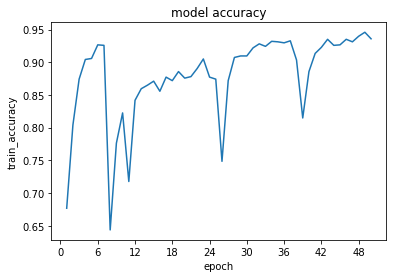

In [79]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()

plt.plot(np.arange(1,51), history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('train_accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

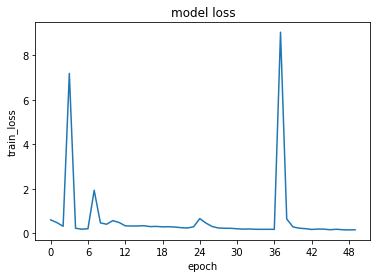

In [80]:
ax = plt.figure().gca()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('train_loss')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            64768     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 219,298
Trainable params: 219,298
Non-trainable params: 0
________________________________________________

In [106]:
# model.save('saved_pose.h5')

#### Evaluation on test set

In [49]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [81]:
ytrue = np.argmax(y_test, axis=1).tolist()

In [12]:
model.load_weights('720-data.h5')

In [82]:
y_res = model.predict(X_test)

In [83]:
yhat = np.argmax(y_res, axis=1).tolist()

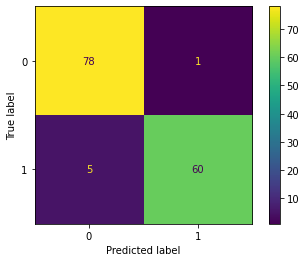

In [85]:
ConfusionMatrixDisplay(confusion_matrix(ytrue, yhat)).plot()


In [86]:
accuracy_score(ytrue, yhat)

0.9583333333333334

# IV. Test in real time

In [13]:
prev_frame_time = 0
input_sequence = []
predictions = []
cap = cv2.VideoCapture("cheat_2022-04-11 113657.mp4")
# cap = cv2.VideoCapture(1)
mp_drawing_styles = mp.solutions.drawing_styles
cap.set(3, 1280)
cap.set(4, 720)
count = 0
frame_num = 0
# result = cv2.VideoWriter('side4.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (1280, 720))

with mp_pose.Pose() as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret:
            print("Can't get frame!")
            break

        frame_num += 1
        # Make detections
        image, results = mediapipe_detection(frame, pose)

        #Draw landmarks
        if results.pose_landmarks:
            draw_landmarks(image, results)

        frame_landmarks = get_frame_landmarks(results)
        input_sequence.append(frame_landmarks)
        input_sequence = input_sequence[-30:]
        if len(input_sequence) == 30:
            res = model.predict(np.expand_dims(input_sequence, axis=0))[0]
            cheating_prob = round(res[1], 2)
            cv2.putText(image, "Cheating probs: "+str(cheating_prob), (0, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, ((255, 0, 0)), 2, cv2.LINE_AA)
            if cheating_prob > 0.8:
                cv2.putText(image, "Warning: suspicous behavior", (7, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (45, 255, 255), 2, cv2.LINE_AA)
        
        #Show fps
        prev_frame_time = show_fps(image, prev_frame_time)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()